In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import io
import os
import json
import time
import sys
import math
import copy
import pickle
import zipfile
from textwrap import wrap
from pathlib import Path
from itertools import zip_longest
from collections import defaultdict
from urllib.error import URLError
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torch import tensor
from torch.nn import functional as F 
from torch.optim.lr_scheduler import _LRScheduler

In [4]:
sys.path.append("src/")
from constants import *

## Experiment 2 - MF with deep NN

In [5]:
from torch.utils.data import IterableDataset
from itertools import chain, islice


class InteractionsStream(IterableDataset):

    def __init__(self, prep_data_dir=PREPARED_DATA_DIR, file_num=None,
                 sample='train', user_col='User', item_col='Movie',
                 end_token='.h5', start_token='user_{}_data_',
                 baseline_feats=False, model_type='regression',
                 chunksize=10):

        if file_num is None:
            self.files = [os.path.join(prep_data_dir, x) for x in
                          _find_files(prep_data_dir,
                                      start_token.format(sample),
                                      end_token)]
        else:
            self.files = [
                os.path.join(prep_data_dir,
                             start_token.format(sample)+str(file_num)+
                             end_token)]
        print(self.files)
        self.user_col = user_col
        self.item_col = item_col
        self.baseline_feats = baseline_feats
        self.sample = sample
        self.chunksize = chunksize
        if model_type == 'regression':
            self.dv_col = 'Rating'
        elif model_type == 'classification':
            self.dv_col = 'Rating_class'
        self.cat_cols = [self.user_col, self.item_col]
        
        if baseline_feats:
            self.numeric_cols = [
                'days_since_first_user_rating',
                'sqrt_days_since_first_user_rating',
                'rating_age_days_user', 'rating_age_weeks_user',
                'rating_age_months_user', 'mean_ratings_user',
                'num_ratings_user', 'days_since_first_item_rating',
                'sqrt_days_since_first_item_rating',
                'rating_age_days_item', 'rating_age_weeks_item',
                'rating_age_months_item', 'mean_ratings_movie',
                'weighted_mean_ratings_movie', 'num_ratings_movie']
        else:
            self.numeric_cols = []            

    def read_file(self, fn):
        
        if self.sample == 'train':
            df = pd.read_hdf(fn, key='stage', iterator=True,
                             chunksize=self.chunksize)
        else:
            df = pd.read_hdf(fn, key='stage')
        
        return df       

    def process_data(self, fn):

        print('read data')
        data = self.read_file(fn)

        if self.sample == 'train':
            for row in data:
                user = row[self.user_col].tolist()
                item = row[self.item_col].tolist()
                y = row[self.dv_col].tolist()
                yield (user, item), y
        else:
            for i, row in data.iterrows():
                yield (row[self.user_col],
                       row[self.item_col]), row[self.dv_col]

    def get_stream(self, files):
        return chain.from_iterable(map(self.process_data, files))

    def __iter__(self):
        return self.get_stream(self.files)

In [6]:
class EmbeddingNet(nn.Module):
    """
    Creates a dense network with embedding layers.
    
    Args:
    
        n_users:            
            Number of unique users in the dataset.

        n_movies: 
            Number of unique movies in the dataset.

        n_factors: 
            Number of columns in the embeddings matrix.

        embedding_dropout: 
            Dropout rate to apply right after embeddings layer.

        hidden:
            A single integer or a list of integers defining the number of 
            units in hidden layer(s).

        dropouts: 
            A single integer or a list of integers defining the dropout 
            layers rates applyied right after each of hidden layers.
            
    """
    def __init__(self, n_users, n_movies,
                 n_factors=50, embedding_dropout=0.02, 
                 hidden=10, dropouts=0.2):
        
        super().__init__()
        hidden = get_list(hidden)
        dropouts = get_list(dropouts)
        n_last = hidden[-1]
        
        def gen_layers(n_in):
            """
            A generator that yields a sequence of hidden layers and 
            their activations/dropouts.
            
            Note that the function captures `hidden` and `dropouts` 
            values from the outer scope.
            """
            nonlocal hidden, dropouts
            assert len(dropouts) <= len(hidden)
            
            for n_out, rate in zip_longest(hidden, dropouts):
                yield nn.Linear(n_in, n_out)
                yield nn.ReLU()
                if rate is not None and rate > 0.:
                    yield nn.Dropout(rate)
                n_in = n_out
            
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.drop = nn.Dropout(embedding_dropout)
        self.hidden = nn.Sequential(*list(gen_layers(n_factors * 2)))
        self.fc = nn.Linear(n_last, 1)
        self._init()
        
    def forward(self, users, movies, minmax=None):
        features = torch.cat([self.u(users), self.m(movies)], dim=1)
        x = self.drop(features)
        x = self.hidden(x)
        out = torch.sigmoid(self.fc(x))
        if minmax is not None:
            min_rating, max_rating = minmax
            out = out*(max_rating - min_rating + 1) + min_rating - 0.5
        
        return out
    
    def _init(self):
        """
        Setup embeddings and hidden layers with reasonable initial values.
        """
        
        def init(m):
            if type(m) == nn.Linear:
                torch.nn.init.xavier_uniform_(m.weight)
                m.bias.data.fill_(0.01)
                
        self.u.weight.data.uniform_(-0.05, 0.05)
        self.m.weight.data.uniform_(-0.05, 0.05)
        self.hidden.apply(init)
        init(self.fc)
    
    
def get_list(n):
    if isinstance(n, (int, float)):
        return [n]
    elif hasattr(n, '__iter__'):
        return list(n)
    raise TypeError('layers configuraiton should be a single number \
                    or a list of numbers')

In [7]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in
                self.base_lrs]

In [8]:
def triangular(step_size, max_lr, method='triangular', gamma=0.99):
    
    def scheduler(epoch, base_lr):
        period = 2 * step_size
        cycle = math.floor(1 + epoch/period)
        x = abs(epoch/step_size - 2*cycle + 1)
        delta = (max_lr - base_lr)*max(0, (1 - x))

        if method == 'triangular':
            pass  # we've already done
        elif method == 'triangular2':
            delta /= float(2 ** (cycle - 1))
        elif method == 'exp_range':
            delta *= (gamma**epoch)
        else:
            raise ValueError('unexpected method: %s' % method)
            
        return base_lr + delta
        
    return scheduler

In [9]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + math.cos(
            math.pi*t/t_max))/2
    
    return scheduler

In [10]:
def plot_lr(schedule):
    ts = list(range(1000))
    y = [schedule(t, 0.001) for t in ts]
    plt.plot(ts, y)

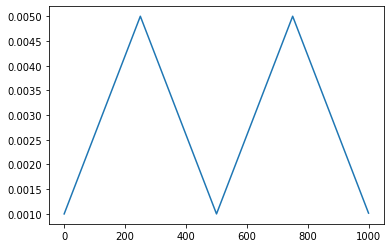

In [11]:
plot_lr(triangular(250, 0.005))

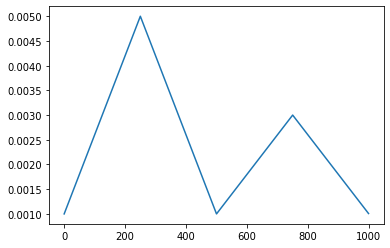

In [12]:
plot_lr(triangular(250, 0.005, 'triangular2'))

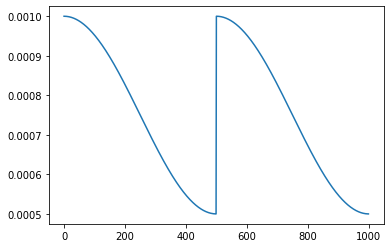

In [13]:
plot_lr(cosine(t_max=500, eta_min=0.0005))

In [14]:
# GLOBALS
FILE_NUM = 1
N_USERS = 480189
N_ITEMS = 17770
BATCH_SIZE = 50
CHUNKSIZE = 100
TRAIN_SIZE = 22851074 # corresponds to FILE_NUM
VAL_SIZE = 962152     # corresponds to FILE_NUM
TEST_SIZE = 240538    # corresponds to FILE_NUM

In [15]:
net = EmbeddingNet(
    n_users=N_USERS, n_movies=N_ITEMS, 
    n_factors=150, hidden=[500, 500, 500], 
    embedding_dropout=0.05, dropouts=[0.5, 0.5, 0.25])

In [16]:
net

EmbeddingNet(
  (u): Embedding(480189, 150)
  (m): Embedding(17770, 150)
  (drop): Dropout(p=0.05, inplace=False)
  (hidden): Sequential(
    (0): Linear(in_features=300, out_features=500, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=500, out_features=500, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=500, out_features=500, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.25, inplace=False)
  )
  (fc): Linear(in_features=500, out_features=1, bias=True)
)

In [17]:
minmax = (1., 5.)
minmax

(1.0, 5.0)

In [18]:
import torch
from torch import nn, tensor
import numpy as np
import collections, copy

from abc import ABCMeta
from abc import abstractmethod
from typing import Callable
from tqdm import tqdm


class StepBase:
    """Defines the interface that all step models here expose."""
    __metaclass__ = ABCMeta

    @abstractmethod
    def batch_fit(self, data_loader: torch.utils.data.DataLoader, epochs: int):
        """Trains the model on a batch of user-item interactions."""
        pass

    @abstractmethod
    def step(self, user: torch.tensor, item: torch.tensor,
             rating: torch.tensor, preference: torch.tensor):
        """Trains the model incrementally."""
        pass

    @abstractmethod
    def predict(self, user: torch.tensor, k: int):
        """Recommends the top-k items to a specific user."""
        pass

    @abstractmethod
    def save(self, path: str):
        """Saves the model parameters to the given path."""
        pass

    @abstractmethod
    def load(self, path: str):
        """Loads the model parameters from a given path."""
        pass
    
    
class Step(StepBase):
    """batch training of recommender systems."""
    
    def __init__(self, model: torch.nn.Module, train_size, test_size,
                 loss_function=torch.nn.MSELoss(reduction='sum'),
                 optimizer = torch.optim.Adam,
                 lr = 0.01, weight_decay = 0., batch_size=512,
                 chunksize=10, patience=2, minmax=(1., 5.)):
        
        self.loss_function = loss_function
        self.lr = lr
        self.batch_size = batch_size
        self.chunksize = chunksize
        self.weight_decay = weight_decay
        self.patience = patience
        self.minmax = minmax
        self.train_size = train_size
        self.test_size = test_size
        self.device = torch.device('cuda:0' if torch.cuda.is_available()
                                   else 'cpu')
        self.model = model.to(self.device)
        self.optimizer = optimizer(self.model.parameters(),
                                   lr=self.lr,
                                   weight_decay=self.weight_decay)
        self.iterations_per_epoch = int(math.ceil(
            self.train_size // (self.batch_size * self.chunksize)))
        self.scheduler = CyclicLR(self.optimizer, cosine(
            t_max=self.iterations_per_epoch * 2, eta_min=self.lr/10))
        self.history = []
        self.lr_history = []
        self.best_loss = np.inf
        self.best_weights = None

        # check if the user has provided user and item embeddings
        assert self.model.u, 'User embedding matrix could not be found.'
        assert self.model.m, 'Item embedding matrix could not be found.'

    @property
    def user_embeddings(self):
        return self.model.u

    @property
    def item_embeddings(self):
        return self.model.m
    
    def construct_tensor(self, a):
        out = [] 
        for i in a: 
            out += i.tolist() 
        return tensor(out)
    
    def train_model(self, data_loader: torch.utils.data.DataLoader):
        
        self.model.train()
        sum_loss = 0
        with tqdm(total=self.train_size //(self.batch_size *
                                           self.chunksize)) as pbar:
            for _, ((row, col), val) in enumerate(data_loader):
                row = self.construct_tensor(row).long().to(self.device)
                col = self.construct_tensor(col).long().to(self.device)
                val = self.construct_tensor(val).float().to(self.device)
                val = val.reshape((val.size()[0], 1))
                output = self.model(row, col, self.minmax)
                loss = self.loss_function(output, val)
                print(loss)
                self.optimizer.zero_grad()
                self.scheduler.step()
                loss.backward()
                self.optimizer.step()
                self.lr_history.extend(self.scheduler.get_lr())
                sum_loss += loss.item()
                pbar.update(1)
        
        return sum_loss/self.train_size

    def batch_fit(self, train_data_loader: torch.utils.data.DataLoader,
                  test_data_loader: torch.utils.data.DataLoader,
                  epochs: int = 1, val_flag=True):
        """Trains the model on a batch of user-item interactions."""
        
        no_improvements = 0
        for epoch in range(epochs):
            stats = {'epoch': epoch + 1, 'total': epochs}
            loss = self.train_model(train_data_loader)
            stats['train'] = loss
            if val_flag:
                print('estimating loss on the test set')
                val_loss = self._validation_loss(test_data_loader)
                stats['val'] = val_loss
                
                if val_loss < self.best_loss:
                    print('loss improvement on epoch: %d' % (epoch + 1))
                    self.best_loss = val_loss
                    self.best_weights = copy.deepcopy(
                        self.model.state_dict())
                    no_improvements = 0
                else:
                    no_improvements += 1
            
            self.history.append(stats)
            print('[{epoch:03d}/{total:03d}] train: {train:.4f} - val: {val:.4f}'.format(**stats))
            if no_improvements >= self.patience:
                print('early stopping after epoch {epoch:03d}'.format(**stats))
                break
            
    def _validation_loss(self, data_loader: torch.utils.data.DataLoader):
        
        self.model.eval()
        sum_loss = 0
        with tqdm(total=self.test_size // self.batch_size) as pbar:
            for _, ((row, col), val) in enumerate(data_loader):
                row = row.long().to(self.device)
                col = col.long().to(self.device)
                val = val.float().to(self.device)
                val = val.reshape((val.size()[0], 1))
                output = self.model(row, col, self.minmax)
                loss = self.loss_function(output, val)
                sum_loss += loss.item()
                pbar.update(1)
        
        return sum_loss/self.test_size

    def save(self, path: str):
        """Saves the best model's parameters to the given path."""
        torch.save(self.best_weights, path)

    def load(self, path: str):
        """Loads the model parameters from a given path."""
        if path is not None:
            self.model.load_state_dict(torch.load(path))
        else:
            self.model.load_state_dict(self.best_weights)

In [19]:
model = Step(net, train_size=TRAIN_SIZE, test_size=TEST_SIZE,
             lr=1e-3, weight_decay=1e-5, batch_size=BATCH_SIZE,
             chunksize=CHUNKSIZE, patience=2, minmax=minmax)

In [20]:
from torch.utils.data import DataLoader


train_dataset = InteractionsStream(
    file_num=FILE_NUM, baseline_feats=False, model_type='regression',
    sample='train', chunksize=CHUNKSIZE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=False)

test_dataset = InteractionsStream(file_num=FILE_NUM, baseline_feats=False,
                                  model_type='regression', sample='test')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         shuffle=False)

['/data/kaggle/netflix-prize-data/prepared_data_for_NN_modelling/user_train_data_1.h5']
['/data/kaggle/netflix-prize-data/prepared_data_for_NN_modelling/user_test_data_1.h5']


In [21]:
start = time.time()
model.batch_fit(train_data_loader=train_loader,
                test_data_loader=test_loader, val_flag=True, epochs=2)
print('time taken: %0.2f' % (time.time() - start))

  0%|          | 0/4570 [00:00<?, ?it/s]

read data


/root/.virtualenvs/py36/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 1/4570 [00:00<35:52,  2.12it/s]

tensor(7234.8530, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 2/4570 [00:00<31:27,  2.42it/s]

tensor(5997.8770, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 3/4570 [00:01<28:20,  2.69it/s]

tensor(6017.0674, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 4/4570 [00:01<26:11,  2.91it/s]

tensor(6162.6807, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 5/4570 [00:01<24:40,  3.08it/s]

tensor(6137.1113, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 6/4570 [00:01<23:47,  3.20it/s]

tensor(6004.3203, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 7/4570 [00:02<25:17,  3.01it/s]

tensor(5707.9214, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 8/4570 [00:02<24:02,  3.16it/s]

tensor(5801.0049, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 9/4570 [00:02<23:06,  3.29it/s]

tensor(5898.6489, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 10/4570 [00:03<22:29,  3.38it/s]

tensor(5988.1260, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 11/4570 [00:03<22:05,  3.44it/s]

tensor(5801.0176, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 12/4570 [00:03<21:47,  3.49it/s]

tensor(5863.4487, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 13/4570 [00:03<21:34,  3.52it/s]

tensor(5723.9727, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 14/4570 [00:04<21:26,  3.54it/s]

tensor(5774.8164, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 15/4570 [00:04<21:20,  3.56it/s]

tensor(5667.8076, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 16/4570 [00:04<21:15,  3.57it/s]

tensor(5503.3516, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 17/4570 [00:05<21:11,  3.58it/s]

tensor(5536.3125, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 18/4570 [00:05<21:08,  3.59it/s]

tensor(5701.7383, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 19/4570 [00:05<21:06,  3.59it/s]

tensor(5680.1416, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 20/4570 [00:05<21:04,  3.60it/s]

tensor(5656.5195, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 21/4570 [00:06<21:03,  3.60it/s]

tensor(5332.4761, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 22/4570 [00:06<21:02,  3.60it/s]

tensor(5560.3086, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 23/4570 [00:06<21:03,  3.60it/s]

tensor(5444.1514, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 24/4570 [00:06<21:02,  3.60it/s]

tensor(5424.7178, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 25/4570 [00:07<21:02,  3.60it/s]

tensor(5461.8320, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 26/4570 [00:07<21:01,  3.60it/s]

tensor(5521.0332, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 27/4570 [00:07<21:01,  3.60it/s]

tensor(5591.1011, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 28/4570 [00:08<21:00,  3.60it/s]

tensor(5494.7798, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 29/4570 [00:08<21:00,  3.60it/s]

tensor(5314.2100, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 30/4570 [00:08<21:01,  3.60it/s]

tensor(5396.8154, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 31/4570 [00:08<21:00,  3.60it/s]

tensor(5432.1782, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 32/4570 [00:09<21:00,  3.60it/s]

tensor(5719.1875, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 33/4570 [00:09<21:02,  3.59it/s]

tensor(5293.5518, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 34/4570 [00:09<21:11,  3.57it/s]

tensor(5429.1909, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 35/4570 [00:10<21:17,  3.55it/s]

tensor(5414.0747, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 36/4570 [00:10<21:22,  3.54it/s]

tensor(5444.8608, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 37/4570 [00:10<21:25,  3.53it/s]

tensor(5134.2812, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 38/4570 [00:10<21:26,  3.52it/s]

tensor(5321.2373, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 39/4570 [00:11<21:26,  3.52it/s]

tensor(5477.6079, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 40/4570 [00:11<21:33,  3.50it/s]

tensor(5220.4819, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 41/4570 [00:11<21:22,  3.53it/s]

tensor(5454.4111, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 42/4570 [00:12<21:13,  3.55it/s]

tensor(5377.8242, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 43/4570 [00:12<21:09,  3.57it/s]

tensor(5357.0596, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 44/4570 [00:12<21:06,  3.57it/s]

tensor(5162.0229, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 45/4570 [00:12<21:03,  3.58it/s]

tensor(5288.8447, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 46/4570 [00:13<21:01,  3.59it/s]

tensor(5029.2114, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 47/4570 [00:13<21:04,  3.58it/s]

tensor(5249.0405, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 48/4570 [00:13<21:09,  3.56it/s]

tensor(5551.7969, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 49/4570 [00:13<21:08,  3.56it/s]

tensor(5170.2163, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 50/4570 [00:14<21:08,  3.56it/s]

tensor(5302.0342, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 51/4570 [00:14<21:09,  3.56it/s]

tensor(5176.7192, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 52/4570 [00:14<21:15,  3.54it/s]

tensor(5305.1602, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 53/4570 [00:15<21:21,  3.52it/s]

tensor(5310.4131, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 54/4570 [00:15<21:26,  3.51it/s]

tensor(5112.3579, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 55/4570 [00:15<21:25,  3.51it/s]

tensor(5333.8564, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 56/4570 [00:15<21:34,  3.49it/s]

tensor(5318.0400, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 57/4570 [00:16<21:23,  3.52it/s]

tensor(5198.3086, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 58/4570 [00:16<21:16,  3.54it/s]

tensor(5034.1387, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 59/4570 [00:16<21:29,  3.50it/s]

tensor(5417.7031, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 60/4570 [00:17<21:20,  3.52it/s]

tensor(5392.4766, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 61/4570 [00:17<21:11,  3.55it/s]

tensor(5166.3750, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 62/4570 [00:17<21:06,  3.56it/s]

tensor(5154.3379, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 63/4570 [00:17<21:00,  3.58it/s]

tensor(5284.6895, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 64/4570 [00:18<20:56,  3.59it/s]

tensor(5047.9219, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 65/4570 [00:18<20:54,  3.59it/s]

tensor(5055.7036, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 66/4570 [00:18<20:53,  3.59it/s]

tensor(5199.4395, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 67/4570 [00:19<20:51,  3.60it/s]

tensor(5418.6216, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 68/4570 [00:19<20:50,  3.60it/s]

tensor(5094.7529, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 69/4570 [00:19<20:48,  3.60it/s]

tensor(5127.6318, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 70/4570 [00:19<20:48,  3.61it/s]

tensor(4961.5098, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 71/4570 [00:20<20:48,  3.60it/s]

tensor(5210.7998, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 72/4570 [00:20<20:48,  3.60it/s]

tensor(5142.1431, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 73/4570 [00:20<20:47,  3.60it/s]

tensor(5037.3252, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 74/4570 [00:20<20:54,  3.58it/s]

tensor(5080.8896, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 75/4570 [00:21<21:13,  3.53it/s]

tensor(5194.6904, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 76/4570 [00:21<21:32,  3.48it/s]

tensor(5012.1338, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 77/4570 [00:21<21:44,  3.44it/s]

tensor(5082.8105, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 78/4570 [00:22<21:48,  3.43it/s]

tensor(5157.9414, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 79/4570 [00:22<21:44,  3.44it/s]

tensor(5315.8101, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 80/4570 [00:22<21:39,  3.45it/s]

tensor(5078.0732, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 81/4570 [00:23<21:22,  3.50it/s]

tensor(5162.5752, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 82/4570 [00:23<21:10,  3.53it/s]

tensor(5155.0293, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 83/4570 [00:23<21:00,  3.56it/s]

tensor(4971.0566, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 84/4570 [00:23<20:56,  3.57it/s]

tensor(5055.5327, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 85/4570 [00:24<20:51,  3.58it/s]

tensor(4969.8330, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 86/4570 [00:24<20:47,  3.60it/s]

tensor(5381.2988, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 87/4570 [00:24<20:47,  3.59it/s]

tensor(5104.5596, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 88/4570 [00:24<20:46,  3.60it/s]

tensor(5081.7622, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 89/4570 [00:25<20:43,  3.60it/s]

tensor(5017.5513, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 90/4570 [00:25<20:44,  3.60it/s]

tensor(4906.0503, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 91/4570 [00:25<20:56,  3.56it/s]

tensor(5211.4976, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 92/4570 [00:26<20:49,  3.58it/s]

tensor(5099.7632, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 93/4570 [00:26<20:46,  3.59it/s]

tensor(5157.4844, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 94/4570 [00:26<20:47,  3.59it/s]

tensor(5044.9824, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 95/4570 [00:26<20:47,  3.59it/s]

tensor(5055.7681, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 96/4570 [00:27<20:46,  3.59it/s]

tensor(5170.0513, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 97/4570 [00:27<20:47,  3.58it/s]

tensor(5181.2656, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 98/4570 [00:27<20:47,  3.58it/s]

tensor(5024.6855, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 99/4570 [00:28<20:49,  3.58it/s]

tensor(5006.1924, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 100/4570 [00:28<20:49,  3.58it/s]

tensor(5100.7100, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 101/4570 [00:28<20:54,  3.56it/s]

tensor(4913.1802, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 102/4570 [00:28<20:53,  3.57it/s]

tensor(5208.5581, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 103/4570 [00:29<20:50,  3.57it/s]

tensor(5035.2744, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 104/4570 [00:29<20:49,  3.57it/s]

tensor(4893.2104, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 105/4570 [00:29<20:50,  3.57it/s]

tensor(5139.7988, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 106/4570 [00:30<20:53,  3.56it/s]

tensor(4931.1201, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 107/4570 [00:30<20:54,  3.56it/s]

tensor(4965.9644, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 108/4570 [00:30<20:53,  3.56it/s]

tensor(4979.5044, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 109/4570 [00:30<20:50,  3.57it/s]

tensor(4955.5874, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 110/4570 [00:31<20:49,  3.57it/s]

tensor(5177.9043, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 111/4570 [00:31<21:06,  3.52it/s]

tensor(5078.0591, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 112/4570 [00:31<21:21,  3.48it/s]

tensor(4983.7544, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 113/4570 [00:31<21:05,  3.52it/s]

tensor(5087.3643, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 114/4570 [00:32<20:54,  3.55it/s]

tensor(5063.8408, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 115/4570 [00:32<20:48,  3.57it/s]

tensor(4868.3291, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 116/4570 [00:32<20:42,  3.58it/s]

tensor(4920.1641, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 117/4570 [00:33<20:39,  3.59it/s]

tensor(4948.2402, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 118/4570 [00:33<20:47,  3.57it/s]

tensor(4953.7041, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 119/4570 [00:33<20:42,  3.58it/s]

tensor(4894.8984, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 120/4570 [00:33<20:38,  3.59it/s]

tensor(5014.8105, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 121/4570 [00:34<20:36,  3.60it/s]

tensor(5001.0264, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 122/4570 [00:34<20:33,  3.61it/s]

tensor(5184.3271, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 123/4570 [00:34<20:32,  3.61it/s]

tensor(4917.8086, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 124/4570 [00:35<20:31,  3.61it/s]

tensor(4750.5000, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 125/4570 [00:35<20:41,  3.58it/s]

tensor(4980.0820, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 126/4570 [00:35<20:37,  3.59it/s]

tensor(5048.6895, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 127/4570 [00:35<20:34,  3.60it/s]

tensor(4971.6475, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 128/4570 [00:36<21:00,  3.52it/s]

tensor(5008.6406, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 129/4570 [00:36<20:50,  3.55it/s]

tensor(5059.6670, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 130/4570 [00:36<20:47,  3.56it/s]

tensor(4975.3506, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 131/4570 [00:37<20:56,  3.53it/s]

tensor(4896.0239, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 132/4570 [00:37<20:48,  3.55it/s]

tensor(4876.3384, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 133/4570 [00:37<20:58,  3.52it/s]

tensor(4850.9512, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 134/4570 [00:37<20:48,  3.55it/s]

tensor(4985.3071, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 135/4570 [00:38<20:41,  3.57it/s]

tensor(4795.3521, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 136/4570 [00:38<20:36,  3.59it/s]

tensor(4851.3262, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 137/4570 [00:38<20:33,  3.59it/s]

tensor(5000.9346, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 138/4570 [00:38<20:30,  3.60it/s]

tensor(5029.3125, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 139/4570 [00:39<20:28,  3.61it/s]

tensor(5150.4678, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 140/4570 [00:39<20:26,  3.61it/s]

tensor(5022.2871, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 141/4570 [00:39<20:24,  3.62it/s]

tensor(5023.9443, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 142/4570 [00:40<20:25,  3.61it/s]

tensor(4863.5439, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 143/4570 [00:40<20:50,  3.54it/s]

tensor(4893.6143, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 144/4570 [00:40<20:42,  3.56it/s]

tensor(5120.6338, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 145/4570 [00:40<20:37,  3.58it/s]

tensor(4822.3838, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 146/4570 [00:41<20:36,  3.58it/s]

tensor(5171.9004, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 147/4570 [00:41<20:37,  3.57it/s]

tensor(4847.6401, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 148/4570 [00:41<20:39,  3.57it/s]

tensor(4822.3110, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 149/4570 [00:42<20:37,  3.57it/s]

tensor(4947.1006, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 150/4570 [00:42<20:50,  3.54it/s]

tensor(4963.6821, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 151/4570 [00:42<20:45,  3.55it/s]

tensor(5190.7363, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 152/4570 [00:42<20:44,  3.55it/s]

tensor(4952.7900, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 153/4570 [00:43<20:59,  3.51it/s]

tensor(5117.7583, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 154/4570 [00:43<20:51,  3.53it/s]

tensor(4746.5596, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 155/4570 [00:43<20:47,  3.54it/s]

tensor(5001.7954, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 156/4570 [00:44<20:43,  3.55it/s]

tensor(5039.9424, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 157/4570 [00:44<20:39,  3.56it/s]

tensor(4832.9863, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 158/4570 [00:44<20:37,  3.57it/s]

tensor(5088.6465, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 159/4570 [00:44<20:37,  3.56it/s]

tensor(4990.0991, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 160/4570 [00:45<20:35,  3.57it/s]

tensor(4760.2363, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 161/4570 [00:45<20:35,  3.57it/s]

tensor(4952.7080, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 162/4570 [00:45<20:33,  3.57it/s]

tensor(4791.2271, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 163/4570 [00:45<20:32,  3.58it/s]

tensor(4911.1611, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 164/4570 [00:46<20:32,  3.57it/s]

tensor(4987.7349, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 165/4570 [00:46<20:48,  3.53it/s]

tensor(4866.4731, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 166/4570 [00:46<20:43,  3.54it/s]

tensor(4901.3325, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 167/4570 [00:47<20:40,  3.55it/s]

tensor(4928.7256, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 168/4570 [00:47<20:37,  3.56it/s]

tensor(5036.6392, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 169/4570 [00:47<20:46,  3.53it/s]

tensor(4932.8247, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 170/4570 [00:47<20:41,  3.54it/s]

tensor(4915.5391, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 171/4570 [00:48<20:38,  3.55it/s]

tensor(5000.8086, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 172/4570 [00:48<20:35,  3.56it/s]

tensor(4883.1943, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 173/4570 [00:48<20:30,  3.57it/s]

tensor(4837.9131, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 174/4570 [00:49<20:26,  3.59it/s]

tensor(4913.0879, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 175/4570 [00:49<20:26,  3.58it/s]

tensor(4778.5918, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 176/4570 [00:49<20:23,  3.59it/s]

tensor(4964.4243, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 177/4570 [00:49<20:22,  3.59it/s]

tensor(4775.5801, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 178/4570 [00:50<20:38,  3.55it/s]

tensor(5023.8994, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 179/4570 [00:50<20:30,  3.57it/s]

tensor(4890.8418, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 180/4570 [00:50<20:25,  3.58it/s]

tensor(4966.8076, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 181/4570 [00:51<20:21,  3.59it/s]

tensor(4832.5278, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 182/4570 [00:51<20:17,  3.60it/s]

tensor(4928.6821, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 183/4570 [00:51<20:15,  3.61it/s]

tensor(5063.6143, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 184/4570 [00:51<20:17,  3.60it/s]

tensor(4910.2412, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 185/4570 [00:52<20:14,  3.61it/s]

tensor(4821.2461, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 186/4570 [00:52<20:15,  3.61it/s]

tensor(4909.4077, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 187/4570 [00:52<20:14,  3.61it/s]

tensor(4913.2607, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 188/4570 [00:52<20:12,  3.61it/s]

tensor(5074.1514, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 189/4570 [00:53<20:12,  3.61it/s]

tensor(4854.7026, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 190/4570 [00:53<20:11,  3.62it/s]

tensor(4763.4141, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 191/4570 [00:53<20:10,  3.62it/s]

tensor(4847.2271, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 192/4570 [00:54<20:10,  3.62it/s]

tensor(4776.3115, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 193/4570 [00:54<20:23,  3.58it/s]

tensor(4918.1865, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 194/4570 [00:54<20:20,  3.58it/s]

tensor(4866.4268, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 195/4570 [00:54<20:16,  3.60it/s]

tensor(4889.6719, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 196/4570 [00:55<20:13,  3.60it/s]

tensor(4866.0312, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 197/4570 [00:55<20:10,  3.61it/s]

tensor(4925.6074, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 198/4570 [00:55<20:09,  3.61it/s]

tensor(4873.2427, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 199/4570 [00:56<20:09,  3.61it/s]

tensor(4749.4639, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 200/4570 [00:56<20:07,  3.62it/s]

tensor(4988.1992, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 201/4570 [00:56<20:07,  3.62it/s]

tensor(4662.2314, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 202/4570 [00:56<20:06,  3.62it/s]

tensor(4864.4170, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 203/4570 [00:57<20:16,  3.59it/s]

tensor(4893.1016, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 204/4570 [00:57<20:11,  3.60it/s]

tensor(4948.8770, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 205/4570 [00:57<20:29,  3.55it/s]

tensor(4768.4170, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 206/4570 [00:57<20:22,  3.57it/s]

tensor(4850.8887, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 207/4570 [00:58<20:18,  3.58it/s]

tensor(4952.3838, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 208/4570 [00:58<20:14,  3.59it/s]

tensor(4637.7910, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 209/4570 [00:58<20:12,  3.60it/s]

tensor(4951.7588, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 210/4570 [00:59<20:09,  3.61it/s]

tensor(4735.0107, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 211/4570 [00:59<20:08,  3.61it/s]

tensor(4800.2183, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 212/4570 [00:59<20:06,  3.61it/s]

tensor(4924.2607, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 213/4570 [00:59<20:05,  3.61it/s]

tensor(4832.2549, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 214/4570 [01:00<20:05,  3.61it/s]

tensor(4838.0547, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 215/4570 [01:00<20:04,  3.62it/s]

tensor(4810.2222, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 216/4570 [01:00<20:03,  3.62it/s]

tensor(4977.5000, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 217/4570 [01:01<20:04,  3.61it/s]

tensor(4954.9507, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 218/4570 [01:01<20:03,  3.62it/s]

tensor(4718.3555, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 219/4570 [01:01<20:02,  3.62it/s]

tensor(4780.4746, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 220/4570 [01:01<20:04,  3.61it/s]

tensor(4679.6753, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 221/4570 [01:02<20:03,  3.61it/s]

tensor(5171.9336, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 222/4570 [01:02<20:03,  3.61it/s]

tensor(4758.8604, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 223/4570 [01:02<20:03,  3.61it/s]

tensor(4764.3008, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 224/4570 [01:02<20:01,  3.62it/s]

tensor(4844.0884, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 225/4570 [01:03<20:01,  3.62it/s]

tensor(4860.0840, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 226/4570 [01:03<20:03,  3.61it/s]

tensor(4705.7227, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 227/4570 [01:03<20:03,  3.61it/s]

tensor(4842.7041, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 228/4570 [01:04<20:12,  3.58it/s]

tensor(4755.0449, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 229/4570 [01:04<20:08,  3.59it/s]

tensor(4865.3271, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 230/4570 [01:04<20:05,  3.60it/s]

tensor(4958.2998, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 231/4570 [01:04<20:04,  3.60it/s]

tensor(4932.3096, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 232/4570 [01:05<20:02,  3.61it/s]

tensor(4755.3159, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 233/4570 [01:05<20:00,  3.61it/s]

tensor(4953.3433, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 234/4570 [01:05<19:59,  3.62it/s]

tensor(4727.6255, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 235/4570 [01:06<19:58,  3.62it/s]

tensor(4843.1274, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 236/4570 [01:06<19:58,  3.62it/s]

tensor(4747.4590, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 237/4570 [01:06<19:57,  3.62it/s]

tensor(4665.7969, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 238/4570 [01:06<19:56,  3.62it/s]

tensor(4652.3008, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 239/4570 [01:07<19:57,  3.62it/s]

tensor(4818.6470, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 240/4570 [01:07<19:58,  3.61it/s]

tensor(4811.5293, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 241/4570 [01:07<19:59,  3.61it/s]

tensor(4809.2637, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 242/4570 [01:07<19:58,  3.61it/s]

tensor(4838.2222, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 243/4570 [01:08<19:57,  3.61it/s]

tensor(4797.9922, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 244/4570 [01:08<19:58,  3.61it/s]

tensor(4705.0405, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 245/4570 [01:08<20:00,  3.60it/s]

tensor(4812.4595, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 246/4570 [01:09<20:02,  3.60it/s]

tensor(4608.9619, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 247/4570 [01:09<20:02,  3.60it/s]

tensor(4939.1025, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 248/4570 [01:09<20:01,  3.60it/s]

tensor(4699.5342, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 249/4570 [01:09<20:02,  3.59it/s]

tensor(4802.3242, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 250/4570 [01:10<20:00,  3.60it/s]

tensor(4737.8184, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 251/4570 [01:10<20:01,  3.60it/s]

tensor(4873.7109, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 252/4570 [01:10<20:01,  3.59it/s]

tensor(4834.7939, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 253/4570 [01:11<20:14,  3.55it/s]

tensor(4938.3101, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 254/4570 [01:11<20:05,  3.58it/s]

tensor(4869.4277, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 255/4570 [01:11<19:58,  3.60it/s]

tensor(4788.3774, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 256/4570 [01:11<20:01,  3.59it/s]

tensor(4862.6807, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 257/4570 [01:12<19:56,  3.60it/s]

tensor(4868.8604, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 258/4570 [01:12<19:52,  3.62it/s]

tensor(4858.2544, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 259/4570 [01:12<19:51,  3.62it/s]

tensor(4840.5029, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 260/4570 [01:12<19:48,  3.63it/s]

tensor(4697.0181, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 261/4570 [01:13<19:47,  3.63it/s]

tensor(4902.3623, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 262/4570 [01:13<20:05,  3.57it/s]

tensor(4751.6494, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 263/4570 [01:13<19:58,  3.59it/s]

tensor(4791.6846, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 264/4570 [01:14<19:54,  3.60it/s]

tensor(4836.1318, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 265/4570 [01:14<19:51,  3.61it/s]

tensor(4737.0234, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 266/4570 [01:14<19:48,  3.62it/s]

tensor(4711.0747, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 267/4570 [01:14<19:47,  3.63it/s]

tensor(4862.4941, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 268/4570 [01:15<19:46,  3.63it/s]

tensor(4886.7363, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 269/4570 [01:15<19:44,  3.63it/s]

tensor(4920.1133, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 270/4570 [01:15<19:53,  3.60it/s]

tensor(4813.6753, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 271/4570 [01:15<19:50,  3.61it/s]

tensor(4863.4580, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 272/4570 [01:16<19:48,  3.62it/s]

tensor(4670.1289, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 273/4570 [01:16<19:46,  3.62it/s]

tensor(4768.1104, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 274/4570 [01:16<19:45,  3.62it/s]

tensor(4724.3486, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 275/4570 [01:17<19:44,  3.63it/s]

tensor(4610.2031, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 276/4570 [01:17<19:43,  3.63it/s]

tensor(4745.9277, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 277/4570 [01:17<19:43,  3.63it/s]

tensor(4757.2109, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 278/4570 [01:17<19:43,  3.63it/s]

tensor(4699.2969, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 279/4570 [01:18<19:42,  3.63it/s]

tensor(4691.9600, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 280/4570 [01:18<19:41,  3.63it/s]

tensor(4649.7949, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 281/4570 [01:18<19:43,  3.62it/s]

tensor(4862.0068, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 282/4570 [01:19<19:49,  3.60it/s]

tensor(4690.5479, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 283/4570 [01:19<19:46,  3.61it/s]

tensor(4885.8696, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 284/4570 [01:19<19:57,  3.58it/s]

tensor(4721.8555, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 285/4570 [01:19<19:54,  3.59it/s]

tensor(4861.3398, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 286/4570 [01:20<19:50,  3.60it/s]

tensor(4855.4355, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 287/4570 [01:20<19:48,  3.60it/s]

tensor(4918.4014, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 288/4570 [01:20<19:47,  3.61it/s]

tensor(4526.6567, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 289/4570 [01:20<20:02,  3.56it/s]

tensor(4885.1357, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 290/4570 [01:21<19:55,  3.58it/s]

tensor(4946.0674, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 291/4570 [01:21<19:50,  3.59it/s]

tensor(4820.0405, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 292/4570 [01:21<19:46,  3.60it/s]

tensor(4775.5503, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 293/4570 [01:22<19:43,  3.61it/s]

tensor(4691.9072, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 294/4570 [01:22<19:40,  3.62it/s]

tensor(4736.4570, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 295/4570 [01:22<19:40,  3.62it/s]

tensor(4867.9150, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 296/4570 [01:22<19:39,  3.62it/s]

tensor(4900.9053, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 297/4570 [01:23<19:38,  3.63it/s]

tensor(4881.4346, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 298/4570 [01:23<19:38,  3.62it/s]

tensor(4719.8027, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 299/4570 [01:23<19:38,  3.62it/s]

tensor(4696.9023, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 300/4570 [01:24<19:38,  3.62it/s]

tensor(4573.8008, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 301/4570 [01:24<19:37,  3.62it/s]

tensor(4754.0835, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 302/4570 [01:24<19:37,  3.63it/s]

tensor(4870.9932, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 303/4570 [01:24<19:36,  3.63it/s]

tensor(4803.4570, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 304/4570 [01:25<19:37,  3.62it/s]

tensor(4837.1353, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 305/4570 [01:25<19:36,  3.62it/s]

tensor(4739.0781, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 306/4570 [01:25<19:36,  3.62it/s]

tensor(4815.4756, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 307/4570 [01:25<19:36,  3.62it/s]

tensor(4792.6855, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 308/4570 [01:26<19:40,  3.61it/s]

tensor(4806.6240, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 309/4570 [01:26<20:10,  3.52it/s]

tensor(4811.1987, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 310/4570 [01:26<19:59,  3.55it/s]

tensor(4630.1021, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 311/4570 [01:27<19:52,  3.57it/s]

tensor(4744.8447, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 312/4570 [01:27<19:46,  3.59it/s]

tensor(4510.7222, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 313/4570 [01:27<19:43,  3.60it/s]

tensor(4744.8799, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 314/4570 [01:27<19:41,  3.60it/s]

tensor(4710.3418, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 315/4570 [01:28<19:39,  3.61it/s]

tensor(4837.6851, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 316/4570 [01:28<19:52,  3.57it/s]

tensor(4800.0186, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 317/4570 [01:28<19:57,  3.55it/s]

tensor(4829.7412, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 318/4570 [01:29<19:52,  3.57it/s]

tensor(4735.1787, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 319/4570 [01:29<19:48,  3.58it/s]

tensor(4711.1333, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 320/4570 [01:29<19:44,  3.59it/s]

tensor(4723.4263, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 321/4570 [01:29<19:44,  3.59it/s]

tensor(4667.4688, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 322/4570 [01:30<19:42,  3.59it/s]

tensor(4607.8496, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 323/4570 [01:30<19:43,  3.59it/s]

tensor(4606.8652, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 324/4570 [01:30<19:58,  3.54it/s]

tensor(4771.2041, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 325/4570 [01:30<20:02,  3.53it/s]

tensor(4887.1313, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 326/4570 [01:31<20:04,  3.52it/s]

tensor(4852.8018, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 327/4570 [01:31<19:52,  3.56it/s]

tensor(4678.3750, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 328/4570 [01:31<19:44,  3.58it/s]

tensor(4849.8730, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 329/4570 [01:32<19:40,  3.59it/s]

tensor(4704.7134, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 330/4570 [01:32<19:36,  3.60it/s]

tensor(4793.5947, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 331/4570 [01:32<19:33,  3.61it/s]

tensor(4723.9800, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 332/4570 [01:32<19:33,  3.61it/s]

tensor(4904.9443, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 333/4570 [01:33<19:30,  3.62it/s]

tensor(4850.1870, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 334/4570 [01:33<19:29,  3.62it/s]

tensor(4735.6553, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 335/4570 [01:33<19:29,  3.62it/s]

tensor(4862.7793, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 336/4570 [01:34<19:28,  3.62it/s]

tensor(4665.0371, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 337/4570 [01:34<19:28,  3.62it/s]

tensor(4593.5522, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 338/4570 [01:34<19:26,  3.63it/s]

tensor(4695.8618, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 339/4570 [01:34<19:26,  3.63it/s]

tensor(4812.8955, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 340/4570 [01:35<19:25,  3.63it/s]

tensor(4770.2847, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 341/4570 [01:35<19:26,  3.63it/s]

tensor(4770.0688, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 342/4570 [01:35<19:25,  3.63it/s]

tensor(4639.8271, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 343/4570 [01:35<19:25,  3.63it/s]

tensor(4932.0469, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 344/4570 [01:36<19:25,  3.63it/s]

tensor(4746.4775, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 345/4570 [01:36<19:24,  3.63it/s]

tensor(4800.1719, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 346/4570 [01:36<19:24,  3.63it/s]

tensor(4567.0601, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 347/4570 [01:37<19:25,  3.62it/s]

tensor(4726.8828, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 348/4570 [01:37<19:23,  3.63it/s]

tensor(4776.7583, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 349/4570 [01:37<19:34,  3.59it/s]

tensor(4560.5400, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 350/4570 [01:37<19:31,  3.60it/s]

tensor(4822.4346, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 351/4570 [01:38<19:27,  3.61it/s]

tensor(4801.6777, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 352/4570 [01:38<19:46,  3.56it/s]

tensor(4741.7969, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 353/4570 [01:38<19:38,  3.58it/s]

tensor(4631.6826, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 354/4570 [01:39<19:33,  3.59it/s]

tensor(4525.8848, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 355/4570 [01:39<19:29,  3.60it/s]

tensor(4796.0947, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 356/4570 [01:39<19:26,  3.61it/s]

tensor(4785.1626, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 357/4570 [01:39<19:25,  3.62it/s]

tensor(4954.2920, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 358/4570 [01:40<19:23,  3.62it/s]

tensor(4718.8506, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 359/4570 [01:40<19:22,  3.62it/s]

tensor(4794.1445, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 360/4570 [01:40<19:21,  3.62it/s]

tensor(4809.0254, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 361/4570 [01:40<19:21,  3.63it/s]

tensor(4741.6050, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 362/4570 [01:41<19:20,  3.63it/s]

tensor(4646.9521, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 363/4570 [01:41<19:18,  3.63it/s]

tensor(4736.1836, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 364/4570 [01:41<19:18,  3.63it/s]

tensor(4597.0151, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 365/4570 [01:42<19:18,  3.63it/s]

tensor(4478.8574, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 366/4570 [01:42<19:17,  3.63it/s]

tensor(4749.4438, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 367/4570 [01:42<19:18,  3.63it/s]

tensor(4883.6631, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 368/4570 [01:42<19:18,  3.63it/s]

tensor(4569.0356, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 369/4570 [01:43<19:17,  3.63it/s]

tensor(4854.3389, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 370/4570 [01:43<19:17,  3.63it/s]

tensor(4710.0503, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 371/4570 [01:43<19:17,  3.63it/s]

tensor(4624.4736, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 372/4570 [01:43<19:16,  3.63it/s]

tensor(4736.2920, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 373/4570 [01:44<19:16,  3.63it/s]

tensor(4717.2568, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 374/4570 [01:44<19:15,  3.63it/s]

tensor(4876.6528, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 375/4570 [01:44<19:16,  3.63it/s]

tensor(4487.5996, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 376/4570 [01:45<19:16,  3.63it/s]

tensor(4661.9688, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 377/4570 [01:45<19:31,  3.58it/s]

tensor(4727.2720, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 378/4570 [01:45<19:32,  3.57it/s]

tensor(4675.1885, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 379/4570 [01:45<19:32,  3.57it/s]

tensor(4572.7559, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 380/4570 [01:46<19:34,  3.57it/s]

tensor(4752.0254, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 381/4570 [01:46<19:48,  3.52it/s]

tensor(4652.5737, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 382/4570 [01:46<19:43,  3.54it/s]

tensor(4581.0679, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 383/4570 [01:47<19:38,  3.55it/s]

tensor(4743.1025, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 384/4570 [01:47<19:33,  3.57it/s]

tensor(4621.3423, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 385/4570 [01:47<19:32,  3.57it/s]

tensor(4684.5269, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 386/4570 [01:47<19:31,  3.57it/s]

tensor(4684.9268, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 387/4570 [01:48<19:30,  3.57it/s]

tensor(4722.6982, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 388/4570 [01:48<19:28,  3.58it/s]

tensor(4890.8428, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 389/4570 [01:48<19:27,  3.58it/s]

tensor(4666.8618, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 390/4570 [01:49<19:44,  3.53it/s]

tensor(4734.5117, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 391/4570 [01:49<19:39,  3.54it/s]

tensor(4596.6416, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 392/4570 [01:49<19:32,  3.56it/s]

tensor(4597.2578, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 393/4570 [01:49<19:30,  3.57it/s]

tensor(4859.4717, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 394/4570 [01:50<19:28,  3.58it/s]

tensor(4775.1621, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 395/4570 [01:50<19:27,  3.58it/s]

tensor(4605.6191, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 396/4570 [01:50<19:24,  3.59it/s]

tensor(4851.8267, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 397/4570 [01:50<19:22,  3.59it/s]

tensor(4889.8110, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 398/4570 [01:51<19:17,  3.61it/s]

tensor(4618.1514, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 399/4570 [01:51<19:17,  3.60it/s]

tensor(4678.9600, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 400/4570 [01:51<19:17,  3.60it/s]

tensor(4824.8242, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 401/4570 [01:52<19:14,  3.61it/s]

tensor(4738.4072, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 402/4570 [01:52<19:14,  3.61it/s]

tensor(4841.1055, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 403/4570 [01:52<19:14,  3.61it/s]

tensor(4751.1206, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 404/4570 [01:52<19:10,  3.62it/s]

tensor(4774.9409, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 405/4570 [01:53<19:11,  3.62it/s]

tensor(4640.4023, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 406/4570 [01:53<19:11,  3.61it/s]

tensor(4817.0884, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 407/4570 [01:53<19:09,  3.62it/s]

tensor(4558.3594, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 408/4570 [01:54<19:11,  3.61it/s]

tensor(4683.4619, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 409/4570 [01:54<19:11,  3.61it/s]

tensor(4703.4854, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 410/4570 [01:54<19:10,  3.62it/s]

tensor(4577.4248, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 411/4570 [01:54<19:10,  3.61it/s]

tensor(4688.2295, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 412/4570 [01:55<19:11,  3.61it/s]

tensor(4681.0142, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 413/4570 [01:55<19:07,  3.62it/s]

tensor(4738.2236, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 414/4570 [01:55<19:07,  3.62it/s]

tensor(4673.0640, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 415/4570 [01:55<19:10,  3.61it/s]

tensor(4574.1436, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 416/4570 [01:56<19:11,  3.61it/s]

tensor(4614.0288, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 417/4570 [01:56<19:09,  3.61it/s]

tensor(4685.7437, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 418/4570 [01:56<19:12,  3.60it/s]

tensor(4690.7168, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 419/4570 [01:57<19:14,  3.60it/s]

tensor(4755.3154, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 420/4570 [01:57<19:10,  3.61it/s]

tensor(4698.2183, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 421/4570 [01:57<19:09,  3.61it/s]

tensor(4396.3545, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 422/4570 [01:57<19:09,  3.61it/s]

tensor(4604.3477, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 423/4570 [01:58<19:05,  3.62it/s]

tensor(4662.4385, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 424/4570 [01:58<19:27,  3.55it/s]

tensor(4726.9380, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 425/4570 [01:58<19:22,  3.57it/s]

tensor(4780.1240, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 426/4570 [01:59<19:29,  3.54it/s]

tensor(4743.0098, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 427/4570 [01:59<19:21,  3.57it/s]

tensor(4530.1328, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 428/4570 [01:59<19:24,  3.56it/s]

tensor(4568.1396, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 429/4570 [01:59<19:27,  3.55it/s]

tensor(4531.8525, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 430/4570 [02:00<19:29,  3.54it/s]

tensor(4535.0815, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 431/4570 [02:00<19:30,  3.54it/s]

tensor(4805.4102, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 432/4570 [02:00<19:30,  3.53it/s]

tensor(4477.8228, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 433/4570 [02:01<19:47,  3.48it/s]

tensor(4690.7441, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 434/4570 [02:01<19:41,  3.50it/s]

tensor(4712.4258, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 435/4570 [02:01<19:37,  3.51it/s]

tensor(4755.7725, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 436/4570 [02:01<19:34,  3.52it/s]

tensor(4611.0986, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 437/4570 [02:02<19:32,  3.53it/s]

tensor(4620.0576, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 438/4570 [02:02<19:30,  3.53it/s]

tensor(4644.3110, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 439/4570 [02:02<19:29,  3.53it/s]

tensor(4642.3086, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 440/4570 [02:03<19:46,  3.48it/s]

tensor(4675.4771, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 441/4570 [02:03<19:39,  3.50it/s]

tensor(4719.7031, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 442/4570 [02:03<19:34,  3.51it/s]

tensor(4608.4092, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 443/4570 [02:03<19:30,  3.53it/s]

tensor(4586.8408, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 444/4570 [02:04<19:28,  3.53it/s]

tensor(4740.3931, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 445/4570 [02:04<19:29,  3.53it/s]

tensor(4644.6094, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 446/4570 [02:04<19:28,  3.53it/s]

tensor(4497.6963, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 447/4570 [02:04<19:28,  3.53it/s]

tensor(4729.0425, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 448/4570 [02:05<19:26,  3.53it/s]

tensor(4647.1270, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 449/4570 [02:05<19:25,  3.54it/s]

tensor(4803.3242, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 450/4570 [02:05<19:24,  3.54it/s]

tensor(4567.4092, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 451/4570 [02:06<19:24,  3.54it/s]

tensor(4655.4028, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 452/4570 [02:06<19:24,  3.54it/s]

tensor(4609.7339, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 453/4570 [02:06<19:23,  3.54it/s]

tensor(4632.5757, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 454/4570 [02:06<19:22,  3.54it/s]

tensor(4853.5879, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 455/4570 [02:07<19:22,  3.54it/s]

tensor(4721.4092, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 456/4570 [02:07<19:22,  3.54it/s]

tensor(4740.5742, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 457/4570 [02:07<19:40,  3.48it/s]

tensor(4844.4756, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 458/4570 [02:08<19:34,  3.50it/s]

tensor(4623.3584, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 459/4570 [02:08<19:30,  3.51it/s]

tensor(4556.2095, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 460/4570 [02:08<19:28,  3.52it/s]

tensor(4709.2822, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 461/4570 [02:08<19:26,  3.52it/s]

tensor(4734.8496, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 462/4570 [02:09<19:33,  3.50it/s]

tensor(4524.7949, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 463/4570 [02:09<19:29,  3.51it/s]

tensor(4658.6030, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 464/4570 [02:09<19:25,  3.52it/s]

tensor(4511.3555, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 465/4570 [02:10<19:24,  3.52it/s]

tensor(4705.3467, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 466/4570 [02:10<19:22,  3.53it/s]

tensor(4694.9160, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 467/4570 [02:10<19:20,  3.53it/s]

tensor(4532.5869, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 468/4570 [02:10<19:19,  3.54it/s]

tensor(4751.3193, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 469/4570 [02:11<19:19,  3.54it/s]

tensor(4583.2437, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 470/4570 [02:11<19:18,  3.54it/s]

tensor(4623.4761, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 471/4570 [02:11<19:18,  3.54it/s]

tensor(4681.5972, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 472/4570 [02:12<19:18,  3.54it/s]

tensor(4815.3965, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 473/4570 [02:12<19:19,  3.53it/s]

tensor(4666.6836, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 474/4570 [02:12<19:30,  3.50it/s]

tensor(4726.4819, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 475/4570 [02:12<19:26,  3.51it/s]

tensor(4703.8955, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 476/4570 [02:13<19:23,  3.52it/s]

tensor(4675.9570, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 477/4570 [02:13<19:21,  3.52it/s]

tensor(4651.2158, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 478/4570 [02:13<19:19,  3.53it/s]

tensor(4706.4795, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 479/4570 [02:14<19:25,  3.51it/s]

tensor(4803.3525, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 480/4570 [02:14<19:22,  3.52it/s]

tensor(4752.0371, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 481/4570 [02:14<19:19,  3.53it/s]

tensor(4762.6245, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 482/4570 [02:14<19:18,  3.53it/s]

tensor(4546.3564, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 483/4570 [02:15<19:18,  3.53it/s]

tensor(4587.5200, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 484/4570 [02:15<19:29,  3.50it/s]

tensor(4738.0762, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 485/4570 [02:15<19:24,  3.51it/s]

tensor(4719.9814, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 486/4570 [02:16<19:22,  3.51it/s]

tensor(4891.5039, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 487/4570 [02:16<19:20,  3.52it/s]

tensor(4753.9795, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 488/4570 [02:16<19:18,  3.52it/s]

tensor(4759.3145, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 489/4570 [02:16<19:17,  3.53it/s]

tensor(4524.1611, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 490/4570 [02:17<19:15,  3.53it/s]

tensor(4570.0127, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 491/4570 [02:17<19:33,  3.48it/s]

tensor(4626.2188, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 492/4570 [02:17<19:40,  3.45it/s]

tensor(4570.7998, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 493/4570 [02:18<19:26,  3.50it/s]

tensor(4499.6777, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 494/4570 [02:18<19:14,  3.53it/s]

tensor(4529.4395, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 495/4570 [02:18<19:06,  3.55it/s]

tensor(4762.1426, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 496/4570 [02:18<19:02,  3.57it/s]

tensor(4759.3447, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 497/4570 [02:19<19:00,  3.57it/s]

tensor(4822.5542, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 498/4570 [02:19<19:04,  3.56it/s]

tensor(4637.5879, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 499/4570 [02:19<19:06,  3.55it/s]

tensor(4498.2178, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 500/4570 [02:20<19:02,  3.56it/s]

tensor(4561.8452, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 501/4570 [02:20<19:17,  3.51it/s]

tensor(4576.4106, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 502/4570 [02:20<19:09,  3.54it/s]

tensor(4566.5049, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 503/4570 [02:20<19:04,  3.55it/s]

tensor(4590.6475, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 504/4570 [02:21<19:00,  3.56it/s]

tensor(4581.7783, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 505/4570 [02:21<18:58,  3.57it/s]

tensor(4578.8892, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 506/4570 [02:21<18:56,  3.57it/s]

tensor(4600.3154, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 507/4570 [02:21<19:12,  3.53it/s]

tensor(4643.2461, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 508/4570 [02:22<19:20,  3.50it/s]

tensor(4548.5117, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 509/4570 [02:22<19:19,  3.50it/s]

tensor(4581.3691, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 510/4570 [02:22<19:17,  3.51it/s]

tensor(4801.0728, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 511/4570 [02:23<19:18,  3.50it/s]

tensor(4591.7339, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 512/4570 [02:23<19:14,  3.51it/s]

tensor(4602.6270, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 513/4570 [02:23<19:22,  3.49it/s]

tensor(4592.8818, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 514/4570 [02:24<19:18,  3.50it/s]

tensor(4562.5879, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 515/4570 [02:24<19:17,  3.50it/s]

tensor(4710.8174, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 516/4570 [02:24<19:14,  3.51it/s]

tensor(4625.1519, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 517/4570 [02:24<19:14,  3.51it/s]

tensor(4673.4419, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 518/4570 [02:25<19:13,  3.51it/s]

tensor(4527.1104, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 519/4570 [02:25<19:11,  3.52it/s]

tensor(4634.0225, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 520/4570 [02:25<19:09,  3.52it/s]

tensor(4532.2656, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 521/4570 [02:25<19:07,  3.53it/s]

tensor(4618.0723, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 522/4570 [02:26<19:08,  3.52it/s]

tensor(4657.8237, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 523/4570 [02:26<19:07,  3.53it/s]

tensor(4635.9331, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 524/4570 [02:26<19:07,  3.53it/s]

tensor(4661.5811, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 525/4570 [02:27<19:06,  3.53it/s]

tensor(4726.2217, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 526/4570 [02:27<19:05,  3.53it/s]

tensor(4455.6074, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 527/4570 [02:27<19:04,  3.53it/s]

tensor(4417.7544, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 528/4570 [02:27<19:04,  3.53it/s]

tensor(4550.4199, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 529/4570 [02:28<19:02,  3.54it/s]

tensor(4447.9429, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 530/4570 [02:28<19:01,  3.54it/s]

tensor(4593.1899, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 531/4570 [02:28<19:01,  3.54it/s]

tensor(4471.2456, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 532/4570 [02:29<19:11,  3.51it/s]

tensor(4520.3418, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 533/4570 [02:29<19:20,  3.48it/s]

tensor(4519.8467, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 534/4570 [02:29<19:19,  3.48it/s]

tensor(4520.8364, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 535/4570 [02:29<19:16,  3.49it/s]

tensor(4675.2109, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 536/4570 [02:30<19:11,  3.50it/s]

tensor(4645.7852, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 537/4570 [02:30<19:11,  3.50it/s]

tensor(4719.4160, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 538/4570 [02:30<19:10,  3.50it/s]

tensor(4567.7427, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 539/4570 [02:31<19:11,  3.50it/s]

tensor(4739.8960, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 540/4570 [02:31<19:12,  3.50it/s]

tensor(4566.9922, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 541/4570 [02:31<19:12,  3.49it/s]

tensor(4692.7017, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 542/4570 [02:31<19:12,  3.49it/s]

tensor(4633.3037, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 543/4570 [02:32<19:28,  3.45it/s]

tensor(4695.8896, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 544/4570 [02:32<19:20,  3.47it/s]

tensor(4608.9556, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 545/4570 [02:32<19:13,  3.49it/s]

tensor(4520.0825, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 546/4570 [02:33<19:11,  3.50it/s]

tensor(4637.7461, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 547/4570 [02:33<19:11,  3.49it/s]

tensor(4683.5596, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 548/4570 [02:33<19:09,  3.50it/s]

tensor(4551.9414, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 549/4570 [02:33<19:09,  3.50it/s]

tensor(4893.7324, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 550/4570 [02:34<19:08,  3.50it/s]

tensor(4573.3799, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 551/4570 [02:34<19:12,  3.49it/s]

tensor(4704.1113, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 552/4570 [02:34<19:10,  3.49it/s]

tensor(4441.9292, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 553/4570 [02:35<19:08,  3.50it/s]

tensor(4699.5566, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 554/4570 [02:35<19:04,  3.51it/s]

tensor(4655.4033, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 555/4570 [02:35<19:02,  3.51it/s]

tensor(4629.1885, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 556/4570 [02:35<19:08,  3.49it/s]

tensor(4646.7646, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 557/4570 [02:36<19:25,  3.44it/s]

tensor(4635.8872, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 558/4570 [02:36<19:18,  3.46it/s]

tensor(4478.8018, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 559/4570 [02:36<19:11,  3.48it/s]

tensor(4606.2842, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 560/4570 [02:37<19:20,  3.46it/s]

tensor(4787.3320, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 561/4570 [02:37<19:13,  3.48it/s]

tensor(4527.6167, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 562/4570 [02:37<19:07,  3.49it/s]

tensor(4706.7275, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 563/4570 [02:37<19:05,  3.50it/s]

tensor(4419.9131, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 564/4570 [02:38<19:21,  3.45it/s]

tensor(4660.3091, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 565/4570 [02:38<19:14,  3.47it/s]

tensor(4515.3081, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 566/4570 [02:38<19:08,  3.49it/s]

tensor(4568.6890, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 567/4570 [02:39<19:04,  3.50it/s]

tensor(4486.6514, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 568/4570 [02:39<19:00,  3.51it/s]

tensor(4641.5098, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 569/4570 [02:39<18:57,  3.52it/s]

tensor(4597.0581, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 570/4570 [02:39<18:57,  3.52it/s]

tensor(4498.2490, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 571/4570 [02:40<18:56,  3.52it/s]

tensor(4602.7095, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 572/4570 [02:40<18:57,  3.52it/s]

tensor(4543.2471, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 573/4570 [02:40<19:00,  3.51it/s]

tensor(4646.6543, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 574/4570 [02:41<19:01,  3.50it/s]

tensor(4461.9399, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 575/4570 [02:41<19:02,  3.50it/s]

tensor(4666.0215, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 576/4570 [02:41<19:03,  3.49it/s]

tensor(4737.3184, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 577/4570 [02:42<19:02,  3.49it/s]

tensor(4738.5576, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 578/4570 [02:42<19:02,  3.49it/s]

tensor(4545.3574, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 579/4570 [02:42<18:58,  3.51it/s]

tensor(4659.5981, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 580/4570 [02:42<18:57,  3.51it/s]

tensor(4704.3691, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 581/4570 [02:43<19:01,  3.50it/s]

tensor(4563.5278, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 582/4570 [02:43<18:57,  3.51it/s]

tensor(4566.7422, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 583/4570 [02:43<18:55,  3.51it/s]

tensor(4665.6040, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 584/4570 [02:43<18:53,  3.52it/s]

tensor(4344.8311, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 585/4570 [02:44<18:52,  3.52it/s]

tensor(4616.7725, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 586/4570 [02:44<18:53,  3.52it/s]

tensor(4485.3535, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 587/4570 [02:44<18:55,  3.51it/s]

tensor(4534.5928, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 588/4570 [02:45<18:54,  3.51it/s]

tensor(4602.0645, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 589/4570 [02:45<18:53,  3.51it/s]

tensor(4724.9775, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 590/4570 [02:45<18:53,  3.51it/s]

tensor(4526.8555, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 591/4570 [02:45<18:52,  3.51it/s]

tensor(4632.7798, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 592/4570 [02:46<18:52,  3.51it/s]

tensor(4467.7598, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 593/4570 [02:46<18:51,  3.52it/s]

tensor(4556.0283, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 594/4570 [02:46<18:55,  3.50it/s]

tensor(4547.2842, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 595/4570 [02:47<18:52,  3.51it/s]

tensor(4713.1958, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 596/4570 [02:47<19:17,  3.43it/s]

tensor(4496.3237, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 597/4570 [02:47<19:09,  3.46it/s]

tensor(4676.1982, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 598/4570 [02:48<19:10,  3.45it/s]

tensor(4522.3389, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 599/4570 [02:48<19:02,  3.48it/s]

tensor(4574.1562, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 600/4570 [02:48<18:55,  3.50it/s]

tensor(4399.5000, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 601/4570 [02:48<18:46,  3.52it/s]

tensor(4642.8135, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 602/4570 [02:49<18:40,  3.54it/s]

tensor(4502.0762, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 603/4570 [02:49<18:35,  3.56it/s]

tensor(4616.9580, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 604/4570 [02:49<18:32,  3.56it/s]

tensor(4583.0928, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 605/4570 [02:49<18:32,  3.56it/s]

tensor(4627.5938, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 606/4570 [02:50<18:29,  3.57it/s]

tensor(4507.6738, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 607/4570 [02:50<18:27,  3.58it/s]

tensor(4733.3350, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 608/4570 [02:50<18:47,  3.51it/s]

tensor(4514.2554, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 609/4570 [02:51<19:02,  3.47it/s]

tensor(4685.6543, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 610/4570 [02:51<18:59,  3.48it/s]

tensor(4519.3418, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 611/4570 [02:51<18:57,  3.48it/s]

tensor(4571.8584, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 612/4570 [02:51<18:55,  3.49it/s]

tensor(4501.0059, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 613/4570 [02:52<18:53,  3.49it/s]

tensor(4575.3774, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 614/4570 [02:52<18:52,  3.49it/s]

tensor(4573.1724, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 615/4570 [02:52<18:52,  3.49it/s]

tensor(4559.6284, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 616/4570 [02:53<18:52,  3.49it/s]

tensor(4556.5420, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 617/4570 [02:53<18:53,  3.49it/s]

tensor(4735.2168, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 618/4570 [02:53<18:53,  3.49it/s]

tensor(4589.2441, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 619/4570 [02:53<18:51,  3.49it/s]

tensor(4500.3984, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 620/4570 [02:54<18:50,  3.50it/s]

tensor(4491.0547, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 621/4570 [02:54<18:51,  3.49it/s]

tensor(4671.6050, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 622/4570 [02:54<18:51,  3.49it/s]

tensor(4591.1328, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 623/4570 [02:55<18:49,  3.49it/s]

tensor(4626.3613, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 624/4570 [02:55<18:50,  3.49it/s]

tensor(4565.8589, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 625/4570 [02:55<18:50,  3.49it/s]

tensor(4643.4189, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 626/4570 [02:55<18:48,  3.49it/s]

tensor(4560.7295, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 627/4570 [02:56<18:49,  3.49it/s]

tensor(4590.6338, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 628/4570 [02:56<18:49,  3.49it/s]

tensor(4439.7412, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 629/4570 [02:56<18:51,  3.48it/s]

tensor(4678.5703, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 630/4570 [02:57<19:05,  3.44it/s]

tensor(4726.6699, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 631/4570 [02:57<19:00,  3.45it/s]

tensor(4537.6675, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 632/4570 [02:57<18:57,  3.46it/s]

tensor(4616.9487, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 633/4570 [02:58<18:54,  3.47it/s]

tensor(4743.6709, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 634/4570 [02:58<18:53,  3.47it/s]

tensor(4633.8936, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 635/4570 [02:58<18:51,  3.48it/s]

tensor(4757.6602, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 636/4570 [02:58<18:58,  3.45it/s]

tensor(4814.0283, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 637/4570 [02:59<18:55,  3.46it/s]

tensor(4578.7803, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 638/4570 [02:59<18:54,  3.47it/s]

tensor(4727.5752, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 639/4570 [02:59<18:53,  3.47it/s]

tensor(4622.7856, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 640/4570 [03:00<18:49,  3.48it/s]

tensor(4561.8389, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 641/4570 [03:00<18:50,  3.48it/s]

tensor(4667.9922, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 642/4570 [03:00<18:48,  3.48it/s]

tensor(4530.7544, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 643/4570 [03:00<18:50,  3.47it/s]

tensor(4539.6631, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 644/4570 [03:01<18:48,  3.48it/s]

tensor(4812.5215, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 645/4570 [03:01<18:45,  3.49it/s]

tensor(4491.3555, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 646/4570 [03:01<18:42,  3.49it/s]

tensor(4403.7720, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 647/4570 [03:02<18:40,  3.50it/s]

tensor(4527.3369, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 648/4570 [03:02<18:39,  3.50it/s]

tensor(4688.7612, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 649/4570 [03:02<18:39,  3.50it/s]

tensor(4529.8818, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 650/4570 [03:02<18:38,  3.50it/s]

tensor(4626.3174, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 651/4570 [03:03<18:39,  3.50it/s]

tensor(4655.7598, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 652/4570 [03:03<18:39,  3.50it/s]

tensor(4421.8711, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 653/4570 [03:03<18:38,  3.50it/s]

tensor(4517.2949, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 654/4570 [03:04<18:35,  3.51it/s]

tensor(4606.4004, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 655/4570 [03:04<18:36,  3.51it/s]

tensor(4712.5942, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 656/4570 [03:04<18:35,  3.51it/s]

tensor(4558.3672, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 657/4570 [03:04<18:40,  3.49it/s]

tensor(4556.8291, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 658/4570 [03:05<18:35,  3.51it/s]

tensor(4466.4956, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 659/4570 [03:05<18:32,  3.51it/s]

tensor(4430.0195, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 660/4570 [03:05<18:29,  3.53it/s]

tensor(4413.0073, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 661/4570 [03:06<18:26,  3.53it/s]

tensor(4673.1606, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 662/4570 [03:06<18:25,  3.53it/s]

tensor(4439.6372, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 663/4570 [03:06<18:39,  3.49it/s]

tensor(4619.3071, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 664/4570 [03:06<18:33,  3.51it/s]

tensor(4540.4307, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 665/4570 [03:07<18:29,  3.52it/s]

tensor(4393.9878, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 666/4570 [03:07<18:27,  3.53it/s]

tensor(4629.8984, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 667/4570 [03:07<18:26,  3.53it/s]

tensor(4564.8252, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 668/4570 [03:08<18:25,  3.53it/s]

tensor(4712.1929, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 669/4570 [03:08<18:28,  3.52it/s]

tensor(4571.4902, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 670/4570 [03:08<18:25,  3.53it/s]

tensor(4477.1035, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 671/4570 [03:08<18:23,  3.53it/s]

tensor(4467.6074, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 672/4570 [03:09<18:22,  3.53it/s]

tensor(4464.3169, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 673/4570 [03:09<18:22,  3.53it/s]

tensor(4570.5928, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 674/4570 [03:09<18:25,  3.52it/s]

tensor(4434.2617, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 675/4570 [03:09<18:23,  3.53it/s]

tensor(4699.3340, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 676/4570 [03:10<18:22,  3.53it/s]

tensor(4720.2031, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 677/4570 [03:10<18:23,  3.53it/s]

tensor(4716.9033, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 678/4570 [03:10<18:22,  3.53it/s]

tensor(4661.2646, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 679/4570 [03:11<18:23,  3.53it/s]

tensor(4673.0088, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 680/4570 [03:11<18:32,  3.50it/s]

tensor(4660.3247, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 681/4570 [03:11<18:26,  3.51it/s]

tensor(4587.0493, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 682/4570 [03:11<18:22,  3.53it/s]

tensor(4580.2637, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 683/4570 [03:12<18:19,  3.53it/s]

tensor(4486.2832, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 684/4570 [03:12<18:17,  3.54it/s]

tensor(4682.3721, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 685/4570 [03:12<18:17,  3.54it/s]

tensor(4602.5669, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 686/4570 [03:13<18:16,  3.54it/s]

tensor(4477.5713, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 687/4570 [03:13<18:15,  3.54it/s]

tensor(4696.1934, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 688/4570 [03:13<18:14,  3.55it/s]

tensor(4609.2383, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 689/4570 [03:13<18:13,  3.55it/s]

tensor(4517.6436, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 690/4570 [03:14<18:13,  3.55it/s]

tensor(4453.1592, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 691/4570 [03:14<18:14,  3.54it/s]

tensor(4659.0859, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 692/4570 [03:14<18:15,  3.54it/s]

tensor(4738.5811, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 693/4570 [03:15<18:14,  3.54it/s]

tensor(4646.4985, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 694/4570 [03:15<18:13,  3.54it/s]

tensor(4642.5264, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 695/4570 [03:15<18:21,  3.52it/s]

tensor(4624.4697, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 696/4570 [03:15<18:19,  3.52it/s]

tensor(4648.8008, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 697/4570 [03:16<18:16,  3.53it/s]

tensor(4545.0371, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 698/4570 [03:16<18:15,  3.53it/s]

tensor(4570.0083, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 699/4570 [03:16<18:13,  3.54it/s]

tensor(4449.7939, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 700/4570 [03:17<18:12,  3.54it/s]

tensor(4678.4541, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 701/4570 [03:17<18:11,  3.55it/s]

tensor(4557.7334, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 702/4570 [03:17<18:12,  3.54it/s]

tensor(4574.2271, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 703/4570 [03:17<18:13,  3.54it/s]

tensor(4674.5537, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 704/4570 [03:18<18:12,  3.54it/s]

tensor(4523.7754, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 705/4570 [03:18<18:11,  3.54it/s]

tensor(4571.3389, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 706/4570 [03:18<18:10,  3.54it/s]

tensor(4688.7803, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 707/4570 [03:19<18:10,  3.54it/s]

tensor(4689.3154, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 708/4570 [03:19<18:11,  3.54it/s]

tensor(4566.6392, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 709/4570 [03:19<18:11,  3.54it/s]

tensor(4593.4355, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 710/4570 [03:19<18:11,  3.54it/s]

tensor(4607.8291, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 711/4570 [03:20<18:10,  3.54it/s]

tensor(4621.0576, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 712/4570 [03:20<18:12,  3.53it/s]

tensor(4662.5405, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 713/4570 [03:20<18:06,  3.55it/s]

tensor(4456.2998, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 714/4570 [03:21<18:02,  3.56it/s]

tensor(4522.1948, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 715/4570 [03:21<18:01,  3.56it/s]

tensor(4458.2021, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 716/4570 [03:21<17:58,  3.57it/s]

tensor(4580.0747, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 717/4570 [03:21<17:57,  3.58it/s]

tensor(4429.5166, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 718/4570 [03:22<17:56,  3.58it/s]

tensor(4485.9409, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 719/4570 [03:22<17:59,  3.57it/s]

tensor(4575.6924, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 720/4570 [03:22<17:55,  3.58it/s]

tensor(4722.2832, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 721/4570 [03:22<17:55,  3.58it/s]

tensor(4590.3706, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 722/4570 [03:23<17:52,  3.59it/s]

tensor(4423.4023, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 723/4570 [03:23<17:52,  3.59it/s]

tensor(4594.8340, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 724/4570 [03:23<17:52,  3.59it/s]

tensor(4486.5195, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 725/4570 [03:24<17:49,  3.60it/s]

tensor(4845.7373, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 726/4570 [03:24<17:51,  3.59it/s]

tensor(4651.5996, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 727/4570 [03:24<17:53,  3.58it/s]

tensor(4524.1953, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 728/4570 [03:24<17:51,  3.58it/s]

tensor(4545.4570, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 729/4570 [03:25<17:49,  3.59it/s]

tensor(4612.0586, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 730/4570 [03:25<17:51,  3.58it/s]

tensor(4430.7109, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 731/4570 [03:25<17:54,  3.57it/s]

tensor(4518.1387, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 732/4570 [03:26<17:58,  3.56it/s]

tensor(4466.4966, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 733/4570 [03:26<17:55,  3.57it/s]

tensor(4590.2363, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 734/4570 [03:26<18:12,  3.51it/s]

tensor(4468.3950, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 735/4570 [03:26<18:10,  3.52it/s]

tensor(4733.1816, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 736/4570 [03:27<18:03,  3.54it/s]

tensor(4434.7305, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 737/4570 [03:27<18:01,  3.55it/s]

tensor(4610.2568, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 738/4570 [03:27<17:56,  3.56it/s]

tensor(4497.4844, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 739/4570 [03:28<18:05,  3.53it/s]

tensor(4488.1152, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 740/4570 [03:28<18:00,  3.55it/s]

tensor(4464.6123, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 741/4570 [03:28<17:56,  3.56it/s]

tensor(4603.3306, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 742/4570 [03:28<17:52,  3.57it/s]

tensor(4512.8877, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 743/4570 [03:29<17:50,  3.57it/s]

tensor(4606.9395, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 744/4570 [03:29<17:50,  3.57it/s]

tensor(4548.7725, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 745/4570 [03:29<17:48,  3.58it/s]

tensor(4674.4028, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 746/4570 [03:29<17:48,  3.58it/s]

tensor(4508.9956, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 747/4570 [03:30<17:50,  3.57it/s]

tensor(4571.4946, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 748/4570 [03:30<17:50,  3.57it/s]

tensor(4534.7217, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 749/4570 [03:30<17:47,  3.58it/s]

tensor(4486.1143, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 750/4570 [03:31<17:48,  3.58it/s]

tensor(4546.8271, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 751/4570 [03:31<17:48,  3.58it/s]

tensor(4500.2549, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 752/4570 [03:31<17:46,  3.58it/s]

tensor(4481.5386, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 753/4570 [03:31<17:45,  3.58it/s]

tensor(4439.5088, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 754/4570 [03:32<17:46,  3.58it/s]

tensor(4481.5908, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 755/4570 [03:32<17:44,  3.58it/s]

tensor(4458.0068, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 756/4570 [03:32<17:47,  3.57it/s]

tensor(4184.7881, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 757/4570 [03:33<17:54,  3.55it/s]

tensor(4619.5078, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 758/4570 [03:33<17:49,  3.56it/s]

tensor(4446.9585, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 759/4570 [03:33<17:48,  3.57it/s]

tensor(4552.8867, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 760/4570 [03:33<17:46,  3.57it/s]

tensor(4781.0693, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 761/4570 [03:34<17:44,  3.58it/s]

tensor(4710.3599, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 762/4570 [03:34<17:46,  3.57it/s]

tensor(4662.0547, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 763/4570 [03:34<17:46,  3.57it/s]

tensor(4588.6943, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 764/4570 [03:35<17:56,  3.54it/s]

tensor(4475.0752, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 765/4570 [03:35<17:50,  3.56it/s]

tensor(4495.5605, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 766/4570 [03:35<17:55,  3.54it/s]

tensor(4627.9253, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 767/4570 [03:35<17:51,  3.55it/s]

tensor(4611.5518, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 768/4570 [03:36<17:46,  3.57it/s]

tensor(4534.2451, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 769/4570 [03:36<17:44,  3.57it/s]

tensor(4742.3467, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 770/4570 [03:36<17:42,  3.58it/s]

tensor(4563.9590, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 771/4570 [03:36<17:40,  3.58it/s]

tensor(4651.7451, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 772/4570 [03:37<17:37,  3.59it/s]

tensor(4615.1431, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 773/4570 [03:37<17:38,  3.59it/s]

tensor(4462.0234, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 774/4570 [03:37<17:37,  3.59it/s]

tensor(4678.5396, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 775/4570 [03:38<17:37,  3.59it/s]

tensor(4549.7861, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 776/4570 [03:38<17:38,  3.59it/s]

tensor(4565.3311, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 777/4570 [03:38<17:36,  3.59it/s]

tensor(4677.8965, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 778/4570 [03:38<17:36,  3.59it/s]

tensor(4641.6528, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 779/4570 [03:39<17:36,  3.59it/s]

tensor(4628.7422, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 780/4570 [03:39<17:37,  3.59it/s]

tensor(4576.9707, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 781/4570 [03:39<17:34,  3.59it/s]

tensor(4624.8081, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 782/4570 [03:40<17:35,  3.59it/s]

tensor(4590.3472, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 783/4570 [03:40<17:35,  3.59it/s]

tensor(4740.5625, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 784/4570 [03:40<17:32,  3.60it/s]

tensor(4413.9629, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 785/4570 [03:40<17:33,  3.59it/s]

tensor(4511.1289, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 786/4570 [03:41<17:34,  3.59it/s]

tensor(4393.6514, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 787/4570 [03:41<17:35,  3.59it/s]

tensor(4519.8169, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 788/4570 [03:41<17:41,  3.56it/s]

tensor(4470.8076, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 789/4570 [03:41<17:38,  3.57it/s]

tensor(4609.4854, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 790/4570 [03:42<17:37,  3.58it/s]

tensor(4533.3740, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 791/4570 [03:42<17:34,  3.59it/s]

tensor(4524.5723, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 792/4570 [03:42<17:35,  3.58it/s]

tensor(4671.1084, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 793/4570 [03:43<17:31,  3.59it/s]

tensor(4584.9370, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 794/4570 [03:43<17:31,  3.59it/s]

tensor(4417.8799, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 795/4570 [03:43<17:31,  3.59it/s]

tensor(4656.9561, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 796/4570 [03:43<17:30,  3.59it/s]

tensor(4528.7832, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 797/4570 [03:44<17:27,  3.60it/s]

tensor(4507.0830, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 798/4570 [03:44<17:28,  3.60it/s]

tensor(4571.1016, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 799/4570 [03:44<17:29,  3.59it/s]

tensor(4611.0205, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 800/4570 [03:45<17:26,  3.60it/s]

tensor(4771.9375, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 801/4570 [03:45<17:26,  3.60it/s]

tensor(4442.2104, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 802/4570 [03:45<17:26,  3.60it/s]

tensor(4544.9131, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 803/4570 [03:45<17:26,  3.60it/s]

tensor(4598.0625, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 804/4570 [03:46<17:24,  3.61it/s]

tensor(4413.3218, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 805/4570 [03:46<17:29,  3.59it/s]

tensor(4622.9189, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 806/4570 [03:46<17:29,  3.59it/s]

tensor(4499.0151, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 807/4570 [03:47<17:26,  3.60it/s]

tensor(4548.3428, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 808/4570 [03:47<17:26,  3.59it/s]

tensor(4534.1548, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 809/4570 [03:47<17:25,  3.60it/s]

tensor(4715.1196, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 810/4570 [03:47<17:25,  3.59it/s]

tensor(4546.8730, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 811/4570 [03:48<17:25,  3.59it/s]

tensor(4508.4102, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 812/4570 [03:48<17:26,  3.59it/s]

tensor(4704.5049, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 813/4570 [03:48<17:23,  3.60it/s]

tensor(4574.0493, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 814/4570 [03:48<17:23,  3.60it/s]

tensor(4513.5732, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 815/4570 [03:49<17:24,  3.60it/s]

tensor(4776.5874, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 816/4570 [03:49<17:22,  3.60it/s]

tensor(4337.6821, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 817/4570 [03:49<17:23,  3.60it/s]

tensor(4790.2769, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 818/4570 [03:50<17:23,  3.59it/s]

tensor(4593.7661, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 819/4570 [03:50<17:21,  3.60it/s]

tensor(4471.7524, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 820/4570 [03:50<17:19,  3.61it/s]

tensor(4587.0771, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 821/4570 [03:50<17:17,  3.61it/s]

tensor(4650.2798, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 822/4570 [03:51<17:16,  3.62it/s]

tensor(4570.5088, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 823/4570 [03:51<17:15,  3.62it/s]

tensor(4486.7959, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 824/4570 [03:51<17:14,  3.62it/s]

tensor(4661.4062, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 825/4570 [03:51<17:14,  3.62it/s]

tensor(4542.1914, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 826/4570 [03:52<17:15,  3.62it/s]

tensor(4533.6768, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 827/4570 [03:52<17:14,  3.62it/s]

tensor(4586.5664, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 828/4570 [03:52<17:30,  3.56it/s]

tensor(4445.4951, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 829/4570 [03:53<17:24,  3.58it/s]

tensor(4469.5020, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 830/4570 [03:53<17:19,  3.60it/s]

tensor(4525.2832, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 831/4570 [03:53<17:19,  3.60it/s]

tensor(4401.3545, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 832/4570 [03:53<17:15,  3.61it/s]

tensor(4457.7959, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 833/4570 [03:54<17:13,  3.62it/s]

tensor(4498.2666, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 834/4570 [03:54<17:27,  3.57it/s]

tensor(4746.6465, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 835/4570 [03:54<17:21,  3.59it/s]

tensor(4602.1367, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 836/4570 [03:55<17:16,  3.60it/s]

tensor(4396.5654, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 837/4570 [03:55<17:14,  3.61it/s]

tensor(4463.3584, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 838/4570 [03:55<17:11,  3.62it/s]

tensor(4604.7148, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 839/4570 [03:55<17:09,  3.62it/s]

tensor(4726.8105, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 840/4570 [03:56<17:16,  3.60it/s]

tensor(4586.5479, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 841/4570 [03:56<17:13,  3.61it/s]

tensor(4502.6963, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 842/4570 [03:56<17:11,  3.61it/s]

tensor(4620.8950, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 843/4570 [03:56<17:08,  3.62it/s]

tensor(4437.6523, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 844/4570 [03:57<17:07,  3.63it/s]

tensor(4510.5415, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 845/4570 [03:57<17:06,  3.63it/s]

tensor(4562.0054, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 846/4570 [03:57<17:06,  3.63it/s]

tensor(4422.5654, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 847/4570 [03:58<17:05,  3.63it/s]

tensor(4493.2783, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 848/4570 [03:58<17:04,  3.63it/s]

tensor(4420.6489, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 849/4570 [03:58<17:04,  3.63it/s]

tensor(4550.2422, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 850/4570 [03:58<17:03,  3.64it/s]

tensor(4584.3569, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 851/4570 [03:59<17:12,  3.60it/s]

tensor(4464.9668, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 852/4570 [03:59<17:10,  3.61it/s]

tensor(4668.7246, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 853/4570 [03:59<17:07,  3.62it/s]

tensor(4371.3184, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 854/4570 [04:00<17:06,  3.62it/s]

tensor(4668.3384, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 855/4570 [04:00<17:04,  3.63it/s]

tensor(4491.6797, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 856/4570 [04:00<17:03,  3.63it/s]

tensor(4618.2646, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 857/4570 [04:00<17:02,  3.63it/s]

tensor(4562.5898, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 858/4570 [04:01<17:02,  3.63it/s]

tensor(4612.0308, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 859/4570 [04:01<17:01,  3.63it/s]

tensor(4643.3794, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 860/4570 [04:01<17:01,  3.63it/s]

tensor(4543.1841, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 861/4570 [04:01<17:00,  3.64it/s]

tensor(4563.3550, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 862/4570 [04:02<17:13,  3.59it/s]

tensor(4632.0566, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 863/4570 [04:02<17:08,  3.60it/s]

tensor(4560.8022, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 864/4570 [04:02<17:07,  3.61it/s]

tensor(4412.9893, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 865/4570 [04:03<17:05,  3.61it/s]

tensor(4674.0439, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 866/4570 [04:03<17:04,  3.61it/s]

tensor(4513.9414, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 867/4570 [04:03<17:03,  3.62it/s]

tensor(4745.4941, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 868/4570 [04:03<17:02,  3.62it/s]

tensor(4497.9473, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 869/4570 [04:04<17:01,  3.62it/s]

tensor(4657.9189, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 870/4570 [04:04<17:01,  3.62it/s]

tensor(4544.1719, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 871/4570 [04:04<17:03,  3.61it/s]

tensor(4601.9980, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 872/4570 [04:05<17:02,  3.62it/s]

tensor(4503.6948, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 873/4570 [04:05<17:00,  3.62it/s]

tensor(4658.4692, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 874/4570 [04:05<16:59,  3.62it/s]

tensor(4517.8325, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 875/4570 [04:05<16:58,  3.63it/s]

tensor(4547.3926, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 876/4570 [04:06<16:58,  3.63it/s]

tensor(4671.4282, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 877/4570 [04:06<16:59,  3.62it/s]

tensor(4495.3926, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 878/4570 [04:06<16:57,  3.63it/s]

tensor(4580.2837, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 879/4570 [04:06<16:57,  3.63it/s]

tensor(4628.3994, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 880/4570 [04:07<16:57,  3.63it/s]

tensor(4355.0801, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 881/4570 [04:07<16:56,  3.63it/s]

tensor(4596.9023, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 882/4570 [04:07<16:57,  3.62it/s]

tensor(4469.8545, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 883/4570 [04:08<16:57,  3.63it/s]

tensor(4442.2471, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 884/4570 [04:08<16:55,  3.63it/s]

tensor(4649.7510, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 885/4570 [04:08<16:55,  3.63it/s]

tensor(4701.4199, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 886/4570 [04:08<17:11,  3.57it/s]

tensor(4484.5884, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 887/4570 [04:09<17:10,  3.57it/s]

tensor(4545.3350, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 888/4570 [04:09<17:09,  3.58it/s]

tensor(4475.6152, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 889/4570 [04:09<17:07,  3.58it/s]

tensor(4463.7461, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 890/4570 [04:09<17:04,  3.59it/s]

tensor(4599.2080, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 891/4570 [04:10<17:04,  3.59it/s]

tensor(4491.9761, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 892/4570 [04:10<17:04,  3.59it/s]

tensor(4417.4062, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 893/4570 [04:10<17:14,  3.55it/s]

tensor(4431.4165, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 894/4570 [04:11<17:08,  3.57it/s]

tensor(4463.5869, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 895/4570 [04:11<17:07,  3.58it/s]

tensor(4412.8711, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 896/4570 [04:11<17:05,  3.58it/s]

tensor(4364.7080, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 897/4570 [04:11<17:01,  3.60it/s]

tensor(4304.4160, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 898/4570 [04:12<17:01,  3.60it/s]

tensor(4576.6650, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 899/4570 [04:12<17:00,  3.60it/s]

tensor(4503.5405, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 900/4570 [04:12<16:58,  3.60it/s]

tensor(4407.8760, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 901/4570 [04:13<17:00,  3.60it/s]

tensor(4507.4204, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 902/4570 [04:13<16:58,  3.60it/s]

tensor(4456.4658, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 903/4570 [04:13<16:58,  3.60it/s]

tensor(4655.9473, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 904/4570 [04:13<16:58,  3.60it/s]

tensor(4550.8975, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 905/4570 [04:14<17:10,  3.56it/s]

tensor(4425.5454, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 906/4570 [04:14<17:05,  3.57it/s]

tensor(4490.5518, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 907/4570 [04:14<17:03,  3.58it/s]

tensor(4589.2695, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 908/4570 [04:15<17:00,  3.59it/s]

tensor(4653.0020, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 909/4570 [04:15<17:15,  3.53it/s]

tensor(4482.7549, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 910/4570 [04:15<17:12,  3.55it/s]

tensor(4562.9316, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 911/4570 [04:15<17:07,  3.56it/s]

tensor(4364.7627, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 912/4570 [04:16<17:04,  3.57it/s]

tensor(4628.3252, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 913/4570 [04:16<17:02,  3.58it/s]

tensor(4482.2085, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 914/4570 [04:16<17:00,  3.58it/s]

tensor(4432.0439, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 915/4570 [04:16<17:12,  3.54it/s]

tensor(4433.9658, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 916/4570 [04:17<17:06,  3.56it/s]

tensor(4437.0088, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 917/4570 [04:17<17:02,  3.57it/s]

tensor(4385.4941, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 918/4570 [04:17<17:01,  3.58it/s]

tensor(4511.3682, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 919/4570 [04:18<16:59,  3.58it/s]

tensor(4339.7168, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 920/4570 [04:18<16:58,  3.59it/s]

tensor(4722.9648, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 921/4570 [04:18<17:03,  3.57it/s]

tensor(4414.8774, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 922/4570 [04:18<17:03,  3.57it/s]

tensor(4542.2783, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 923/4570 [04:19<16:58,  3.58it/s]

tensor(4534.6143, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 924/4570 [04:19<17:05,  3.55it/s]

tensor(4477.2754, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 925/4570 [04:19<16:59,  3.58it/s]

tensor(4539.9390, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 926/4570 [04:20<16:54,  3.59it/s]

tensor(4558.9639, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 927/4570 [04:20<16:51,  3.60it/s]

tensor(4573.5503, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 928/4570 [04:20<16:49,  3.61it/s]

tensor(4545.5615, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 929/4570 [04:20<16:47,  3.61it/s]

tensor(4609.3545, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 930/4570 [04:21<16:46,  3.62it/s]

tensor(4548.9629, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 931/4570 [04:21<16:44,  3.62it/s]

tensor(4352.1787, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 932/4570 [04:21<16:43,  3.62it/s]

tensor(4488.8091, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 933/4570 [04:21<16:44,  3.62it/s]

tensor(4327.9424, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 934/4570 [04:22<16:42,  3.63it/s]

tensor(4516.9287, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 935/4570 [04:22<16:42,  3.63it/s]

tensor(4476.5674, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 936/4570 [04:22<16:42,  3.62it/s]

tensor(4562.5669, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 937/4570 [04:23<16:42,  3.63it/s]

tensor(4525.4253, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 938/4570 [04:23<16:41,  3.63it/s]

tensor(4458.6567, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 939/4570 [04:23<16:41,  3.62it/s]

tensor(4455.7515, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 940/4570 [04:23<16:40,  3.63it/s]

tensor(4523.6787, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 941/4570 [04:24<16:41,  3.63it/s]

tensor(4517.3237, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 942/4570 [04:24<16:40,  3.63it/s]

tensor(4509.8301, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 943/4570 [04:24<16:40,  3.62it/s]

tensor(4517.0278, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 944/4570 [04:25<16:40,  3.62it/s]

tensor(4537.1504, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 945/4570 [04:25<16:39,  3.63it/s]

tensor(4535.1147, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 946/4570 [04:25<16:39,  3.63it/s]

tensor(4467.7744, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 947/4570 [04:25<16:38,  3.63it/s]

tensor(4570.5986, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 948/4570 [04:26<16:39,  3.62it/s]

tensor(4715.3643, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 949/4570 [04:26<16:39,  3.62it/s]

tensor(4434.4844, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 950/4570 [04:26<16:38,  3.62it/s]

tensor(4504.6543, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 951/4570 [04:26<16:38,  3.62it/s]

tensor(4504.6753, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 952/4570 [04:27<16:52,  3.57it/s]

tensor(4581.0337, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 953/4570 [04:27<16:47,  3.59it/s]

tensor(4355.0479, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 954/4570 [04:27<16:43,  3.60it/s]

tensor(4652.4277, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 955/4570 [04:28<16:43,  3.60it/s]

tensor(4558.2915, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 956/4570 [04:28<16:52,  3.57it/s]

tensor(4565.6992, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 957/4570 [04:28<16:57,  3.55it/s]

tensor(4480.1016, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 958/4570 [04:28<17:01,  3.54it/s]

tensor(4539.7163, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 959/4570 [04:29<17:01,  3.54it/s]

tensor(4492.8569, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 960/4570 [04:29<17:13,  3.49it/s]

tensor(4509.4023, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 961/4570 [04:29<17:10,  3.50it/s]

tensor(4574.8115, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 962/4570 [04:30<17:06,  3.51it/s]

tensor(4508.3203, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 963/4570 [04:30<17:05,  3.52it/s]

tensor(4627.2656, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 964/4570 [04:30<17:03,  3.52it/s]

tensor(4432.4854, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 965/4570 [04:30<17:02,  3.53it/s]

tensor(4495.1533, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 966/4570 [04:31<17:02,  3.52it/s]

tensor(4520.0977, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 967/4570 [04:31<17:04,  3.52it/s]

tensor(4343.1255, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 968/4570 [04:31<17:04,  3.52it/s]

tensor(4470.8330, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 969/4570 [04:32<17:02,  3.52it/s]

tensor(4411.1973, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 970/4570 [04:32<17:03,  3.52it/s]

tensor(4441.5156, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 971/4570 [04:32<17:02,  3.52it/s]

tensor(4543.1875, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 972/4570 [04:32<17:04,  3.51it/s]

tensor(4569.9941, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 973/4570 [04:33<17:05,  3.51it/s]

tensor(4564.1826, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 974/4570 [04:33<17:06,  3.50it/s]

tensor(4560.3262, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 975/4570 [04:33<17:05,  3.51it/s]

tensor(4400.3428, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 976/4570 [04:34<17:01,  3.52it/s]

tensor(4370.5405, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 977/4570 [04:34<17:02,  3.51it/s]

tensor(4450.3965, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 978/4570 [04:34<17:02,  3.51it/s]

tensor(4723.1191, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 979/4570 [04:34<17:01,  3.52it/s]

tensor(4450.3174, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 980/4570 [04:35<16:58,  3.52it/s]

tensor(4570.0723, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 981/4570 [04:35<16:58,  3.52it/s]

tensor(4532.0869, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 982/4570 [04:35<16:58,  3.52it/s]

tensor(4450.2021, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 983/4570 [04:36<17:02,  3.51it/s]

tensor(4564.9932, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 984/4570 [04:36<16:58,  3.52it/s]

tensor(4546.4463, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 985/4570 [04:36<16:57,  3.52it/s]

tensor(4450.4082, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 986/4570 [04:36<16:57,  3.52it/s]

tensor(4539.5029, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 987/4570 [04:37<16:55,  3.53it/s]

tensor(4463.4492, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 988/4570 [04:37<16:55,  3.53it/s]

tensor(4495.0215, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 989/4570 [04:37<16:56,  3.52it/s]

tensor(4511.6709, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 990/4570 [04:38<16:56,  3.52it/s]

tensor(4526.4502, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 991/4570 [04:38<16:56,  3.52it/s]

tensor(4581.7563, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 992/4570 [04:38<16:55,  3.52it/s]

tensor(4477.2031, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 993/4570 [04:38<16:57,  3.51it/s]

tensor(4463.8623, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 994/4570 [04:39<16:47,  3.55it/s]

tensor(4363.0869, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 995/4570 [04:39<16:40,  3.57it/s]

tensor(4624.5830, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 996/4570 [04:39<16:35,  3.59it/s]

tensor(4462.8481, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 997/4570 [04:39<16:30,  3.61it/s]

tensor(4647.2510, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 998/4570 [04:40<16:29,  3.61it/s]

tensor(4493.4658, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 999/4570 [04:40<16:31,  3.60it/s]

tensor(4448.5103, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1000/4570 [04:40<16:29,  3.61it/s]

tensor(4423.4971, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1001/4570 [04:41<16:27,  3.61it/s]

tensor(4589.2246, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1002/4570 [04:41<16:25,  3.62it/s]

tensor(4419.1768, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1003/4570 [04:41<16:24,  3.62it/s]

tensor(4432.3584, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1004/4570 [04:41<16:23,  3.63it/s]

tensor(4448.8545, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1005/4570 [04:42<16:22,  3.63it/s]

tensor(4547.2852, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1006/4570 [04:42<16:20,  3.63it/s]

tensor(4447.8271, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1007/4570 [04:42<16:20,  3.63it/s]

tensor(4601.8276, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1008/4570 [04:43<16:29,  3.60it/s]

tensor(4489.2222, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1009/4570 [04:43<16:26,  3.61it/s]

tensor(4388.9092, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1010/4570 [04:43<16:23,  3.62it/s]

tensor(4410.8213, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1011/4570 [04:43<16:22,  3.62it/s]

tensor(4429.4082, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1012/4570 [04:44<16:20,  3.63it/s]

tensor(4630.7778, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1013/4570 [04:44<16:20,  3.63it/s]

tensor(4328.7739, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1014/4570 [04:44<16:27,  3.60it/s]

tensor(4530.5352, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1015/4570 [04:44<16:24,  3.61it/s]

tensor(4432.4663, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1016/4570 [04:45<16:22,  3.62it/s]

tensor(4466.8491, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1017/4570 [04:45<16:20,  3.62it/s]

tensor(4518.8838, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1018/4570 [04:45<16:21,  3.62it/s]

tensor(4536.5244, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1019/4570 [04:46<16:20,  3.62it/s]

tensor(4666.3340, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1020/4570 [04:46<16:20,  3.62it/s]

tensor(4533.8003, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1021/4570 [04:46<16:22,  3.61it/s]

tensor(4539.7188, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1022/4570 [04:46<16:22,  3.61it/s]

tensor(4410.5537, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1023/4570 [04:47<16:21,  3.61it/s]

tensor(4453.8135, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1024/4570 [04:47<16:20,  3.62it/s]

tensor(4500.6074, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1025/4570 [04:47<16:20,  3.61it/s]

tensor(4378.1152, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1026/4570 [04:47<16:24,  3.60it/s]

tensor(4666.3730, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1027/4570 [04:48<16:39,  3.54it/s]

tensor(4528.8057, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1028/4570 [04:48<16:42,  3.53it/s]

tensor(4502.6816, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1029/4570 [04:48<16:40,  3.54it/s]

tensor(4414.7012, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1030/4570 [04:49<16:37,  3.55it/s]

tensor(4721.6729, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1031/4570 [04:49<16:32,  3.56it/s]

tensor(4380.9375, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1032/4570 [04:49<16:32,  3.57it/s]

tensor(4397.0332, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1033/4570 [04:49<16:31,  3.57it/s]

tensor(4411.7886, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1034/4570 [04:50<16:30,  3.57it/s]

tensor(4663.7236, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1035/4570 [04:50<16:32,  3.56it/s]

tensor(4553.5771, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1036/4570 [04:50<16:34,  3.55it/s]

tensor(4461.5322, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1037/4570 [04:51<16:41,  3.53it/s]

tensor(4384.8984, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1038/4570 [04:51<16:36,  3.55it/s]

tensor(4201.4092, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1039/4570 [04:51<16:35,  3.55it/s]

tensor(4554.4531, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1040/4570 [04:51<16:33,  3.55it/s]

tensor(4339.4175, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1041/4570 [04:52<16:30,  3.56it/s]

tensor(4597.4463, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1042/4570 [04:52<16:30,  3.56it/s]

tensor(4371.0850, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1043/4570 [04:52<16:28,  3.57it/s]

tensor(4467.9761, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1044/4570 [04:53<16:28,  3.57it/s]

tensor(4435.4478, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1045/4570 [04:53<16:25,  3.58it/s]

tensor(4493.0947, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1046/4570 [04:53<16:32,  3.55it/s]

tensor(4616.4351, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1047/4570 [04:53<16:29,  3.56it/s]

tensor(4491.6528, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1048/4570 [04:54<16:37,  3.53it/s]

tensor(4535.4004, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1049/4570 [04:54<16:30,  3.55it/s]

tensor(4587.1367, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1050/4570 [04:54<16:27,  3.57it/s]

tensor(4382.9180, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1051/4570 [04:55<16:25,  3.57it/s]

tensor(4473.6025, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1052/4570 [04:55<16:26,  3.57it/s]

tensor(4442.0425, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1053/4570 [04:55<16:27,  3.56it/s]

tensor(4470.0039, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1054/4570 [04:55<16:26,  3.56it/s]

tensor(4586.8965, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1055/4570 [04:56<16:26,  3.56it/s]

tensor(4598.4209, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1056/4570 [04:56<16:25,  3.56it/s]

tensor(4337.5205, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1057/4570 [04:56<16:25,  3.57it/s]

tensor(4493.9912, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1058/4570 [04:56<16:24,  3.57it/s]

tensor(4486.1543, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1059/4570 [04:57<16:23,  3.57it/s]

tensor(4725.7178, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1060/4570 [04:57<16:23,  3.57it/s]

tensor(4575.9346, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1061/4570 [04:57<16:23,  3.57it/s]

tensor(4608.0522, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1062/4570 [04:58<16:23,  3.57it/s]

tensor(4575.5405, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1063/4570 [04:58<16:24,  3.56it/s]

tensor(4490.5586, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1064/4570 [04:58<16:23,  3.56it/s]

tensor(4574.0039, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1065/4570 [04:58<16:21,  3.57it/s]

tensor(4428.4331, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1066/4570 [04:59<16:21,  3.57it/s]

tensor(4585.2061, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1067/4570 [04:59<16:22,  3.56it/s]

tensor(4425.1445, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1068/4570 [04:59<16:21,  3.57it/s]

tensor(4296.4209, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1069/4570 [05:00<16:22,  3.56it/s]

tensor(4437.2598, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1070/4570 [05:00<16:22,  3.56it/s]

tensor(4416.8540, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1071/4570 [05:00<16:21,  3.56it/s]

tensor(4440.3745, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1072/4570 [05:00<16:21,  3.56it/s]

tensor(4495.3936, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1073/4570 [05:01<16:21,  3.56it/s]

tensor(4566.0459, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1074/4570 [05:01<16:21,  3.56it/s]

tensor(4654.9673, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1075/4570 [05:01<16:19,  3.57it/s]

tensor(4698.7412, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1076/4570 [05:02<16:23,  3.55it/s]

tensor(4411.3750, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1077/4570 [05:02<16:25,  3.54it/s]

tensor(4352.0693, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1078/4570 [05:02<16:27,  3.54it/s]

tensor(4576.0371, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1079/4570 [05:02<16:26,  3.54it/s]

tensor(4499.9521, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1080/4570 [05:03<16:27,  3.53it/s]

tensor(4593.0894, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1081/4570 [05:03<16:34,  3.51it/s]

tensor(4560.8643, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1082/4570 [05:03<16:32,  3.52it/s]

tensor(4555.3965, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1083/4570 [05:04<16:30,  3.52it/s]

tensor(4399.8726, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1084/4570 [05:04<16:29,  3.52it/s]

tensor(4465.9092, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1085/4570 [05:04<16:28,  3.53it/s]

tensor(4640.8545, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1086/4570 [05:04<16:27,  3.53it/s]

tensor(4537.3213, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1087/4570 [05:05<16:27,  3.53it/s]

tensor(4601.3853, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1088/4570 [05:05<16:36,  3.49it/s]

tensor(4254.3188, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1089/4570 [05:05<16:30,  3.52it/s]

tensor(4466.3398, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1090/4570 [05:06<16:24,  3.53it/s]

tensor(4537.1221, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1091/4570 [05:06<16:20,  3.55it/s]

tensor(4278.8916, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1092/4570 [05:06<16:14,  3.57it/s]

tensor(4670.3262, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1093/4570 [05:06<16:13,  3.57it/s]

tensor(4311.6895, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1094/4570 [05:07<16:29,  3.51it/s]

tensor(4342.8701, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1095/4570 [05:07<16:38,  3.48it/s]

tensor(4501.7739, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1096/4570 [05:07<16:30,  3.51it/s]

tensor(4435.2266, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1097/4570 [05:08<16:23,  3.53it/s]

tensor(4565.0884, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1098/4570 [05:08<16:29,  3.51it/s]

tensor(4528.7617, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1099/4570 [05:08<16:21,  3.54it/s]

tensor(4624.4414, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1100/4570 [05:08<16:17,  3.55it/s]

tensor(4527.1855, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1101/4570 [05:09<16:15,  3.56it/s]

tensor(4524.0835, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1102/4570 [05:09<16:12,  3.57it/s]

tensor(4439.3691, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1103/4570 [05:09<16:11,  3.57it/s]

tensor(4715.8740, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1104/4570 [05:09<16:10,  3.57it/s]

tensor(4397.1582, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1105/4570 [05:10<16:06,  3.58it/s]

tensor(4593.4697, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1106/4570 [05:10<16:07,  3.58it/s]

tensor(4722.8164, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1107/4570 [05:10<16:08,  3.58it/s]

tensor(4515.1504, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1108/4570 [05:11<16:06,  3.58it/s]

tensor(4513.3984, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1109/4570 [05:11<16:04,  3.59it/s]

tensor(4288.7686, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1110/4570 [05:11<16:02,  3.59it/s]

tensor(4581.2393, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1111/4570 [05:11<16:05,  3.58it/s]

tensor(4471.8848, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1112/4570 [05:12<16:02,  3.59it/s]

tensor(4473.7100, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1113/4570 [05:12<16:02,  3.59it/s]

tensor(4290.7661, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1114/4570 [05:12<16:08,  3.57it/s]

tensor(4598.7559, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1115/4570 [05:13<16:05,  3.58it/s]

tensor(4634.0234, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1116/4570 [05:13<16:04,  3.58it/s]

tensor(4481.7637, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1117/4570 [05:13<16:11,  3.56it/s]

tensor(4490.9858, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1118/4570 [05:13<16:07,  3.57it/s]

tensor(4560.9204, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1119/4570 [05:14<16:04,  3.58it/s]

tensor(4562.5317, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1120/4570 [05:14<16:03,  3.58it/s]

tensor(4386.6611, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1121/4570 [05:14<16:01,  3.59it/s]

tensor(4473.4336, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1122/4570 [05:14<16:01,  3.59it/s]

tensor(4633.0312, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1123/4570 [05:15<16:01,  3.58it/s]

tensor(4530.3081, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1124/4570 [05:15<16:05,  3.57it/s]

tensor(4469.3545, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1125/4570 [05:15<16:10,  3.55it/s]

tensor(4579.8184, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1126/4570 [05:16<16:12,  3.54it/s]

tensor(4515.9473, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1127/4570 [05:16<16:14,  3.53it/s]

tensor(4557.8096, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1128/4570 [05:16<16:44,  3.43it/s]

tensor(4472.9551, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1129/4570 [05:17<16:39,  3.44it/s]

tensor(4471.8486, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1130/4570 [05:17<16:26,  3.49it/s]

tensor(4590.8604, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1131/4570 [05:17<16:21,  3.50it/s]

tensor(4459.0547, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1132/4570 [05:17<16:13,  3.53it/s]

tensor(4576.5791, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1133/4570 [05:18<16:07,  3.55it/s]

tensor(4576.6475, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1134/4570 [05:18<16:02,  3.57it/s]

tensor(4517.3525, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1135/4570 [05:18<15:59,  3.58it/s]

tensor(4542.8735, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1136/4570 [05:18<15:57,  3.59it/s]

tensor(4468.3096, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1137/4570 [05:19<15:55,  3.59it/s]

tensor(4336.4722, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1138/4570 [05:19<15:54,  3.60it/s]

tensor(4441.3320, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1139/4570 [05:19<15:53,  3.60it/s]

tensor(4506.9385, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1140/4570 [05:20<15:52,  3.60it/s]

tensor(4666.4189, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1141/4570 [05:20<16:04,  3.56it/s]

tensor(4424.5996, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1142/4570 [05:20<15:59,  3.57it/s]

tensor(4452.0869, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1143/4570 [05:20<15:55,  3.59it/s]

tensor(4426.5542, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1144/4570 [05:21<15:52,  3.60it/s]

tensor(4654.8359, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1145/4570 [05:21<15:50,  3.60it/s]

tensor(4389.1523, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1146/4570 [05:21<15:49,  3.61it/s]

tensor(4419.6309, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1147/4570 [05:22<15:54,  3.59it/s]

tensor(4423.8340, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1148/4570 [05:22<15:52,  3.59it/s]

tensor(4510.4497, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1149/4570 [05:22<15:50,  3.60it/s]

tensor(4583.0229, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1150/4570 [05:22<15:48,  3.61it/s]

tensor(4492.6562, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1151/4570 [05:23<15:46,  3.61it/s]

tensor(4312.2705, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1152/4570 [05:23<15:45,  3.61it/s]

tensor(4488.7148, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1153/4570 [05:23<15:45,  3.61it/s]

tensor(4663.6729, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1154/4570 [05:23<15:46,  3.61it/s]

tensor(4600.5430, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1155/4570 [05:24<15:45,  3.61it/s]

tensor(4479.5117, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1156/4570 [05:24<15:44,  3.61it/s]

tensor(4476.2354, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1157/4570 [05:24<15:45,  3.61it/s]

tensor(4342.3579, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1158/4570 [05:25<15:44,  3.61it/s]

tensor(4424.4062, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1159/4570 [05:25<15:58,  3.56it/s]

tensor(4287.8916, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1160/4570 [05:25<15:54,  3.57it/s]

tensor(4459.0029, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1161/4570 [05:25<15:50,  3.59it/s]

tensor(4679.9463, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1162/4570 [05:26<15:47,  3.60it/s]

tensor(4479.9766, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1163/4570 [05:26<15:45,  3.60it/s]

tensor(4322.1797, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1164/4570 [05:26<15:54,  3.57it/s]

tensor(4213.2710, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1165/4570 [05:27<15:50,  3.58it/s]

tensor(4549.9658, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1166/4570 [05:27<15:47,  3.59it/s]

tensor(4409.4678, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1167/4570 [05:27<15:45,  3.60it/s]

tensor(4532.7993, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1168/4570 [05:27<15:44,  3.60it/s]

tensor(4292.6084, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1169/4570 [05:28<15:43,  3.61it/s]

tensor(4405.3984, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1170/4570 [05:28<15:43,  3.60it/s]

tensor(4503.8926, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1171/4570 [05:28<15:46,  3.59it/s]

tensor(4383.2041, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1172/4570 [05:28<15:45,  3.60it/s]

tensor(4525.4785, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1173/4570 [05:29<15:43,  3.60it/s]

tensor(4576.3096, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1174/4570 [05:29<15:42,  3.61it/s]

tensor(4463.9863, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1175/4570 [05:29<15:41,  3.60it/s]

tensor(4506.5981, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1176/4570 [05:30<15:41,  3.60it/s]

tensor(4429.7842, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1177/4570 [05:30<15:42,  3.60it/s]

tensor(4255.6978, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1178/4570 [05:30<15:42,  3.60it/s]

tensor(4295.9170, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1179/4570 [05:30<15:42,  3.60it/s]

tensor(4439.2900, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1180/4570 [05:31<15:41,  3.60it/s]

tensor(4281.4023, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1181/4570 [05:31<15:42,  3.60it/s]

tensor(4347.5703, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1182/4570 [05:31<15:41,  3.60it/s]

tensor(4659.5635, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1183/4570 [05:32<15:39,  3.60it/s]

tensor(4310.2969, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1184/4570 [05:32<15:38,  3.61it/s]

tensor(4701.6558, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1185/4570 [05:32<15:38,  3.61it/s]

tensor(4501.0977, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1186/4570 [05:32<15:38,  3.61it/s]

tensor(4517.6694, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1187/4570 [05:33<15:37,  3.61it/s]

tensor(4473.5156, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1188/4570 [05:33<15:38,  3.60it/s]

tensor(4354.4912, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1189/4570 [05:33<15:37,  3.61it/s]

tensor(4584.7324, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1190/4570 [05:33<15:37,  3.61it/s]

tensor(4242.7217, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1191/4570 [05:34<15:38,  3.60it/s]

tensor(4471.7217, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1192/4570 [05:34<15:38,  3.60it/s]

tensor(4477.9414, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1193/4570 [05:34<15:39,  3.59it/s]

tensor(4338.0396, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1194/4570 [05:35<15:45,  3.57it/s]

tensor(4571.4961, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1195/4570 [05:35<15:45,  3.57it/s]

tensor(4406.2959, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1196/4570 [05:35<15:42,  3.58it/s]

tensor(4426.7490, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1197/4570 [05:35<15:39,  3.59it/s]

tensor(4419.1460, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1198/4570 [05:36<15:40,  3.59it/s]

tensor(4443.1597, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1199/4570 [05:36<15:40,  3.58it/s]

tensor(4541.8125, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1200/4570 [05:36<15:37,  3.59it/s]

tensor(4485.1348, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1201/4570 [05:37<15:36,  3.60it/s]

tensor(4365.2139, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1202/4570 [05:37<15:35,  3.60it/s]

tensor(4500.4180, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1203/4570 [05:37<15:35,  3.60it/s]

tensor(4484.1079, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1204/4570 [05:37<15:32,  3.61it/s]

tensor(4212.1802, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1205/4570 [05:38<15:32,  3.61it/s]

tensor(4479.7285, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1206/4570 [05:38<15:38,  3.58it/s]

tensor(4363.0098, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1207/4570 [05:38<15:40,  3.58it/s]

tensor(4486.2598, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1208/4570 [05:38<15:40,  3.57it/s]

tensor(4526.7466, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1209/4570 [05:39<15:38,  3.58it/s]

tensor(4500.3945, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1210/4570 [05:39<15:38,  3.58it/s]

tensor(4563.7925, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1211/4570 [05:39<15:38,  3.58it/s]

tensor(4346.7012, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1212/4570 [05:40<15:42,  3.56it/s]

tensor(4411.9028, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1213/4570 [05:40<15:40,  3.57it/s]

tensor(4480.9067, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1214/4570 [05:40<15:37,  3.58it/s]

tensor(4435.9473, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1215/4570 [05:40<15:36,  3.58it/s]

tensor(4534.2891, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1216/4570 [05:41<15:32,  3.60it/s]

tensor(4523.9131, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1217/4570 [05:41<15:33,  3.59it/s]

tensor(4301.7637, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1218/4570 [05:41<15:33,  3.59it/s]

tensor(4516.4893, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1219/4570 [05:42<15:35,  3.58it/s]

tensor(4559.0615, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1220/4570 [05:42<15:32,  3.59it/s]

tensor(4325.3398, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1221/4570 [05:42<15:32,  3.59it/s]

tensor(4286.6367, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1222/4570 [05:42<15:31,  3.59it/s]

tensor(4474.0029, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1223/4570 [05:43<15:31,  3.59it/s]

tensor(4470.2607, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1224/4570 [05:43<15:31,  3.59it/s]

tensor(4463.2998, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1225/4570 [05:43<15:29,  3.60it/s]

tensor(4399.7656, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1226/4570 [05:43<15:32,  3.59it/s]

tensor(4720.5708, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1227/4570 [05:44<15:33,  3.58it/s]

tensor(4467.8940, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1228/4570 [05:44<15:39,  3.56it/s]

tensor(4464.7168, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1229/4570 [05:44<15:34,  3.57it/s]

tensor(4501.9141, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1230/4570 [05:45<15:32,  3.58it/s]

tensor(4504.3896, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1231/4570 [05:45<15:31,  3.59it/s]

tensor(4459.6372, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1232/4570 [05:45<15:28,  3.60it/s]

tensor(4516.3950, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1233/4570 [05:45<15:30,  3.59it/s]

tensor(4439.1104, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1234/4570 [05:46<15:29,  3.59it/s]

tensor(4471.7100, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1235/4570 [05:46<15:28,  3.59it/s]

tensor(4541.6836, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1236/4570 [05:46<15:25,  3.60it/s]

tensor(4426.0391, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1237/4570 [05:47<15:25,  3.60it/s]

tensor(4523.0649, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1238/4570 [05:47<15:26,  3.60it/s]

tensor(4518.0010, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1239/4570 [05:47<15:23,  3.61it/s]

tensor(4366.5664, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1240/4570 [05:47<15:24,  3.60it/s]

tensor(4500.6440, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1241/4570 [05:48<15:25,  3.60it/s]

tensor(4434.2197, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1242/4570 [05:48<15:23,  3.60it/s]

tensor(4486.1992, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1243/4570 [05:48<15:24,  3.60it/s]

tensor(4503.3213, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1244/4570 [05:49<15:26,  3.59it/s]

tensor(4538.9297, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1245/4570 [05:49<15:23,  3.60it/s]

tensor(4331.2324, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1246/4570 [05:49<15:23,  3.60it/s]

tensor(4579.1338, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1247/4570 [05:49<15:23,  3.60it/s]

tensor(4321.7988, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1248/4570 [05:50<15:21,  3.60it/s]

tensor(4479.4492, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1249/4570 [05:50<15:22,  3.60it/s]

tensor(4355.9922, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1250/4570 [05:50<15:24,  3.59it/s]

tensor(4483.1465, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1251/4570 [05:50<15:22,  3.60it/s]

tensor(4560.7979, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1252/4570 [05:51<15:23,  3.59it/s]

tensor(4454.1274, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1253/4570 [05:51<15:24,  3.59it/s]

tensor(4636.0078, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1254/4570 [05:51<15:25,  3.58it/s]

tensor(4467.0435, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1255/4570 [05:52<15:23,  3.59it/s]

tensor(4380.1104, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1256/4570 [05:52<15:24,  3.59it/s]

tensor(4471.0879, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1257/4570 [05:52<15:25,  3.58it/s]

tensor(4568.0010, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1258/4570 [05:52<15:23,  3.59it/s]

tensor(4480.0439, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1259/4570 [05:53<15:23,  3.59it/s]

tensor(4398.4102, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1260/4570 [05:53<15:25,  3.58it/s]

tensor(4394.0913, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1261/4570 [05:53<15:24,  3.58it/s]

tensor(4487.4165, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1262/4570 [05:54<15:22,  3.58it/s]

tensor(4465.7524, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1263/4570 [05:54<15:32,  3.55it/s]

tensor(4519.8408, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1264/4570 [05:54<15:29,  3.56it/s]

tensor(4321.5894, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1265/4570 [05:54<15:27,  3.56it/s]

tensor(4447.4375, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1266/4570 [05:55<15:25,  3.57it/s]

tensor(4416.1602, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1267/4570 [05:55<15:22,  3.58it/s]

tensor(4461.1665, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1268/4570 [05:55<15:22,  3.58it/s]

tensor(4308.5869, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1269/4570 [05:55<15:22,  3.58it/s]

tensor(4405.1406, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1270/4570 [05:56<15:18,  3.59it/s]

tensor(4291.7988, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1271/4570 [05:56<15:17,  3.59it/s]

tensor(4441.5059, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1272/4570 [05:56<15:24,  3.57it/s]

tensor(4518.9341, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1273/4570 [05:57<15:38,  3.51it/s]

tensor(4272.3369, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1274/4570 [05:57<15:38,  3.51it/s]

tensor(4381.9883, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1275/4570 [05:57<15:37,  3.51it/s]

tensor(4478.8350, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1276/4570 [05:57<15:38,  3.51it/s]

tensor(4340.1255, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1277/4570 [05:58<15:40,  3.50it/s]

tensor(4487.3818, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1278/4570 [05:58<15:40,  3.50it/s]

tensor(4527.7578, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1279/4570 [05:58<15:41,  3.50it/s]

tensor(4491.6660, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1280/4570 [05:59<15:41,  3.50it/s]

tensor(4396.5786, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1281/4570 [05:59<15:32,  3.53it/s]

tensor(4414.6152, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1282/4570 [05:59<15:26,  3.55it/s]

tensor(4460.2158, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1283/4570 [05:59<15:23,  3.56it/s]

tensor(4336.1729, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1284/4570 [06:00<15:21,  3.57it/s]

tensor(4351.7729, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1285/4570 [06:00<15:19,  3.57it/s]

tensor(4272.0391, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1286/4570 [06:00<15:17,  3.58it/s]

tensor(4455.1025, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1287/4570 [06:01<15:16,  3.58it/s]

tensor(4448.6152, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1288/4570 [06:01<15:14,  3.59it/s]

tensor(4478.7793, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1289/4570 [06:01<15:12,  3.59it/s]

tensor(4497.4404, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1290/4570 [06:01<15:11,  3.60it/s]

tensor(4480.8994, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1291/4570 [06:02<15:11,  3.60it/s]

tensor(4429.1699, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1292/4570 [06:02<15:10,  3.60it/s]

tensor(4276.2656, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1293/4570 [06:02<15:12,  3.59it/s]

tensor(4295.1553, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1294/4570 [06:03<15:12,  3.59it/s]

tensor(4317.7925, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1295/4570 [06:03<15:12,  3.59it/s]

tensor(4419.0054, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1296/4570 [06:03<15:10,  3.59it/s]

tensor(4396.9434, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1297/4570 [06:03<15:10,  3.59it/s]

tensor(4473.2393, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1298/4570 [06:04<15:20,  3.56it/s]

tensor(4406.2651, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1299/4570 [06:04<15:15,  3.57it/s]

tensor(4656.7559, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1300/4570 [06:04<15:12,  3.58it/s]

tensor(4575.8740, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1301/4570 [06:04<15:10,  3.59it/s]

tensor(4437.1328, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1302/4570 [06:05<15:09,  3.59it/s]

tensor(4541.4058, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1303/4570 [06:05<15:08,  3.59it/s]

tensor(4478.5371, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1304/4570 [06:05<15:06,  3.60it/s]

tensor(4550.4175, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1305/4570 [06:06<15:05,  3.61it/s]

tensor(4386.3657, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1306/4570 [06:06<15:03,  3.61it/s]

tensor(4401.9727, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1307/4570 [06:06<15:12,  3.58it/s]

tensor(4432.7515, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1308/4570 [06:06<15:10,  3.58it/s]

tensor(4434.0015, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1309/4570 [06:07<15:07,  3.59it/s]

tensor(4462.4521, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1310/4570 [06:07<15:20,  3.54it/s]

tensor(4446.3105, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1311/4570 [06:07<15:16,  3.56it/s]

tensor(4577.8579, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1312/4570 [06:08<15:25,  3.52it/s]

tensor(4447.6631, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1313/4570 [06:08<15:29,  3.50it/s]

tensor(4562.5239, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1314/4570 [06:08<15:21,  3.53it/s]

tensor(4452.1914, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1315/4570 [06:08<15:15,  3.56it/s]

tensor(4445.5400, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1316/4570 [06:09<15:11,  3.57it/s]

tensor(4434.8218, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1317/4570 [06:09<15:08,  3.58it/s]

tensor(4342.9790, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1318/4570 [06:09<15:07,  3.58it/s]

tensor(4278.8706, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1319/4570 [06:10<15:05,  3.59it/s]

tensor(4306.4258, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1320/4570 [06:10<15:04,  3.59it/s]

tensor(4458.1963, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1321/4570 [06:10<15:03,  3.60it/s]

tensor(4541.9180, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1322/4570 [06:10<15:01,  3.60it/s]

tensor(4562.4219, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1323/4570 [06:11<15:02,  3.60it/s]

tensor(4416.9854, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1324/4570 [06:11<15:02,  3.60it/s]

tensor(4341.8613, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1325/4570 [06:11<15:02,  3.60it/s]

tensor(4477.7500, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1326/4570 [06:11<15:01,  3.60it/s]

tensor(4327.3789, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1327/4570 [06:12<15:01,  3.60it/s]

tensor(4351.2749, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1328/4570 [06:12<15:00,  3.60it/s]

tensor(4482.8555, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1329/4570 [06:12<14:59,  3.60it/s]

tensor(4453.8477, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1330/4570 [06:13<14:58,  3.61it/s]

tensor(4349.4609, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1331/4570 [06:13<15:10,  3.56it/s]

tensor(4532.9453, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1332/4570 [06:13<15:06,  3.57it/s]

tensor(4441.4648, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1333/4570 [06:13<15:11,  3.55it/s]

tensor(4421.0879, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1334/4570 [06:14<15:06,  3.57it/s]

tensor(4496.5107, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1335/4570 [06:14<15:02,  3.59it/s]

tensor(4215.5063, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1336/4570 [06:14<14:57,  3.60it/s]

tensor(4421.1714, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1337/4570 [06:15<14:55,  3.61it/s]

tensor(4388.4385, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1338/4570 [06:15<14:55,  3.61it/s]

tensor(4542.6328, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1339/4570 [06:15<14:53,  3.62it/s]

tensor(4490.3838, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1340/4570 [06:15<14:52,  3.62it/s]

tensor(4378.4531, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1341/4570 [06:16<14:52,  3.62it/s]

tensor(4363.3701, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1342/4570 [06:16<14:50,  3.63it/s]

tensor(4361.9082, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1343/4570 [06:16<14:49,  3.63it/s]

tensor(4525.8975, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1344/4570 [06:16<14:48,  3.63it/s]

tensor(4468.2793, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1345/4570 [06:17<14:48,  3.63it/s]

tensor(4527.6602, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1346/4570 [06:17<14:48,  3.63it/s]

tensor(4451.2642, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1347/4570 [06:17<15:00,  3.58it/s]

tensor(4597.6777, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1348/4570 [06:18<14:57,  3.59it/s]

tensor(4472.9053, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1349/4570 [06:18<15:03,  3.56it/s]

tensor(4487.5845, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1350/4570 [06:18<14:57,  3.59it/s]

tensor(4470.3223, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1351/4570 [06:18<14:55,  3.60it/s]

tensor(4493.1763, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1352/4570 [06:19<14:53,  3.60it/s]

tensor(4397.8975, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1353/4570 [06:19<14:51,  3.61it/s]

tensor(4439.9014, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1354/4570 [06:19<14:48,  3.62it/s]

tensor(4417.4570, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1355/4570 [06:20<14:48,  3.62it/s]

tensor(4454.2554, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1356/4570 [06:20<14:49,  3.61it/s]

tensor(4612.3750, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1357/4570 [06:20<14:50,  3.61it/s]

tensor(4444.9258, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1358/4570 [06:20<14:51,  3.60it/s]

tensor(4444.8008, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1359/4570 [06:21<14:51,  3.60it/s]

tensor(4462.2051, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1360/4570 [06:21<14:49,  3.61it/s]

tensor(4405.3374, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1361/4570 [06:21<14:49,  3.61it/s]

tensor(4507.3691, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1362/4570 [06:21<14:50,  3.60it/s]

tensor(4333.6826, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1363/4570 [06:22<14:53,  3.59it/s]

tensor(4367.8232, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1364/4570 [06:22<14:53,  3.59it/s]

tensor(4573.1445, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1365/4570 [06:22<14:50,  3.60it/s]

tensor(4419.1919, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1366/4570 [06:23<14:52,  3.59it/s]

tensor(4585.7666, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1367/4570 [06:23<14:49,  3.60it/s]

tensor(4713.6294, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1368/4570 [06:23<14:47,  3.61it/s]

tensor(4418.8110, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1369/4570 [06:23<14:46,  3.61it/s]

tensor(4382.2568, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1370/4570 [06:24<14:46,  3.61it/s]

tensor(4391.8618, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1371/4570 [06:24<14:44,  3.62it/s]

tensor(4517.1221, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1372/4570 [06:24<15:02,  3.54it/s]

tensor(4435.6040, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1373/4570 [06:25<15:00,  3.55it/s]

tensor(4454.8604, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1374/4570 [06:25<15:01,  3.55it/s]

tensor(4507.3887, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1375/4570 [06:25<14:58,  3.56it/s]

tensor(4511.3442, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1376/4570 [06:25<14:54,  3.57it/s]

tensor(4350.0527, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1377/4570 [06:26<14:52,  3.58it/s]

tensor(4501.3750, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1378/4570 [06:26<14:52,  3.58it/s]

tensor(4330.3452, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1379/4570 [06:26<14:48,  3.59it/s]

tensor(4432.0811, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1380/4570 [06:26<14:49,  3.59it/s]

tensor(4327.7910, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1381/4570 [06:27<15:04,  3.53it/s]

tensor(4405.3516, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1382/4570 [06:27<14:55,  3.56it/s]

tensor(4523.8643, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1383/4570 [06:27<14:49,  3.58it/s]

tensor(4429.7183, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1384/4570 [06:28<14:45,  3.60it/s]

tensor(4412.3032, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1385/4570 [06:28<14:48,  3.59it/s]

tensor(4306.0610, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1386/4570 [06:28<14:45,  3.60it/s]

tensor(4389.5283, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1387/4570 [06:28<14:43,  3.60it/s]

tensor(4478.0498, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1388/4570 [06:29<14:49,  3.58it/s]

tensor(4458.0835, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1389/4570 [06:29<14:48,  3.58it/s]

tensor(4488.1484, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1390/4570 [06:29<14:49,  3.58it/s]

tensor(4376.3105, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1391/4570 [06:30<14:54,  3.56it/s]

tensor(4445.6025, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1392/4570 [06:30<14:53,  3.56it/s]

tensor(4360.2295, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1393/4570 [06:30<14:53,  3.56it/s]

tensor(4390.3477, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1394/4570 [06:30<14:52,  3.56it/s]

tensor(4475.6797, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1395/4570 [06:31<14:48,  3.57it/s]

tensor(4400.3071, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1396/4570 [06:31<14:48,  3.57it/s]

tensor(4260.5415, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1397/4570 [06:31<14:48,  3.57it/s]

tensor(4345.8628, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1398/4570 [06:32<14:46,  3.58it/s]

tensor(4446.9731, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1399/4570 [06:32<14:47,  3.57it/s]

tensor(4378.2979, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1400/4570 [06:32<14:46,  3.58it/s]

tensor(4317.4009, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1401/4570 [06:32<14:46,  3.58it/s]

tensor(4524.8574, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1402/4570 [06:33<14:43,  3.58it/s]

tensor(4572.6021, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1403/4570 [06:33<14:44,  3.58it/s]

tensor(4338.3535, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1404/4570 [06:33<14:45,  3.58it/s]

tensor(4349.5840, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1405/4570 [06:33<14:44,  3.58it/s]

tensor(4362.9409, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1406/4570 [06:34<14:46,  3.57it/s]

tensor(4132.4077, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1407/4570 [06:34<14:46,  3.57it/s]

tensor(4423.6445, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1408/4570 [06:34<14:43,  3.58it/s]

tensor(4410.2012, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1409/4570 [06:35<14:43,  3.58it/s]

tensor(4608.9907, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1410/4570 [06:35<14:43,  3.58it/s]

tensor(4314.7231, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1411/4570 [06:35<15:05,  3.49it/s]

tensor(4442.0273, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1412/4570 [06:35<14:56,  3.52it/s]

tensor(4397.9258, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1413/4570 [06:36<14:53,  3.53it/s]

tensor(4310.8848, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1414/4570 [06:36<14:50,  3.55it/s]

tensor(4311.2920, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1415/4570 [06:36<14:45,  3.56it/s]

tensor(4406.5679, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1416/4570 [06:37<14:44,  3.56it/s]

tensor(4259.4316, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1417/4570 [06:37<14:44,  3.56it/s]

tensor(4313.3721, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1418/4570 [06:37<14:41,  3.57it/s]

tensor(4385.4829, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1419/4570 [06:37<14:42,  3.57it/s]

tensor(4483.1348, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1420/4570 [06:38<14:42,  3.57it/s]

tensor(4358.8389, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1421/4570 [06:38<14:39,  3.58it/s]

tensor(4507.2261, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1422/4570 [06:38<14:51,  3.53it/s]

tensor(4347.8882, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1423/4570 [06:39<14:49,  3.54it/s]

tensor(4425.9766, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1424/4570 [06:39<14:48,  3.54it/s]

tensor(4353.9346, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1425/4570 [06:39<14:45,  3.55it/s]

tensor(4479.8662, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1426/4570 [06:39<14:43,  3.56it/s]

tensor(4431.5342, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1427/4570 [06:40<14:41,  3.57it/s]

tensor(4608.6006, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1428/4570 [06:40<14:40,  3.57it/s]

tensor(4363.6777, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1429/4570 [06:40<14:39,  3.57it/s]

tensor(4465.7041, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1430/4570 [06:40<14:36,  3.58it/s]

tensor(4272.2236, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1431/4570 [06:41<14:36,  3.58it/s]

tensor(4467.9219, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1432/4570 [06:41<14:36,  3.58it/s]

tensor(4241.7070, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1433/4570 [06:41<14:35,  3.58it/s]

tensor(4382.1821, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1434/4570 [06:42<14:33,  3.59it/s]

tensor(4331.4521, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1435/4570 [06:42<14:46,  3.54it/s]

tensor(4440.5684, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1436/4570 [06:42<14:43,  3.55it/s]

tensor(4393.8623, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1437/4570 [06:42<14:37,  3.57it/s]

tensor(4425.2139, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1438/4570 [06:43<14:36,  3.57it/s]

tensor(4499.7607, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1439/4570 [06:43<14:35,  3.57it/s]

tensor(4477.3516, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1440/4570 [06:43<14:33,  3.58it/s]

tensor(4260.4878, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1441/4570 [06:44<14:34,  3.58it/s]

tensor(4446.6602, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1442/4570 [06:44<14:35,  3.57it/s]

tensor(4412.0879, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1443/4570 [06:44<14:33,  3.58it/s]

tensor(4311.3115, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1444/4570 [06:44<14:33,  3.58it/s]

tensor(4451.9648, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1445/4570 [06:45<14:33,  3.58it/s]

tensor(4359.9990, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1446/4570 [06:45<14:30,  3.59it/s]

tensor(4328.9380, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1447/4570 [06:45<14:32,  3.58it/s]

tensor(4271.6396, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1448/4570 [06:46<14:44,  3.53it/s]

tensor(4308.2334, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1449/4570 [06:46<14:38,  3.55it/s]

tensor(4393.8662, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1450/4570 [06:46<14:36,  3.56it/s]

tensor(4421.3408, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1451/4570 [06:46<14:35,  3.56it/s]

tensor(4344.1670, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1452/4570 [06:47<14:32,  3.57it/s]

tensor(4322.4297, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1453/4570 [06:47<14:38,  3.55it/s]

tensor(4280.6216, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1454/4570 [06:47<14:35,  3.56it/s]

tensor(4403.5967, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1455/4570 [06:48<14:33,  3.57it/s]

tensor(4562.2686, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1456/4570 [06:48<14:29,  3.58it/s]

tensor(4632.4424, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1457/4570 [06:48<14:30,  3.58it/s]

tensor(4326.1484, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1458/4570 [06:48<14:31,  3.57it/s]

tensor(4369.7822, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1459/4570 [06:49<14:31,  3.57it/s]

tensor(4399.6162, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1460/4570 [06:49<14:31,  3.57it/s]

tensor(4504.9619, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1461/4570 [06:49<14:30,  3.57it/s]

tensor(4404.1562, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1462/4570 [06:49<14:27,  3.58it/s]

tensor(4321.6123, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1463/4570 [06:50<14:26,  3.59it/s]

tensor(4567.8203, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1464/4570 [06:50<14:35,  3.55it/s]

tensor(4271.6362, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1465/4570 [06:50<14:31,  3.56it/s]

tensor(4208.1631, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1466/4570 [06:51<14:28,  3.57it/s]

tensor(4384.4023, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1467/4570 [06:51<14:25,  3.58it/s]

tensor(4556.5708, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1468/4570 [06:51<14:23,  3.59it/s]

tensor(4362.9209, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1469/4570 [06:51<14:22,  3.60it/s]

tensor(4292.8521, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1470/4570 [06:52<14:21,  3.60it/s]

tensor(4312.0811, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1471/4570 [06:52<14:21,  3.60it/s]

tensor(4512.4580, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1472/4570 [06:52<14:22,  3.59it/s]

tensor(4277.6597, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1473/4570 [06:53<14:21,  3.60it/s]

tensor(4323.6660, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1474/4570 [06:53<14:19,  3.60it/s]

tensor(4514.7666, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1475/4570 [06:53<14:18,  3.60it/s]

tensor(4292.7080, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1476/4570 [06:53<14:18,  3.60it/s]

tensor(4440.5352, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1477/4570 [06:54<14:18,  3.60it/s]

tensor(4368.6436, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1478/4570 [06:54<14:17,  3.61it/s]

tensor(4137.3711, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1479/4570 [06:54<14:20,  3.59it/s]

tensor(4219.4995, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1480/4570 [06:54<14:20,  3.59it/s]

tensor(4525.1826, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1481/4570 [06:55<14:33,  3.54it/s]

tensor(4369.7725, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1482/4570 [06:55<14:29,  3.55it/s]

tensor(4340.5923, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1483/4570 [06:55<14:40,  3.50it/s]

tensor(4422.9707, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1484/4570 [06:56<14:35,  3.53it/s]

tensor(4510.1216, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1485/4570 [06:56<14:30,  3.54it/s]

tensor(4504.4141, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1486/4570 [06:56<14:28,  3.55it/s]

tensor(4293.7930, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1487/4570 [06:56<14:26,  3.56it/s]

tensor(4492.7700, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1488/4570 [06:57<14:25,  3.56it/s]

tensor(4249.4160, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1489/4570 [06:57<14:23,  3.57it/s]

tensor(4259.5605, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1490/4570 [06:57<14:22,  3.57it/s]

tensor(4326.8042, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1491/4570 [06:58<14:22,  3.57it/s]

tensor(4376.8203, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1492/4570 [06:58<14:31,  3.53it/s]

tensor(4453.1377, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1493/4570 [06:58<14:29,  3.54it/s]

tensor(4454.3228, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1494/4570 [06:58<14:29,  3.54it/s]

tensor(4347.9580, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1495/4570 [06:59<14:23,  3.56it/s]

tensor(4473.0547, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1496/4570 [06:59<14:19,  3.57it/s]

tensor(4493.7134, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1497/4570 [06:59<14:17,  3.58it/s]

tensor(4398.1147, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1498/4570 [07:00<14:15,  3.59it/s]

tensor(4462.1270, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1499/4570 [07:00<14:15,  3.59it/s]

tensor(4315.1211, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1500/4570 [07:00<14:16,  3.58it/s]

tensor(4512.9341, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1501/4570 [07:00<14:23,  3.55it/s]

tensor(4232.9971, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1502/4570 [07:01<14:25,  3.54it/s]

tensor(4255.3594, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1503/4570 [07:01<14:26,  3.54it/s]

tensor(4458.7490, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1504/4570 [07:01<14:27,  3.54it/s]

tensor(4420.7490, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1505/4570 [07:02<14:27,  3.53it/s]

tensor(4400.8643, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1506/4570 [07:02<14:27,  3.53it/s]

tensor(4464.9048, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1507/4570 [07:02<14:28,  3.53it/s]

tensor(4353.6982, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1508/4570 [07:02<14:27,  3.53it/s]

tensor(4345.4609, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1509/4570 [07:03<14:37,  3.49it/s]

tensor(4328.2158, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1510/4570 [07:03<14:33,  3.50it/s]

tensor(4455.4077, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1511/4570 [07:03<14:31,  3.51it/s]

tensor(4522.2930, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1512/4570 [07:04<14:29,  3.52it/s]

tensor(4478.8945, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1513/4570 [07:04<14:28,  3.52it/s]

tensor(4385.7808, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1514/4570 [07:04<14:27,  3.52it/s]

tensor(4321.1719, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1515/4570 [07:04<14:33,  3.50it/s]

tensor(4435.2412, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1516/4570 [07:05<14:40,  3.47it/s]

tensor(4332.3291, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1517/4570 [07:05<14:34,  3.49it/s]

tensor(4367.9814, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1518/4570 [07:05<14:31,  3.50it/s]

tensor(4440.0054, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1519/4570 [07:06<14:30,  3.51it/s]

tensor(4535.4033, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1520/4570 [07:06<14:28,  3.51it/s]

tensor(4440.1631, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1521/4570 [07:06<14:27,  3.51it/s]

tensor(4319.0698, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1522/4570 [07:06<14:26,  3.52it/s]

tensor(4391.9141, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1523/4570 [07:07<14:24,  3.52it/s]

tensor(4342.1641, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1524/4570 [07:07<14:24,  3.52it/s]

tensor(4255.9199, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1525/4570 [07:07<14:23,  3.53it/s]

tensor(4493.8584, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1526/4570 [07:08<14:32,  3.49it/s]

tensor(4513.1611, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1527/4570 [07:08<14:29,  3.50it/s]

tensor(4250.1475, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1528/4570 [07:08<14:27,  3.51it/s]

tensor(4535.5029, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1529/4570 [07:08<14:25,  3.51it/s]

tensor(4374.1450, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1530/4570 [07:09<14:24,  3.52it/s]

tensor(4346.3135, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1531/4570 [07:09<14:23,  3.52it/s]

tensor(4370.7236, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1532/4570 [07:09<14:23,  3.52it/s]

tensor(4444.0723, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1533/4570 [07:09<14:22,  3.52it/s]

tensor(4400.6738, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1534/4570 [07:10<14:29,  3.49it/s]

tensor(4444.0410, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1535/4570 [07:10<14:22,  3.52it/s]

tensor(4395.5112, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1536/4570 [07:10<14:29,  3.49it/s]

tensor(4345.4370, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1537/4570 [07:11<14:21,  3.52it/s]

tensor(4278.2427, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1538/4570 [07:11<14:13,  3.55it/s]

tensor(4393.7871, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1539/4570 [07:11<14:07,  3.58it/s]

tensor(4540.5347, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1540/4570 [07:11<14:04,  3.59it/s]

tensor(4495.2803, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1541/4570 [07:12<14:03,  3.59it/s]

tensor(4327.6387, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1542/4570 [07:12<14:00,  3.60it/s]

tensor(4187.4033, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1543/4570 [07:12<13:58,  3.61it/s]

tensor(4268.8838, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1544/4570 [07:13<13:56,  3.62it/s]

tensor(4181.1938, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1545/4570 [07:13<13:54,  3.62it/s]

tensor(4256.2739, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1546/4570 [07:13<13:59,  3.60it/s]

tensor(4111.9619, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1547/4570 [07:13<13:58,  3.61it/s]

tensor(4361.0586, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1548/4570 [07:14<13:56,  3.61it/s]

tensor(4547.2012, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1549/4570 [07:14<13:54,  3.62it/s]

tensor(4363.4468, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1550/4570 [07:14<13:53,  3.62it/s]

tensor(4296.3188, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1551/4570 [07:14<13:51,  3.63it/s]

tensor(4437.0547, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1552/4570 [07:15<13:58,  3.60it/s]

tensor(4486.7207, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1553/4570 [07:15<13:55,  3.61it/s]

tensor(4295.0762, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1554/4570 [07:15<13:53,  3.62it/s]

tensor(4483.1279, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1555/4570 [07:16<13:52,  3.62it/s]

tensor(4341.3906, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1556/4570 [07:16<13:50,  3.63it/s]

tensor(4364.3799, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1557/4570 [07:16<13:49,  3.63it/s]

tensor(4396.9326, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1558/4570 [07:16<13:49,  3.63it/s]

tensor(4424.3174, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1559/4570 [07:17<13:47,  3.64it/s]

tensor(4318.3125, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1560/4570 [07:17<13:47,  3.64it/s]

tensor(4348.5518, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1561/4570 [07:17<13:47,  3.64it/s]

tensor(4440.3706, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1562/4570 [07:18<13:47,  3.64it/s]

tensor(4348.8701, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1563/4570 [07:18<13:47,  3.63it/s]

tensor(4504.0469, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1564/4570 [07:18<13:47,  3.63it/s]

tensor(4475.4111, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1565/4570 [07:18<13:47,  3.63it/s]

tensor(4276.1475, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1566/4570 [07:19<13:48,  3.62it/s]

tensor(4325.6401, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1567/4570 [07:19<13:48,  3.62it/s]

tensor(4496.4053, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1568/4570 [07:19<13:48,  3.63it/s]

tensor(4489.4043, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1569/4570 [07:19<13:47,  3.63it/s]

tensor(4344.4937, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1570/4570 [07:20<13:48,  3.62it/s]

tensor(4224.7295, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1571/4570 [07:20<13:46,  3.63it/s]

tensor(4495.2949, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1572/4570 [07:20<13:45,  3.63it/s]

tensor(4423.0830, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1573/4570 [07:21<13:45,  3.63it/s]

tensor(4560.7344, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1574/4570 [07:21<13:43,  3.64it/s]

tensor(4399.5972, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1575/4570 [07:21<13:43,  3.64it/s]

tensor(4284.2979, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1576/4570 [07:21<13:43,  3.64it/s]

tensor(4387.6064, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1577/4570 [07:22<13:43,  3.64it/s]

tensor(4473.4790, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1578/4570 [07:22<13:42,  3.64it/s]

tensor(4217.7227, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1579/4570 [07:22<13:42,  3.64it/s]

tensor(4263.3984, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1580/4570 [07:22<13:42,  3.63it/s]

tensor(4518.3223, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1581/4570 [07:23<13:43,  3.63it/s]

tensor(4388.2402, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1582/4570 [07:23<13:44,  3.62it/s]

tensor(4362.6870, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1583/4570 [07:23<13:44,  3.62it/s]

tensor(4267.4541, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1584/4570 [07:24<13:44,  3.62it/s]

tensor(4361.2256, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1585/4570 [07:24<13:42,  3.63it/s]

tensor(4303.1665, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1586/4570 [07:24<13:43,  3.62it/s]

tensor(4361.0391, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1587/4570 [07:24<13:42,  3.63it/s]

tensor(4353.3438, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1588/4570 [07:25<13:41,  3.63it/s]

tensor(4352.0454, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1589/4570 [07:25<13:41,  3.63it/s]

tensor(4400.8184, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1590/4570 [07:25<13:41,  3.63it/s]

tensor(4256.8594, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1591/4570 [07:26<13:40,  3.63it/s]

tensor(4043.7056, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1592/4570 [07:26<13:39,  3.63it/s]

tensor(4365.1294, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1593/4570 [07:26<13:40,  3.63it/s]

tensor(4464.1855, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1594/4570 [07:26<13:38,  3.63it/s]

tensor(4466.2764, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1595/4570 [07:27<13:38,  3.63it/s]

tensor(4381.2285, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1596/4570 [07:27<13:41,  3.62it/s]

tensor(4450.6265, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1597/4570 [07:27<13:40,  3.63it/s]

tensor(4351.2383, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1598/4570 [07:27<13:39,  3.63it/s]

tensor(4457.5425, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1599/4570 [07:28<13:38,  3.63it/s]

tensor(4601.0444, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1600/4570 [07:28<13:37,  3.63it/s]

tensor(4274.4009, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1601/4570 [07:28<13:37,  3.63it/s]

tensor(4357.1582, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1602/4570 [07:29<13:37,  3.63it/s]

tensor(4411.3506, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1603/4570 [07:29<13:37,  3.63it/s]

tensor(4285.0508, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1604/4570 [07:29<13:36,  3.63it/s]

tensor(4324.7148, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1605/4570 [07:29<13:36,  3.63it/s]

tensor(4245.1270, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1606/4570 [07:30<13:36,  3.63it/s]

tensor(4416.4292, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1607/4570 [07:30<13:37,  3.62it/s]

tensor(4385.6357, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1608/4570 [07:30<13:39,  3.62it/s]

tensor(4406.9873, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1609/4570 [07:30<13:39,  3.61it/s]

tensor(4304.8491, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1610/4570 [07:31<13:38,  3.62it/s]

tensor(4293.5562, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1611/4570 [07:31<13:42,  3.60it/s]

tensor(4398.5264, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1612/4570 [07:31<13:42,  3.60it/s]

tensor(4279.4941, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1613/4570 [07:32<13:57,  3.53it/s]

tensor(4324.7476, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1614/4570 [07:32<13:56,  3.54it/s]

tensor(4302.2993, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1615/4570 [07:32<13:55,  3.54it/s]

tensor(4318.8076, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1616/4570 [07:32<13:55,  3.54it/s]

tensor(4431.0723, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1617/4570 [07:33<13:54,  3.54it/s]

tensor(4383.2920, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1618/4570 [07:33<13:54,  3.54it/s]

tensor(4429.8926, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1619/4570 [07:33<13:55,  3.53it/s]

tensor(4359.6245, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1620/4570 [07:34<14:03,  3.50it/s]

tensor(4384.5264, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1621/4570 [07:34<13:57,  3.52it/s]

tensor(4288.3320, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1622/4570 [07:34<13:54,  3.53it/s]

tensor(4539.8389, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1623/4570 [07:34<13:51,  3.55it/s]

tensor(4348.7383, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1624/4570 [07:35<13:48,  3.56it/s]

tensor(4247.4185, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1625/4570 [07:35<13:46,  3.56it/s]

tensor(4417.7422, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1626/4570 [07:35<13:45,  3.57it/s]

tensor(4361.8027, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1627/4570 [07:36<13:44,  3.57it/s]

tensor(4492.0303, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1628/4570 [07:36<13:47,  3.55it/s]

tensor(4244.9731, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1629/4570 [07:36<13:45,  3.56it/s]

tensor(4349.5317, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1630/4570 [07:36<13:55,  3.52it/s]

tensor(4373.8281, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1631/4570 [07:37<13:51,  3.53it/s]

tensor(4434.4175, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1632/4570 [07:37<13:48,  3.54it/s]

tensor(4395.8457, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1633/4570 [07:37<13:46,  3.55it/s]

tensor(4190.6313, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1634/4570 [07:38<13:41,  3.58it/s]

tensor(4439.7441, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1635/4570 [07:38<13:40,  3.58it/s]

tensor(4416.2256, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1636/4570 [07:38<13:38,  3.58it/s]

tensor(4516.7549, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1637/4570 [07:38<13:37,  3.59it/s]

tensor(4509.1396, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1638/4570 [07:39<13:37,  3.59it/s]

tensor(4384.4746, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1639/4570 [07:39<13:47,  3.54it/s]

tensor(4193.7627, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1640/4570 [07:39<13:44,  3.55it/s]

tensor(4301.8291, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1641/4570 [07:39<13:42,  3.56it/s]

tensor(4243.9873, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1642/4570 [07:40<13:38,  3.58it/s]

tensor(4414.1992, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1643/4570 [07:40<13:36,  3.58it/s]

tensor(4292.6929, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1644/4570 [07:40<13:34,  3.59it/s]

tensor(4434.2705, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1645/4570 [07:41<13:33,  3.60it/s]

tensor(4341.5312, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1646/4570 [07:41<13:32,  3.60it/s]

tensor(4504.7788, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1647/4570 [07:41<13:31,  3.60it/s]

tensor(4337.8467, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1648/4570 [07:41<13:34,  3.59it/s]

tensor(4480.1543, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1649/4570 [07:42<13:32,  3.59it/s]

tensor(4414.7285, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1650/4570 [07:42<13:31,  3.60it/s]

tensor(4401.7422, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1651/4570 [07:42<13:30,  3.60it/s]

tensor(4426.6084, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1652/4570 [07:43<13:29,  3.60it/s]

tensor(4389.9727, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1653/4570 [07:43<13:29,  3.60it/s]

tensor(4308.8242, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1654/4570 [07:43<13:29,  3.60it/s]

tensor(4334.6680, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1655/4570 [07:43<13:29,  3.60it/s]

tensor(4346.2109, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1656/4570 [07:44<13:29,  3.60it/s]

tensor(4240.7017, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1657/4570 [07:44<13:39,  3.55it/s]

tensor(4451.9380, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1658/4570 [07:44<13:35,  3.57it/s]

tensor(4264.9248, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1659/4570 [07:45<13:31,  3.59it/s]

tensor(4206.5469, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1660/4570 [07:45<13:30,  3.59it/s]

tensor(4197.4146, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1661/4570 [07:45<13:27,  3.60it/s]

tensor(4409.4121, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1662/4570 [07:45<13:26,  3.60it/s]

tensor(4457.5127, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1663/4570 [07:46<13:26,  3.61it/s]

tensor(4298.4556, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1664/4570 [07:46<13:31,  3.58it/s]

tensor(4378.9365, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1665/4570 [07:46<13:28,  3.59it/s]

tensor(4222.8105, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1666/4570 [07:46<13:27,  3.60it/s]

tensor(4282.5781, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1667/4570 [07:47<13:25,  3.60it/s]

tensor(4195.3696, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1668/4570 [07:47<13:24,  3.61it/s]

tensor(4442.1655, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1669/4570 [07:47<13:23,  3.61it/s]

tensor(4286.5054, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1670/4570 [07:48<13:22,  3.61it/s]

tensor(4256.8301, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1671/4570 [07:48<13:27,  3.59it/s]

tensor(4361.5586, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1672/4570 [07:48<13:25,  3.60it/s]

tensor(4134.1670, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1673/4570 [07:48<13:32,  3.57it/s]

tensor(4429.0088, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1674/4570 [07:49<13:28,  3.58it/s]

tensor(4317.1294, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1675/4570 [07:49<13:26,  3.59it/s]

tensor(4355.7344, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1676/4570 [07:49<13:24,  3.60it/s]

tensor(4311.2578, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1677/4570 [07:50<13:22,  3.60it/s]

tensor(4433.9043, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1678/4570 [07:50<13:22,  3.60it/s]

tensor(4451.9019, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1679/4570 [07:50<13:21,  3.61it/s]

tensor(4353.2656, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1680/4570 [07:50<13:26,  3.59it/s]

tensor(4188.8691, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1681/4570 [07:51<13:24,  3.59it/s]

tensor(4283.3032, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1682/4570 [07:51<13:22,  3.60it/s]

tensor(4284.8184, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1683/4570 [07:51<13:21,  3.60it/s]

tensor(4194.4517, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1684/4570 [07:51<13:19,  3.61it/s]

tensor(4344.5273, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1685/4570 [07:52<13:19,  3.61it/s]

tensor(4428.7598, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1686/4570 [07:52<13:18,  3.61it/s]

tensor(4371.0029, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1687/4570 [07:52<13:39,  3.52it/s]

tensor(4273.6553, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1688/4570 [07:53<13:43,  3.50it/s]

tensor(4423.4160, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1689/4570 [07:53<13:34,  3.54it/s]

tensor(4345.3101, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1690/4570 [07:53<13:28,  3.56it/s]

tensor(4337.8213, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1691/4570 [07:53<13:24,  3.58it/s]

tensor(4195.0566, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1692/4570 [07:54<13:22,  3.59it/s]

tensor(4443.5215, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1693/4570 [07:54<13:20,  3.60it/s]

tensor(4376.3867, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1694/4570 [07:54<13:17,  3.61it/s]

tensor(4353.4443, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1695/4570 [07:55<13:15,  3.61it/s]

tensor(4256.2378, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1696/4570 [07:55<13:15,  3.61it/s]

tensor(4438.4722, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1697/4570 [07:55<13:14,  3.62it/s]

tensor(4313.4746, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1698/4570 [07:55<13:13,  3.62it/s]

tensor(4369.8760, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1699/4570 [07:56<13:13,  3.62it/s]

tensor(4424., device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1700/4570 [07:56<13:12,  3.62it/s]

tensor(4351.3750, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1701/4570 [07:56<13:12,  3.62it/s]

tensor(4444.4766, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1702/4570 [07:56<13:11,  3.62it/s]

tensor(4265.6748, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1703/4570 [07:57<13:14,  3.61it/s]

tensor(4342.5664, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1704/4570 [07:57<13:12,  3.62it/s]

tensor(4409.2324, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1705/4570 [07:57<13:12,  3.62it/s]

tensor(4256.7080, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1706/4570 [07:58<13:18,  3.59it/s]

tensor(4484.7031, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1707/4570 [07:58<13:21,  3.57it/s]

tensor(4246.3271, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1708/4570 [07:58<13:25,  3.55it/s]

tensor(4170.2319, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1709/4570 [07:58<13:27,  3.54it/s]

tensor(4385.5757, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1710/4570 [07:59<13:27,  3.54it/s]

tensor(4406.0547, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1711/4570 [07:59<13:31,  3.52it/s]

tensor(4285.5137, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1712/4570 [07:59<13:31,  3.52it/s]

tensor(4369.2344, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1713/4570 [08:00<13:34,  3.51it/s]

tensor(4266.2588, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1714/4570 [08:00<13:32,  3.51it/s]

tensor(4401.1758, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1715/4570 [08:00<13:32,  3.51it/s]

tensor(4434.0039, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1716/4570 [08:00<13:33,  3.51it/s]

tensor(4263.8779, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1717/4570 [08:01<13:31,  3.52it/s]

tensor(4358.9243, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1718/4570 [08:01<13:31,  3.51it/s]

tensor(4361.1221, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1719/4570 [08:01<13:38,  3.48it/s]

tensor(4352.8745, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1720/4570 [08:02<13:34,  3.50it/s]

tensor(4385.1841, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1721/4570 [08:02<13:32,  3.51it/s]

tensor(4347.1030, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1722/4570 [08:02<13:30,  3.51it/s]

tensor(4435.5898, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1723/4570 [08:02<13:29,  3.52it/s]

tensor(4398.6714, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1724/4570 [08:03<13:27,  3.53it/s]

tensor(4253.4238, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1725/4570 [08:03<13:27,  3.52it/s]

tensor(4339.4043, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1726/4570 [08:03<13:27,  3.52it/s]

tensor(4442.7212, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1727/4570 [08:04<13:25,  3.53it/s]

tensor(4446.8296, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1728/4570 [08:04<13:26,  3.52it/s]

tensor(4286.7305, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1729/4570 [08:04<13:26,  3.52it/s]

tensor(4262.2129, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1730/4570 [08:04<13:25,  3.52it/s]

tensor(4514.3936, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1731/4570 [08:05<13:24,  3.53it/s]

tensor(4290.1543, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1732/4570 [08:05<13:24,  3.53it/s]

tensor(4152.6396, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1733/4570 [08:05<13:24,  3.52it/s]

tensor(4299.9033, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1734/4570 [08:06<13:22,  3.53it/s]

tensor(4300.4062, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1735/4570 [08:06<13:23,  3.53it/s]

tensor(4206.8945, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1736/4570 [08:06<13:32,  3.49it/s]

tensor(4264.4624, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1737/4570 [08:06<13:29,  3.50it/s]

tensor(4329.0420, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1738/4570 [08:07<13:23,  3.52it/s]

tensor(4272.9180, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1739/4570 [08:07<13:18,  3.54it/s]

tensor(4492.3560, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1740/4570 [08:07<13:14,  3.56it/s]

tensor(4332.6562, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1741/4570 [08:08<13:12,  3.57it/s]

tensor(4404.6616, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1742/4570 [08:08<13:10,  3.58it/s]

tensor(4238.1118, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1743/4570 [08:08<13:11,  3.57it/s]

tensor(4501.3350, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1744/4570 [08:08<13:09,  3.58it/s]

tensor(4388.6338, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1745/4570 [08:09<13:11,  3.57it/s]

tensor(4493.8633, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1746/4570 [08:09<13:09,  3.58it/s]

tensor(4466.9268, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1747/4570 [08:09<13:08,  3.58it/s]

tensor(4221.3857, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1748/4570 [08:09<13:07,  3.58it/s]

tensor(4313.5176, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1749/4570 [08:10<13:07,  3.58it/s]

tensor(4437.0347, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1750/4570 [08:10<13:16,  3.54it/s]

tensor(4504.1387, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1751/4570 [08:10<13:12,  3.56it/s]

tensor(4213.3584, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1752/4570 [08:11<13:15,  3.54it/s]

tensor(4218.8613, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1753/4570 [08:11<13:13,  3.55it/s]

tensor(4380.0088, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1754/4570 [08:11<13:11,  3.56it/s]

tensor(4329.8311, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1755/4570 [08:11<13:10,  3.56it/s]

tensor(4298.4468, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1756/4570 [08:12<13:08,  3.57it/s]

tensor(4308.3047, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1757/4570 [08:12<13:06,  3.58it/s]

tensor(4224.6260, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1758/4570 [08:12<13:05,  3.58it/s]

tensor(4157.9492, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1759/4570 [08:13<13:04,  3.58it/s]

tensor(4159.5225, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1760/4570 [08:13<13:10,  3.55it/s]

tensor(4336.2319, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1761/4570 [08:13<13:08,  3.56it/s]

tensor(4265.3706, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1762/4570 [08:13<13:06,  3.57it/s]

tensor(4128.5410, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1763/4570 [08:14<13:06,  3.57it/s]

tensor(4396.1343, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1764/4570 [08:14<13:05,  3.57it/s]

tensor(4481.6318, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1765/4570 [08:14<13:03,  3.58it/s]

tensor(4363.0166, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1766/4570 [08:15<13:03,  3.58it/s]

tensor(4271.4038, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1767/4570 [08:15<13:02,  3.58it/s]

tensor(4227.6494, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1768/4570 [08:15<13:01,  3.59it/s]

tensor(4226.4609, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1769/4570 [08:15<13:00,  3.59it/s]

tensor(4396.0547, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1770/4570 [08:16<13:00,  3.59it/s]

tensor(4445.9971, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1771/4570 [08:16<12:59,  3.59it/s]

tensor(4295.4199, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1772/4570 [08:16<12:59,  3.59it/s]

tensor(4248.4663, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1773/4570 [08:16<12:59,  3.59it/s]

tensor(4335.3394, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1774/4570 [08:17<12:59,  3.59it/s]

tensor(4400.8618, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1775/4570 [08:17<12:58,  3.59it/s]

tensor(4461.1270, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1776/4570 [08:17<12:57,  3.59it/s]

tensor(4256.0386, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1777/4570 [08:18<12:57,  3.59it/s]

tensor(4303.7949, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1778/4570 [08:18<12:58,  3.59it/s]

tensor(4405.3525, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1779/4570 [08:18<12:57,  3.59it/s]

tensor(4433.7095, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1780/4570 [08:18<13:07,  3.54it/s]

tensor(4245.3652, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1781/4570 [08:19<13:13,  3.51it/s]

tensor(4450.7217, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1782/4570 [08:19<13:06,  3.55it/s]

tensor(4335.8271, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1783/4570 [08:19<13:00,  3.57it/s]

tensor(4426.9258, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1784/4570 [08:20<13:05,  3.55it/s]

tensor(4178.3760, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1785/4570 [08:20<13:00,  3.57it/s]

tensor(4267.4902, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1786/4570 [08:20<12:56,  3.58it/s]

tensor(4315.3047, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1787/4570 [08:20<12:54,  3.59it/s]

tensor(4368.9561, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1788/4570 [08:21<12:52,  3.60it/s]

tensor(4341.8154, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1789/4570 [08:21<12:51,  3.60it/s]

tensor(4367.5801, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1790/4570 [08:21<12:50,  3.61it/s]

tensor(4195.5952, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1791/4570 [08:21<12:49,  3.61it/s]

tensor(4483.7705, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1792/4570 [08:22<12:48,  3.61it/s]

tensor(4309.9404, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1793/4570 [08:22<12:48,  3.62it/s]

tensor(4260.1206, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1794/4570 [08:22<12:47,  3.62it/s]

tensor(4191.3716, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1795/4570 [08:23<12:47,  3.62it/s]

tensor(4251.9512, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1796/4570 [08:23<12:46,  3.62it/s]

tensor(4407.2080, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1797/4570 [08:23<12:46,  3.62it/s]

tensor(4349.7666, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1798/4570 [08:23<12:45,  3.62it/s]

tensor(4448.1958, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1799/4570 [08:24<12:45,  3.62it/s]

tensor(4458.7144, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1800/4570 [08:24<12:45,  3.62it/s]

tensor(4216.5439, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1801/4570 [08:24<12:46,  3.61it/s]

tensor(4224.9814, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1802/4570 [08:25<12:46,  3.61it/s]

tensor(4459.0688, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1803/4570 [08:25<12:46,  3.61it/s]

tensor(4281.9697, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1804/4570 [08:25<12:45,  3.61it/s]

tensor(4362.2124, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1805/4570 [08:25<12:51,  3.58it/s]

tensor(4231.5757, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1806/4570 [08:26<12:57,  3.55it/s]

tensor(4386.4888, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1807/4570 [08:26<12:53,  3.57it/s]

tensor(4405.7183, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1808/4570 [08:26<12:55,  3.56it/s]

tensor(4219.9521, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1809/4570 [08:26<12:54,  3.57it/s]

tensor(4402.2168, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1810/4570 [08:27<12:52,  3.57it/s]

tensor(4366.1494, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1811/4570 [08:27<12:50,  3.58it/s]

tensor(4370.9780, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1812/4570 [08:27<12:50,  3.58it/s]

tensor(4451.9150, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1813/4570 [08:28<12:50,  3.58it/s]

tensor(4210.1030, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1814/4570 [08:28<12:52,  3.57it/s]

tensor(4400.3345, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1815/4570 [08:28<12:52,  3.57it/s]

tensor(4235.8047, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1816/4570 [08:28<12:51,  3.57it/s]

tensor(4382.6421, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1817/4570 [08:29<12:51,  3.57it/s]

tensor(4323.9033, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1818/4570 [08:29<12:51,  3.57it/s]

tensor(4389.2554, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1819/4570 [08:29<12:49,  3.57it/s]

tensor(4367.8271, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1820/4570 [08:30<12:47,  3.59it/s]

tensor(4337.7075, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1821/4570 [08:30<12:46,  3.59it/s]

tensor(4301.6929, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1822/4570 [08:30<12:45,  3.59it/s]

tensor(4311.5776, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1823/4570 [08:30<12:44,  3.59it/s]

tensor(4276.9424, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1824/4570 [08:31<12:44,  3.59it/s]

tensor(4421.0737, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1825/4570 [08:31<12:43,  3.60it/s]

tensor(4404.9077, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1826/4570 [08:31<12:42,  3.60it/s]

tensor(4395.3994, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1827/4570 [08:32<12:41,  3.60it/s]

tensor(4407.6709, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1828/4570 [08:32<12:41,  3.60it/s]

tensor(4517.0674, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1829/4570 [08:32<12:41,  3.60it/s]

tensor(4302.4175, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1830/4570 [08:32<12:40,  3.60it/s]

tensor(4376.7046, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1831/4570 [08:33<12:39,  3.60it/s]

tensor(4188.5142, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1832/4570 [08:33<12:39,  3.60it/s]

tensor(4246.2021, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1833/4570 [08:33<12:40,  3.60it/s]

tensor(4238.3179, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1834/4570 [08:33<12:39,  3.60it/s]

tensor(4241.3037, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1835/4570 [08:34<12:39,  3.60it/s]

tensor(4291.4805, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1836/4570 [08:34<12:39,  3.60it/s]

tensor(4348.2632, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1837/4570 [08:34<12:39,  3.60it/s]

tensor(4350.2896, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1838/4570 [08:35<12:54,  3.53it/s]

tensor(4335.5215, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1839/4570 [08:35<12:49,  3.55it/s]

tensor(4249.3110, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1840/4570 [08:35<12:45,  3.57it/s]

tensor(4316.5259, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1841/4570 [08:35<12:43,  3.58it/s]

tensor(4324.9370, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1842/4570 [08:36<12:46,  3.56it/s]

tensor(4334.8057, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1843/4570 [08:36<12:43,  3.57it/s]

tensor(4112.7842, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1844/4570 [08:36<12:41,  3.58it/s]

tensor(4135.6299, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1845/4570 [08:37<12:40,  3.58it/s]

tensor(4336.7056, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1846/4570 [08:37<12:52,  3.53it/s]

tensor(4428.6934, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1847/4570 [08:37<12:52,  3.52it/s]

tensor(4126.0615, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1848/4570 [08:37<12:47,  3.55it/s]

tensor(4301.0264, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1849/4570 [08:38<12:44,  3.56it/s]

tensor(4394.1016, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1850/4570 [08:38<12:42,  3.57it/s]

tensor(4227.5771, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1851/4570 [08:38<12:38,  3.58it/s]

tensor(4467.2764, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1852/4570 [08:39<12:34,  3.60it/s]

tensor(4384.9258, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1853/4570 [08:39<12:32,  3.61it/s]

tensor(4309.7632, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1854/4570 [08:39<12:32,  3.61it/s]

tensor(4325.7188, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1855/4570 [08:39<12:30,  3.62it/s]

tensor(4373.9199, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1856/4570 [08:40<12:49,  3.53it/s]

tensor(4438.7451, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1857/4570 [08:40<12:43,  3.56it/s]

tensor(4306.8887, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1858/4570 [08:40<12:46,  3.54it/s]

tensor(4384.6396, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1859/4570 [08:40<12:57,  3.48it/s]

tensor(4283.9004, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1860/4570 [08:41<12:56,  3.49it/s]

tensor(4427.6055, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1861/4570 [08:41<12:51,  3.51it/s]

tensor(4312.5684, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1862/4570 [08:41<12:47,  3.53it/s]

tensor(4324.1143, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1863/4570 [08:42<12:42,  3.55it/s]

tensor(4341.2622, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1864/4570 [08:42<12:40,  3.56it/s]

tensor(4296.6494, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1865/4570 [08:42<12:38,  3.56it/s]

tensor(4335.9980, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1866/4570 [08:42<12:37,  3.57it/s]

tensor(4184.5625, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1867/4570 [08:43<12:34,  3.58it/s]

tensor(4222.7930, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1868/4570 [08:43<12:34,  3.58it/s]

tensor(4415.0029, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1869/4570 [08:43<12:34,  3.58it/s]

tensor(4359.0938, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1870/4570 [08:44<12:32,  3.59it/s]

tensor(4429.1030, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1871/4570 [08:44<12:37,  3.56it/s]

tensor(4378.1333, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1872/4570 [08:44<12:35,  3.57it/s]

tensor(4417.1494, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1873/4570 [08:44<12:34,  3.57it/s]

tensor(4221.9082, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1874/4570 [08:45<12:42,  3.54it/s]

tensor(4253.6870, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1875/4570 [08:45<12:39,  3.55it/s]

tensor(4169.1201, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1876/4570 [08:45<12:35,  3.57it/s]

tensor(4268.6113, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1877/4570 [08:46<12:34,  3.57it/s]

tensor(4168.7114, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1878/4570 [08:46<12:33,  3.57it/s]

tensor(4365.4795, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1879/4570 [08:46<12:38,  3.55it/s]

tensor(4279.5635, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1880/4570 [08:46<12:35,  3.56it/s]

tensor(4382.7275, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1881/4570 [08:47<12:34,  3.56it/s]

tensor(4430.4561, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1882/4570 [08:47<12:34,  3.56it/s]

tensor(4480.7197, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1883/4570 [08:47<12:31,  3.57it/s]

tensor(4306.5801, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1884/4570 [08:47<12:32,  3.57it/s]

tensor(4367.8799, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1885/4570 [08:48<12:31,  3.57it/s]

tensor(4239.0840, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1886/4570 [08:48<12:31,  3.57it/s]

tensor(4421.8945, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1887/4570 [08:48<12:30,  3.58it/s]

tensor(4277.4199, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1888/4570 [08:49<12:31,  3.57it/s]

tensor(4501.2246, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1889/4570 [08:49<12:37,  3.54it/s]

tensor(4298.7920, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1890/4570 [08:49<12:38,  3.53it/s]

tensor(4408.2969, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1891/4570 [08:49<12:39,  3.53it/s]

tensor(4380.8818, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1892/4570 [08:50<12:36,  3.54it/s]

tensor(4431.8164, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1893/4570 [08:50<12:37,  3.53it/s]

tensor(4308.8447, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1894/4570 [08:50<12:48,  3.48it/s]

tensor(4327.5259, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1895/4570 [08:51<12:44,  3.50it/s]

tensor(4397.2822, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1896/4570 [08:51<12:39,  3.52it/s]

tensor(4364.5645, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1897/4570 [08:51<12:48,  3.48it/s]

tensor(4183.5249, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1898/4570 [08:51<12:44,  3.50it/s]

tensor(4338.1357, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1899/4570 [08:52<12:40,  3.51it/s]

tensor(4381.4722, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1900/4570 [08:52<12:35,  3.54it/s]

tensor(4271.0762, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1901/4570 [08:52<12:33,  3.54it/s]

tensor(4338.0747, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1902/4570 [08:53<12:31,  3.55it/s]

tensor(4315.2007, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1903/4570 [08:53<12:39,  3.51it/s]

tensor(4363.1562, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1904/4570 [08:53<12:35,  3.53it/s]

tensor(4368.3584, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1905/4570 [08:53<12:35,  3.53it/s]

tensor(4373.8789, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1906/4570 [08:54<12:33,  3.54it/s]

tensor(4234.8501, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1907/4570 [08:54<12:34,  3.53it/s]

tensor(4460.7300, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1908/4570 [08:54<12:34,  3.53it/s]

tensor(4281.6274, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1909/4570 [08:55<12:32,  3.53it/s]

tensor(4318.2070, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1910/4570 [08:55<12:31,  3.54it/s]

tensor(4286.9609, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1911/4570 [08:55<12:28,  3.55it/s]

tensor(4257.0195, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1912/4570 [08:55<12:26,  3.56it/s]

tensor(4275.3770, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1913/4570 [08:56<12:25,  3.57it/s]

tensor(4300.7163, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1914/4570 [08:56<12:23,  3.57it/s]

tensor(4160.7788, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1915/4570 [08:56<12:22,  3.58it/s]

tensor(4208.7568, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1916/4570 [08:57<12:21,  3.58it/s]

tensor(4284.2661, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1917/4570 [08:57<12:21,  3.58it/s]

tensor(4209.6128, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1918/4570 [08:57<12:20,  3.58it/s]

tensor(4180.1846, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1919/4570 [08:57<12:20,  3.58it/s]

tensor(4185.9590, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1920/4570 [08:58<12:20,  3.58it/s]

tensor(4365.7510, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1921/4570 [08:58<12:20,  3.58it/s]

tensor(4365.3369, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1922/4570 [08:58<12:20,  3.58it/s]

tensor(4299.1406, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1923/4570 [08:58<12:20,  3.57it/s]

tensor(4283.9468, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1924/4570 [08:59<12:19,  3.58it/s]

tensor(4335.0361, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1925/4570 [08:59<12:20,  3.57it/s]

tensor(4270.4810, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1926/4570 [08:59<12:20,  3.57it/s]

tensor(4239.4756, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1927/4570 [09:00<12:19,  3.57it/s]

tensor(4193.5229, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1928/4570 [09:00<12:20,  3.57it/s]

tensor(4313.0078, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1929/4570 [09:00<12:21,  3.56it/s]

tensor(4447.5034, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1930/4570 [09:00<12:21,  3.56it/s]

tensor(4229.2085, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1931/4570 [09:01<12:21,  3.56it/s]

tensor(4313.2725, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1932/4570 [09:01<12:22,  3.55it/s]

tensor(4339.4004, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1933/4570 [09:01<12:22,  3.55it/s]

tensor(4131.3926, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1934/4570 [09:02<12:23,  3.55it/s]

tensor(4307.9658, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1935/4570 [09:02<12:23,  3.55it/s]

tensor(4477.5161, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1936/4570 [09:02<12:22,  3.55it/s]

tensor(4286.2915, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1937/4570 [09:02<12:25,  3.53it/s]

tensor(4432.5732, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1938/4570 [09:03<12:23,  3.54it/s]

tensor(4351.5620, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1939/4570 [09:03<12:22,  3.54it/s]

tensor(4255.5244, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1940/4570 [09:03<12:20,  3.55it/s]

tensor(4224.0742, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1941/4570 [09:04<12:20,  3.55it/s]

tensor(4342.6992, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1942/4570 [09:04<12:21,  3.55it/s]

tensor(4330.7686, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1943/4570 [09:04<12:26,  3.52it/s]

tensor(4427.8193, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1944/4570 [09:04<12:24,  3.53it/s]

tensor(4431.6392, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1945/4570 [09:05<12:30,  3.50it/s]

tensor(4401.0532, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1946/4570 [09:05<12:26,  3.52it/s]

tensor(4206.9531, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1947/4570 [09:05<12:23,  3.53it/s]

tensor(4259.9585, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1948/4570 [09:06<12:22,  3.53it/s]

tensor(4173.8965, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1949/4570 [09:06<12:20,  3.54it/s]

tensor(4325.0918, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1950/4570 [09:06<12:17,  3.55it/s]

tensor(4219.9883, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1951/4570 [09:06<12:14,  3.57it/s]

tensor(4298.2705, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1952/4570 [09:07<12:12,  3.57it/s]

tensor(4253.5625, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1953/4570 [09:07<12:10,  3.58it/s]

tensor(4401.6484, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1954/4570 [09:07<12:09,  3.59it/s]

tensor(4391.0610, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1955/4570 [09:08<12:19,  3.54it/s]

tensor(4431.8174, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1956/4570 [09:08<12:20,  3.53it/s]

tensor(4223.1357, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1957/4570 [09:08<12:21,  3.52it/s]

tensor(4323.8174, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1958/4570 [09:08<12:30,  3.48it/s]

tensor(4375.9321, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1959/4570 [09:09<12:29,  3.48it/s]

tensor(4203.5762, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1960/4570 [09:09<12:29,  3.48it/s]

tensor(4323.4033, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1961/4570 [09:09<12:28,  3.48it/s]

tensor(4247.9800, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1962/4570 [09:10<12:25,  3.50it/s]

tensor(4325.4033, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1963/4570 [09:10<12:23,  3.51it/s]

tensor(4317.9980, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1964/4570 [09:10<12:22,  3.51it/s]

tensor(4424.3149, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1965/4570 [09:10<12:21,  3.51it/s]

tensor(4166.9307, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1966/4570 [09:11<12:20,  3.52it/s]

tensor(4475.7607, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1967/4570 [09:11<12:19,  3.52it/s]

tensor(4148.5596, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1968/4570 [09:11<12:19,  3.52it/s]

tensor(4227.0918, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1969/4570 [09:12<12:29,  3.47it/s]

tensor(4264.5566, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1970/4570 [09:12<12:24,  3.49it/s]

tensor(4434.2993, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1971/4570 [09:12<12:22,  3.50it/s]

tensor(4288.3018, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1972/4570 [09:12<12:20,  3.51it/s]

tensor(4395.8584, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1973/4570 [09:13<12:31,  3.46it/s]

tensor(4272.0771, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1974/4570 [09:13<12:28,  3.47it/s]

tensor(4420.4951, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1975/4570 [09:13<12:24,  3.49it/s]

tensor(4171.3662, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1976/4570 [09:14<12:29,  3.46it/s]

tensor(4316.2300, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1977/4570 [09:14<12:24,  3.48it/s]

tensor(4325.7544, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1978/4570 [09:14<12:22,  3.49it/s]

tensor(4242.6533, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1979/4570 [09:14<12:20,  3.50it/s]

tensor(4230.2681, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1980/4570 [09:15<12:18,  3.51it/s]

tensor(4253.5718, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1981/4570 [09:15<12:17,  3.51it/s]

tensor(4207.3213, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1982/4570 [09:15<12:17,  3.51it/s]

tensor(4306.9370, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1983/4570 [09:16<12:16,  3.51it/s]

tensor(4318.7046, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1984/4570 [09:16<12:16,  3.51it/s]

tensor(4292.4590, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1985/4570 [09:16<12:15,  3.51it/s]

tensor(4408.7520, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1986/4570 [09:16<12:32,  3.44it/s]

tensor(4308.6006, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1987/4570 [09:17<12:26,  3.46it/s]

tensor(4229.5889, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1988/4570 [09:17<12:22,  3.48it/s]

tensor(4230.2451, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1989/4570 [09:17<12:19,  3.49it/s]

tensor(4117.5439, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1990/4570 [09:18<12:20,  3.48it/s]

tensor(4321.5693, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1991/4570 [09:18<12:24,  3.46it/s]

tensor(4228.4795, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1992/4570 [09:18<12:30,  3.44it/s]

tensor(4450.5137, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1993/4570 [09:18<12:32,  3.43it/s]

tensor(4285.6602, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1994/4570 [09:19<12:26,  3.45it/s]

tensor(4251.8457, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1995/4570 [09:19<12:31,  3.42it/s]

tensor(4270.5645, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1996/4570 [09:19<12:35,  3.41it/s]

tensor(4407.7920, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1997/4570 [09:20<12:27,  3.44it/s]

tensor(4291.1626, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1998/4570 [09:20<12:21,  3.47it/s]

tensor(4286.1758, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1999/4570 [09:20<12:17,  3.48it/s]

tensor(4248.7832, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2000/4570 [09:20<12:23,  3.46it/s]

tensor(4389.8721, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2001/4570 [09:21<12:18,  3.48it/s]

tensor(4210.8418, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2002/4570 [09:21<12:10,  3.51it/s]

tensor(3993.6387, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2003/4570 [09:21<12:09,  3.52it/s]

tensor(4322.0254, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2004/4570 [09:22<12:03,  3.55it/s]

tensor(4207.2031, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2005/4570 [09:22<11:59,  3.56it/s]

tensor(4296.7793, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2006/4570 [09:22<11:56,  3.58it/s]

tensor(4348.0762, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2007/4570 [09:22<11:53,  3.59it/s]

tensor(4349.0596, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2008/4570 [09:23<11:52,  3.60it/s]

tensor(4268.2363, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2009/4570 [09:23<11:50,  3.60it/s]

tensor(4300.0415, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2010/4570 [09:23<11:48,  3.61it/s]

tensor(4316.0088, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2011/4570 [09:24<11:48,  3.61it/s]

tensor(4280.9409, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2012/4570 [09:24<11:47,  3.62it/s]

tensor(4316.0889, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2013/4570 [09:24<11:47,  3.61it/s]

tensor(4220.2617, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2014/4570 [09:24<11:47,  3.61it/s]

tensor(4307.3730, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2015/4570 [09:25<11:47,  3.61it/s]

tensor(4203.7178, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2016/4570 [09:25<11:46,  3.62it/s]

tensor(4273.8228, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2017/4570 [09:25<11:46,  3.62it/s]

tensor(4254.0029, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2018/4570 [09:25<11:45,  3.62it/s]

tensor(4148.5596, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2019/4570 [09:26<11:51,  3.59it/s]

tensor(4067.2488, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2020/4570 [09:26<11:49,  3.59it/s]

tensor(4394.3145, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2021/4570 [09:26<11:55,  3.56it/s]

tensor(4190.3813, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2022/4570 [09:27<11:52,  3.58it/s]

tensor(4313.4492, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2023/4570 [09:27<11:52,  3.58it/s]

tensor(4291.3423, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2024/4570 [09:27<11:51,  3.58it/s]

tensor(4258.0991, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2025/4570 [09:27<11:51,  3.58it/s]

tensor(3998.4434, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2026/4570 [09:28<11:48,  3.59it/s]

tensor(4283.2969, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2027/4570 [09:28<11:49,  3.59it/s]

tensor(4425.7085, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2028/4570 [09:28<11:48,  3.59it/s]

tensor(4111.0796, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2029/4570 [09:29<11:50,  3.57it/s]

tensor(4372.1084, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2030/4570 [09:29<11:49,  3.58it/s]

tensor(4424.2900, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2031/4570 [09:29<11:52,  3.56it/s]

tensor(4397.3438, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2032/4570 [09:29<11:49,  3.58it/s]

tensor(4338.0234, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2033/4570 [09:30<11:48,  3.58it/s]

tensor(4298.1719, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2034/4570 [09:30<11:48,  3.58it/s]

tensor(4288.5791, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2035/4570 [09:30<11:46,  3.59it/s]

tensor(4161.4688, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2036/4570 [09:30<11:45,  3.59it/s]

tensor(4361.1357, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2037/4570 [09:31<11:45,  3.59it/s]

tensor(4348.3809, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2038/4570 [09:31<11:44,  3.59it/s]

tensor(4111.6875, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2039/4570 [09:31<11:44,  3.59it/s]

tensor(4213.0103, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2040/4570 [09:32<11:44,  3.59it/s]

tensor(4184.8770, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2041/4570 [09:32<11:50,  3.56it/s]

tensor(4246.8491, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2042/4570 [09:32<11:47,  3.57it/s]

tensor(4282.9102, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2043/4570 [09:32<11:46,  3.57it/s]

tensor(4182.6958, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2044/4570 [09:33<11:47,  3.57it/s]

tensor(4226.6685, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2045/4570 [09:33<11:43,  3.59it/s]

tensor(4115.2798, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2046/4570 [09:33<11:42,  3.59it/s]

tensor(4252.9043, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2047/4570 [09:34<11:42,  3.59it/s]

tensor(4167.9355, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2048/4570 [09:34<11:52,  3.54it/s]

tensor(4205.5195, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2049/4570 [09:34<11:49,  3.56it/s]

tensor(4214.2637, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2050/4570 [09:34<11:47,  3.56it/s]

tensor(4389.5488, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2051/4570 [09:35<11:46,  3.57it/s]

tensor(4127.2354, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2052/4570 [09:35<11:43,  3.58it/s]

tensor(4397.2959, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2053/4570 [09:35<11:42,  3.58it/s]

tensor(4461.9673, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2054/4570 [09:36<11:42,  3.58it/s]

tensor(4244.8213, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2055/4570 [09:36<11:40,  3.59it/s]

tensor(4160.4980, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2056/4570 [09:36<11:40,  3.59it/s]

tensor(4163.2271, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2057/4570 [09:36<11:40,  3.59it/s]

tensor(4207.4385, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2058/4570 [09:37<11:39,  3.59it/s]

tensor(4223.5127, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2059/4570 [09:37<11:39,  3.59it/s]

tensor(4181.0894, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2060/4570 [09:37<11:51,  3.53it/s]

tensor(4183.4531, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2061/4570 [09:37<11:47,  3.55it/s]

tensor(4230.5225, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2062/4570 [09:38<11:43,  3.56it/s]

tensor(4185.1558, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2063/4570 [09:38<11:42,  3.57it/s]

tensor(4198.2881, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2064/4570 [09:38<11:41,  3.57it/s]

tensor(4275.5332, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2065/4570 [09:39<11:38,  3.58it/s]

tensor(4370.1938, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2066/4570 [09:39<11:38,  3.58it/s]

tensor(4268.9463, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2067/4570 [09:39<11:38,  3.58it/s]

tensor(4102.2710, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2068/4570 [09:39<11:37,  3.59it/s]

tensor(4220.8232, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2069/4570 [09:40<11:37,  3.58it/s]

tensor(4198.0811, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2070/4570 [09:40<11:37,  3.58it/s]

tensor(4190.9170, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2071/4570 [09:40<11:45,  3.54it/s]

tensor(4262.2065, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2072/4570 [09:41<11:41,  3.56it/s]

tensor(4317.2241, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2073/4570 [09:41<11:39,  3.57it/s]

tensor(4486.7939, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2074/4570 [09:41<11:38,  3.57it/s]

tensor(4298.5791, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2075/4570 [09:41<11:35,  3.58it/s]

tensor(4332.8291, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2076/4570 [09:42<11:35,  3.59it/s]

tensor(4386.6660, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2077/4570 [09:42<11:35,  3.59it/s]

tensor(4295.5532, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2078/4570 [09:42<11:33,  3.59it/s]

tensor(4313.6528, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2079/4570 [09:43<11:37,  3.57it/s]

tensor(4151.5522, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2080/4570 [09:43<11:34,  3.59it/s]

tensor(4201.7524, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2081/4570 [09:43<11:31,  3.60it/s]

tensor(4334.1714, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2082/4570 [09:43<11:29,  3.61it/s]

tensor(4257.8179, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2083/4570 [09:44<11:27,  3.62it/s]

tensor(4308.3413, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2084/4570 [09:44<11:30,  3.60it/s]

tensor(4339.2627, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2085/4570 [09:44<11:39,  3.55it/s]

tensor(4326.7246, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2086/4570 [09:44<11:35,  3.57it/s]

tensor(4364.9219, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2087/4570 [09:45<11:37,  3.56it/s]

tensor(4224.0801, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2088/4570 [09:45<11:33,  3.58it/s]

tensor(4346.5859, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2089/4570 [09:45<11:40,  3.54it/s]

tensor(4265.1978, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2090/4570 [09:46<11:42,  3.53it/s]

tensor(4279.1470, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2091/4570 [09:46<11:39,  3.54it/s]

tensor(4107.2803, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2092/4570 [09:46<11:35,  3.56it/s]

tensor(4177.9131, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2093/4570 [09:46<11:32,  3.58it/s]

tensor(4168.2676, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2094/4570 [09:47<11:32,  3.58it/s]

tensor(4234.5054, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2095/4570 [09:47<11:28,  3.59it/s]

tensor(4342.0703, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2096/4570 [09:47<11:26,  3.61it/s]

tensor(4231.9092, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2097/4570 [09:48<11:43,  3.52it/s]

tensor(4075.2183, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2098/4570 [09:48<11:48,  3.49it/s]

tensor(4389.5493, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2099/4570 [09:48<11:45,  3.50it/s]

tensor(4190.3232, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2100/4570 [09:48<11:43,  3.51it/s]

tensor(4186.1074, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2101/4570 [09:49<11:50,  3.48it/s]

tensor(4082.1594, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2102/4570 [09:49<11:46,  3.49it/s]

tensor(4322.6655, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2103/4570 [09:49<11:46,  3.49it/s]

tensor(4240.7607, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2104/4570 [09:50<11:44,  3.50it/s]

tensor(4202.5186, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2105/4570 [09:50<11:44,  3.50it/s]

tensor(4289.4268, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2106/4570 [09:50<11:42,  3.51it/s]

tensor(4370.3701, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2107/4570 [09:50<11:42,  3.51it/s]

tensor(4332.1870, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2108/4570 [09:51<11:41,  3.51it/s]

tensor(4366.5439, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2109/4570 [09:51<11:41,  3.51it/s]

tensor(4244.4351, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2110/4570 [09:51<11:41,  3.51it/s]

tensor(4374.2104, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2111/4570 [09:52<11:44,  3.49it/s]

tensor(4211.2520, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2112/4570 [09:52<11:41,  3.50it/s]

tensor(4254.3315, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2113/4570 [09:52<11:40,  3.51it/s]

tensor(4201.4053, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2114/4570 [09:52<11:40,  3.50it/s]

tensor(4176.4912, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2115/4570 [09:53<11:40,  3.51it/s]

tensor(4250.5811, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2116/4570 [09:53<11:42,  3.49it/s]

tensor(4351.2666, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2117/4570 [09:53<11:43,  3.49it/s]

tensor(4267.4141, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2118/4570 [09:54<11:43,  3.48it/s]

tensor(4304.6133, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2119/4570 [09:54<11:50,  3.45it/s]

tensor(4325.8359, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2120/4570 [09:54<11:47,  3.47it/s]

tensor(4282.0229, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2121/4570 [09:54<11:46,  3.47it/s]

tensor(4489.1045, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2122/4570 [09:55<11:43,  3.48it/s]

tensor(4147.6201, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2123/4570 [09:55<11:43,  3.48it/s]

tensor(4336.4639, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2124/4570 [09:55<11:42,  3.48it/s]

tensor(4403.0889, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2125/4570 [09:56<11:45,  3.47it/s]

tensor(4176.2129, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2126/4570 [09:56<11:41,  3.48it/s]

tensor(4081.8743, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2127/4570 [09:56<11:41,  3.48it/s]

tensor(4473.0708, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2128/4570 [09:56<11:41,  3.48it/s]

tensor(4305.2227, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2129/4570 [09:57<11:49,  3.44it/s]

tensor(4242.3179, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2130/4570 [09:57<11:45,  3.46it/s]

tensor(4363.4746, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2131/4570 [09:57<11:42,  3.47it/s]

tensor(4171.0703, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2132/4570 [09:58<11:39,  3.49it/s]

tensor(4303., device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2133/4570 [09:58<11:35,  3.51it/s]

tensor(4247.5679, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2134/4570 [09:58<11:32,  3.52it/s]

tensor(4225.1855, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2135/4570 [09:58<11:31,  3.52it/s]

tensor(4275.2090, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2136/4570 [09:59<11:29,  3.53it/s]

tensor(4254.1709, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2137/4570 [09:59<11:29,  3.53it/s]

tensor(4271.9932, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2138/4570 [09:59<11:28,  3.53it/s]

tensor(4230.3223, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2139/4570 [10:00<11:28,  3.53it/s]

tensor(4359.9058, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2140/4570 [10:00<11:28,  3.53it/s]

tensor(4190.4575, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2141/4570 [10:00<11:28,  3.53it/s]

tensor(4332.8608, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2142/4570 [10:00<11:27,  3.53it/s]

tensor(4071.2207, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2143/4570 [10:01<11:26,  3.53it/s]

tensor(4314.7017, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2144/4570 [10:01<11:26,  3.53it/s]

tensor(4401.7100, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2145/4570 [10:01<11:25,  3.54it/s]

tensor(4474.9673, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2146/4570 [10:02<11:34,  3.49it/s]

tensor(4247.3862, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2147/4570 [10:02<11:31,  3.50it/s]

tensor(4356.3013, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2148/4570 [10:02<11:28,  3.52it/s]

tensor(4201.2939, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2149/4570 [10:02<11:28,  3.52it/s]

tensor(4198.7456, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2150/4570 [10:03<11:26,  3.52it/s]

tensor(4329.9565, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2151/4570 [10:03<11:25,  3.53it/s]

tensor(4050.9197, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2152/4570 [10:03<11:24,  3.53it/s]

tensor(4221.2373, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2153/4570 [10:04<11:28,  3.51it/s]

tensor(4363.8560, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2154/4570 [10:04<11:26,  3.52it/s]

tensor(4317.0176, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2155/4570 [10:04<11:25,  3.52it/s]

tensor(4276.8867, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2156/4570 [10:04<11:24,  3.53it/s]

tensor(4242.6138, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2157/4570 [10:05<11:24,  3.53it/s]

tensor(4305.4756, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2158/4570 [10:05<11:22,  3.53it/s]

tensor(4241.6240, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2159/4570 [10:05<11:22,  3.53it/s]

tensor(4372.3369, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2160/4570 [10:06<11:21,  3.53it/s]

tensor(4200.7578, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2161/4570 [10:06<11:21,  3.53it/s]

tensor(4398.5454, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2162/4570 [10:06<11:20,  3.54it/s]

tensor(4232.6094, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2163/4570 [10:06<11:19,  3.54it/s]

tensor(4163.4980, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2164/4570 [10:07<11:19,  3.54it/s]

tensor(4249.5771, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2165/4570 [10:07<11:20,  3.54it/s]

tensor(4314.6250, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2166/4570 [10:07<11:15,  3.56it/s]

tensor(4350.9336, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2167/4570 [10:07<11:14,  3.56it/s]

tensor(4330.9424, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2168/4570 [10:08<11:12,  3.57it/s]

tensor(4278.8965, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2169/4570 [10:08<11:10,  3.58it/s]

tensor(4294.0361, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2170/4570 [10:08<11:10,  3.58it/s]

tensor(4112.3369, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2171/4570 [10:09<11:10,  3.58it/s]

tensor(4535.6914, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2172/4570 [10:09<11:09,  3.58it/s]

tensor(4257.5273, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2173/4570 [10:09<11:09,  3.58it/s]

tensor(4238.6855, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2174/4570 [10:09<11:10,  3.57it/s]

tensor(4231.8223, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2175/4570 [10:10<11:10,  3.57it/s]

tensor(4346.3066, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2176/4570 [10:10<11:09,  3.58it/s]

tensor(4149.0806, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2177/4570 [10:10<11:10,  3.57it/s]

tensor(4228.0894, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2178/4570 [10:11<11:20,  3.51it/s]

tensor(4351.2925, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2179/4570 [10:11<11:16,  3.54it/s]

tensor(4298.9111, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2180/4570 [10:11<11:15,  3.54it/s]

tensor(4302.9775, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2181/4570 [10:11<11:14,  3.54it/s]

tensor(4301.4204, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2182/4570 [10:12<11:12,  3.55it/s]

tensor(4221.6406, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2183/4570 [10:12<11:13,  3.54it/s]

tensor(4312.4180, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2184/4570 [10:12<11:15,  3.53it/s]

tensor(4403.4966, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2185/4570 [10:13<11:14,  3.54it/s]

tensor(4151.9385, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2186/4570 [10:13<11:14,  3.54it/s]

tensor(4106.8901, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2187/4570 [10:13<11:13,  3.54it/s]

tensor(4321.0654, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2188/4570 [10:13<11:13,  3.54it/s]

tensor(4194.4561, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2189/4570 [10:14<11:22,  3.49it/s]

tensor(4237.0244, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2190/4570 [10:14<11:15,  3.52it/s]

tensor(4288.8760, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2191/4570 [10:14<11:10,  3.55it/s]

tensor(4280.4165, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2192/4570 [10:15<11:06,  3.57it/s]

tensor(4394.6582, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2193/4570 [10:15<11:04,  3.58it/s]

tensor(4273.7505, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2194/4570 [10:15<11:02,  3.59it/s]

tensor(4374.5146, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2195/4570 [10:15<11:00,  3.60it/s]

tensor(4318.6523, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2196/4570 [10:16<10:59,  3.60it/s]

tensor(4159.3359, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2197/4570 [10:16<10:58,  3.60it/s]

tensor(4227.4619, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2198/4570 [10:16<10:58,  3.60it/s]

tensor(4089.0415, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2199/4570 [10:16<10:58,  3.60it/s]

tensor(4344.8306, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2200/4570 [10:17<10:57,  3.60it/s]

tensor(4437.4844, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2201/4570 [10:17<10:58,  3.60it/s]

tensor(4396.1763, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2202/4570 [10:17<10:58,  3.60it/s]

tensor(4448.0615, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2203/4570 [10:18<10:57,  3.60it/s]

tensor(4272.7095, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2204/4570 [10:18<10:56,  3.60it/s]

tensor(4326.7827, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2205/4570 [10:18<10:55,  3.61it/s]

tensor(4372.5010, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2206/4570 [10:18<10:54,  3.61it/s]

tensor(4226.3672, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2207/4570 [10:19<10:54,  3.61it/s]

tensor(4170.5859, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2208/4570 [10:19<10:53,  3.61it/s]

tensor(4080.9653, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2209/4570 [10:19<10:54,  3.61it/s]

tensor(4166.8867, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2210/4570 [10:20<10:53,  3.61it/s]

tensor(4194.2495, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2211/4570 [10:20<10:53,  3.61it/s]

tensor(4164.8691, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2212/4570 [10:20<10:53,  3.61it/s]

tensor(4245.8662, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2213/4570 [10:20<10:53,  3.61it/s]

tensor(4364.9414, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2214/4570 [10:21<10:53,  3.61it/s]

tensor(4303.6768, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2215/4570 [10:21<10:52,  3.61it/s]

tensor(4365.5693, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2216/4570 [10:21<10:52,  3.61it/s]

tensor(4425.2012, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2217/4570 [10:21<10:51,  3.61it/s]

tensor(4125.7993, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2218/4570 [10:22<11:00,  3.56it/s]

tensor(4167.1318, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2219/4570 [10:22<10:57,  3.58it/s]

tensor(4196.5410, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2220/4570 [10:22<10:55,  3.58it/s]

tensor(4354.7944, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2221/4570 [10:23<11:03,  3.54it/s]

tensor(4266.9141, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2222/4570 [10:23<10:59,  3.56it/s]

tensor(4259.3945, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2223/4570 [10:23<10:56,  3.57it/s]

tensor(4350.5176, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2224/4570 [10:23<11:02,  3.54it/s]

tensor(4363.6572, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2225/4570 [10:24<10:57,  3.56it/s]

tensor(4331.1064, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2226/4570 [10:24<10:55,  3.58it/s]

tensor(4369.5576, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2227/4570 [10:24<10:53,  3.59it/s]

tensor(4163.6084, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2228/4570 [10:25<10:51,  3.60it/s]

tensor(4374.3311, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2229/4570 [10:25<10:54,  3.58it/s]

tensor(4231.6172, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2230/4570 [10:25<10:53,  3.58it/s]

tensor(4244.5068, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2231/4570 [10:25<10:50,  3.59it/s]

tensor(4183.8540, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2232/4570 [10:26<10:51,  3.59it/s]

tensor(4181.6426, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2233/4570 [10:26<11:00,  3.54it/s]

tensor(4211.3672, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2234/4570 [10:26<10:56,  3.56it/s]

tensor(4238.8311, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2235/4570 [10:27<10:55,  3.56it/s]

tensor(4405.4868, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2236/4570 [10:27<10:52,  3.57it/s]

tensor(4125.2222, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2237/4570 [10:27<10:49,  3.59it/s]

tensor(4332.4727, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2238/4570 [10:27<10:49,  3.59it/s]

tensor(4263.7437, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2239/4570 [10:28<10:50,  3.58it/s]

tensor(4264.0146, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2240/4570 [10:28<10:54,  3.56it/s]

tensor(4154.8521, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2241/4570 [10:28<10:53,  3.56it/s]

tensor(4056.9214, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2242/4570 [10:28<10:53,  3.56it/s]

tensor(4236.8359, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2243/4570 [10:29<10:49,  3.58it/s]

tensor(4333.1147, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2244/4570 [10:29<10:49,  3.58it/s]

tensor(4170.5337, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2245/4570 [10:29<10:47,  3.59it/s]

tensor(4340.9897, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2246/4570 [10:30<10:48,  3.59it/s]

tensor(4195.2549, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2247/4570 [10:30<10:46,  3.59it/s]

tensor(4219.8096, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2248/4570 [10:30<10:45,  3.59it/s]

tensor(4311.5664, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2249/4570 [10:30<10:45,  3.60it/s]

tensor(4273.9346, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2250/4570 [10:31<10:43,  3.60it/s]

tensor(4257.2495, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2251/4570 [10:31<10:43,  3.61it/s]

tensor(4220.3765, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2252/4570 [10:31<10:43,  3.60it/s]

tensor(4290.9092, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2253/4570 [10:32<10:41,  3.61it/s]

tensor(4474.4839, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2254/4570 [10:32<10:43,  3.60it/s]

tensor(4130.0850, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2255/4570 [10:32<10:48,  3.57it/s]

tensor(4202.7192, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2256/4570 [10:32<10:48,  3.57it/s]

tensor(4263.0562, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2257/4570 [10:33<10:48,  3.57it/s]

tensor(4177.2578, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2258/4570 [10:33<10:47,  3.57it/s]

tensor(4329.6431, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2259/4570 [10:33<10:49,  3.56it/s]

tensor(4373.5044, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2260/4570 [10:34<10:53,  3.54it/s]

tensor(4385.8721, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2261/4570 [10:34<10:57,  3.51it/s]

tensor(4242.5991, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2262/4570 [10:34<10:53,  3.53it/s]

tensor(4209.6274, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2263/4570 [10:34<10:50,  3.55it/s]

tensor(4225.1045, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2264/4570 [10:35<10:47,  3.56it/s]

tensor(4196.0088, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2265/4570 [10:35<10:46,  3.57it/s]

tensor(4306.8462, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2266/4570 [10:35<10:45,  3.57it/s]

tensor(4253.1035, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2267/4570 [10:35<10:45,  3.57it/s]

tensor(4368.0322, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2268/4570 [10:36<10:44,  3.57it/s]

tensor(4182.2744, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2269/4570 [10:36<10:44,  3.57it/s]

tensor(4207.1655, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2270/4570 [10:36<10:43,  3.58it/s]

tensor(4187.0298, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2271/4570 [10:37<10:42,  3.58it/s]

tensor(4150.7334, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2272/4570 [10:37<10:40,  3.59it/s]

tensor(4259.5254, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2273/4570 [10:37<10:40,  3.59it/s]

tensor(4255.4033, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2274/4570 [10:37<10:40,  3.59it/s]

tensor(4178.7617, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2275/4570 [10:38<10:48,  3.54it/s]

tensor(4250.8223, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2276/4570 [10:38<10:44,  3.56it/s]

tensor(4186.4009, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2277/4570 [10:38<10:42,  3.57it/s]

tensor(4308.3804, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2278/4570 [10:39<10:40,  3.58it/s]

tensor(4291.7129, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2279/4570 [10:39<10:39,  3.58it/s]

tensor(4161.5830, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2280/4570 [10:39<10:38,  3.59it/s]

tensor(4278.2109, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2281/4570 [10:39<10:45,  3.54it/s]

tensor(4169.6021, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2282/4570 [10:40<10:41,  3.56it/s]

tensor(4357.6943, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2283/4570 [10:40<10:40,  3.57it/s]

tensor(4355.2500, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2284/4570 [10:40<10:38,  3.58it/s]

tensor(4222.3213, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2285/4570 [10:41<10:36,  3.59it/s]

tensor(4210.7397, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2286/4570 [10:41<10:35,  3.59it/s]

tensor(4296.6826, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2287/4570 [10:41<10:35,  3.59it/s]

tensor(4163.8730, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2288/4570 [10:41<10:34,  3.60it/s]

tensor(4339.3706, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2289/4570 [10:42<10:33,  3.60it/s]

tensor(4314.0864, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2290/4570 [10:42<10:32,  3.60it/s]

tensor(4239.4600, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2291/4570 [10:42<10:32,  3.60it/s]

tensor(4207.4678, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2292/4570 [10:42<10:32,  3.60it/s]

tensor(4348.1650, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2293/4570 [10:43<10:32,  3.60it/s]

tensor(4399.2002, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2294/4570 [10:43<10:31,  3.60it/s]

tensor(4246.6890, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2295/4570 [10:43<10:41,  3.55it/s]

tensor(4119.0527, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2296/4570 [10:44<10:37,  3.57it/s]

tensor(4307.1567, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2297/4570 [10:44<10:34,  3.58it/s]

tensor(4279.4111, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2298/4570 [10:44<10:33,  3.59it/s]

tensor(4374.5889, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2299/4570 [10:44<10:32,  3.59it/s]

tensor(4232.4170, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2300/4570 [10:45<10:31,  3.60it/s]

tensor(4319.9170, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2301/4570 [10:45<10:30,  3.60it/s]

tensor(4260.4624, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2302/4570 [10:45<10:30,  3.60it/s]

tensor(4280.2075, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2303/4570 [10:46<10:29,  3.60it/s]

tensor(4341.6738, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2304/4570 [10:46<10:29,  3.60it/s]

tensor(4216.4102, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2305/4570 [10:46<10:28,  3.60it/s]

tensor(4238.7998, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2306/4570 [10:46<10:27,  3.61it/s]

tensor(4231.1060, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2307/4570 [10:47<10:27,  3.61it/s]

tensor(4259.3818, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2308/4570 [10:47<10:26,  3.61it/s]

tensor(4245.3643, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2309/4570 [10:47<10:26,  3.61it/s]

tensor(4300.7461, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2310/4570 [10:47<10:27,  3.60it/s]

tensor(4173.1387, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2311/4570 [10:48<10:26,  3.61it/s]

tensor(4116.4209, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2312/4570 [10:48<10:32,  3.57it/s]

tensor(4275.9443, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2313/4570 [10:48<10:30,  3.58it/s]

tensor(4288.5732, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2314/4570 [10:49<10:30,  3.58it/s]

tensor(4331.4927, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2315/4570 [10:49<10:34,  3.55it/s]

tensor(4114.5908, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2316/4570 [10:49<10:33,  3.56it/s]

tensor(4180.8643, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2317/4570 [10:49<10:31,  3.57it/s]

tensor(4295.6162, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2318/4570 [10:50<10:30,  3.57it/s]

tensor(4216.9688, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2319/4570 [10:50<10:29,  3.58it/s]

tensor(4208.4658, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2320/4570 [10:50<10:28,  3.58it/s]

tensor(4251.8594, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2321/4570 [10:51<10:26,  3.59it/s]

tensor(4282.8447, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2322/4570 [10:51<10:25,  3.59it/s]

tensor(4536.8906, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2323/4570 [10:51<10:35,  3.54it/s]

tensor(4322.5371, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2324/4570 [10:51<10:36,  3.53it/s]

tensor(4161.3174, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2325/4570 [10:52<10:32,  3.55it/s]

tensor(4208.0239, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2326/4570 [10:52<10:28,  3.57it/s]

tensor(4180.3062, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2327/4570 [10:52<10:26,  3.58it/s]

tensor(4354.1934, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2328/4570 [10:52<10:24,  3.59it/s]

tensor(4206.3813, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2329/4570 [10:53<10:22,  3.60it/s]

tensor(4246.8687, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2330/4570 [10:53<10:21,  3.60it/s]

tensor(4320.1162, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2331/4570 [10:53<10:30,  3.55it/s]

tensor(4226.6694, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2332/4570 [10:54<10:27,  3.56it/s]

tensor(4242.8462, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2333/4570 [10:54<10:25,  3.58it/s]

tensor(4260.2305, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2334/4570 [10:54<10:33,  3.53it/s]

tensor(4206.8472, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2335/4570 [10:54<10:30,  3.55it/s]

tensor(4284.0547, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2336/4570 [10:55<10:26,  3.57it/s]

tensor(4151.1987, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2337/4570 [10:55<10:25,  3.57it/s]

tensor(4290.1416, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2338/4570 [10:55<10:27,  3.56it/s]

tensor(4229.5454, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2339/4570 [10:56<10:30,  3.54it/s]

tensor(4349.0356, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2340/4570 [10:56<10:31,  3.53it/s]

tensor(4369.1616, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2341/4570 [10:56<10:30,  3.53it/s]

tensor(4388.5840, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2342/4570 [10:56<10:31,  3.53it/s]

tensor(4234.9648, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2343/4570 [10:57<10:32,  3.52it/s]

tensor(4258.0303, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2344/4570 [10:57<10:40,  3.47it/s]

tensor(4377.8394, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2345/4570 [10:57<10:38,  3.49it/s]

tensor(4247.9248, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2346/4570 [10:58<10:36,  3.49it/s]

tensor(4281.6851, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2347/4570 [10:58<10:35,  3.50it/s]

tensor(4258.7383, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2348/4570 [10:58<10:32,  3.51it/s]

tensor(4279.3374, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2349/4570 [10:58<10:32,  3.51it/s]

tensor(4292.0391, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2350/4570 [10:59<10:32,  3.51it/s]

tensor(4173.0522, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2351/4570 [10:59<10:30,  3.52it/s]

tensor(4321.6987, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2352/4570 [10:59<10:31,  3.51it/s]

tensor(4274.7715, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2353/4570 [11:00<10:30,  3.51it/s]

tensor(4207.9658, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2354/4570 [11:00<10:31,  3.51it/s]

tensor(4117.6836, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2355/4570 [11:00<10:30,  3.52it/s]

tensor(4411.6729, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2356/4570 [11:00<10:29,  3.52it/s]

tensor(4246.4375, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2357/4570 [11:01<10:29,  3.52it/s]

tensor(4144.6909, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2358/4570 [11:01<10:27,  3.53it/s]

tensor(4293.5098, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2359/4570 [11:01<10:27,  3.52it/s]

tensor(4146.5127, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2360/4570 [11:02<10:28,  3.52it/s]

tensor(4293.2832, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2361/4570 [11:02<10:28,  3.52it/s]

tensor(4212.6504, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2362/4570 [11:02<10:26,  3.52it/s]

tensor(4285.5684, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2363/4570 [11:02<10:27,  3.52it/s]

tensor(4126.5815, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2364/4570 [11:03<10:27,  3.52it/s]

tensor(4111.4004, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2365/4570 [11:03<10:25,  3.53it/s]

tensor(4220.7686, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2366/4570 [11:03<10:25,  3.52it/s]

tensor(4209.6948, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2367/4570 [11:04<10:25,  3.52it/s]

tensor(4160.8403, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2368/4570 [11:04<10:29,  3.50it/s]

tensor(4278.9404, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2369/4570 [11:04<10:27,  3.51it/s]

tensor(4301.5127, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2370/4570 [11:04<10:27,  3.51it/s]

tensor(4198.2935, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2371/4570 [11:05<10:26,  3.51it/s]

tensor(4250.0317, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2372/4570 [11:05<10:24,  3.52it/s]

tensor(4285.0869, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2373/4570 [11:05<10:24,  3.52it/s]

tensor(4175.6870, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2374/4570 [11:06<10:32,  3.47it/s]

tensor(4323.5386, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2375/4570 [11:06<10:38,  3.44it/s]

tensor(4351.6182, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2376/4570 [11:06<10:32,  3.47it/s]

tensor(4221.8022, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2377/4570 [11:06<10:30,  3.48it/s]

tensor(4101.7969, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2378/4570 [11:07<10:38,  3.43it/s]

tensor(4266.8193, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2379/4570 [11:07<10:31,  3.47it/s]

tensor(4361.8789, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2380/4570 [11:07<10:23,  3.51it/s]

tensor(4169.6089, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2381/4570 [11:08<10:17,  3.55it/s]

tensor(4558.2773, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2382/4570 [11:08<10:12,  3.57it/s]

tensor(4200.1172, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2383/4570 [11:08<10:09,  3.59it/s]

tensor(4215.3613, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2384/4570 [11:08<10:07,  3.60it/s]

tensor(4182.2168, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2385/4570 [11:09<10:07,  3.60it/s]

tensor(4187.5547, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2386/4570 [11:09<10:04,  3.61it/s]

tensor(4149.1133, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2387/4570 [11:09<10:02,  3.62it/s]

tensor(4134.5537, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2388/4570 [11:09<10:04,  3.61it/s]

tensor(4295.6880, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2389/4570 [11:10<10:02,  3.62it/s]

tensor(4371.9565, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2390/4570 [11:10<10:01,  3.62it/s]

tensor(4158.5020, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2391/4570 [11:10<10:00,  3.63it/s]

tensor(4274.3525, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2392/4570 [11:11<09:59,  3.63it/s]

tensor(4202.2446, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2393/4570 [11:11<09:59,  3.63it/s]

tensor(4157.4648, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2394/4570 [11:11<09:58,  3.64it/s]

tensor(4357.2207, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2395/4570 [11:11<09:58,  3.64it/s]

tensor(4325.5781, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2396/4570 [11:12<09:57,  3.64it/s]

tensor(4201.6172, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2397/4570 [11:12<09:56,  3.64it/s]

tensor(4122.5649, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2398/4570 [11:12<09:56,  3.64it/s]

tensor(4219.3022, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2399/4570 [11:13<09:56,  3.64it/s]

tensor(4291.5801, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2400/4570 [11:13<09:59,  3.62it/s]

tensor(4322.2080, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2401/4570 [11:13<10:02,  3.60it/s]

tensor(4276.6553, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2402/4570 [11:13<10:15,  3.52it/s]

tensor(4303.4907, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2403/4570 [11:14<10:15,  3.52it/s]

tensor(4330.7178, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2404/4570 [11:14<10:21,  3.49it/s]

tensor(4263.1416, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2405/4570 [11:14<10:18,  3.50it/s]

tensor(4333.5679, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2406/4570 [11:15<10:17,  3.50it/s]

tensor(4177.3984, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2407/4570 [11:15<10:15,  3.51it/s]

tensor(4308.2065, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2408/4570 [11:15<10:14,  3.52it/s]

tensor(4117.3423, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2409/4570 [11:15<10:13,  3.53it/s]

tensor(4095.2371, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2410/4570 [11:16<10:12,  3.53it/s]

tensor(4246.0366, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2411/4570 [11:16<10:11,  3.53it/s]

tensor(4223.1812, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2412/4570 [11:16<10:10,  3.54it/s]

tensor(4153.3662, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2413/4570 [11:17<10:09,  3.54it/s]

tensor(4215.5767, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2414/4570 [11:17<10:09,  3.54it/s]

tensor(4271.5537, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2415/4570 [11:17<10:09,  3.54it/s]

tensor(4438.4873, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2416/4570 [11:17<10:08,  3.54it/s]

tensor(4238.8613, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2417/4570 [11:18<10:08,  3.54it/s]

tensor(4246.9897, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2418/4570 [11:18<10:06,  3.55it/s]

tensor(4195.4414, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2419/4570 [11:18<10:06,  3.54it/s]

tensor(4262.4546, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2420/4570 [11:18<10:06,  3.55it/s]

tensor(4306.4062, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2421/4570 [11:19<10:07,  3.53it/s]

tensor(4257.8730, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2422/4570 [11:19<10:07,  3.53it/s]

tensor(4135.4521, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2423/4570 [11:19<10:07,  3.54it/s]

tensor(4204.5991, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2424/4570 [11:20<10:06,  3.54it/s]

tensor(4233.2339, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2425/4570 [11:20<10:06,  3.54it/s]

tensor(4456.6558, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2426/4570 [11:20<10:05,  3.54it/s]

tensor(4356.1230, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2427/4570 [11:20<10:05,  3.54it/s]

tensor(4101.6216, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2428/4570 [11:21<10:01,  3.56it/s]

tensor(4298.3027, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2429/4570 [11:21<09:58,  3.58it/s]

tensor(4039.9023, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2430/4570 [11:21<09:56,  3.59it/s]

tensor(4278.2334, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2431/4570 [11:22<10:02,  3.55it/s]

tensor(4113.1006, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2432/4570 [11:22<09:59,  3.57it/s]

tensor(4109.8804, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2433/4570 [11:22<09:57,  3.58it/s]

tensor(4289.1025, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2434/4570 [11:22<09:55,  3.58it/s]

tensor(4096.9102, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2435/4570 [11:23<09:54,  3.59it/s]

tensor(4294.7461, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2436/4570 [11:23<09:53,  3.60it/s]

tensor(4280.8906, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2437/4570 [11:23<09:52,  3.60it/s]

tensor(4024.2505, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2438/4570 [11:24<09:52,  3.60it/s]

tensor(4342.0098, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2439/4570 [11:24<09:53,  3.59it/s]

tensor(4300.1553, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2440/4570 [11:24<09:53,  3.59it/s]

tensor(4165.5464, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2441/4570 [11:24<09:54,  3.58it/s]

tensor(4298.7480, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2442/4570 [11:25<09:52,  3.59it/s]

tensor(4261.1621, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2443/4570 [11:25<09:52,  3.59it/s]

tensor(4351.1914, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2444/4570 [11:25<09:51,  3.60it/s]

tensor(4149.2349, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2445/4570 [11:25<09:51,  3.59it/s]

tensor(4252.0908, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2446/4570 [11:26<09:50,  3.60it/s]

tensor(4389.7021, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2447/4570 [11:26<09:49,  3.60it/s]

tensor(4289.0063, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2448/4570 [11:26<09:49,  3.60it/s]

tensor(4397.4653, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2449/4570 [11:27<09:48,  3.60it/s]

tensor(4263.5996, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2450/4570 [11:27<09:48,  3.60it/s]

tensor(4358.1250, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2451/4570 [11:27<09:48,  3.60it/s]

tensor(4270.3628, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2452/4570 [11:27<09:48,  3.60it/s]

tensor(4323.7715, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2453/4570 [11:28<09:47,  3.61it/s]

tensor(4141.2363, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2454/4570 [11:28<09:47,  3.60it/s]

tensor(4240.4312, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2455/4570 [11:28<09:47,  3.60it/s]

tensor(4346.0503, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2456/4570 [11:29<09:46,  3.60it/s]

tensor(4291.5039, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2457/4570 [11:29<09:46,  3.60it/s]

tensor(4189.0308, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2458/4570 [11:29<09:51,  3.57it/s]

tensor(4190.7788, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2459/4570 [11:29<09:50,  3.58it/s]

tensor(4162.7065, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2460/4570 [11:30<09:53,  3.55it/s]

tensor(4421.8896, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2461/4570 [11:30<09:51,  3.56it/s]

tensor(4201.2104, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2462/4570 [11:30<09:54,  3.54it/s]

tensor(4167.1450, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2463/4570 [11:30<09:52,  3.56it/s]

tensor(4293.4614, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2464/4570 [11:31<09:50,  3.57it/s]

tensor(4263.7725, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2465/4570 [11:31<09:48,  3.58it/s]

tensor(4120.7363, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2466/4570 [11:31<09:46,  3.59it/s]

tensor(4214.4253, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2467/4570 [11:32<09:44,  3.60it/s]

tensor(4174.8555, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2468/4570 [11:32<09:45,  3.59it/s]

tensor(4381.2559, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2469/4570 [11:32<09:46,  3.58it/s]

tensor(4309.6318, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2470/4570 [11:32<09:45,  3.59it/s]

tensor(4136.8823, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2471/4570 [11:33<09:52,  3.54it/s]

tensor(4116.3589, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2472/4570 [11:33<09:49,  3.56it/s]

tensor(4218.5859, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2473/4570 [11:33<09:49,  3.56it/s]

tensor(4197.0688, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2474/4570 [11:34<09:47,  3.57it/s]

tensor(4273.9141, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2475/4570 [11:34<09:49,  3.56it/s]

tensor(4164.6357, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2476/4570 [11:34<09:49,  3.55it/s]

tensor(4244.4321, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2477/4570 [11:34<09:50,  3.54it/s]

tensor(4170.5645, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2478/4570 [11:35<09:51,  3.54it/s]

tensor(4384.6465, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2479/4570 [11:35<09:51,  3.54it/s]

tensor(4241.5273, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2480/4570 [11:35<09:51,  3.54it/s]

tensor(4143.9727, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2481/4570 [11:36<09:52,  3.53it/s]

tensor(4261.1758, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2482/4570 [11:36<09:49,  3.54it/s]

tensor(4303.6558, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2483/4570 [11:36<09:49,  3.54it/s]

tensor(4138.5581, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2484/4570 [11:36<09:49,  3.54it/s]

tensor(4165.9004, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2485/4570 [11:37<09:45,  3.56it/s]

tensor(4124.0278, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2486/4570 [11:37<09:43,  3.57it/s]

tensor(4329.4561, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2487/4570 [11:37<09:42,  3.57it/s]

tensor(4147.7261, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2488/4570 [11:38<09:43,  3.57it/s]

tensor(4164.1855, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2489/4570 [11:38<09:42,  3.57it/s]

tensor(4199.5391, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2490/4570 [11:38<09:41,  3.57it/s]

tensor(4222.2070, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2491/4570 [11:38<09:39,  3.59it/s]

tensor(4203.1992, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2492/4570 [11:39<09:39,  3.58it/s]

tensor(4417.4375, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2493/4570 [11:39<09:40,  3.58it/s]

tensor(4192.4795, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2494/4570 [11:39<09:38,  3.59it/s]

tensor(4186.9819, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2495/4570 [11:39<09:38,  3.58it/s]

tensor(4301.1055, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2496/4570 [11:40<09:39,  3.58it/s]

tensor(4059.2085, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2497/4570 [11:40<09:41,  3.57it/s]

tensor(4163.6846, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2498/4570 [11:40<09:38,  3.58it/s]

tensor(4188.1201, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2499/4570 [11:41<09:38,  3.58it/s]

tensor(4194.1177, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2500/4570 [11:41<09:38,  3.58it/s]

tensor(4323.4736, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2501/4570 [11:41<09:37,  3.58it/s]

tensor(4133.7681, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2502/4570 [11:41<09:38,  3.58it/s]

tensor(4265.5088, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2503/4570 [11:42<09:38,  3.57it/s]

tensor(4206.0264, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2504/4570 [11:42<09:41,  3.56it/s]

tensor(4188.8013, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2505/4570 [11:42<09:43,  3.54it/s]

tensor(4054.5386, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2506/4570 [11:43<09:45,  3.53it/s]

tensor(4293.6787, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2507/4570 [11:43<09:49,  3.50it/s]

tensor(4366.0488, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2508/4570 [11:43<09:49,  3.50it/s]

tensor(4363.0244, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2509/4570 [11:43<09:48,  3.50it/s]

tensor(4171.3018, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2510/4570 [11:44<09:48,  3.50it/s]

tensor(4140.8730, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2511/4570 [11:44<09:49,  3.49it/s]

tensor(4236.6387, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2512/4570 [11:44<09:49,  3.49it/s]

tensor(4067.9561, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2513/4570 [11:45<09:48,  3.50it/s]

tensor(4159.6914, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2514/4570 [11:45<09:48,  3.49it/s]

tensor(4252.8330, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2515/4570 [11:45<09:47,  3.50it/s]

tensor(4182.9863, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2516/4570 [11:45<09:47,  3.50it/s]

tensor(4198.7285, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2517/4570 [11:46<09:47,  3.49it/s]

tensor(4355.1797, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2518/4570 [11:46<09:46,  3.50it/s]

tensor(4089.3767, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2519/4570 [11:46<09:47,  3.49it/s]

tensor(4244.4297, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2520/4570 [11:47<09:47,  3.49it/s]

tensor(4284.2090, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2521/4570 [11:47<09:46,  3.49it/s]

tensor(4266.9243, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2522/4570 [11:47<09:45,  3.50it/s]

tensor(4187.9399, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2523/4570 [11:47<09:44,  3.50it/s]

tensor(4152.2959, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2524/4570 [11:48<09:44,  3.50it/s]

tensor(4305.9761, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2525/4570 [11:48<09:43,  3.50it/s]

tensor(4206.0601, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2526/4570 [11:48<09:45,  3.49it/s]

tensor(4179.0483, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2527/4570 [11:49<09:44,  3.50it/s]

tensor(4247.9136, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2528/4570 [11:49<09:43,  3.50it/s]

tensor(4052.1851, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2529/4570 [11:49<09:43,  3.50it/s]

tensor(4147.9854, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2530/4570 [11:49<09:47,  3.47it/s]

tensor(4272.6367, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2531/4570 [11:50<09:45,  3.48it/s]

tensor(4022.6011, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2532/4570 [11:50<09:42,  3.50it/s]

tensor(4192.1992, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2533/4570 [11:50<09:40,  3.51it/s]

tensor(4230.5166, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2534/4570 [11:51<09:40,  3.51it/s]

tensor(4079.3279, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2535/4570 [11:51<09:40,  3.51it/s]

tensor(4157.9585, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2536/4570 [11:51<09:42,  3.49it/s]

tensor(4195.8770, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2537/4570 [11:51<09:41,  3.50it/s]

tensor(4189.3916, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2538/4570 [11:52<09:40,  3.50it/s]

tensor(4279.4429, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2539/4570 [11:52<09:39,  3.51it/s]

tensor(4138.5918, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2540/4570 [11:52<09:46,  3.46it/s]

tensor(4252.5244, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2541/4570 [11:53<09:44,  3.47it/s]

tensor(4238.1201, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2542/4570 [11:53<09:41,  3.49it/s]

tensor(4192.4453, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2543/4570 [11:53<09:38,  3.50it/s]

tensor(4305.0293, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2544/4570 [11:53<09:36,  3.52it/s]

tensor(4311.1250, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2545/4570 [11:54<09:42,  3.48it/s]

tensor(4202.0264, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2546/4570 [11:54<09:42,  3.48it/s]

tensor(4052.5396, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2547/4570 [11:54<09:40,  3.48it/s]

tensor(4254.9912, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2548/4570 [11:55<09:39,  3.49it/s]

tensor(4431.3701, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2549/4570 [11:55<09:40,  3.48it/s]

tensor(4167.0342, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2550/4570 [11:55<09:39,  3.49it/s]

tensor(4091.4011, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2551/4570 [11:55<09:38,  3.49it/s]

tensor(4200.2646, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2552/4570 [11:56<09:37,  3.49it/s]

tensor(4279.3066, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2553/4570 [11:56<09:37,  3.49it/s]

tensor(4329.1367, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2554/4570 [11:56<09:35,  3.50it/s]

tensor(4346.2129, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2555/4570 [11:57<09:34,  3.51it/s]

tensor(4247.7939, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2556/4570 [11:57<09:30,  3.53it/s]

tensor(4261.0117, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2557/4570 [11:57<09:27,  3.55it/s]

tensor(4279.6543, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2558/4570 [11:57<09:25,  3.56it/s]

tensor(4127.9624, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2559/4570 [11:58<09:24,  3.56it/s]

tensor(4234.0732, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2560/4570 [11:58<09:23,  3.57it/s]

tensor(4241.2734, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2561/4570 [11:58<09:22,  3.57it/s]

tensor(4188.9663, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2562/4570 [11:59<09:21,  3.58it/s]

tensor(4318.2695, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2563/4570 [11:59<09:20,  3.58it/s]

tensor(4185.0122, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2564/4570 [11:59<09:22,  3.56it/s]

tensor(4271.0454, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2565/4570 [11:59<09:22,  3.57it/s]

tensor(4322.5312, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2566/4570 [12:00<09:21,  3.57it/s]

tensor(4196.4038, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2567/4570 [12:00<09:20,  3.57it/s]

tensor(4279.2954, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2568/4570 [12:00<09:19,  3.58it/s]

tensor(4257.4321, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2569/4570 [12:01<09:19,  3.58it/s]

tensor(4221.6514, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2570/4570 [12:01<09:17,  3.59it/s]

tensor(4302.9463, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2571/4570 [12:01<09:17,  3.59it/s]

tensor(4196.6777, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2572/4570 [12:01<09:16,  3.59it/s]

tensor(4255.0918, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2573/4570 [12:02<09:23,  3.54it/s]

tensor(4136.3662, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2574/4570 [12:02<09:20,  3.56it/s]

tensor(4262.3945, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2575/4570 [12:02<09:18,  3.57it/s]

tensor(4203.9268, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2576/4570 [12:02<09:17,  3.58it/s]

tensor(4161.7344, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2577/4570 [12:03<09:16,  3.58it/s]

tensor(4314.8662, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2578/4570 [12:03<09:15,  3.59it/s]

tensor(4152.0581, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2579/4570 [12:03<09:14,  3.59it/s]

tensor(4332.1665, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2580/4570 [12:04<09:14,  3.59it/s]

tensor(4301.4814, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2581/4570 [12:04<09:13,  3.60it/s]

tensor(4206.1846, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2582/4570 [12:04<09:12,  3.60it/s]

tensor(4298.0474, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2583/4570 [12:04<09:12,  3.59it/s]

tensor(4199.2583, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2584/4570 [12:05<09:12,  3.59it/s]

tensor(4260.9658, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2585/4570 [12:05<09:13,  3.59it/s]

tensor(4200.6880, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2586/4570 [12:05<09:12,  3.59it/s]

tensor(4300.2754, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2587/4570 [12:06<09:11,  3.59it/s]

tensor(4264.1147, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2588/4570 [12:06<09:11,  3.59it/s]

tensor(4093.0947, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2589/4570 [12:06<09:11,  3.59it/s]

tensor(4179.7480, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2590/4570 [12:06<09:18,  3.55it/s]

tensor(4215.8574, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2591/4570 [12:07<09:15,  3.56it/s]

tensor(4246.6880, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2592/4570 [12:07<09:13,  3.57it/s]

tensor(4107.2031, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2593/4570 [12:07<09:27,  3.48it/s]

tensor(4217.5996, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2594/4570 [12:08<09:22,  3.51it/s]

tensor(4177.1689, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2595/4570 [12:08<09:19,  3.53it/s]

tensor(4266.8906, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2596/4570 [12:08<09:16,  3.54it/s]

tensor(4315.8701, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2597/4570 [12:08<09:14,  3.56it/s]

tensor(4210.1909, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2598/4570 [12:09<09:13,  3.56it/s]

tensor(4172.7212, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2599/4570 [12:09<09:21,  3.51it/s]

tensor(4164.3857, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2600/4570 [12:09<09:16,  3.54it/s]

tensor(4150.5581, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2601/4570 [12:09<09:13,  3.56it/s]

tensor(4308.9849, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2602/4570 [12:10<09:19,  3.51it/s]

tensor(4084.2686, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2603/4570 [12:10<09:19,  3.51it/s]

tensor(4265.0908, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2604/4570 [12:10<09:16,  3.53it/s]

tensor(4160.1372, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2605/4570 [12:11<09:14,  3.54it/s]

tensor(4183.8784, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2606/4570 [12:11<09:12,  3.56it/s]

tensor(4314.4062, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2607/4570 [12:11<09:11,  3.56it/s]

tensor(4282.4004, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2608/4570 [12:11<09:09,  3.57it/s]

tensor(4080.8066, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2609/4570 [12:12<09:08,  3.57it/s]

tensor(4313.8643, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2610/4570 [12:12<09:06,  3.59it/s]

tensor(4196.2803, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2611/4570 [12:12<09:06,  3.58it/s]

tensor(4172.0522, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2612/4570 [12:13<09:06,  3.58it/s]

tensor(4079.0967, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2613/4570 [12:13<09:06,  3.58it/s]

tensor(4186.0708, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2614/4570 [12:13<09:07,  3.57it/s]

tensor(4119.0400, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2615/4570 [12:13<09:08,  3.56it/s]

tensor(4226.6279, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2616/4570 [12:14<09:07,  3.57it/s]

tensor(4330.4111, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2617/4570 [12:14<09:07,  3.56it/s]

tensor(4199.1943, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2618/4570 [12:14<09:07,  3.56it/s]

tensor(4250.5596, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2619/4570 [12:15<09:07,  3.56it/s]

tensor(4204.7783, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2620/4570 [12:15<09:07,  3.56it/s]

tensor(4170.2559, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2621/4570 [12:15<09:07,  3.56it/s]

tensor(4156.3501, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2622/4570 [12:15<09:10,  3.54it/s]

tensor(4172.8960, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2623/4570 [12:16<09:08,  3.55it/s]

tensor(4244.9717, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2624/4570 [12:16<09:08,  3.55it/s]

tensor(4117.7910, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2625/4570 [12:16<09:05,  3.56it/s]

tensor(4394.2720, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2626/4570 [12:17<09:08,  3.54it/s]

tensor(4190.8232, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2627/4570 [12:17<09:04,  3.57it/s]

tensor(4237.3306, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2628/4570 [12:17<09:02,  3.58it/s]

tensor(4173.2393, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2629/4570 [12:17<09:01,  3.58it/s]

tensor(4260.2505, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2630/4570 [12:18<09:00,  3.59it/s]

tensor(4209.3481, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2631/4570 [12:18<09:00,  3.59it/s]

tensor(4251.1787, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2632/4570 [12:18<08:59,  3.59it/s]

tensor(4118.4751, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2633/4570 [12:18<09:08,  3.53it/s]

tensor(4367.4082, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2634/4570 [12:19<09:05,  3.55it/s]

tensor(3981.6658, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2635/4570 [12:19<09:02,  3.56it/s]

tensor(4187.7031, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2636/4570 [12:19<09:00,  3.58it/s]

tensor(4349.9131, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2637/4570 [12:20<08:59,  3.58it/s]

tensor(4510.4170, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2638/4570 [12:20<08:59,  3.58it/s]

tensor(4205.6045, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2639/4570 [12:20<08:58,  3.59it/s]

tensor(4137.1958, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2640/4570 [12:20<08:58,  3.59it/s]

tensor(4328.1646, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2641/4570 [12:21<08:57,  3.59it/s]

tensor(4191.8589, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2642/4570 [12:21<08:58,  3.58it/s]

tensor(4203.6240, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2643/4570 [12:21<08:56,  3.59it/s]

tensor(4213.1089, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2644/4570 [12:22<08:56,  3.59it/s]

tensor(4165.4287, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2645/4570 [12:22<08:55,  3.60it/s]

tensor(4036.4136, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2646/4570 [12:22<08:55,  3.59it/s]

tensor(4096.6450, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2647/4570 [12:22<08:55,  3.59it/s]

tensor(4180.0054, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2648/4570 [12:23<08:55,  3.59it/s]

tensor(4347.4590, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2649/4570 [12:23<08:56,  3.58it/s]

tensor(4179.0938, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2650/4570 [12:23<08:55,  3.58it/s]

tensor(4230.8091, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2651/4570 [12:23<09:03,  3.53it/s]

tensor(4197.4116, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2652/4570 [12:24<08:59,  3.55it/s]

tensor(4212.9375, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2653/4570 [12:24<09:04,  3.52it/s]

tensor(4294.3242, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2654/4570 [12:24<09:06,  3.50it/s]

tensor(4144.5386, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2655/4570 [12:25<09:03,  3.52it/s]

tensor(4372.5366, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2656/4570 [12:25<09:00,  3.54it/s]

tensor(4160.0781, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2657/4570 [12:25<08:57,  3.56it/s]

tensor(4172.5996, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2658/4570 [12:25<08:56,  3.57it/s]

tensor(4287.1953, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2659/4570 [12:26<08:54,  3.57it/s]

tensor(4295.8428, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2660/4570 [12:26<08:53,  3.58it/s]

tensor(4335.5659, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2661/4570 [12:26<08:52,  3.58it/s]

tensor(3972.9727, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2662/4570 [12:27<08:52,  3.58it/s]

tensor(4261.4185, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2663/4570 [12:27<08:52,  3.58it/s]

tensor(4217.2031, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2664/4570 [12:27<08:51,  3.59it/s]

tensor(4155.8296, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2665/4570 [12:27<08:50,  3.59it/s]

tensor(4187.9287, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2666/4570 [12:28<08:49,  3.59it/s]

tensor(4294.9966, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2667/4570 [12:28<08:49,  3.60it/s]

tensor(4028.8647, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2668/4570 [12:28<08:48,  3.60it/s]

tensor(4304.3975, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2669/4570 [12:29<08:47,  3.60it/s]

tensor(4266.0391, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2670/4570 [12:29<08:47,  3.60it/s]

tensor(4369.8428, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2671/4570 [12:29<08:46,  3.60it/s]

tensor(4317.7832, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2672/4570 [12:29<08:47,  3.60it/s]

tensor(4263.2021, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2673/4570 [12:30<08:50,  3.58it/s]

tensor(4205.4146, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2674/4570 [12:30<08:55,  3.54it/s]

tensor(4178.4556, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2675/4570 [12:30<08:52,  3.56it/s]

tensor(4355.1465, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2676/4570 [12:30<08:49,  3.57it/s]

tensor(4207.1821, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2677/4570 [12:31<08:47,  3.59it/s]

tensor(4286.6543, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2678/4570 [12:31<08:46,  3.60it/s]

tensor(4197.0571, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2679/4570 [12:31<08:45,  3.60it/s]

tensor(4252.3643, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2680/4570 [12:32<08:44,  3.60it/s]

tensor(4208.7754, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2681/4570 [12:32<08:44,  3.60it/s]

tensor(4073.5879, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2682/4570 [12:32<08:43,  3.60it/s]

tensor(4149.5244, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2683/4570 [12:32<08:43,  3.61it/s]

tensor(4246.6577, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2684/4570 [12:33<08:42,  3.61it/s]

tensor(3984.4309, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2685/4570 [12:33<08:42,  3.61it/s]

tensor(4183.4067, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2686/4570 [12:33<08:42,  3.61it/s]

tensor(4125.6543, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2687/4570 [12:34<08:42,  3.61it/s]

tensor(4338.6870, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2688/4570 [12:34<08:41,  3.61it/s]

tensor(4221.6182, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2689/4570 [12:34<08:41,  3.61it/s]

tensor(4140.8359, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2690/4570 [12:34<08:40,  3.61it/s]

tensor(4210.7656, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2691/4570 [12:35<08:41,  3.60it/s]

tensor(4349.6064, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2692/4570 [12:35<08:47,  3.56it/s]

tensor(4074.2400, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2693/4570 [12:35<08:45,  3.57it/s]

tensor(4197.5762, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2694/4570 [12:35<08:43,  3.58it/s]

tensor(4119.9561, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2695/4570 [12:36<08:47,  3.56it/s]

tensor(4081.0620, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2696/4570 [12:36<08:45,  3.57it/s]

tensor(4142.9619, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2697/4570 [12:36<08:43,  3.58it/s]

tensor(4271.4321, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2698/4570 [12:37<08:41,  3.59it/s]

tensor(4194.6265, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2699/4570 [12:37<08:40,  3.60it/s]

tensor(4221.5527, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2700/4570 [12:37<08:39,  3.60it/s]

tensor(4323.3052, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2701/4570 [12:37<08:40,  3.59it/s]

tensor(4157.8657, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2702/4570 [12:38<08:39,  3.60it/s]

tensor(4144.6270, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2703/4570 [12:38<08:37,  3.60it/s]

tensor(4252.9629, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2704/4570 [12:38<08:37,  3.61it/s]

tensor(4076.7200, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2705/4570 [12:39<08:37,  3.61it/s]

tensor(4226.2134, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2706/4570 [12:39<08:37,  3.61it/s]

tensor(4255.8896, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2707/4570 [12:39<08:35,  3.61it/s]

tensor(4297.9229, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2708/4570 [12:39<08:35,  3.61it/s]

tensor(4141.4644, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2709/4570 [12:40<08:35,  3.61it/s]

tensor(4237.4346, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2710/4570 [12:40<08:35,  3.61it/s]

tensor(4139.9644, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2711/4570 [12:40<08:35,  3.61it/s]

tensor(4138.2847, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2712/4570 [12:40<08:34,  3.61it/s]

tensor(4242.5850, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2713/4570 [12:41<08:33,  3.61it/s]

tensor(4191.9385, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2714/4570 [12:41<08:33,  3.62it/s]

tensor(4203.4170, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2715/4570 [12:41<08:32,  3.62it/s]

tensor(4115.3506, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2716/4570 [12:42<08:32,  3.62it/s]

tensor(4265.6289, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2717/4570 [12:42<08:34,  3.60it/s]

tensor(4079.4712, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2718/4570 [12:42<08:33,  3.61it/s]

tensor(4247.5576, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2719/4570 [12:42<08:32,  3.61it/s]

tensor(4096.5674, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2720/4570 [12:43<08:33,  3.60it/s]

tensor(4167.9287, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2721/4570 [12:43<08:32,  3.61it/s]

tensor(4219.2061, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2722/4570 [12:43<08:31,  3.61it/s]

tensor(4364.9014, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2723/4570 [12:44<08:30,  3.62it/s]

tensor(4162.6318, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2724/4570 [12:44<08:30,  3.62it/s]

tensor(4271.5488, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2725/4570 [12:44<08:30,  3.62it/s]

tensor(4322.2754, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2726/4570 [12:44<08:38,  3.56it/s]

tensor(4198.4229, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2727/4570 [12:45<08:35,  3.58it/s]

tensor(4254.9707, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2728/4570 [12:45<08:32,  3.59it/s]

tensor(4198.2290, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2729/4570 [12:45<08:30,  3.60it/s]

tensor(4207.3545, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2730/4570 [12:45<08:29,  3.61it/s]

tensor(4145.9883, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2731/4570 [12:46<08:28,  3.62it/s]

tensor(4243.3765, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2732/4570 [12:46<08:26,  3.63it/s]

tensor(4343.3477, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2733/4570 [12:46<08:26,  3.63it/s]

tensor(4216.0918, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2734/4570 [12:47<08:27,  3.62it/s]

tensor(4305.7490, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2735/4570 [12:47<08:26,  3.62it/s]

tensor(4037.3926, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2736/4570 [12:47<08:25,  3.63it/s]

tensor(4237.2212, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2737/4570 [12:47<08:25,  3.63it/s]

tensor(4170.1875, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2738/4570 [12:48<08:29,  3.60it/s]

tensor(4264.3828, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2739/4570 [12:48<08:31,  3.58it/s]

tensor(4397.8105, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2740/4570 [12:48<08:32,  3.57it/s]

tensor(4175.8730, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2741/4570 [12:49<08:33,  3.56it/s]

tensor(4155.7363, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2742/4570 [12:49<08:34,  3.55it/s]

tensor(4203.6836, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2743/4570 [12:49<08:34,  3.55it/s]

tensor(4021.8198, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2744/4570 [12:49<08:34,  3.55it/s]

tensor(4323.2900, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2745/4570 [12:50<08:34,  3.54it/s]

tensor(4119.2949, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2746/4570 [12:50<08:34,  3.55it/s]

tensor(4234.9888, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2747/4570 [12:50<08:34,  3.54it/s]

tensor(4255.7075, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2748/4570 [12:51<08:35,  3.54it/s]

tensor(4344.2822, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2749/4570 [12:51<08:34,  3.54it/s]

tensor(4275.1074, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2750/4570 [12:51<08:39,  3.50it/s]

tensor(4148.1270, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2751/4570 [12:51<08:38,  3.51it/s]

tensor(4299.9961, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2752/4570 [12:52<08:38,  3.51it/s]

tensor(4178.6475, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2753/4570 [12:52<08:37,  3.51it/s]

tensor(4374.1562, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2754/4570 [12:52<08:37,  3.51it/s]

tensor(4287.8359, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2755/4570 [12:53<08:37,  3.51it/s]

tensor(4094.8525, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2756/4570 [12:53<08:37,  3.51it/s]

tensor(4235.7041, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2757/4570 [12:53<08:36,  3.51it/s]

tensor(4077.7905, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2758/4570 [12:53<08:35,  3.52it/s]

tensor(4132.5527, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2759/4570 [12:54<08:35,  3.51it/s]

tensor(4259.4478, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2760/4570 [12:54<08:33,  3.52it/s]

tensor(4208.6763, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2761/4570 [12:54<08:31,  3.53it/s]

tensor(4056.9409, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2762/4570 [12:54<08:30,  3.54it/s]

tensor(4257.8926, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2763/4570 [12:55<08:30,  3.54it/s]

tensor(4141.4141, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2764/4570 [12:55<08:30,  3.54it/s]

tensor(4135.0352, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2765/4570 [12:55<08:30,  3.54it/s]

tensor(4184.9214, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2766/4570 [12:56<08:29,  3.54it/s]

tensor(4017.0786, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2767/4570 [12:56<08:35,  3.50it/s]

tensor(4221.9492, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2768/4570 [12:56<08:32,  3.51it/s]

tensor(4205.7490, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2769/4570 [12:56<08:30,  3.53it/s]

tensor(4263.2314, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2770/4570 [12:57<08:29,  3.53it/s]

tensor(4219.1548, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2771/4570 [12:57<08:34,  3.49it/s]

tensor(4198.6733, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2772/4570 [12:57<08:30,  3.52it/s]

tensor(4131.4004, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2773/4570 [12:58<08:27,  3.54it/s]

tensor(4357.8384, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2774/4570 [12:58<08:24,  3.56it/s]

tensor(4206.6733, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2775/4570 [12:58<08:22,  3.57it/s]

tensor(4301.2275, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2776/4570 [12:58<08:19,  3.59it/s]

tensor(4155.7812, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2777/4570 [12:59<08:23,  3.56it/s]

tensor(4236.9795, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2778/4570 [12:59<08:21,  3.57it/s]

tensor(4281.6592, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2779/4570 [12:59<08:21,  3.57it/s]

tensor(4286.1514, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2780/4570 [13:00<08:20,  3.58it/s]

tensor(4173.1553, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2781/4570 [13:00<08:19,  3.59it/s]

tensor(4139.5088, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2782/4570 [13:00<08:17,  3.59it/s]

tensor(4199.0381, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2783/4570 [13:00<08:23,  3.55it/s]

tensor(4268.1777, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2784/4570 [13:01<08:20,  3.57it/s]

tensor(4210.1719, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2785/4570 [13:01<08:18,  3.58it/s]

tensor(4369.8389, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2786/4570 [13:01<08:17,  3.59it/s]

tensor(4119.0342, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2787/4570 [13:02<08:15,  3.60it/s]

tensor(4161.9028, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2788/4570 [13:02<08:14,  3.61it/s]

tensor(4261.8496, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2789/4570 [13:02<08:13,  3.61it/s]

tensor(4113.6919, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2790/4570 [13:02<08:12,  3.61it/s]

tensor(4159.5527, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2791/4570 [13:03<08:11,  3.62it/s]

tensor(4230.3369, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2792/4570 [13:03<08:11,  3.62it/s]

tensor(4222.9824, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2793/4570 [13:03<08:14,  3.59it/s]

tensor(4138.1973, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2794/4570 [13:03<08:13,  3.60it/s]

tensor(4288.0498, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2795/4570 [13:04<08:12,  3.60it/s]

tensor(4170.1357, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2796/4570 [13:04<08:11,  3.61it/s]

tensor(4138.3633, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2797/4570 [13:04<08:10,  3.61it/s]

tensor(4155.2759, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2798/4570 [13:05<08:09,  3.62it/s]

tensor(4098.1230, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2799/4570 [13:05<08:09,  3.62it/s]

tensor(4290.7124, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2800/4570 [13:05<08:09,  3.62it/s]

tensor(4365.9248, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2801/4570 [13:05<08:09,  3.61it/s]

tensor(4031.7917, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2802/4570 [13:06<08:13,  3.58it/s]

tensor(4240.3193, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2803/4570 [13:06<08:11,  3.59it/s]

tensor(4121.6235, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2804/4570 [13:06<08:10,  3.60it/s]

tensor(4210.4819, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2805/4570 [13:07<08:09,  3.61it/s]

tensor(4109.3066, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2806/4570 [13:07<08:08,  3.61it/s]

tensor(4186.3887, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2807/4570 [13:07<08:07,  3.61it/s]

tensor(4112.9062, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2808/4570 [13:07<08:07,  3.62it/s]

tensor(4152.1572, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2809/4570 [13:08<08:10,  3.59it/s]

tensor(4120.4702, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2810/4570 [13:08<08:09,  3.60it/s]

tensor(4243.0459, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2811/4570 [13:08<08:07,  3.61it/s]

tensor(4087.1890, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2812/4570 [13:08<08:06,  3.61it/s]

tensor(4290.6816, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2813/4570 [13:09<08:06,  3.61it/s]

tensor(4250.3652, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2814/4570 [13:09<08:06,  3.61it/s]

tensor(4159.6851, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2815/4570 [13:09<08:05,  3.61it/s]

tensor(4206.8950, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2816/4570 [13:10<08:11,  3.57it/s]

tensor(4309.8789, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2817/4570 [13:10<08:14,  3.55it/s]

tensor(4301.2021, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2818/4570 [13:10<08:19,  3.51it/s]

tensor(4083.9788, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2819/4570 [13:10<08:18,  3.51it/s]

tensor(4203.5566, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2820/4570 [13:11<08:17,  3.51it/s]

tensor(4449.1055, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2821/4570 [13:11<08:16,  3.52it/s]

tensor(4261.7529, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2822/4570 [13:11<08:15,  3.53it/s]

tensor(4155.6006, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2823/4570 [13:12<08:14,  3.53it/s]

tensor(4212.0176, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2824/4570 [13:12<08:14,  3.53it/s]

tensor(4050.2358, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2825/4570 [13:12<08:14,  3.53it/s]

tensor(3890.9702, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2826/4570 [13:12<08:13,  3.53it/s]

tensor(4248.0742, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2827/4570 [13:13<08:14,  3.53it/s]

tensor(4172.7993, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2828/4570 [13:13<08:14,  3.53it/s]

tensor(4158.5229, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2829/4570 [13:13<08:13,  3.53it/s]

tensor(4253.5430, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2830/4570 [13:14<08:13,  3.52it/s]

tensor(4164.5620, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2831/4570 [13:14<08:13,  3.52it/s]

tensor(4132.6885, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2832/4570 [13:14<08:12,  3.53it/s]

tensor(4153.8076, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2833/4570 [13:14<08:16,  3.50it/s]

tensor(4212.9868, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2834/4570 [13:15<08:20,  3.47it/s]

tensor(4264.5830, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2835/4570 [13:15<08:17,  3.49it/s]

tensor(4093.5559, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2836/4570 [13:15<08:15,  3.50it/s]

tensor(4399.6182, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2837/4570 [13:16<08:13,  3.51it/s]

tensor(4320.6089, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2838/4570 [13:16<08:12,  3.52it/s]

tensor(4181.3232, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2839/4570 [13:16<08:17,  3.48it/s]

tensor(4091.8245, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2840/4570 [13:16<08:14,  3.50it/s]

tensor(4251.0703, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2841/4570 [13:17<08:11,  3.52it/s]

tensor(4100.2056, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2842/4570 [13:17<08:09,  3.53it/s]

tensor(3958.2610, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2843/4570 [13:17<08:06,  3.55it/s]

tensor(4212.8706, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2844/4570 [13:18<08:04,  3.56it/s]

tensor(4124.8403, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2845/4570 [13:18<08:10,  3.52it/s]

tensor(4110.8438, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2846/4570 [13:18<08:07,  3.53it/s]

tensor(4137.1455, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2847/4570 [13:18<08:05,  3.55it/s]

tensor(4282.8438, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2848/4570 [13:19<08:06,  3.54it/s]

tensor(4251.6748, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2849/4570 [13:19<08:02,  3.56it/s]

tensor(4198.5576, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2850/4570 [13:19<08:00,  3.58it/s]

tensor(4164.5215, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2851/4570 [13:19<07:58,  3.59it/s]

tensor(4294.1968, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2852/4570 [13:20<07:56,  3.60it/s]

tensor(4090.0544, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2853/4570 [13:20<07:55,  3.61it/s]

tensor(4200.2070, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2854/4570 [13:20<07:55,  3.61it/s]

tensor(4170.0854, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2855/4570 [13:21<07:54,  3.61it/s]

tensor(4096.7124, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2856/4570 [13:21<07:53,  3.62it/s]

tensor(4254.9756, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2857/4570 [13:21<07:53,  3.62it/s]

tensor(4214.1709, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2858/4570 [13:21<07:52,  3.62it/s]

tensor(4279.8652, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2859/4570 [13:22<07:52,  3.62it/s]

tensor(4196.6426, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2860/4570 [13:22<07:51,  3.62it/s]

tensor(4291.2041, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2861/4570 [13:22<07:51,  3.63it/s]

tensor(4098.3901, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2862/4570 [13:23<07:50,  3.63it/s]

tensor(4242.7041, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2863/4570 [13:23<07:50,  3.63it/s]

tensor(4199.2544, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2864/4570 [13:23<07:49,  3.63it/s]

tensor(4155.6118, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2865/4570 [13:23<07:49,  3.63it/s]

tensor(4238.6748, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2866/4570 [13:24<07:49,  3.63it/s]

tensor(4190.3193, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2867/4570 [13:24<07:48,  3.63it/s]

tensor(4064.7295, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2868/4570 [13:24<07:48,  3.63it/s]

tensor(4204.5225, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2869/4570 [13:24<07:49,  3.62it/s]

tensor(4154.7104, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2870/4570 [13:25<07:49,  3.62it/s]

tensor(4231.6011, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2871/4570 [13:25<07:55,  3.58it/s]

tensor(4163.8887, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2872/4570 [13:25<07:52,  3.59it/s]

tensor(4296.7676, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2873/4570 [13:26<07:50,  3.60it/s]

tensor(4228.8496, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2874/4570 [13:26<07:49,  3.61it/s]

tensor(4226.0400, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2875/4570 [13:26<07:48,  3.62it/s]

tensor(4225.4717, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2876/4570 [13:26<07:47,  3.62it/s]

tensor(4224.3770, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2877/4570 [13:27<07:47,  3.62it/s]

tensor(4154.3398, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2878/4570 [13:27<07:53,  3.57it/s]

tensor(4283.3584, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2879/4570 [13:27<07:51,  3.59it/s]

tensor(4180.6226, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2880/4570 [13:28<07:50,  3.59it/s]

tensor(4099.5840, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2881/4570 [13:28<07:50,  3.59it/s]

tensor(4215.0811, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2882/4570 [13:28<07:49,  3.60it/s]

tensor(4126.8066, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2883/4570 [13:28<07:49,  3.59it/s]

tensor(4174.7358, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2884/4570 [13:29<07:49,  3.59it/s]

tensor(4274.8955, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2885/4570 [13:29<07:49,  3.59it/s]

tensor(4018.5237, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2886/4570 [13:29<07:48,  3.60it/s]

tensor(4342.0693, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2887/4570 [13:29<07:47,  3.60it/s]

tensor(4267.5479, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2888/4570 [13:30<07:48,  3.59it/s]

tensor(4320.3525, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2889/4570 [13:30<07:47,  3.60it/s]

tensor(4078.8647, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2890/4570 [13:30<07:45,  3.61it/s]

tensor(4246.4497, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2891/4570 [13:31<07:44,  3.61it/s]

tensor(4212.5811, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2892/4570 [13:31<07:44,  3.62it/s]

tensor(4127.9150, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2893/4570 [13:31<07:44,  3.61it/s]

tensor(4186.1089, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2894/4570 [13:31<07:49,  3.57it/s]

tensor(4062.0049, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2895/4570 [13:32<07:50,  3.56it/s]

tensor(4301.9404, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2896/4570 [13:32<07:51,  3.55it/s]

tensor(4224.0005, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2897/4570 [13:32<07:51,  3.55it/s]

tensor(4272.1582, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2898/4570 [13:33<07:51,  3.54it/s]

tensor(4183.5361, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2899/4570 [13:33<07:52,  3.54it/s]

tensor(4093.9482, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2900/4570 [13:33<07:52,  3.53it/s]

tensor(4199.3311, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2901/4570 [13:33<07:52,  3.53it/s]

tensor(4279.4741, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2902/4570 [13:34<07:51,  3.54it/s]

tensor(4153.8921, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2903/4570 [13:34<07:51,  3.54it/s]

tensor(4259.9414, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2904/4570 [13:34<07:50,  3.54it/s]

tensor(4367.0425, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2905/4570 [13:35<07:50,  3.54it/s]

tensor(4132.0645, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2906/4570 [13:35<07:50,  3.54it/s]

tensor(4116.4702, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2907/4570 [13:35<07:50,  3.53it/s]

tensor(4035.5996, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2908/4570 [13:35<07:51,  3.53it/s]

tensor(4167.1118, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2909/4570 [13:36<07:50,  3.53it/s]

tensor(4135.5034, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2910/4570 [13:36<07:49,  3.53it/s]

tensor(4303.0303, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2911/4570 [13:36<07:54,  3.49it/s]

tensor(4143.3711, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2912/4570 [13:37<07:52,  3.51it/s]

tensor(4273.1704, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2913/4570 [13:37<07:51,  3.52it/s]

tensor(4228.2183, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2914/4570 [13:37<07:49,  3.52it/s]

tensor(4235.3970, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2915/4570 [13:37<07:49,  3.53it/s]

tensor(4165.4834, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2916/4570 [13:38<07:48,  3.53it/s]

tensor(4202.8711, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2917/4570 [13:38<07:47,  3.53it/s]

tensor(4350.9062, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2918/4570 [13:38<07:47,  3.53it/s]

tensor(4150.8076, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2919/4570 [13:38<07:47,  3.53it/s]

tensor(4159.8364, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2920/4570 [13:39<07:46,  3.53it/s]

tensor(3945.1877, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2921/4570 [13:39<07:46,  3.53it/s]

tensor(4219.9502, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2922/4570 [13:39<07:48,  3.52it/s]

tensor(4373.5781, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2923/4570 [13:40<07:46,  3.53it/s]

tensor(4087.1470, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2924/4570 [13:40<07:44,  3.54it/s]

tensor(4265.6670, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2925/4570 [13:40<07:42,  3.55it/s]

tensor(4168.5913, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2926/4570 [13:40<07:40,  3.57it/s]

tensor(4094.0427, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2927/4570 [13:41<07:39,  3.58it/s]

tensor(4232.0010, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2928/4570 [13:41<07:37,  3.59it/s]

tensor(4252.9482, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2929/4570 [13:41<07:37,  3.59it/s]

tensor(4234.0503, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2930/4570 [13:42<07:36,  3.60it/s]

tensor(4311.8242, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2931/4570 [13:42<07:36,  3.59it/s]

tensor(4293.1050, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2932/4570 [13:42<07:35,  3.59it/s]

tensor(4084.9661, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2933/4570 [13:42<07:35,  3.59it/s]

tensor(4197.6631, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2934/4570 [13:43<07:35,  3.59it/s]

tensor(4184.6553, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2935/4570 [13:43<07:35,  3.59it/s]

tensor(4253.9536, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2936/4570 [13:43<07:40,  3.55it/s]

tensor(4284.7261, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2937/4570 [13:44<07:38,  3.56it/s]

tensor(4120.0615, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2938/4570 [13:44<07:37,  3.57it/s]

tensor(4160.3276, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2939/4570 [13:44<07:36,  3.58it/s]

tensor(4103.9766, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2940/4570 [13:44<07:35,  3.58it/s]

tensor(4117.6841, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2941/4570 [13:45<07:34,  3.58it/s]

tensor(4119.3687, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2942/4570 [13:45<07:40,  3.53it/s]

tensor(4094.2886, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2943/4570 [13:45<07:48,  3.47it/s]

tensor(4322.7393, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2944/4570 [13:46<07:43,  3.51it/s]

tensor(4245.8115, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2945/4570 [13:46<07:40,  3.53it/s]

tensor(4220.7993, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2946/4570 [13:46<07:37,  3.55it/s]

tensor(4179.2139, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2947/4570 [13:46<07:35,  3.57it/s]

tensor(4296.3228, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2948/4570 [13:47<07:34,  3.57it/s]

tensor(4187.8647, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2949/4570 [13:47<07:33,  3.58it/s]

tensor(4221.1895, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2950/4570 [13:47<07:32,  3.58it/s]

tensor(4146.5000, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2951/4570 [13:47<07:31,  3.59it/s]

tensor(4144.3027, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2952/4570 [13:48<07:30,  3.59it/s]

tensor(4029.8015, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2953/4570 [13:48<07:29,  3.60it/s]

tensor(4108.8535, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2954/4570 [13:48<07:30,  3.59it/s]

tensor(4055.8027, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2955/4570 [13:49<07:31,  3.58it/s]

tensor(4115.3433, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2956/4570 [13:49<07:30,  3.58it/s]

tensor(4285.9736, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2957/4570 [13:49<07:29,  3.59it/s]

tensor(4325.3721, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2958/4570 [13:49<07:29,  3.58it/s]

tensor(4286.1357, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2959/4570 [13:50<07:30,  3.58it/s]

tensor(4082.6975, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2960/4570 [13:50<07:29,  3.58it/s]

tensor(4173.8408, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2961/4570 [13:50<07:29,  3.58it/s]

tensor(4091.4097, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2962/4570 [13:51<07:29,  3.58it/s]

tensor(4149.9453, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2963/4570 [13:51<07:30,  3.57it/s]

tensor(4200.2939, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2964/4570 [13:51<07:30,  3.56it/s]

tensor(4273.9688, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2965/4570 [13:51<07:30,  3.57it/s]

tensor(4179.9199, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2966/4570 [13:52<07:28,  3.57it/s]

tensor(4196.6279, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2967/4570 [13:52<07:27,  3.59it/s]

tensor(4253.9404, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2968/4570 [13:52<07:26,  3.59it/s]

tensor(4092.3779, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2969/4570 [13:52<07:26,  3.59it/s]

tensor(4171.3340, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2970/4570 [13:53<07:25,  3.59it/s]

tensor(4099.4238, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2971/4570 [13:53<07:27,  3.57it/s]

tensor(4038.3982, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2972/4570 [13:53<07:26,  3.58it/s]

tensor(4114.7207, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2973/4570 [13:54<07:28,  3.56it/s]

tensor(4279.0146, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2974/4570 [13:54<07:27,  3.56it/s]

tensor(4105.4355, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2975/4570 [13:54<07:27,  3.57it/s]

tensor(4098.5103, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2976/4570 [13:54<07:27,  3.56it/s]

tensor(4231.7417, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2977/4570 [13:55<07:26,  3.56it/s]

tensor(4126.9844, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2978/4570 [13:55<07:26,  3.57it/s]

tensor(4266.9834, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2979/4570 [13:55<07:26,  3.56it/s]

tensor(4066.9199, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2980/4570 [13:56<07:25,  3.57it/s]

tensor(4228.1641, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2981/4570 [13:56<07:27,  3.55it/s]

tensor(4242.4497, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2982/4570 [13:56<07:27,  3.55it/s]

tensor(4094.3345, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2983/4570 [13:56<07:29,  3.53it/s]

tensor(4146.2930, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2984/4570 [13:57<07:35,  3.48it/s]

tensor(4066.6443, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2985/4570 [13:57<07:33,  3.50it/s]

tensor(4151.0337, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2986/4570 [13:57<07:30,  3.51it/s]

tensor(4122.7842, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2987/4570 [13:58<07:36,  3.47it/s]

tensor(4043.6772, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2988/4570 [13:58<07:33,  3.49it/s]

tensor(4283.0732, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2989/4570 [13:58<07:31,  3.50it/s]

tensor(4167.9331, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2990/4570 [13:58<07:29,  3.51it/s]

tensor(4104.5908, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2991/4570 [13:59<07:28,  3.52it/s]

tensor(4407.4341, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2992/4570 [13:59<07:27,  3.53it/s]

tensor(4178.7959, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2993/4570 [13:59<07:26,  3.53it/s]

tensor(4264.8955, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 2994/4570 [14:00<07:26,  3.53it/s]

tensor(4234.9258, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 2995/4570 [14:00<07:32,  3.48it/s]

tensor(4261.3491, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 2996/4570 [14:00<07:30,  3.50it/s]

tensor(4029.7986, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 2997/4570 [14:00<07:31,  3.49it/s]

tensor(4178.1895, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 2998/4570 [14:01<07:28,  3.50it/s]

tensor(4050.2307, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 2999/4570 [14:01<07:27,  3.51it/s]

tensor(4203.0176, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3000/4570 [14:01<07:26,  3.52it/s]

tensor(4183.9556, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3001/4570 [14:02<07:25,  3.52it/s]

tensor(4252.5693, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3002/4570 [14:02<07:24,  3.53it/s]

tensor(4063.1023, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3003/4570 [14:02<07:23,  3.53it/s]

tensor(4352.7407, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3004/4570 [14:02<07:23,  3.53it/s]

tensor(4251.1597, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3005/4570 [14:03<07:22,  3.54it/s]

tensor(4366.9712, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3006/4570 [14:03<07:22,  3.54it/s]

tensor(4113.1206, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3007/4570 [14:03<07:22,  3.54it/s]

tensor(4099.8516, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3008/4570 [14:04<07:24,  3.51it/s]

tensor(3999.2205, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3009/4570 [14:04<07:23,  3.52it/s]

tensor(4061.4482, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3010/4570 [14:04<07:22,  3.53it/s]

tensor(4216.0591, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3011/4570 [14:04<07:24,  3.51it/s]

tensor(4388.9502, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3012/4570 [14:05<07:23,  3.51it/s]

tensor(4211.0801, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3013/4570 [14:05<07:20,  3.54it/s]

tensor(4215.5264, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3014/4570 [14:05<07:25,  3.49it/s]

tensor(4053.5042, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3015/4570 [14:06<07:21,  3.52it/s]

tensor(4141.4712, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3016/4570 [14:06<07:18,  3.54it/s]

tensor(4073.2036, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3017/4570 [14:06<07:16,  3.56it/s]

tensor(4161.4980, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3018/4570 [14:06<07:14,  3.57it/s]

tensor(4183.1133, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3019/4570 [14:07<07:13,  3.58it/s]

tensor(4160.0498, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3020/4570 [14:07<07:12,  3.58it/s]

tensor(4070.4351, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3021/4570 [14:07<07:11,  3.59it/s]

tensor(4166.0503, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3022/4570 [14:07<07:10,  3.60it/s]

tensor(4194.9092, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3023/4570 [14:08<07:10,  3.60it/s]

tensor(4233.1016, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3024/4570 [14:08<07:09,  3.60it/s]

tensor(4102.9116, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3025/4570 [14:08<07:09,  3.60it/s]

tensor(4010.0698, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3026/4570 [14:09<07:09,  3.59it/s]

tensor(4250.5659, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3027/4570 [14:09<07:10,  3.59it/s]

tensor(4267.7593, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3028/4570 [14:09<07:19,  3.51it/s]

tensor(4299.3750, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3029/4570 [14:09<07:15,  3.54it/s]

tensor(4380.1855, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3030/4570 [14:10<07:14,  3.55it/s]

tensor(4139.3779, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3031/4570 [14:10<07:12,  3.56it/s]

tensor(4038.8433, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3032/4570 [14:10<07:10,  3.57it/s]

tensor(4259.9004, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3033/4570 [14:11<07:10,  3.57it/s]

tensor(4125.2910, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3034/4570 [14:11<07:08,  3.58it/s]

tensor(4085.1711, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3035/4570 [14:11<07:09,  3.57it/s]

tensor(4123.6006, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3036/4570 [14:11<07:10,  3.57it/s]

tensor(4174.2241, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3037/4570 [14:12<07:09,  3.57it/s]

tensor(4131.4224, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3038/4570 [14:12<07:14,  3.53it/s]

tensor(4147.2881, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3039/4570 [14:12<07:12,  3.54it/s]

tensor(4311.5439, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3040/4570 [14:13<07:10,  3.56it/s]

tensor(4090.7451, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3041/4570 [14:13<07:07,  3.57it/s]

tensor(4051.0972, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3042/4570 [14:13<07:07,  3.58it/s]

tensor(4189.6289, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3043/4570 [14:13<07:06,  3.58it/s]

tensor(4226.6426, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3044/4570 [14:14<07:10,  3.54it/s]

tensor(4301.0820, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3045/4570 [14:14<07:08,  3.56it/s]

tensor(4318.2310, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3046/4570 [14:14<07:06,  3.57it/s]

tensor(4131.7207, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3047/4570 [14:14<07:06,  3.57it/s]

tensor(4265.3335, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3048/4570 [14:15<07:07,  3.56it/s]

tensor(4241.9668, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3049/4570 [14:15<07:06,  3.57it/s]

tensor(4296.1855, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3050/4570 [14:15<07:04,  3.58it/s]

tensor(4233.9888, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3051/4570 [14:16<07:04,  3.58it/s]

tensor(4128.7949, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3052/4570 [14:16<07:04,  3.58it/s]

tensor(4280.0430, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3053/4570 [14:16<07:05,  3.56it/s]

tensor(4051.0374, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3054/4570 [14:16<07:03,  3.58it/s]

tensor(4192.7109, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3055/4570 [14:17<07:03,  3.58it/s]

tensor(3968.0430, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3056/4570 [14:17<07:02,  3.58it/s]

tensor(4167.6685, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3057/4570 [14:17<07:00,  3.59it/s]

tensor(4276.9019, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3058/4570 [14:18<07:01,  3.59it/s]

tensor(4370.6299, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3059/4570 [14:18<07:01,  3.59it/s]

tensor(4214.0229, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3060/4570 [14:18<07:00,  3.59it/s]

tensor(4261.7129, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3061/4570 [14:18<06:59,  3.60it/s]

tensor(4274.2026, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3062/4570 [14:19<06:59,  3.59it/s]

tensor(4294.2832, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3063/4570 [14:19<06:59,  3.59it/s]

tensor(4151.1191, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3064/4570 [14:19<07:04,  3.55it/s]

tensor(4188.8398, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3065/4570 [14:20<07:02,  3.56it/s]

tensor(4197.8301, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3066/4570 [14:20<07:02,  3.56it/s]

tensor(4179.8965, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3067/4570 [14:20<07:01,  3.57it/s]

tensor(4095.8875, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3068/4570 [14:20<07:05,  3.53it/s]

tensor(4366.2798, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3069/4570 [14:21<07:01,  3.56it/s]

tensor(4271.1450, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3070/4570 [14:21<07:00,  3.57it/s]

tensor(4184.3115, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3071/4570 [14:21<06:59,  3.57it/s]

tensor(4122.4443, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3072/4570 [14:21<06:57,  3.58it/s]

tensor(4212.8555, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3073/4570 [14:22<06:55,  3.60it/s]

tensor(3985.6445, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3074/4570 [14:22<06:59,  3.57it/s]

tensor(4222.7969, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3075/4570 [14:22<07:00,  3.56it/s]

tensor(4047.6792, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3076/4570 [14:23<07:00,  3.55it/s]

tensor(4354.0781, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3077/4570 [14:23<07:00,  3.55it/s]

tensor(4129.9424, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3078/4570 [14:23<07:00,  3.55it/s]

tensor(4182.2476, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3079/4570 [14:23<07:01,  3.54it/s]

tensor(4157.3716, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3080/4570 [14:24<07:01,  3.53it/s]

tensor(4183.5117, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3081/4570 [14:24<07:01,  3.53it/s]

tensor(4240.7295, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3082/4570 [14:24<07:01,  3.53it/s]

tensor(4124.3672, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3083/4570 [14:25<07:01,  3.53it/s]

tensor(4146.6094, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3084/4570 [14:25<07:04,  3.50it/s]

tensor(4038.8013, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3085/4570 [14:25<07:01,  3.52it/s]

tensor(4126.1938, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3086/4570 [14:25<06:57,  3.55it/s]

tensor(4035.6626, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3087/4570 [14:26<06:55,  3.57it/s]

tensor(4317.4517, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3088/4570 [14:26<06:52,  3.59it/s]

tensor(3977.4014, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3089/4570 [14:26<06:53,  3.58it/s]

tensor(4077.4360, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3090/4570 [14:27<06:51,  3.60it/s]

tensor(4198.0386, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3091/4570 [14:27<06:49,  3.61it/s]

tensor(3981.9302, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3092/4570 [14:27<06:48,  3.62it/s]

tensor(4095.0371, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3093/4570 [14:27<06:47,  3.62it/s]

tensor(4303.0142, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3094/4570 [14:28<06:46,  3.63it/s]

tensor(4150.5186, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3095/4570 [14:28<06:47,  3.62it/s]

tensor(4068.0874, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3096/4570 [14:28<06:47,  3.62it/s]

tensor(4174.0107, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3097/4570 [14:28<06:47,  3.62it/s]

tensor(4073.8215, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3098/4570 [14:29<06:47,  3.61it/s]

tensor(4181.0039, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3099/4570 [14:29<06:52,  3.57it/s]

tensor(4188.7949, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3100/4570 [14:29<06:50,  3.58it/s]

tensor(4249.6455, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3101/4570 [14:30<06:50,  3.58it/s]

tensor(4178.4922, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3102/4570 [14:30<06:49,  3.58it/s]

tensor(4177.1455, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3103/4570 [14:30<06:48,  3.59it/s]

tensor(4164.8184, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3104/4570 [14:30<06:54,  3.54it/s]

tensor(4274.5811, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3105/4570 [14:31<06:51,  3.56it/s]

tensor(4063.5303, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3106/4570 [14:31<06:48,  3.58it/s]

tensor(4305.1025, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3107/4570 [14:31<06:47,  3.59it/s]

tensor(4012.8691, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3108/4570 [14:32<06:45,  3.61it/s]

tensor(4164.1230, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3109/4570 [14:32<06:44,  3.61it/s]

tensor(4216.8418, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3110/4570 [14:32<06:43,  3.62it/s]

tensor(4098.8296, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3111/4570 [14:32<06:43,  3.62it/s]

tensor(4110.7852, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3112/4570 [14:33<06:42,  3.62it/s]

tensor(4107.6616, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3113/4570 [14:33<06:42,  3.62it/s]

tensor(4127.5991, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3114/4570 [14:33<06:41,  3.62it/s]

tensor(4098.4956, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3115/4570 [14:33<06:41,  3.62it/s]

tensor(4168.5278, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3116/4570 [14:34<06:41,  3.62it/s]

tensor(4411.2295, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3117/4570 [14:34<06:41,  3.62it/s]

tensor(4270.8867, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3118/4570 [14:34<06:41,  3.62it/s]

tensor(4135.9717, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3119/4570 [14:35<06:40,  3.62it/s]

tensor(4144.2363, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3120/4570 [14:35<06:40,  3.62it/s]

tensor(4139.8291, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3121/4570 [14:35<06:40,  3.62it/s]

tensor(4113.1704, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3122/4570 [14:35<06:40,  3.62it/s]

tensor(4146.5527, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3123/4570 [14:36<06:40,  3.62it/s]

tensor(4190.3799, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3124/4570 [14:36<06:39,  3.62it/s]

tensor(4418.1270, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3125/4570 [14:36<06:38,  3.62it/s]

tensor(4249.2578, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3126/4570 [14:37<06:38,  3.63it/s]

tensor(4222.0889, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3127/4570 [14:37<06:37,  3.63it/s]

tensor(4214.5571, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3128/4570 [14:37<06:37,  3.62it/s]

tensor(4116.5894, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3129/4570 [14:37<06:37,  3.63it/s]

tensor(4026.4358, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3130/4570 [14:38<06:37,  3.63it/s]

tensor(4070.2493, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3131/4570 [14:38<06:36,  3.63it/s]

tensor(4209.2354, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3132/4570 [14:38<06:36,  3.63it/s]

tensor(4194.9697, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3133/4570 [14:38<06:36,  3.63it/s]

tensor(4371.7671, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3134/4570 [14:39<06:36,  3.62it/s]

tensor(4239.5381, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3135/4570 [14:39<06:43,  3.56it/s]

tensor(4064.5679, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3136/4570 [14:39<06:42,  3.56it/s]

tensor(4140.8140, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3137/4570 [14:40<06:42,  3.56it/s]

tensor(4297.6870, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3138/4570 [14:40<06:43,  3.55it/s]

tensor(4225.0103, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3139/4570 [14:40<06:42,  3.55it/s]

tensor(4063.0811, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3140/4570 [14:40<06:43,  3.55it/s]

tensor(4043.0828, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3141/4570 [14:41<06:43,  3.54it/s]

tensor(3960.3433, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3142/4570 [14:41<06:42,  3.54it/s]

tensor(4229.7559, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3143/4570 [14:41<06:45,  3.52it/s]

tensor(4066.0181, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3144/4570 [14:42<06:44,  3.53it/s]

tensor(4147.1934, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3145/4570 [14:42<06:43,  3.53it/s]

tensor(4193.4355, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3146/4570 [14:42<06:42,  3.54it/s]

tensor(3978.7729, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3147/4570 [14:42<06:41,  3.54it/s]

tensor(4161.3633, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3148/4570 [14:43<06:41,  3.54it/s]

tensor(4308.6113, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3149/4570 [14:43<06:41,  3.54it/s]

tensor(4065.8481, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3150/4570 [14:43<06:44,  3.51it/s]

tensor(4184.5845, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3151/4570 [14:44<06:43,  3.51it/s]

tensor(4009.8894, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3152/4570 [14:44<06:44,  3.51it/s]

tensor(3967.8572, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3153/4570 [14:44<06:46,  3.48it/s]

tensor(4150.3789, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3154/4570 [14:44<06:44,  3.50it/s]

tensor(4162.5527, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3155/4570 [14:45<06:43,  3.51it/s]

tensor(4117.2212, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3156/4570 [14:45<06:42,  3.52it/s]

tensor(4273.3389, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3157/4570 [14:45<06:40,  3.52it/s]

tensor(4239.3340, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3158/4570 [14:46<06:40,  3.53it/s]

tensor(4020.5974, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3159/4570 [14:46<06:40,  3.53it/s]

tensor(4143.8613, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3160/4570 [14:46<06:40,  3.52it/s]

tensor(3950.5940, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3161/4570 [14:46<06:39,  3.52it/s]

tensor(4138.0078, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3162/4570 [14:47<06:38,  3.53it/s]

tensor(4289.9561, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3163/4570 [14:47<06:38,  3.53it/s]

tensor(4253.6797, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3164/4570 [14:47<06:37,  3.53it/s]

tensor(4215.5977, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3165/4570 [14:48<06:37,  3.53it/s]

tensor(4216.7480, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3166/4570 [14:48<06:42,  3.49it/s]

tensor(4268.1865, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3167/4570 [14:48<06:39,  3.51it/s]

tensor(4178.6196, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3168/4570 [14:48<06:37,  3.52it/s]

tensor(4098.6860, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3169/4570 [14:49<06:37,  3.53it/s]

tensor(4058.8628, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3170/4570 [14:49<06:38,  3.51it/s]

tensor(4090.8137, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3171/4570 [14:49<06:37,  3.52it/s]

tensor(4135.0352, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3172/4570 [14:50<06:35,  3.53it/s]

tensor(3888.1890, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3173/4570 [14:50<06:35,  3.53it/s]

tensor(4208.7720, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3174/4570 [14:50<06:34,  3.54it/s]

tensor(4222.9707, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3175/4570 [14:50<06:34,  3.54it/s]

tensor(4193.8740, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3176/4570 [14:51<06:34,  3.53it/s]

tensor(4110.8506, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3177/4570 [14:51<06:34,  3.53it/s]

tensor(4098.7251, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3178/4570 [14:51<06:33,  3.53it/s]

tensor(4280.6621, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3179/4570 [14:52<06:34,  3.53it/s]

tensor(4241.9360, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3180/4570 [14:52<06:33,  3.53it/s]

tensor(4215.7900, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3181/4570 [14:52<06:32,  3.53it/s]

tensor(4098.7266, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3182/4570 [14:52<06:32,  3.53it/s]

tensor(4085.6951, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3183/4570 [14:53<06:32,  3.54it/s]

tensor(4154.5723, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3184/4570 [14:53<06:32,  3.53it/s]

tensor(4288.0693, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3185/4570 [14:53<06:31,  3.53it/s]

tensor(4138.1675, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3186/4570 [14:53<06:31,  3.54it/s]

tensor(4200.4751, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3187/4570 [14:54<06:30,  3.54it/s]

tensor(4195.1592, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3188/4570 [14:54<06:30,  3.54it/s]

tensor(4097.2671, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3189/4570 [14:54<06:30,  3.54it/s]

tensor(4232.6533, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3190/4570 [14:55<06:29,  3.54it/s]

tensor(4211.0425, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3191/4570 [14:55<06:29,  3.54it/s]

tensor(4148.8442, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3192/4570 [14:55<06:29,  3.54it/s]

tensor(4151.0337, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3193/4570 [14:55<06:29,  3.54it/s]

tensor(4153.5146, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3194/4570 [14:56<06:28,  3.54it/s]

tensor(3912.7341, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3195/4570 [14:56<06:29,  3.53it/s]

tensor(4162.5410, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3196/4570 [14:56<06:28,  3.54it/s]

tensor(4011.5981, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3197/4570 [14:57<06:28,  3.54it/s]

tensor(4027.8601, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3198/4570 [14:57<06:27,  3.54it/s]

tensor(4150.0825, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3199/4570 [14:57<06:27,  3.54it/s]

tensor(4209.8247, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3200/4570 [14:57<06:27,  3.54it/s]

tensor(4165.7417, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3201/4570 [14:58<06:26,  3.54it/s]

tensor(4216.4683, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3202/4570 [14:58<06:26,  3.54it/s]

tensor(4115.9014, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3203/4570 [14:58<06:26,  3.54it/s]

tensor(4166.3638, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3204/4570 [14:59<06:25,  3.54it/s]

tensor(4241.9102, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3205/4570 [14:59<06:29,  3.50it/s]

tensor(4243.0068, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3206/4570 [14:59<06:28,  3.51it/s]

tensor(4283.4551, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3207/4570 [14:59<06:27,  3.52it/s]

tensor(4091.4099, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3208/4570 [15:00<06:26,  3.52it/s]

tensor(4109.2812, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3209/4570 [15:00<06:25,  3.53it/s]

tensor(4149.9541, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3210/4570 [15:00<06:25,  3.53it/s]

tensor(4276.3477, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3211/4570 [15:01<06:25,  3.53it/s]

tensor(4228.4590, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3212/4570 [15:01<06:24,  3.53it/s]

tensor(4232.8726, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3213/4570 [15:01<06:24,  3.53it/s]

tensor(4328.9111, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3214/4570 [15:01<06:28,  3.49it/s]

tensor(4159.6504, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3215/4570 [15:02<06:26,  3.50it/s]

tensor(4168.3779, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3216/4570 [15:02<06:24,  3.52it/s]

tensor(4360.6089, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3217/4570 [15:02<06:26,  3.50it/s]

tensor(4051.6011, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3218/4570 [15:03<06:22,  3.54it/s]

tensor(4183.2026, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3219/4570 [15:03<06:19,  3.56it/s]

tensor(4168.9468, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3220/4570 [15:03<06:17,  3.58it/s]

tensor(3989.8867, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3221/4570 [15:03<06:15,  3.59it/s]

tensor(4066.7227, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3222/4570 [15:04<06:15,  3.59it/s]

tensor(4282.3496, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3223/4570 [15:04<06:14,  3.60it/s]

tensor(4291.6426, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3224/4570 [15:04<06:13,  3.61it/s]

tensor(4108.0205, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3225/4570 [15:04<06:14,  3.59it/s]

tensor(4027.4836, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3226/4570 [15:05<06:15,  3.58it/s]

tensor(4226.1152, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3227/4570 [15:05<06:16,  3.57it/s]

tensor(4231.9170, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3228/4570 [15:05<06:17,  3.56it/s]

tensor(4170.8691, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3229/4570 [15:06<06:16,  3.56it/s]

tensor(4150.1914, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3230/4570 [15:06<06:21,  3.51it/s]

tensor(4209.6792, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3231/4570 [15:06<06:18,  3.53it/s]

tensor(4287.3916, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3232/4570 [15:06<06:17,  3.55it/s]

tensor(4156.2310, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3233/4570 [15:07<06:14,  3.57it/s]

tensor(4281.4458, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3234/4570 [15:07<06:12,  3.58it/s]

tensor(4100.9268, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3235/4570 [15:07<06:12,  3.59it/s]

tensor(3979.0889, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3236/4570 [15:08<06:11,  3.59it/s]

tensor(3958.7900, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3237/4570 [15:08<06:10,  3.59it/s]

tensor(4096.7676, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3238/4570 [15:08<06:10,  3.60it/s]

tensor(4102.8008, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3239/4570 [15:08<06:09,  3.60it/s]

tensor(4110.9082, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3240/4570 [15:09<06:09,  3.60it/s]

tensor(4248.9531, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3241/4570 [15:09<06:09,  3.60it/s]

tensor(4261.2979, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3242/4570 [15:09<06:08,  3.60it/s]

tensor(4211.8198, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3243/4570 [15:10<06:07,  3.61it/s]

tensor(4139.0151, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3244/4570 [15:10<06:07,  3.61it/s]

tensor(4369.0083, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3245/4570 [15:10<06:07,  3.61it/s]

tensor(4310.0762, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3246/4570 [15:10<06:07,  3.60it/s]

tensor(4129.8203, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3247/4570 [15:11<06:07,  3.60it/s]

tensor(4157.6143, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3248/4570 [15:11<06:07,  3.60it/s]

tensor(4146.3252, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3249/4570 [15:11<06:06,  3.60it/s]

tensor(4144.1685, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3250/4570 [15:11<06:08,  3.58it/s]

tensor(4075.9326, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3251/4570 [15:12<06:07,  3.59it/s]

tensor(4250.4565, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3252/4570 [15:12<06:07,  3.59it/s]

tensor(4192.3740, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3253/4570 [15:12<06:07,  3.59it/s]

tensor(4184.1187, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3254/4570 [15:13<06:06,  3.59it/s]

tensor(4238.2988, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3255/4570 [15:13<06:06,  3.59it/s]

tensor(4174.4736, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3256/4570 [15:13<06:05,  3.59it/s]

tensor(4201.9536, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3257/4570 [15:13<06:05,  3.59it/s]

tensor(4140.3022, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3258/4570 [15:14<06:05,  3.59it/s]

tensor(4281.1167, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3259/4570 [15:14<06:04,  3.59it/s]

tensor(4207.2295, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3260/4570 [15:14<06:04,  3.59it/s]

tensor(4306.9727, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3261/4570 [15:15<06:04,  3.59it/s]

tensor(4174.3916, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3262/4570 [15:15<06:03,  3.59it/s]

tensor(4200.1475, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3263/4570 [15:15<06:03,  3.60it/s]

tensor(4209.1738, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3264/4570 [15:15<06:03,  3.60it/s]

tensor(4180.5278, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3265/4570 [15:16<06:03,  3.59it/s]

tensor(4229.1611, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3266/4570 [15:16<06:03,  3.59it/s]

tensor(4107.1533, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3267/4570 [15:16<06:03,  3.59it/s]

tensor(4051.4839, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3268/4570 [15:16<06:03,  3.59it/s]

tensor(4091.2920, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3269/4570 [15:17<06:02,  3.59it/s]

tensor(4071.4077, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3270/4570 [15:17<06:02,  3.59it/s]

tensor(4164.4580, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3271/4570 [15:17<06:05,  3.56it/s]

tensor(3901.6292, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3272/4570 [15:18<06:03,  3.57it/s]

tensor(4110.6841, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3273/4570 [15:18<06:02,  3.58it/s]

tensor(4104.1343, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3274/4570 [15:18<06:03,  3.57it/s]

tensor(4141.3926, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3275/4570 [15:18<06:01,  3.58it/s]

tensor(4143.2373, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3276/4570 [15:19<06:00,  3.59it/s]

tensor(4106.6479, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3277/4570 [15:19<06:00,  3.58it/s]

tensor(4129.0371, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3278/4570 [15:19<06:00,  3.58it/s]

tensor(4018.5093, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3279/4570 [15:20<06:01,  3.57it/s]

tensor(3987.5850, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3280/4570 [15:20<06:01,  3.56it/s]

tensor(4021.3623, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3281/4570 [15:20<06:02,  3.56it/s]

tensor(4325.4385, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3282/4570 [15:20<06:02,  3.55it/s]

tensor(4054.2078, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3283/4570 [15:21<06:05,  3.52it/s]

tensor(4099.0610, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3284/4570 [15:21<06:02,  3.55it/s]

tensor(4249.5352, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3285/4570 [15:21<06:04,  3.52it/s]

tensor(4020.3147, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3286/4570 [15:22<06:01,  3.55it/s]

tensor(4010.4849, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3287/4570 [15:22<05:59,  3.57it/s]

tensor(4022.2651, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3288/4570 [15:22<05:57,  3.58it/s]

tensor(4199.6162, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3289/4570 [15:22<05:56,  3.59it/s]

tensor(4278.1050, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3290/4570 [15:23<05:56,  3.59it/s]

tensor(4079.6279, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3291/4570 [15:23<05:55,  3.59it/s]

tensor(4129.2354, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3292/4570 [15:23<05:55,  3.59it/s]

tensor(4128.5869, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3293/4570 [15:23<05:55,  3.59it/s]

tensor(4105.5308, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3294/4570 [15:24<05:54,  3.60it/s]

tensor(4252.3945, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3295/4570 [15:24<05:53,  3.60it/s]

tensor(4141.9648, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3296/4570 [15:24<05:53,  3.60it/s]

tensor(4135.6816, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3297/4570 [15:25<05:53,  3.60it/s]

tensor(4218.5752, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3298/4570 [15:25<05:53,  3.60it/s]

tensor(4089.7563, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3299/4570 [15:25<05:52,  3.60it/s]

tensor(4308.5234, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3300/4570 [15:25<05:52,  3.60it/s]

tensor(4136.4932, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3301/4570 [15:26<05:52,  3.60it/s]

tensor(4288.3115, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3302/4570 [15:26<05:52,  3.60it/s]

tensor(4296.0391, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3303/4570 [15:26<05:54,  3.57it/s]

tensor(4175.7480, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3304/4570 [15:27<05:53,  3.58it/s]

tensor(4292.6016, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3305/4570 [15:27<05:52,  3.59it/s]

tensor(4226.6914, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3306/4570 [15:27<05:54,  3.56it/s]

tensor(4134.7754, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3307/4570 [15:27<05:53,  3.58it/s]

tensor(4341.8301, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3308/4570 [15:28<05:53,  3.57it/s]

tensor(4158.9219, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3309/4570 [15:28<05:52,  3.58it/s]

tensor(4229.1021, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3310/4570 [15:28<05:51,  3.58it/s]

tensor(4283.8721, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3311/4570 [15:28<05:51,  3.58it/s]

tensor(4347.0762, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3312/4570 [15:29<05:50,  3.59it/s]

tensor(4115.5811, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3313/4570 [15:29<05:50,  3.59it/s]

tensor(4182.8564, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3314/4570 [15:29<05:49,  3.59it/s]

tensor(4079.5852, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3315/4570 [15:30<05:49,  3.59it/s]

tensor(4210.5518, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3316/4570 [15:30<05:51,  3.56it/s]

tensor(4250.7539, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3317/4570 [15:30<05:53,  3.54it/s]

tensor(4128.6523, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3318/4570 [15:30<05:54,  3.53it/s]

tensor(4180.8789, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3319/4570 [15:31<05:54,  3.52it/s]

tensor(4238.1323, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3320/4570 [15:31<05:54,  3.52it/s]

tensor(4205.9399, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3321/4570 [15:31<05:54,  3.52it/s]

tensor(4058.7175, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3322/4570 [15:32<05:54,  3.52it/s]

tensor(4139.9185, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3323/4570 [15:32<05:53,  3.53it/s]

tensor(4031.1843, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3324/4570 [15:32<05:56,  3.49it/s]

tensor(4267.3760, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3325/4570 [15:32<05:55,  3.50it/s]

tensor(4144.2754, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3326/4570 [15:33<05:53,  3.51it/s]

tensor(4163.3813, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3327/4570 [15:33<05:52,  3.52it/s]

tensor(4142.7075, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3328/4570 [15:33<05:52,  3.53it/s]

tensor(4062.9424, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3329/4570 [15:34<05:51,  3.53it/s]

tensor(4057.2227, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3330/4570 [15:34<05:51,  3.53it/s]

tensor(4145.3916, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3331/4570 [15:34<05:51,  3.52it/s]

tensor(4171.6377, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3332/4570 [15:34<05:51,  3.52it/s]

tensor(4209.0747, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3333/4570 [15:35<05:50,  3.52it/s]

tensor(4167.5928, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3334/4570 [15:35<05:49,  3.53it/s]

tensor(4190.7681, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3335/4570 [15:35<05:53,  3.49it/s]

tensor(4049.4233, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3336/4570 [15:36<05:52,  3.51it/s]

tensor(4057.8865, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3337/4570 [15:36<05:50,  3.51it/s]

tensor(4295.5459, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3338/4570 [15:36<05:49,  3.52it/s]

tensor(4133.9346, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3339/4570 [15:36<05:49,  3.53it/s]

tensor(4131.7964, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3340/4570 [15:37<05:48,  3.53it/s]

tensor(4043.5688, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3341/4570 [15:37<05:51,  3.50it/s]

tensor(4021.1851, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3342/4570 [15:37<05:51,  3.50it/s]

tensor(4210.9810, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3343/4570 [15:38<05:50,  3.50it/s]

tensor(4139.6724, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3344/4570 [15:38<05:50,  3.50it/s]

tensor(4194.4521, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3345/4570 [15:38<05:49,  3.50it/s]

tensor(4057.6936, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3346/4570 [15:38<05:49,  3.51it/s]

tensor(4240.6250, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3347/4570 [15:39<05:48,  3.50it/s]

tensor(4184.6436, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3348/4570 [15:39<05:48,  3.50it/s]

tensor(4206.8730, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3349/4570 [15:39<05:51,  3.47it/s]

tensor(4215.0576, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3350/4570 [15:40<05:50,  3.48it/s]

tensor(4070.5459, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3351/4570 [15:40<05:49,  3.49it/s]

tensor(4158.3008, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3352/4570 [15:40<05:48,  3.49it/s]

tensor(4058.5315, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3353/4570 [15:40<05:47,  3.50it/s]

tensor(4248.0410, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3354/4570 [15:41<05:47,  3.50it/s]

tensor(4043.7412, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3355/4570 [15:41<05:46,  3.51it/s]

tensor(4118.6523, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3356/4570 [15:41<05:45,  3.52it/s]

tensor(4092.0654, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3357/4570 [15:42<05:47,  3.49it/s]

tensor(4280.3564, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3358/4570 [15:42<05:43,  3.53it/s]

tensor(4279.6348, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3359/4570 [15:42<05:40,  3.55it/s]

tensor(4079.4443, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3360/4570 [15:42<05:39,  3.57it/s]

tensor(4106.2051, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3361/4570 [15:43<05:37,  3.58it/s]

tensor(4232.3467, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3362/4570 [15:43<05:38,  3.57it/s]

tensor(4142.4941, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3363/4570 [15:43<05:36,  3.58it/s]

tensor(4057.3252, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3364/4570 [15:44<05:35,  3.59it/s]

tensor(4140.3281, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3365/4570 [15:44<05:36,  3.59it/s]

tensor(4133.4502, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3366/4570 [15:44<05:35,  3.59it/s]

tensor(4181.5117, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3367/4570 [15:44<05:34,  3.60it/s]

tensor(4245.7271, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3368/4570 [15:45<05:33,  3.60it/s]

tensor(4229.9004, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3369/4570 [15:45<05:32,  3.61it/s]

tensor(4085.0173, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3370/4570 [15:45<05:32,  3.61it/s]

tensor(4114.9082, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3371/4570 [15:45<05:32,  3.60it/s]

tensor(4140.2837, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3372/4570 [15:46<05:31,  3.61it/s]

tensor(4094.6675, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3373/4570 [15:46<05:31,  3.61it/s]

tensor(4147.0146, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3374/4570 [15:46<05:30,  3.61it/s]

tensor(4143.1504, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3375/4570 [15:47<05:30,  3.62it/s]

tensor(4238.5107, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3376/4570 [15:47<05:29,  3.62it/s]

tensor(4130.8682, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3377/4570 [15:47<05:32,  3.58it/s]

tensor(4174.0479, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3378/4570 [15:47<05:31,  3.59it/s]

tensor(4207.8545, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3379/4570 [15:48<05:34,  3.56it/s]

tensor(4135.2358, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3380/4570 [15:48<05:32,  3.58it/s]

tensor(4194.4902, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3381/4570 [15:48<05:31,  3.59it/s]

tensor(4088.2920, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3382/4570 [15:49<05:29,  3.60it/s]

tensor(4327.2256, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3383/4570 [15:49<05:29,  3.61it/s]

tensor(4311.4658, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3384/4570 [15:49<05:28,  3.61it/s]

tensor(4035.7896, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3385/4570 [15:49<05:28,  3.61it/s]

tensor(3989.6631, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3386/4570 [15:50<05:27,  3.62it/s]

tensor(4109.8008, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3387/4570 [15:50<05:26,  3.62it/s]

tensor(4245.6733, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3388/4570 [15:50<05:27,  3.61it/s]

tensor(4179.8525, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3389/4570 [15:50<05:26,  3.62it/s]

tensor(4235.2202, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3390/4570 [15:51<05:29,  3.58it/s]

tensor(4256.9526, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3391/4570 [15:51<05:27,  3.60it/s]

tensor(4110.5557, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3392/4570 [15:51<05:26,  3.61it/s]

tensor(4043.2024, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3393/4570 [15:52<05:26,  3.61it/s]

tensor(4152.7051, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3394/4570 [15:52<05:25,  3.62it/s]

tensor(4163.6895, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3395/4570 [15:52<05:24,  3.62it/s]

tensor(4254.0298, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3396/4570 [15:52<05:28,  3.58it/s]

tensor(4180.5708, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3397/4570 [15:53<05:26,  3.60it/s]

tensor(4171.2070, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3398/4570 [15:53<05:24,  3.61it/s]

tensor(4185.5459, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3399/4570 [15:53<05:23,  3.62it/s]

tensor(4157.2656, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3400/4570 [15:54<05:22,  3.62it/s]

tensor(4119.6743, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3401/4570 [15:54<05:22,  3.63it/s]

tensor(4056.4922, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3402/4570 [15:54<05:21,  3.63it/s]

tensor(4161.4165, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3403/4570 [15:54<05:21,  3.63it/s]

tensor(4236.4414, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3404/4570 [15:55<05:20,  3.63it/s]

tensor(4210.5791, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3405/4570 [15:55<05:20,  3.64it/s]

tensor(4193.6089, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3406/4570 [15:55<05:20,  3.63it/s]

tensor(4157.1963, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3407/4570 [15:55<05:24,  3.58it/s]

tensor(4051.8062, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3408/4570 [15:56<05:25,  3.57it/s]

tensor(4379.3193, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3409/4570 [15:56<05:26,  3.56it/s]

tensor(4098.9775, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3410/4570 [15:56<05:30,  3.50it/s]

tensor(4324.5391, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3411/4570 [15:57<05:29,  3.51it/s]

tensor(4221.9556, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3412/4570 [15:57<05:28,  3.52it/s]

tensor(4308.9429, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3413/4570 [15:57<05:27,  3.53it/s]

tensor(4115.8022, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3414/4570 [15:57<05:27,  3.53it/s]

tensor(4132.2432, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3415/4570 [15:58<05:26,  3.53it/s]

tensor(4135.2305, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3416/4570 [15:58<05:26,  3.54it/s]

tensor(4295.3555, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3417/4570 [15:58<05:25,  3.54it/s]

tensor(4131.9736, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3418/4570 [15:59<05:25,  3.54it/s]

tensor(3972.6904, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3419/4570 [15:59<05:25,  3.54it/s]

tensor(4189.2432, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3420/4570 [15:59<05:24,  3.54it/s]

tensor(4261.4355, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3421/4570 [15:59<05:24,  3.54it/s]

tensor(4158.4194, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3422/4570 [16:00<05:24,  3.54it/s]

tensor(4093.4287, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3423/4570 [16:00<05:23,  3.54it/s]

tensor(4144.1201, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3424/4570 [16:00<05:23,  3.54it/s]

tensor(4137.8174, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3425/4570 [16:01<05:23,  3.54it/s]

tensor(4138.7695, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3426/4570 [16:01<05:27,  3.50it/s]

tensor(4000.9919, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3427/4570 [16:01<05:25,  3.51it/s]

tensor(4180.2129, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3428/4570 [16:01<05:24,  3.52it/s]

tensor(4235.9170, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3429/4570 [16:02<05:28,  3.48it/s]

tensor(4141.8984, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3430/4570 [16:02<05:26,  3.49it/s]

tensor(4111.5605, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3431/4570 [16:02<05:25,  3.50it/s]

tensor(4161.2544, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3432/4570 [16:03<05:24,  3.50it/s]

tensor(4180.7734, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3433/4570 [16:03<05:24,  3.51it/s]

tensor(4103.4980, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3434/4570 [16:03<05:23,  3.51it/s]

tensor(4147.3037, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3435/4570 [16:03<05:23,  3.51it/s]

tensor(4136.5366, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3436/4570 [16:04<05:22,  3.51it/s]

tensor(4247.3809, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3437/4570 [16:04<05:22,  3.52it/s]

tensor(4225.2529, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3438/4570 [16:04<05:22,  3.51it/s]

tensor(4173.8306, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3439/4570 [16:05<05:21,  3.52it/s]

tensor(4129.6855, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3440/4570 [16:05<05:20,  3.52it/s]

tensor(4257.6387, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3441/4570 [16:05<05:20,  3.52it/s]

tensor(3987.5835, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3442/4570 [16:05<05:20,  3.52it/s]

tensor(4043.0952, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3443/4570 [16:06<05:20,  3.52it/s]

tensor(4082.8442, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3444/4570 [16:06<05:20,  3.51it/s]

tensor(4189.9253, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3445/4570 [16:06<05:20,  3.51it/s]

tensor(4132.9697, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3446/4570 [16:07<05:22,  3.49it/s]

tensor(4148.6294, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3447/4570 [16:07<05:21,  3.50it/s]

tensor(4440.3574, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3448/4570 [16:07<05:19,  3.51it/s]

tensor(4132.9248, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3449/4570 [16:07<05:19,  3.51it/s]

tensor(4212.9888, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3450/4570 [16:08<05:18,  3.52it/s]

tensor(4203.7910, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3451/4570 [16:08<05:17,  3.52it/s]

tensor(4130.5420, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3452/4570 [16:08<05:17,  3.52it/s]

tensor(4071.5142, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3453/4570 [16:09<05:17,  3.52it/s]

tensor(4193.4795, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3454/4570 [16:09<05:15,  3.53it/s]

tensor(4007.5383, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3455/4570 [16:09<05:14,  3.55it/s]

tensor(4214.6553, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3456/4570 [16:09<05:13,  3.56it/s]

tensor(4183.7104, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3457/4570 [16:10<05:12,  3.56it/s]

tensor(4037.7583, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3458/4570 [16:10<05:11,  3.56it/s]

tensor(3985.3936, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3459/4570 [16:10<05:10,  3.57it/s]

tensor(4065.2031, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3460/4570 [16:10<05:10,  3.57it/s]

tensor(4171.1709, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3461/4570 [16:11<05:09,  3.58it/s]

tensor(4107.6558, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3462/4570 [16:11<05:10,  3.57it/s]

tensor(4163.0381, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3463/4570 [16:11<05:12,  3.55it/s]

tensor(4251.9692, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3464/4570 [16:12<05:14,  3.52it/s]

tensor(4056.9568, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3465/4570 [16:12<05:14,  3.52it/s]

tensor(4029.9639, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3466/4570 [16:12<05:16,  3.48it/s]

tensor(4266.8242, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3467/4570 [16:12<05:15,  3.50it/s]

tensor(4360.7041, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3468/4570 [16:13<05:13,  3.51it/s]

tensor(4210.1650, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3469/4570 [16:13<05:13,  3.51it/s]

tensor(4178.7925, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3470/4570 [16:13<05:12,  3.52it/s]

tensor(4210.0020, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3471/4570 [16:14<05:12,  3.51it/s]

tensor(4082.9834, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3472/4570 [16:14<05:11,  3.52it/s]

tensor(4259.2090, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3473/4570 [16:14<05:10,  3.53it/s]

tensor(4265.9053, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3474/4570 [16:14<05:09,  3.54it/s]

tensor(4100.6978, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3475/4570 [16:15<05:09,  3.54it/s]

tensor(4112.5229, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3476/4570 [16:15<05:09,  3.54it/s]

tensor(4114.2363, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3477/4570 [16:15<05:08,  3.54it/s]

tensor(4228.8628, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3478/4570 [16:16<05:08,  3.54it/s]

tensor(4284.2056, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3479/4570 [16:16<05:07,  3.54it/s]

tensor(3939.0137, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3480/4570 [16:16<05:09,  3.52it/s]

tensor(4381.8989, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3481/4570 [16:16<05:08,  3.53it/s]

tensor(4149.3184, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3482/4570 [16:17<05:08,  3.53it/s]

tensor(4199.0146, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3483/4570 [16:17<05:07,  3.54it/s]

tensor(4137.3013, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3484/4570 [16:17<05:06,  3.54it/s]

tensor(4197.3682, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3485/4570 [16:18<05:05,  3.55it/s]

tensor(4120.9614, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3486/4570 [16:18<05:05,  3.55it/s]

tensor(4148.5986, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3487/4570 [16:18<05:10,  3.49it/s]

tensor(4086.6304, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3488/4570 [16:18<05:08,  3.51it/s]

tensor(4061.4163, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3489/4570 [16:19<05:07,  3.52it/s]

tensor(4198.0586, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3490/4570 [16:19<05:05,  3.53it/s]

tensor(4199.0020, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3491/4570 [16:19<05:05,  3.54it/s]

tensor(4095.5085, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3492/4570 [16:20<05:04,  3.54it/s]

tensor(4176.7139, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3493/4570 [16:20<05:04,  3.54it/s]

tensor(4058.3418, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3494/4570 [16:20<05:03,  3.54it/s]

tensor(4093.4424, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3495/4570 [16:20<05:03,  3.55it/s]

tensor(4032.2554, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3496/4570 [16:21<05:02,  3.55it/s]

tensor(4138.8184, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3497/4570 [16:21<05:03,  3.54it/s]

tensor(4098.7891, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3498/4570 [16:21<05:02,  3.54it/s]

tensor(4070.5647, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3499/4570 [16:22<05:02,  3.54it/s]

tensor(3944.1860, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3500/4570 [16:22<05:02,  3.54it/s]

tensor(4050.0437, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3501/4570 [16:22<05:06,  3.48it/s]

tensor(4275.7114, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3502/4570 [16:22<05:05,  3.50it/s]

tensor(4150.2935, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3503/4570 [16:23<05:03,  3.51it/s]

tensor(4309.0684, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3504/4570 [16:23<05:02,  3.52it/s]

tensor(4318.6904, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3505/4570 [16:23<05:01,  3.53it/s]

tensor(4122.0015, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3506/4570 [16:24<05:01,  3.53it/s]

tensor(3946.8003, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3507/4570 [16:24<05:00,  3.53it/s]

tensor(4169.2349, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3508/4570 [16:24<05:00,  3.54it/s]

tensor(4176.3530, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3509/4570 [16:24<04:59,  3.54it/s]

tensor(4204.7520, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3510/4570 [16:25<04:59,  3.54it/s]

tensor(4100.2920, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3511/4570 [16:25<04:59,  3.54it/s]

tensor(4081.0408, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3512/4570 [16:25<04:59,  3.54it/s]

tensor(4077.9211, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3513/4570 [16:26<04:58,  3.54it/s]

tensor(4134.2832, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3514/4570 [16:26<04:58,  3.54it/s]

tensor(4133.5210, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3515/4570 [16:26<04:58,  3.54it/s]

tensor(4212.0903, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3516/4570 [16:26<04:57,  3.54it/s]

tensor(4109.3516, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3517/4570 [16:27<04:57,  3.54it/s]

tensor(4093.1497, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3518/4570 [16:27<04:57,  3.54it/s]

tensor(4089.2314, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3519/4570 [16:27<04:56,  3.54it/s]

tensor(4060.7363, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3520/4570 [16:27<04:56,  3.54it/s]

tensor(4219.6245, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3521/4570 [16:28<04:56,  3.54it/s]

tensor(4183.1821, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3522/4570 [16:28<05:00,  3.49it/s]

tensor(4203.0059, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3523/4570 [16:28<04:59,  3.50it/s]

tensor(4108.3774, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3524/4570 [16:29<04:57,  3.51it/s]

tensor(4071.7727, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3525/4570 [16:29<04:56,  3.52it/s]

tensor(4040.5562, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3526/4570 [16:29<04:56,  3.52it/s]

tensor(4041.9268, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3527/4570 [16:29<04:55,  3.52it/s]

tensor(4170.3750, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3528/4570 [16:30<04:55,  3.52it/s]

tensor(4050.9395, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3529/4570 [16:30<04:55,  3.53it/s]

tensor(4128.4854, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3530/4570 [16:30<04:54,  3.53it/s]

tensor(4149.4858, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3531/4570 [16:31<04:54,  3.53it/s]

tensor(4027.5244, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3532/4570 [16:31<04:54,  3.53it/s]

tensor(4093.4509, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3533/4570 [16:31<04:53,  3.53it/s]

tensor(4126.2964, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3534/4570 [16:31<04:53,  3.53it/s]

tensor(4228.1499, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3535/4570 [16:32<04:52,  3.54it/s]

tensor(4136.0571, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3536/4570 [16:32<04:52,  3.54it/s]

tensor(4218.6377, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3537/4570 [16:32<04:52,  3.54it/s]

tensor(4238.8760, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3538/4570 [16:33<04:51,  3.54it/s]

tensor(4259.9229, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3539/4570 [16:33<04:51,  3.54it/s]

tensor(4048.5552, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3540/4570 [16:33<04:51,  3.54it/s]

tensor(4061.4080, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3541/4570 [16:33<04:50,  3.54it/s]

tensor(4094.3779, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3542/4570 [16:34<04:50,  3.54it/s]

tensor(4002.7759, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3543/4570 [16:34<04:52,  3.51it/s]

tensor(4197.4492, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3544/4570 [16:34<04:51,  3.52it/s]

tensor(4112.7207, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3545/4570 [16:35<04:53,  3.50it/s]

tensor(3961.3745, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3546/4570 [16:35<04:51,  3.51it/s]

tensor(4098.8696, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3547/4570 [16:35<04:50,  3.52it/s]

tensor(4124.3271, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3548/4570 [16:35<04:49,  3.53it/s]

tensor(4137.7402, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3549/4570 [16:36<04:49,  3.52it/s]

tensor(4090.0659, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3550/4570 [16:36<04:49,  3.53it/s]

tensor(4066.6228, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3551/4570 [16:36<04:48,  3.53it/s]

tensor(4177.4922, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3552/4570 [16:37<04:48,  3.53it/s]

tensor(4174.6260, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3553/4570 [16:37<04:47,  3.53it/s]

tensor(4049.6714, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3554/4570 [16:37<04:47,  3.54it/s]

tensor(4129.1973, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3555/4570 [16:37<04:46,  3.54it/s]

tensor(4264.9507, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3556/4570 [16:38<04:46,  3.54it/s]

tensor(4164.0498, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3557/4570 [16:38<04:46,  3.54it/s]

tensor(4216.6455, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3558/4570 [16:38<04:45,  3.54it/s]

tensor(4219.4712, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3559/4570 [16:39<04:45,  3.54it/s]

tensor(4246.8242, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3560/4570 [16:39<04:47,  3.51it/s]

tensor(4221.0127, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3561/4570 [16:39<04:46,  3.52it/s]

tensor(4266.8496, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3562/4570 [16:39<04:48,  3.49it/s]

tensor(4203.8994, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3563/4570 [16:40<04:45,  3.52it/s]

tensor(4264.1772, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3564/4570 [16:40<04:44,  3.54it/s]

tensor(4137.4448, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3565/4570 [16:40<04:42,  3.56it/s]

tensor(4206.9917, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3566/4570 [16:41<04:41,  3.57it/s]

tensor(4174.7192, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3567/4570 [16:41<04:40,  3.58it/s]

tensor(4092.6133, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3568/4570 [16:41<04:39,  3.59it/s]

tensor(4156.6855, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3569/4570 [16:41<04:38,  3.60it/s]

tensor(4038.7676, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3570/4570 [16:42<04:37,  3.60it/s]

tensor(4151.2183, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3571/4570 [16:42<04:37,  3.60it/s]

tensor(4079.2126, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3572/4570 [16:42<04:36,  3.61it/s]

tensor(4226.9766, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3573/4570 [16:42<04:36,  3.61it/s]

tensor(4087.8340, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3574/4570 [16:43<04:35,  3.61it/s]

tensor(4056.2712, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3575/4570 [16:43<04:35,  3.61it/s]

tensor(4174.1152, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3576/4570 [16:43<04:34,  3.61it/s]

tensor(4134.8633, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3577/4570 [16:44<04:34,  3.62it/s]

tensor(4052.4329, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3578/4570 [16:44<04:34,  3.62it/s]

tensor(4193.8369, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3579/4570 [16:44<04:33,  3.62it/s]

tensor(4248.2246, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3580/4570 [16:44<04:34,  3.61it/s]

tensor(4160.0435, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3581/4570 [16:45<04:33,  3.61it/s]

tensor(4211.3564, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3582/4570 [16:45<04:33,  3.61it/s]

tensor(4122.0107, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3583/4570 [16:45<04:33,  3.61it/s]

tensor(4247.9673, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3584/4570 [16:45<04:32,  3.62it/s]

tensor(4090.3066, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3585/4570 [16:46<04:32,  3.61it/s]

tensor(4046.2937, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3586/4570 [16:46<04:32,  3.61it/s]

tensor(4189.2852, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3587/4570 [16:46<04:32,  3.61it/s]

tensor(4272.1416, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3588/4570 [16:47<04:31,  3.62it/s]

tensor(4205.9072, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3589/4570 [16:47<04:36,  3.55it/s]

tensor(4204.3647, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3590/4570 [16:47<04:34,  3.57it/s]

tensor(4025.6914, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3591/4570 [16:47<04:32,  3.59it/s]

tensor(4232.2158, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3592/4570 [16:48<04:31,  3.60it/s]

tensor(4200.2632, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3593/4570 [16:48<04:31,  3.60it/s]

tensor(4150.9087, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3594/4570 [16:48<04:30,  3.61it/s]

tensor(4078.5532, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3595/4570 [16:49<04:29,  3.61it/s]

tensor(4094.9060, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3596/4570 [16:49<04:29,  3.62it/s]

tensor(3933.5737, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3597/4570 [16:49<04:29,  3.62it/s]

tensor(4178.0908, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3598/4570 [16:49<04:29,  3.61it/s]

tensor(4147.5693, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3599/4570 [16:50<04:28,  3.61it/s]

tensor(4233.7207, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3600/4570 [16:50<04:28,  3.61it/s]

tensor(4167.3501, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3601/4570 [16:50<04:31,  3.57it/s]

tensor(3954.2634, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3602/4570 [16:51<04:30,  3.58it/s]

tensor(4186.2334, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3603/4570 [16:51<04:29,  3.59it/s]

tensor(4092.8809, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3604/4570 [16:51<04:32,  3.54it/s]

tensor(4041.8103, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3605/4570 [16:51<04:30,  3.56it/s]

tensor(4272.2139, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3606/4570 [16:52<04:29,  3.58it/s]

tensor(4243.5522, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3607/4570 [16:52<04:28,  3.59it/s]

tensor(4140.7852, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3608/4570 [16:52<04:27,  3.60it/s]

tensor(4128.8896, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3609/4570 [16:52<04:26,  3.61it/s]

tensor(4104.7368, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3610/4570 [16:53<04:26,  3.61it/s]

tensor(4157.8428, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3611/4570 [16:53<04:25,  3.61it/s]

tensor(4070.7620, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3612/4570 [16:53<04:25,  3.61it/s]

tensor(4185.3276, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3613/4570 [16:54<04:24,  3.61it/s]

tensor(4116.1279, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3614/4570 [16:54<04:24,  3.61it/s]

tensor(4099.6885, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3615/4570 [16:54<04:24,  3.62it/s]

tensor(4257.7080, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3616/4570 [16:54<04:23,  3.62it/s]

tensor(4173.5771, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3617/4570 [16:55<04:25,  3.59it/s]

tensor(4129.2373, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3618/4570 [16:55<04:24,  3.60it/s]

tensor(4141.2866, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3619/4570 [16:55<04:23,  3.61it/s]

tensor(4080.5962, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3620/4570 [16:55<04:23,  3.61it/s]

tensor(4143.3564, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3621/4570 [16:56<04:22,  3.62it/s]

tensor(4189.1816, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3622/4570 [16:56<04:21,  3.62it/s]

tensor(4257.7046, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3623/4570 [16:56<04:21,  3.62it/s]

tensor(4306.2021, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3624/4570 [16:57<04:20,  3.63it/s]

tensor(4019.1968, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3625/4570 [16:57<04:20,  3.63it/s]

tensor(4162.6274, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3626/4570 [16:57<04:19,  3.63it/s]

tensor(4057.2329, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3627/4570 [16:57<04:21,  3.61it/s]

tensor(4147.7930, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3628/4570 [16:58<04:20,  3.62it/s]

tensor(4120.7188, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3629/4570 [16:58<04:20,  3.62it/s]

tensor(4069.0955, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3630/4570 [16:58<04:19,  3.62it/s]

tensor(4035.6372, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3631/4570 [16:59<04:19,  3.62it/s]

tensor(4187.5815, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3632/4570 [16:59<04:19,  3.62it/s]

tensor(4076.1592, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3633/4570 [16:59<04:21,  3.58it/s]

tensor(4081.2302, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3634/4570 [16:59<04:21,  3.58it/s]

tensor(4136.9668, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3635/4570 [17:00<04:23,  3.55it/s]

tensor(4142.2222, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3636/4570 [17:00<04:23,  3.54it/s]

tensor(4237.6270, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3637/4570 [17:00<04:23,  3.54it/s]

tensor(4091.0146, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3638/4570 [17:01<04:23,  3.53it/s]

tensor(4174.4282, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3639/4570 [17:01<04:23,  3.53it/s]

tensor(4186.2822, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3640/4570 [17:01<04:24,  3.52it/s]

tensor(4282.1562, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3641/4570 [17:01<04:24,  3.51it/s]

tensor(4024.1948, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3642/4570 [17:02<04:24,  3.51it/s]

tensor(4153.6763, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3643/4570 [17:02<04:23,  3.52it/s]

tensor(4049.7217, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3644/4570 [17:02<04:22,  3.52it/s]

tensor(4100.4497, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3645/4570 [17:03<04:22,  3.52it/s]

tensor(4104.3545, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3646/4570 [17:03<04:22,  3.52it/s]

tensor(4128.1738, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3647/4570 [17:03<04:23,  3.51it/s]

tensor(3888.5884, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3648/4570 [17:03<04:22,  3.52it/s]

tensor(4183.2051, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3649/4570 [17:04<04:21,  3.52it/s]

tensor(4054.8462, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3650/4570 [17:04<04:21,  3.52it/s]

tensor(4124.6509, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3651/4570 [17:04<04:20,  3.53it/s]

tensor(4084.2373, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3652/4570 [17:04<04:20,  3.52it/s]

tensor(4063.0811, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3653/4570 [17:05<04:23,  3.48it/s]

tensor(4322.9082, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3654/4570 [17:05<04:21,  3.50it/s]

tensor(4188.6855, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3655/4570 [17:05<04:20,  3.51it/s]

tensor(4284.3135, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3656/4570 [17:06<04:19,  3.52it/s]

tensor(4027.7231, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3657/4570 [17:06<04:19,  3.52it/s]

tensor(4143.3521, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3658/4570 [17:06<04:19,  3.52it/s]

tensor(3976.2524, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3659/4570 [17:06<04:18,  3.52it/s]

tensor(4204.7529, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3660/4570 [17:07<04:18,  3.52it/s]

tensor(4245.5137, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3661/4570 [17:07<04:21,  3.48it/s]

tensor(3913.3628, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3662/4570 [17:07<04:19,  3.50it/s]

tensor(4183.9004, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3663/4570 [17:08<04:16,  3.53it/s]

tensor(4059.2256, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3664/4570 [17:08<04:15,  3.55it/s]

tensor(4080.2197, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3665/4570 [17:08<04:14,  3.56it/s]

tensor(4220.2285, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3666/4570 [17:08<04:13,  3.57it/s]

tensor(4303.0049, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3667/4570 [17:09<04:14,  3.54it/s]

tensor(4127.6934, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3668/4570 [17:09<04:13,  3.55it/s]

tensor(4265.5640, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3669/4570 [17:09<04:12,  3.56it/s]

tensor(4077.2241, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3670/4570 [17:10<04:14,  3.53it/s]

tensor(4116.0562, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3671/4570 [17:10<04:14,  3.54it/s]

tensor(4120.2417, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3672/4570 [17:10<04:12,  3.55it/s]

tensor(4266.4248, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3673/4570 [17:10<04:12,  3.56it/s]

tensor(4167.8198, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3674/4570 [17:11<04:10,  3.57it/s]

tensor(4179.7021, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3675/4570 [17:11<04:10,  3.57it/s]

tensor(4036.3188, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3676/4570 [17:11<04:09,  3.58it/s]

tensor(4096.8413, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3677/4570 [17:12<04:09,  3.58it/s]

tensor(4036.3933, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3678/4570 [17:12<04:08,  3.59it/s]

tensor(4085.9175, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3679/4570 [17:12<04:08,  3.59it/s]

tensor(4129.0068, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3680/4570 [17:12<04:08,  3.58it/s]

tensor(3997.0112, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3681/4570 [17:13<04:07,  3.59it/s]

tensor(4129.0586, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3682/4570 [17:13<04:08,  3.58it/s]

tensor(4132.8252, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3683/4570 [17:13<04:11,  3.53it/s]

tensor(4039.8535, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3684/4570 [17:14<04:09,  3.55it/s]

tensor(3978.8491, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3685/4570 [17:14<04:08,  3.56it/s]

tensor(4104.2588, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3686/4570 [17:14<04:07,  3.57it/s]

tensor(3994.1050, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3687/4570 [17:14<04:06,  3.58it/s]

tensor(4222.2178, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3688/4570 [17:15<04:06,  3.58it/s]

tensor(4049.5020, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3689/4570 [17:15<04:05,  3.59it/s]

tensor(4001.8989, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3690/4570 [17:15<04:04,  3.60it/s]

tensor(4170.5225, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3691/4570 [17:15<04:04,  3.59it/s]

tensor(4231.9800, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3692/4570 [17:16<04:04,  3.59it/s]

tensor(4222.6147, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3693/4570 [17:16<04:03,  3.60it/s]

tensor(4166.9014, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3694/4570 [17:16<04:03,  3.60it/s]

tensor(4185.4922, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3695/4570 [17:17<04:03,  3.60it/s]

tensor(4159.3633, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3696/4570 [17:17<04:02,  3.60it/s]

tensor(3947.4407, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3697/4570 [17:17<04:02,  3.59it/s]

tensor(4269.4180, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3698/4570 [17:17<04:03,  3.57it/s]

tensor(4134.9126, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3699/4570 [17:18<04:03,  3.58it/s]

tensor(4124.9702, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3700/4570 [17:18<04:02,  3.58it/s]

tensor(4120.6226, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3701/4570 [17:18<04:02,  3.58it/s]

tensor(4108.5396, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3702/4570 [17:19<04:04,  3.56it/s]

tensor(4080.8320, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3703/4570 [17:19<04:02,  3.57it/s]

tensor(4227.9209, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3704/4570 [17:19<04:01,  3.58it/s]

tensor(4040.1956, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3705/4570 [17:19<04:01,  3.59it/s]

tensor(4127.1455, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3706/4570 [17:20<04:00,  3.60it/s]

tensor(4159.5312, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3707/4570 [17:20<03:59,  3.60it/s]

tensor(4122.6333, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3708/4570 [17:20<03:59,  3.60it/s]

tensor(4114.5737, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3709/4570 [17:20<03:59,  3.59it/s]

tensor(4025.8433, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3710/4570 [17:21<04:00,  3.58it/s]

tensor(4031.0671, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3711/4570 [17:21<03:59,  3.58it/s]

tensor(4092.0176, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3712/4570 [17:21<03:58,  3.59it/s]

tensor(4166.6357, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3713/4570 [17:22<03:58,  3.59it/s]

tensor(4264.4258, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3714/4570 [17:22<03:57,  3.60it/s]

tensor(4007.8813, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3715/4570 [17:22<03:57,  3.60it/s]

tensor(4164.1182, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3716/4570 [17:22<03:56,  3.60it/s]

tensor(4145.9883, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3717/4570 [17:23<03:56,  3.60it/s]

tensor(4128.0830, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3718/4570 [17:23<03:56,  3.61it/s]

tensor(3928.7227, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3719/4570 [17:23<03:55,  3.61it/s]

tensor(4059.8657, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3720/4570 [17:24<03:58,  3.56it/s]

tensor(4082.5437, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3721/4570 [17:24<03:56,  3.58it/s]

tensor(4101.9038, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3722/4570 [17:24<03:55,  3.60it/s]

tensor(4007.4231, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3723/4570 [17:24<03:55,  3.60it/s]

tensor(4113.1992, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3724/4570 [17:25<03:54,  3.60it/s]

tensor(4063.9863, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3725/4570 [17:25<03:54,  3.61it/s]

tensor(4205.4541, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3726/4570 [17:25<03:54,  3.61it/s]

tensor(4155.9790, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3727/4570 [17:25<03:53,  3.61it/s]

tensor(4125.7568, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3728/4570 [17:26<03:56,  3.56it/s]

tensor(4084.8784, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3729/4570 [17:26<03:59,  3.51it/s]

tensor(4143.8857, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3730/4570 [17:26<03:59,  3.50it/s]

tensor(4244.3833, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3731/4570 [17:27<03:59,  3.50it/s]

tensor(4175.9121, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3732/4570 [17:27<03:57,  3.54it/s]

tensor(4025.2910, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3733/4570 [17:27<03:55,  3.55it/s]

tensor(4161.9785, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3734/4570 [17:27<03:54,  3.57it/s]

tensor(4203.0176, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3735/4570 [17:28<03:53,  3.58it/s]

tensor(4265.2778, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3736/4570 [17:28<03:52,  3.58it/s]

tensor(3991.9900, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3737/4570 [17:28<03:52,  3.59it/s]

tensor(4160.9951, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3738/4570 [17:29<03:53,  3.57it/s]

tensor(4094.4458, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3739/4570 [17:29<03:53,  3.56it/s]

tensor(4261.6602, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3740/4570 [17:29<03:51,  3.58it/s]

tensor(4236.9736, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3741/4570 [17:29<03:50,  3.59it/s]

tensor(4087.1558, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3742/4570 [17:30<03:50,  3.59it/s]

tensor(4340.0459, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3743/4570 [17:30<03:53,  3.55it/s]

tensor(4188.4014, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3744/4570 [17:30<03:52,  3.56it/s]

tensor(4143.5005, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3745/4570 [17:31<03:50,  3.57it/s]

tensor(4274.5801, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3746/4570 [17:31<03:50,  3.58it/s]

tensor(4089.3711, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3747/4570 [17:31<03:49,  3.59it/s]

tensor(4093.4734, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3748/4570 [17:31<03:48,  3.60it/s]

tensor(4056.1936, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3749/4570 [17:32<03:47,  3.60it/s]

tensor(4202.1768, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3750/4570 [17:32<03:47,  3.61it/s]

tensor(4302.2324, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3751/4570 [17:32<03:47,  3.61it/s]

tensor(4115.2837, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3752/4570 [17:32<03:46,  3.61it/s]

tensor(4140.3789, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3753/4570 [17:33<03:46,  3.61it/s]

tensor(4104.8535, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3754/4570 [17:33<03:46,  3.61it/s]

tensor(3982.8110, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3755/4570 [17:33<03:45,  3.61it/s]

tensor(4257.3701, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3756/4570 [17:34<03:49,  3.55it/s]

tensor(4146.6816, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3757/4570 [17:34<03:48,  3.57it/s]

tensor(4229.5708, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3758/4570 [17:34<03:47,  3.57it/s]

tensor(4096.3945, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3759/4570 [17:34<03:47,  3.57it/s]

tensor(4273.6787, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3760/4570 [17:35<03:46,  3.57it/s]

tensor(3960.3115, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3761/4570 [17:35<03:46,  3.57it/s]

tensor(4093.4004, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3762/4570 [17:35<03:46,  3.57it/s]

tensor(4138.5605, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3763/4570 [17:36<03:45,  3.57it/s]

tensor(4060.3660, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3764/4570 [17:36<03:45,  3.57it/s]

tensor(4172.0337, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3765/4570 [17:36<03:45,  3.57it/s]

tensor(4113.4526, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3766/4570 [17:36<03:44,  3.58it/s]

tensor(4266.4902, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3767/4570 [17:37<03:45,  3.56it/s]

tensor(4237.6323, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3768/4570 [17:37<03:44,  3.57it/s]

tensor(4234.5171, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3769/4570 [17:37<03:44,  3.57it/s]

tensor(4124.9141, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3770/4570 [17:38<03:43,  3.58it/s]

tensor(3947.6523, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3771/4570 [17:38<03:43,  3.57it/s]

tensor(4195.8247, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3772/4570 [17:38<03:43,  3.58it/s]

tensor(4242.2383, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3773/4570 [17:38<03:42,  3.58it/s]

tensor(4128.4629, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3774/4570 [17:39<03:42,  3.57it/s]

tensor(4354.6763, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3775/4570 [17:39<03:42,  3.58it/s]

tensor(4049.4136, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3776/4570 [17:39<03:41,  3.58it/s]

tensor(4122.8794, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3777/4570 [17:39<03:42,  3.57it/s]

tensor(4038.4290, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3778/4570 [17:40<03:41,  3.57it/s]

tensor(4088.7168, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3779/4570 [17:40<03:41,  3.57it/s]

tensor(4103.4170, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3780/4570 [17:40<03:43,  3.53it/s]

tensor(4150.7402, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3781/4570 [17:41<03:44,  3.52it/s]

tensor(3915.2424, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3782/4570 [17:41<03:41,  3.55it/s]

tensor(4141.8682, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3783/4570 [17:41<03:39,  3.58it/s]

tensor(4157.3623, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3784/4570 [17:41<03:38,  3.59it/s]

tensor(4148.4912, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3785/4570 [17:42<03:37,  3.60it/s]

tensor(4138.6494, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3786/4570 [17:42<03:37,  3.61it/s]

tensor(4154.1724, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3787/4570 [17:42<03:37,  3.60it/s]

tensor(4022.8240, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3788/4570 [17:43<03:36,  3.60it/s]

tensor(4100.6572, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3789/4570 [17:43<03:36,  3.61it/s]

tensor(4092.3931, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3790/4570 [17:43<03:35,  3.61it/s]

tensor(3998.5898, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3791/4570 [17:43<03:35,  3.61it/s]

tensor(4257.5376, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3792/4570 [17:44<03:35,  3.61it/s]

tensor(4313.5293, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3793/4570 [17:44<03:37,  3.57it/s]

tensor(3969.8242, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3794/4570 [17:44<03:36,  3.58it/s]

tensor(4234.1030, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3795/4570 [17:45<03:35,  3.59it/s]

tensor(4081.5298, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3796/4570 [17:45<03:35,  3.60it/s]

tensor(4211.3140, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3797/4570 [17:45<03:35,  3.59it/s]

tensor(4157.2402, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3798/4570 [17:45<03:35,  3.58it/s]

tensor(4021.3030, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3799/4570 [17:46<03:34,  3.59it/s]

tensor(4243.9141, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3800/4570 [17:46<03:34,  3.59it/s]

tensor(4198.0527, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3801/4570 [17:46<03:35,  3.57it/s]

tensor(4211.2017, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3802/4570 [17:46<03:34,  3.58it/s]

tensor(4179.6543, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3803/4570 [17:47<03:34,  3.58it/s]

tensor(4302.0444, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3804/4570 [17:47<03:34,  3.58it/s]

tensor(4091.7021, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3805/4570 [17:47<03:33,  3.59it/s]

tensor(4261.0449, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3806/4570 [17:48<03:32,  3.59it/s]

tensor(4142.7534, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3807/4570 [17:48<03:32,  3.59it/s]

tensor(4171.7734, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3808/4570 [17:48<03:31,  3.60it/s]

tensor(4131.9683, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3809/4570 [17:48<03:31,  3.59it/s]

tensor(4178.4473, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3810/4570 [17:49<03:31,  3.59it/s]

tensor(4061.6489, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3811/4570 [17:49<03:31,  3.59it/s]

tensor(4127.0132, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3812/4570 [17:49<03:30,  3.60it/s]

tensor(4108.8086, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3813/4570 [17:50<03:30,  3.60it/s]

tensor(4139.5811, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3814/4570 [17:50<03:29,  3.61it/s]

tensor(4070.6575, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3815/4570 [17:50<03:28,  3.61it/s]

tensor(3925.3979, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3816/4570 [17:50<03:28,  3.62it/s]

tensor(4115.6006, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3817/4570 [17:51<03:31,  3.56it/s]

tensor(4168.9717, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3818/4570 [17:51<03:29,  3.58it/s]

tensor(4289.2061, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3819/4570 [17:51<03:28,  3.59it/s]

tensor(4086.7986, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3820/4570 [17:51<03:29,  3.58it/s]

tensor(4077.0122, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3821/4570 [17:52<03:28,  3.59it/s]

tensor(4277.8579, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3822/4570 [17:52<03:28,  3.59it/s]

tensor(4175.0073, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3823/4570 [17:52<03:28,  3.59it/s]

tensor(4062.8928, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3824/4570 [17:53<03:28,  3.57it/s]

tensor(3964.2183, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3825/4570 [17:53<03:28,  3.57it/s]

tensor(4202.9136, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3826/4570 [17:53<03:28,  3.57it/s]

tensor(4111.7031, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3827/4570 [17:54<03:46,  3.29it/s]

tensor(4078.2461, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3828/4570 [17:54<03:40,  3.37it/s]

tensor(4226.7964, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3829/4570 [17:54<03:36,  3.42it/s]

tensor(4149.6162, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3830/4570 [17:54<03:33,  3.46it/s]

tensor(4064.8628, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3831/4570 [17:55<03:30,  3.51it/s]

tensor(4252.7227, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3832/4570 [17:55<03:28,  3.53it/s]

tensor(4062.6304, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3833/4570 [17:55<03:27,  3.55it/s]

tensor(4106.0679, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3834/4570 [17:55<03:28,  3.53it/s]

tensor(4147.5620, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3835/4570 [17:56<03:26,  3.56it/s]

tensor(4303.9766, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3836/4570 [17:56<03:25,  3.57it/s]

tensor(4148.4507, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3837/4570 [17:56<03:24,  3.58it/s]

tensor(4021.0212, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3838/4570 [17:57<03:24,  3.58it/s]

tensor(4076.3840, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3839/4570 [17:57<03:24,  3.57it/s]

tensor(3986.8784, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3840/4570 [17:57<03:26,  3.53it/s]

tensor(4127.7456, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3841/4570 [17:57<03:25,  3.54it/s]

tensor(4243.4150, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3842/4570 [17:58<03:25,  3.54it/s]

tensor(3971.7007, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3843/4570 [17:58<03:24,  3.55it/s]

tensor(4102.8101, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3844/4570 [17:58<03:26,  3.51it/s]

tensor(3982.6763, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3845/4570 [17:59<03:25,  3.53it/s]

tensor(3977.3496, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3846/4570 [17:59<03:24,  3.54it/s]

tensor(4053.3960, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3847/4570 [17:59<03:27,  3.49it/s]

tensor(4026.4409, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3848/4570 [17:59<03:25,  3.52it/s]

tensor(4171.1562, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3849/4570 [18:00<03:24,  3.53it/s]

tensor(4051.9341, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3850/4570 [18:00<03:23,  3.53it/s]

tensor(4125.6543, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3851/4570 [18:00<03:22,  3.55it/s]

tensor(3931.5979, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3852/4570 [18:01<03:31,  3.40it/s]

tensor(4225.3022, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3853/4570 [18:01<03:31,  3.39it/s]

tensor(4017.0122, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3854/4570 [18:01<03:28,  3.43it/s]

tensor(4214.6445, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3855/4570 [18:01<03:26,  3.46it/s]

tensor(4194.1465, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3856/4570 [18:02<03:25,  3.48it/s]

tensor(4113.8555, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3857/4570 [18:02<03:23,  3.50it/s]

tensor(4031.1934, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3858/4570 [18:02<03:23,  3.51it/s]

tensor(4066.4092, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3859/4570 [18:03<03:22,  3.51it/s]

tensor(4244.3271, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3860/4570 [18:03<03:21,  3.52it/s]

tensor(4131.7314, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3861/4570 [18:03<03:21,  3.52it/s]

tensor(4023.2344, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3862/4570 [18:03<03:21,  3.52it/s]

tensor(4148.7231, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3863/4570 [18:04<03:21,  3.51it/s]

tensor(4073.4585, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3864/4570 [18:04<03:20,  3.51it/s]

tensor(4228.8955, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3865/4570 [18:04<03:20,  3.52it/s]

tensor(4032.8398, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3866/4570 [18:05<03:20,  3.52it/s]

tensor(3879.8464, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3867/4570 [18:05<03:19,  3.52it/s]

tensor(4166.9150, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3868/4570 [18:05<03:19,  3.52it/s]

tensor(4076.0942, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3869/4570 [18:05<03:19,  3.52it/s]

tensor(4241.0586, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3870/4570 [18:06<03:19,  3.51it/s]

tensor(4183.3457, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3871/4570 [18:06<03:19,  3.51it/s]

tensor(4104.1069, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3872/4570 [18:06<03:18,  3.51it/s]

tensor(4171.7129, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3873/4570 [18:07<03:18,  3.51it/s]

tensor(4175.7598, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3874/4570 [18:07<03:18,  3.51it/s]

tensor(4156.6797, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3875/4570 [18:07<03:17,  3.51it/s]

tensor(4138.8887, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3876/4570 [18:07<03:17,  3.52it/s]

tensor(4089.5874, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3877/4570 [18:08<03:17,  3.51it/s]

tensor(4093.2190, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3878/4570 [18:08<03:15,  3.53it/s]

tensor(4152.0908, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3879/4570 [18:08<03:14,  3.55it/s]

tensor(3855.8477, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3880/4570 [18:09<03:13,  3.56it/s]

tensor(4015.2576, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3881/4570 [18:09<03:13,  3.57it/s]

tensor(4080.6753, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3882/4570 [18:09<03:12,  3.57it/s]

tensor(3944.0474, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3883/4570 [18:09<03:12,  3.57it/s]

tensor(3812.1384, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3884/4570 [18:10<03:13,  3.55it/s]

tensor(4127.8408, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3885/4570 [18:10<03:13,  3.54it/s]

tensor(4058.3855, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3886/4570 [18:10<03:13,  3.54it/s]

tensor(4013.8047, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3887/4570 [18:11<03:12,  3.55it/s]

tensor(3832.6436, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3888/4570 [18:11<03:12,  3.54it/s]

tensor(4278.8486, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3889/4570 [18:11<03:12,  3.53it/s]

tensor(4258.9434, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3890/4570 [18:11<03:12,  3.53it/s]

tensor(4084.5779, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3891/4570 [18:12<03:14,  3.48it/s]

tensor(4160.5825, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3892/4570 [18:12<03:13,  3.50it/s]

tensor(3962.4438, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3893/4570 [18:12<03:12,  3.52it/s]

tensor(4081.5864, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3894/4570 [18:13<03:11,  3.52it/s]

tensor(4151.3208, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3895/4570 [18:13<03:10,  3.54it/s]

tensor(4218.8711, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3896/4570 [18:13<03:10,  3.53it/s]

tensor(4034.9678, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3897/4570 [18:13<03:10,  3.54it/s]

tensor(4080.0361, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3898/4570 [18:14<03:09,  3.55it/s]

tensor(4028.9351, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3899/4570 [18:14<03:08,  3.56it/s]

tensor(4090.1973, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3900/4570 [18:14<03:07,  3.57it/s]

tensor(4137.5596, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3901/4570 [18:14<03:07,  3.58it/s]

tensor(4035.1777, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3902/4570 [18:15<03:06,  3.58it/s]

tensor(4091.1079, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3903/4570 [18:15<03:06,  3.57it/s]

tensor(4067.6479, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3904/4570 [18:15<03:06,  3.58it/s]

tensor(4050.6431, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3905/4570 [18:16<03:05,  3.58it/s]

tensor(4063.2998, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3906/4570 [18:16<03:05,  3.58it/s]

tensor(3992.6880, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3907/4570 [18:16<03:04,  3.59it/s]

tensor(4084.9995, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3908/4570 [18:16<03:04,  3.59it/s]

tensor(3970.3672, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3909/4570 [18:17<03:03,  3.59it/s]

tensor(4174.6631, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3910/4570 [18:17<03:03,  3.60it/s]

tensor(4117.4609, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3911/4570 [18:17<03:03,  3.60it/s]

tensor(4146.4307, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3912/4570 [18:18<03:02,  3.60it/s]

tensor(4123.8428, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3913/4570 [18:18<03:02,  3.60it/s]

tensor(4169.7998, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3914/4570 [18:18<03:02,  3.59it/s]

tensor(4110.7993, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3915/4570 [18:18<03:02,  3.59it/s]

tensor(4051.1694, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3916/4570 [18:19<03:02,  3.59it/s]

tensor(4129.5815, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3917/4570 [18:19<03:02,  3.59it/s]

tensor(4283.1929, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3918/4570 [18:19<03:01,  3.59it/s]

tensor(4011.1104, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3919/4570 [18:19<03:01,  3.59it/s]

tensor(4071.3218, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3920/4570 [18:20<03:01,  3.59it/s]

tensor(4002.1084, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3921/4570 [18:20<03:01,  3.58it/s]

tensor(4097.4575, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3922/4570 [18:20<03:01,  3.57it/s]

tensor(3961.9080, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3923/4570 [18:21<03:03,  3.52it/s]

tensor(4077.1147, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3924/4570 [18:21<03:03,  3.53it/s]

tensor(4073.7075, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3925/4570 [18:21<03:02,  3.53it/s]

tensor(4002.7498, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3926/4570 [18:21<03:02,  3.52it/s]

tensor(4015.4819, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3927/4570 [18:22<03:05,  3.47it/s]

tensor(4026.2341, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3928/4570 [18:22<03:03,  3.49it/s]

tensor(4037.9907, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3929/4570 [18:22<03:03,  3.50it/s]

tensor(4186.7852, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3930/4570 [18:23<03:02,  3.51it/s]

tensor(4089.8418, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3931/4570 [18:23<03:02,  3.49it/s]

tensor(4054.9209, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3932/4570 [18:23<03:01,  3.52it/s]

tensor(4068.7666, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3933/4570 [18:23<03:00,  3.54it/s]

tensor(4032.4160, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3934/4570 [18:24<02:59,  3.54it/s]

tensor(3975.5698, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3935/4570 [18:24<02:58,  3.55it/s]

tensor(4036.7019, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3936/4570 [18:24<02:59,  3.54it/s]

tensor(3989.5708, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3937/4570 [18:25<02:58,  3.55it/s]

tensor(4074.5439, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3938/4570 [18:25<02:57,  3.56it/s]

tensor(3872.7212, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3939/4570 [18:25<02:57,  3.56it/s]

tensor(4095.7520, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3940/4570 [18:25<02:58,  3.53it/s]

tensor(4127.0186, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3941/4570 [18:26<02:57,  3.54it/s]

tensor(4113.9463, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3942/4570 [18:26<02:57,  3.54it/s]

tensor(4180.7314, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3943/4570 [18:26<02:56,  3.55it/s]

tensor(4065.8308, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3944/4570 [18:27<02:56,  3.55it/s]

tensor(4223.0752, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3945/4570 [18:27<02:56,  3.55it/s]

tensor(4265.7100, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3946/4570 [18:27<02:55,  3.56it/s]

tensor(4053.9067, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3947/4570 [18:27<02:55,  3.55it/s]

tensor(4133.5293, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3948/4570 [18:28<02:54,  3.56it/s]

tensor(3965.6440, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3949/4570 [18:28<02:54,  3.56it/s]

tensor(4185.3740, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3950/4570 [18:28<02:54,  3.56it/s]

tensor(4063.1348, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3951/4570 [18:29<02:53,  3.56it/s]

tensor(4264.5493, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3952/4570 [18:29<02:53,  3.56it/s]

tensor(4185.4863, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3953/4570 [18:29<02:53,  3.56it/s]

tensor(4132.5503, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3954/4570 [18:29<02:53,  3.56it/s]

tensor(4110.5981, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3955/4570 [18:30<02:52,  3.57it/s]

tensor(4326.0972, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3956/4570 [18:30<02:51,  3.57it/s]

tensor(4228.3135, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3957/4570 [18:30<02:51,  3.57it/s]

tensor(4110.5396, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3958/4570 [18:30<02:51,  3.57it/s]

tensor(4105.0942, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3959/4570 [18:31<02:51,  3.56it/s]

tensor(3935.6792, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3960/4570 [18:31<02:54,  3.50it/s]

tensor(4086.7158, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3961/4570 [18:31<02:53,  3.52it/s]

tensor(3986.4412, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3962/4570 [18:32<02:51,  3.54it/s]

tensor(4029.0957, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3963/4570 [18:32<02:51,  3.54it/s]

tensor(4145.6118, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3964/4570 [18:32<02:51,  3.54it/s]

tensor(4036.4041, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3965/4570 [18:32<02:51,  3.53it/s]

tensor(4169.3447, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3966/4570 [18:33<02:52,  3.51it/s]

tensor(4115.6226, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3967/4570 [18:33<02:52,  3.50it/s]

tensor(4198.8857, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3968/4570 [18:33<02:52,  3.50it/s]

tensor(4096.9180, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3969/4570 [18:34<02:51,  3.50it/s]

tensor(4027.1785, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3970/4570 [18:34<02:51,  3.51it/s]

tensor(4184.5801, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3971/4570 [18:34<02:50,  3.51it/s]

tensor(4010.4329, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3972/4570 [18:34<02:50,  3.51it/s]

tensor(3991.7441, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3973/4570 [18:35<02:49,  3.51it/s]

tensor(4168.3369, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3974/4570 [18:35<02:49,  3.51it/s]

tensor(4135.2803, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3975/4570 [18:35<02:49,  3.51it/s]

tensor(4004.7100, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3976/4570 [18:36<02:49,  3.51it/s]

tensor(4105.3877, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3977/4570 [18:36<02:48,  3.51it/s]

tensor(4150.8169, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3978/4570 [18:36<02:48,  3.52it/s]

tensor(4094.4858, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3979/4570 [18:36<02:48,  3.51it/s]

tensor(4149.0259, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3980/4570 [18:37<02:48,  3.51it/s]

tensor(4061.5830, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3981/4570 [18:37<02:47,  3.52it/s]

tensor(4019.6348, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3982/4570 [18:37<02:46,  3.52it/s]

tensor(4053.9771, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3983/4570 [18:38<02:47,  3.51it/s]

tensor(4060.8999, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3984/4570 [18:38<02:46,  3.51it/s]

tensor(4107.6343, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3985/4570 [18:38<02:46,  3.51it/s]

tensor(4173.2842, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3986/4570 [18:38<02:46,  3.50it/s]

tensor(4159.4692, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3987/4570 [18:39<02:46,  3.50it/s]

tensor(4209.4990, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3988/4570 [18:39<02:46,  3.50it/s]

tensor(4022.8049, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3989/4570 [18:39<02:45,  3.50it/s]

tensor(4041.8213, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3990/4570 [18:40<02:45,  3.51it/s]

tensor(4015.6191, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3991/4570 [18:40<02:45,  3.50it/s]

tensor(3960.0935, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3992/4570 [18:40<02:45,  3.49it/s]

tensor(4127.7188, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3993/4570 [18:40<02:46,  3.47it/s]

tensor(4219.6968, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3994/4570 [18:41<02:45,  3.47it/s]

tensor(4068.4973, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3995/4570 [18:41<02:45,  3.48it/s]

tensor(4149.6245, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3996/4570 [18:41<02:44,  3.49it/s]

tensor(4006.3535, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3997/4570 [18:42<02:43,  3.49it/s]

tensor(4134.6230, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3998/4570 [18:42<02:43,  3.49it/s]

tensor(4145.4346, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 3999/4570 [18:42<02:43,  3.49it/s]

tensor(4036.0017, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4000/4570 [18:42<02:42,  3.50it/s]

tensor(4071.7046, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4001/4570 [18:43<02:43,  3.48it/s]

tensor(4304.2568, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4002/4570 [18:43<02:41,  3.52it/s]

tensor(4207.6211, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4003/4570 [18:43<02:39,  3.55it/s]

tensor(4224.9922, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4004/4570 [18:44<02:39,  3.56it/s]

tensor(3950.9487, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4005/4570 [18:44<02:38,  3.57it/s]

tensor(4125.6006, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4006/4570 [18:44<02:37,  3.58it/s]

tensor(4116.5352, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4007/4570 [18:44<02:37,  3.58it/s]

tensor(4027.7427, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4008/4570 [18:45<02:37,  3.58it/s]

tensor(4133.7217, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4009/4570 [18:45<02:36,  3.57it/s]

tensor(4113.6646, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4010/4570 [18:45<02:36,  3.58it/s]

tensor(4036.6680, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4011/4570 [18:46<02:35,  3.59it/s]

tensor(4158.0884, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4012/4570 [18:46<02:37,  3.54it/s]

tensor(3970.1753, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4013/4570 [18:46<02:37,  3.54it/s]

tensor(4066.0515, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4014/4570 [18:46<02:37,  3.53it/s]

tensor(4140.0732, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4015/4570 [18:47<02:37,  3.53it/s]

tensor(4092.1411, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4016/4570 [18:47<02:37,  3.53it/s]

tensor(4021.5535, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4017/4570 [18:47<02:36,  3.52it/s]

tensor(4103.0503, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4018/4570 [18:48<02:36,  3.53it/s]

tensor(4020.5869, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4019/4570 [18:48<02:36,  3.52it/s]

tensor(3984.0244, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4020/4570 [18:48<02:36,  3.52it/s]

tensor(4137.9307, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4021/4570 [18:48<02:36,  3.51it/s]

tensor(4187.4351, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4022/4570 [18:49<02:35,  3.51it/s]

tensor(4033.2100, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4023/4570 [18:49<02:35,  3.51it/s]

tensor(3984.8579, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4024/4570 [18:49<02:35,  3.52it/s]

tensor(4086.8457, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4025/4570 [18:50<02:34,  3.53it/s]

tensor(3954.0535, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4026/4570 [18:50<02:34,  3.52it/s]

tensor(4095.1021, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4027/4570 [18:50<02:33,  3.53it/s]

tensor(4025.7417, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4028/4570 [18:50<02:33,  3.53it/s]

tensor(4111.5107, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4029/4570 [18:51<02:33,  3.53it/s]

tensor(4238.8164, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4030/4570 [18:51<02:32,  3.53it/s]

tensor(4104.0498, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4031/4570 [18:51<02:32,  3.53it/s]

tensor(4242.0073, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4032/4570 [18:52<02:32,  3.53it/s]

tensor(4118.0303, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4033/4570 [18:52<02:32,  3.53it/s]

tensor(3954.3381, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4034/4570 [18:52<02:31,  3.54it/s]

tensor(4162.9229, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4035/4570 [18:52<02:31,  3.54it/s]

tensor(4318.3213, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4036/4570 [18:53<02:31,  3.53it/s]

tensor(4190.5303, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4037/4570 [18:53<02:30,  3.53it/s]

tensor(3950.8848, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4038/4570 [18:53<02:30,  3.53it/s]

tensor(4087.8875, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4039/4570 [18:54<02:30,  3.54it/s]

tensor(4033.8682, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4040/4570 [18:54<02:29,  3.54it/s]

tensor(4176.3301, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4041/4570 [18:54<02:30,  3.53it/s]

tensor(4122.9268, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4042/4570 [18:54<02:29,  3.52it/s]

tensor(4074.5962, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4043/4570 [18:55<02:29,  3.51it/s]

tensor(4240.3770, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4044/4570 [18:55<02:29,  3.51it/s]

tensor(4192.1934, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4045/4570 [18:55<02:29,  3.51it/s]

tensor(4076.1790, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4046/4570 [18:55<02:29,  3.51it/s]

tensor(3968.0237, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4047/4570 [18:56<02:27,  3.54it/s]

tensor(4014.7461, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4048/4570 [18:56<02:28,  3.53it/s]

tensor(4031.2471, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4049/4570 [18:56<02:27,  3.54it/s]

tensor(4186.0889, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4050/4570 [18:57<02:26,  3.56it/s]

tensor(3885.6626, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4051/4570 [18:57<02:27,  3.51it/s]

tensor(4086.5923, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4052/4570 [18:57<02:26,  3.53it/s]

tensor(4020.0149, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4053/4570 [18:57<02:26,  3.53it/s]

tensor(4072.8926, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4054/4570 [18:58<02:25,  3.55it/s]

tensor(4041.8379, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4055/4570 [18:58<02:24,  3.57it/s]

tensor(3992.9473, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4056/4570 [18:58<02:23,  3.58it/s]

tensor(4097.5771, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4057/4570 [18:59<02:24,  3.56it/s]

tensor(4050.8901, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4058/4570 [18:59<02:23,  3.57it/s]

tensor(4103.9688, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4059/4570 [18:59<02:22,  3.58it/s]

tensor(4221.8813, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4060/4570 [18:59<02:22,  3.58it/s]

tensor(4108.0527, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4061/4570 [19:00<02:22,  3.58it/s]

tensor(4205.2144, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4062/4570 [19:00<02:22,  3.57it/s]

tensor(4123.2207, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4063/4570 [19:00<02:22,  3.57it/s]

tensor(4143.9277, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4064/4570 [19:01<02:21,  3.57it/s]

tensor(4074.0728, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4065/4570 [19:01<02:23,  3.51it/s]

tensor(4069.3958, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4066/4570 [19:01<02:22,  3.53it/s]

tensor(4113.1138, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4067/4570 [19:01<02:21,  3.56it/s]

tensor(4240.2256, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4068/4570 [19:02<02:20,  3.58it/s]

tensor(4024.0112, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4069/4570 [19:02<02:19,  3.58it/s]

tensor(3994.2334, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4070/4570 [19:02<02:19,  3.59it/s]

tensor(4077.6133, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4071/4570 [19:03<02:19,  3.59it/s]

tensor(4105.4302, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4072/4570 [19:03<02:18,  3.60it/s]

tensor(4251.4707, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4073/4570 [19:03<02:20,  3.55it/s]

tensor(4204.0264, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4074/4570 [19:03<02:21,  3.51it/s]

tensor(3826.4448, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4075/4570 [19:04<02:19,  3.54it/s]

tensor(4099.0664, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4076/4570 [19:04<02:18,  3.56it/s]

tensor(4283.3916, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4077/4570 [19:04<02:17,  3.58it/s]

tensor(4135.0200, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4078/4570 [19:04<02:17,  3.59it/s]

tensor(4153.9248, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4079/4570 [19:05<02:16,  3.60it/s]

tensor(3917.3892, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4080/4570 [19:05<02:15,  3.61it/s]

tensor(4191.7974, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4081/4570 [19:05<02:15,  3.61it/s]

tensor(4025.8662, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4082/4570 [19:06<02:16,  3.59it/s]

tensor(4236.1099, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4083/4570 [19:06<02:15,  3.59it/s]

tensor(4061.1167, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4084/4570 [19:06<02:15,  3.59it/s]

tensor(4101.9209, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4085/4570 [19:06<02:14,  3.60it/s]

tensor(3961.5193, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4086/4570 [19:07<02:14,  3.60it/s]

tensor(4205.9268, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4087/4570 [19:07<02:14,  3.60it/s]

tensor(3982.4307, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4088/4570 [19:07<02:13,  3.60it/s]

tensor(4177.2749, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4089/4570 [19:08<02:13,  3.61it/s]

tensor(4155.7773, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4090/4570 [19:08<02:13,  3.59it/s]

tensor(4044.6367, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4091/4570 [19:08<02:13,  3.59it/s]

tensor(3943.6372, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4092/4570 [19:08<02:12,  3.60it/s]

tensor(4073.3748, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4093/4570 [19:09<02:12,  3.60it/s]

tensor(4320.1104, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4094/4570 [19:09<02:11,  3.61it/s]

tensor(4146.6089, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4095/4570 [19:09<02:11,  3.61it/s]

tensor(4023.4214, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4096/4570 [19:09<02:11,  3.61it/s]

tensor(4232.3369, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4097/4570 [19:10<02:10,  3.61it/s]

tensor(4009.9609, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4098/4570 [19:10<02:10,  3.60it/s]

tensor(4185.6064, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4099/4570 [19:10<02:11,  3.59it/s]

tensor(4096.1006, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4100/4570 [19:11<02:10,  3.59it/s]

tensor(3962.7275, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4101/4570 [19:11<02:10,  3.59it/s]

tensor(3905.0093, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4102/4570 [19:11<02:10,  3.60it/s]

tensor(4327.5269, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4103/4570 [19:11<02:09,  3.60it/s]

tensor(4047.7327, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4104/4570 [19:12<02:09,  3.61it/s]

tensor(4211.3984, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4105/4570 [19:12<02:08,  3.60it/s]

tensor(4160.5127, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4106/4570 [19:12<02:08,  3.60it/s]

tensor(4182.9214, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4107/4570 [19:13<02:08,  3.60it/s]

tensor(4293.1377, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4108/4570 [19:13<02:08,  3.59it/s]

tensor(3987.2258, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4109/4570 [19:13<02:08,  3.59it/s]

tensor(4128.2910, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4110/4570 [19:13<02:09,  3.56it/s]

tensor(4278.4521, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4111/4570 [19:14<02:08,  3.58it/s]

tensor(4019.5063, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4112/4570 [19:14<02:07,  3.59it/s]

tensor(4187.6885, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4113/4570 [19:14<02:07,  3.59it/s]

tensor(4016.9414, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4114/4570 [19:14<02:06,  3.60it/s]

tensor(4011.4368, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4115/4570 [19:15<02:06,  3.60it/s]

tensor(3883.9326, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4116/4570 [19:15<02:05,  3.61it/s]

tensor(4195.1387, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4117/4570 [19:15<02:05,  3.61it/s]

tensor(4156.2666, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4118/4570 [19:16<02:05,  3.61it/s]

tensor(4063.4014, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4119/4570 [19:16<02:04,  3.61it/s]

tensor(4172.8037, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4120/4570 [19:16<02:04,  3.61it/s]

tensor(4037.5291, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4121/4570 [19:16<02:04,  3.60it/s]

tensor(4014.8716, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4122/4570 [19:17<02:04,  3.61it/s]

tensor(4023.0461, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4123/4570 [19:17<02:04,  3.60it/s]

tensor(4031.4727, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4124/4570 [19:17<02:04,  3.58it/s]

tensor(4028.7183, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4125/4570 [19:18<02:04,  3.59it/s]

tensor(4118.0845, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4126/4570 [19:18<02:03,  3.59it/s]

tensor(4124.5352, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4127/4570 [19:18<02:03,  3.60it/s]

tensor(4130.6748, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4128/4570 [19:18<02:02,  3.60it/s]

tensor(4117.1475, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4129/4570 [19:19<02:02,  3.60it/s]

tensor(4076.7456, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4130/4570 [19:19<02:03,  3.57it/s]

tensor(4113.7021, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4131/4570 [19:19<02:02,  3.58it/s]

tensor(4174.2979, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4132/4570 [19:19<02:02,  3.58it/s]

tensor(4112.5366, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4133/4570 [19:20<02:01,  3.59it/s]

tensor(4099.8828, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4134/4570 [19:20<02:01,  3.60it/s]

tensor(4127.6143, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4135/4570 [19:20<02:00,  3.60it/s]

tensor(3859.6367, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4136/4570 [19:21<02:00,  3.60it/s]

tensor(4043.2310, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4137/4570 [19:21<02:00,  3.60it/s]

tensor(3863.8892, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4138/4570 [19:21<02:00,  3.59it/s]

tensor(4010.9529, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4139/4570 [19:21<02:00,  3.59it/s]

tensor(4083.8955, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4140/4570 [19:22<01:59,  3.59it/s]

tensor(4128.6021, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4141/4570 [19:22<01:59,  3.59it/s]

tensor(4155.8018, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4142/4570 [19:22<02:00,  3.55it/s]

tensor(4099.2715, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4143/4570 [19:23<02:00,  3.53it/s]

tensor(4199.1357, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4144/4570 [19:23<02:00,  3.54it/s]

tensor(4111.2031, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4145/4570 [19:23<01:59,  3.55it/s]

tensor(3998.6980, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4146/4570 [19:23<01:59,  3.56it/s]

tensor(3882.8147, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4147/4570 [19:24<01:58,  3.56it/s]

tensor(4085.9868, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4148/4570 [19:24<01:58,  3.56it/s]

tensor(4189.5298, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4149/4570 [19:24<01:58,  3.56it/s]

tensor(3894.5986, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4150/4570 [19:25<01:57,  3.57it/s]

tensor(4074.7527, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4151/4570 [19:25<01:57,  3.57it/s]

tensor(4164.4912, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4152/4570 [19:25<01:57,  3.55it/s]

tensor(4050.7859, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4153/4570 [19:25<01:57,  3.56it/s]

tensor(4171.3159, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4154/4570 [19:26<01:56,  3.56it/s]

tensor(4158.7334, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4155/4570 [19:26<01:56,  3.58it/s]

tensor(4042.6543, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4156/4570 [19:26<01:55,  3.58it/s]

tensor(4103.1465, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4157/4570 [19:26<01:54,  3.59it/s]

tensor(4176.0771, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4158/4570 [19:27<01:55,  3.57it/s]

tensor(4082.8838, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4159/4570 [19:27<01:54,  3.58it/s]

tensor(4061.9800, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4160/4570 [19:27<01:54,  3.58it/s]

tensor(4047.8267, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4161/4570 [19:28<01:54,  3.58it/s]

tensor(4129.2197, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4162/4570 [19:28<01:53,  3.58it/s]

tensor(4048.1619, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4163/4570 [19:28<01:53,  3.59it/s]

tensor(4076.7930, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4164/4570 [19:28<01:53,  3.58it/s]

tensor(4091.1270, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4165/4570 [19:29<01:52,  3.59it/s]

tensor(4076.4580, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4166/4570 [19:29<01:52,  3.58it/s]

tensor(4009.9888, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4167/4570 [19:29<01:52,  3.57it/s]

tensor(4064.3752, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4168/4570 [19:30<01:52,  3.57it/s]

tensor(4213.6743, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4169/4570 [19:30<01:52,  3.58it/s]

tensor(4346.5264, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4170/4570 [19:30<01:51,  3.59it/s]

tensor(4097.8110, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4171/4570 [19:30<01:51,  3.58it/s]

tensor(4244.4253, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4172/4570 [19:31<01:51,  3.58it/s]

tensor(4036.8184, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4173/4570 [19:31<01:50,  3.58it/s]

tensor(3862.1836, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4174/4570 [19:31<01:50,  3.57it/s]

tensor(3970.0425, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4175/4570 [19:32<01:50,  3.59it/s]

tensor(4048.7119, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4176/4570 [19:32<01:49,  3.59it/s]

tensor(4047.2854, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4177/4570 [19:32<01:49,  3.60it/s]

tensor(3991.5420, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4178/4570 [19:32<01:48,  3.61it/s]

tensor(4189.1992, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4179/4570 [19:33<01:48,  3.61it/s]

tensor(3907.7573, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4180/4570 [19:33<01:47,  3.62it/s]

tensor(4176.4414, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4181/4570 [19:33<01:47,  3.62it/s]

tensor(4147.3301, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4182/4570 [19:33<01:47,  3.62it/s]

tensor(4153.5430, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4183/4570 [19:34<01:47,  3.61it/s]

tensor(4189.2803, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4184/4570 [19:34<01:47,  3.60it/s]

tensor(4003.9250, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4185/4570 [19:34<01:47,  3.57it/s]

tensor(3982.3152, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4186/4570 [19:35<01:48,  3.55it/s]

tensor(4030.1873, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4187/4570 [19:35<01:48,  3.53it/s]

tensor(4095.6353, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4188/4570 [19:35<01:47,  3.56it/s]

tensor(4248.5771, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4189/4570 [19:35<01:46,  3.58it/s]

tensor(4014.0840, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4190/4570 [19:36<01:46,  3.58it/s]

tensor(4265.6431, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4191/4570 [19:36<01:45,  3.58it/s]

tensor(4199.1768, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4192/4570 [19:36<01:45,  3.57it/s]

tensor(4215.6104, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4193/4570 [19:37<01:45,  3.57it/s]

tensor(4084.0955, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4194/4570 [19:37<01:45,  3.56it/s]

tensor(4220.9751, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4195/4570 [19:37<01:45,  3.55it/s]

tensor(3925.2268, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4196/4570 [19:37<01:45,  3.56it/s]

tensor(4085.3826, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4197/4570 [19:38<01:45,  3.54it/s]

tensor(4076.6006, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4198/4570 [19:38<01:44,  3.55it/s]

tensor(4283.7969, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4199/4570 [19:38<01:44,  3.55it/s]

tensor(4111.7197, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4200/4570 [19:39<01:46,  3.49it/s]

tensor(3930.9263, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4201/4570 [19:39<01:46,  3.48it/s]

tensor(4057.6265, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4202/4570 [19:39<01:45,  3.49it/s]

tensor(4088.8113, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4203/4570 [19:39<01:44,  3.52it/s]

tensor(4167.0059, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4204/4570 [19:40<01:43,  3.54it/s]

tensor(4078.3071, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4205/4570 [19:40<01:42,  3.56it/s]

tensor(4089.1758, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4206/4570 [19:40<01:42,  3.56it/s]

tensor(4136.7510, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4207/4570 [19:40<01:41,  3.57it/s]

tensor(3952.8076, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4208/4570 [19:41<01:41,  3.57it/s]

tensor(4014.1541, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4209/4570 [19:41<01:41,  3.57it/s]

tensor(4138.5918, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4210/4570 [19:41<01:40,  3.58it/s]

tensor(4101.0479, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4211/4570 [19:42<01:40,  3.57it/s]

tensor(4238.3936, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4212/4570 [19:42<01:40,  3.56it/s]

tensor(4045.9480, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4213/4570 [19:42<01:39,  3.57it/s]

tensor(4195.8530, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4214/4570 [19:42<01:39,  3.57it/s]

tensor(4070.8994, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4215/4570 [19:43<01:39,  3.58it/s]

tensor(4031.8147, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4216/4570 [19:43<01:39,  3.57it/s]

tensor(4179.3770, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4217/4570 [19:43<01:38,  3.57it/s]

tensor(4101.9814, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4218/4570 [19:44<01:38,  3.58it/s]

tensor(4099.6816, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4219/4570 [19:44<01:38,  3.57it/s]

tensor(4089.1406, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4220/4570 [19:44<01:38,  3.56it/s]

tensor(4040.6965, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4221/4570 [19:44<01:38,  3.54it/s]

tensor(4253.1797, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4222/4570 [19:45<01:38,  3.55it/s]

tensor(4108.7734, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4223/4570 [19:45<01:37,  3.56it/s]

tensor(4202.9297, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4224/4570 [19:45<01:37,  3.56it/s]

tensor(4051.2402, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4225/4570 [19:46<01:36,  3.56it/s]

tensor(4281.0146, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4226/4570 [19:46<01:36,  3.55it/s]

tensor(3952.4756, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4227/4570 [19:46<01:36,  3.55it/s]

tensor(4141.5352, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4228/4570 [19:46<01:35,  3.56it/s]

tensor(3993.6851, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4229/4570 [19:47<01:35,  3.56it/s]

tensor(4069.0254, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4230/4570 [19:47<01:36,  3.54it/s]

tensor(4203.6040, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4231/4570 [19:47<01:35,  3.55it/s]

tensor(4022.0393, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4232/4570 [19:48<01:35,  3.56it/s]

tensor(4197.0186, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4233/4570 [19:48<01:34,  3.56it/s]

tensor(4106.3379, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4234/4570 [19:48<01:34,  3.57it/s]

tensor(4073.7185, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4235/4570 [19:48<01:33,  3.57it/s]

tensor(4048.0842, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4236/4570 [19:49<01:33,  3.57it/s]

tensor(3995.3494, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4237/4570 [19:49<01:33,  3.58it/s]

tensor(4080.5691, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4238/4570 [19:49<01:32,  3.57it/s]

tensor(4130.5283, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4239/4570 [19:49<01:32,  3.57it/s]

tensor(4143.1904, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4240/4570 [19:50<01:33,  3.52it/s]

tensor(4157.4922, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4241/4570 [19:50<01:33,  3.54it/s]

tensor(3875.4727, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4242/4570 [19:50<01:32,  3.55it/s]

tensor(4276.8340, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4243/4570 [19:51<01:31,  3.56it/s]

tensor(4102.5400, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4244/4570 [19:51<01:31,  3.57it/s]

tensor(4036.8618, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4245/4570 [19:51<01:30,  3.58it/s]

tensor(4094.5774, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4246/4570 [19:51<01:30,  3.58it/s]

tensor(4138.7061, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4247/4570 [19:52<01:30,  3.57it/s]

tensor(4138.6465, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4248/4570 [19:52<01:30,  3.57it/s]

tensor(4240.6958, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4249/4570 [19:52<01:29,  3.58it/s]

tensor(3959.5178, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4250/4570 [19:53<01:29,  3.58it/s]

tensor(4043.1245, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4251/4570 [19:53<01:29,  3.56it/s]

tensor(4075.8145, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4252/4570 [19:53<01:29,  3.57it/s]

tensor(4067.2979, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4253/4570 [19:53<01:28,  3.58it/s]

tensor(3999.5796, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4254/4570 [19:54<01:28,  3.56it/s]

tensor(4103.6143, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4255/4570 [19:54<01:28,  3.57it/s]

tensor(4011.4543, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4256/4570 [19:54<01:27,  3.58it/s]

tensor(3993.3682, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4257/4570 [19:55<01:27,  3.59it/s]

tensor(4183.6133, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4258/4570 [19:55<01:27,  3.58it/s]

tensor(4121.3149, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4259/4570 [19:55<01:26,  3.59it/s]

tensor(4037.0942, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4260/4570 [19:55<01:26,  3.58it/s]

tensor(4110.9727, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4261/4570 [19:56<01:26,  3.57it/s]

tensor(4293.4790, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4262/4570 [19:56<01:27,  3.52it/s]

tensor(4168.0684, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4263/4570 [19:56<01:26,  3.54it/s]

tensor(4102.1812, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4264/4570 [19:56<01:26,  3.55it/s]

tensor(3965.1509, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4265/4570 [19:57<01:25,  3.55it/s]

tensor(3992.5061, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4266/4570 [19:57<01:26,  3.52it/s]

tensor(4206.3003, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4267/4570 [19:57<01:25,  3.53it/s]

tensor(4165.3877, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4268/4570 [19:58<01:25,  3.54it/s]

tensor(4113.4824, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4269/4570 [19:58<01:24,  3.55it/s]

tensor(3961.6318, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4270/4570 [19:58<01:24,  3.56it/s]

tensor(3970.0254, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4271/4570 [19:58<01:23,  3.57it/s]

tensor(4138.9438, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4272/4570 [19:59<01:24,  3.53it/s]

tensor(4223.0801, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4273/4570 [19:59<01:23,  3.55it/s]

tensor(4215.0957, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4274/4570 [19:59<01:23,  3.53it/s]

tensor(4065.2231, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4275/4570 [20:00<01:23,  3.54it/s]

tensor(4335.9395, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4276/4570 [20:00<01:22,  3.55it/s]

tensor(4100.5166, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4277/4570 [20:00<01:22,  3.56it/s]

tensor(4062.6887, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4278/4570 [20:00<01:21,  3.57it/s]

tensor(4003.5776, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4279/4570 [20:01<01:21,  3.58it/s]

tensor(4111.8975, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4280/4570 [20:01<01:20,  3.58it/s]

tensor(4080.4163, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4281/4570 [20:01<01:20,  3.57it/s]

tensor(3955.2029, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4282/4570 [20:02<01:21,  3.55it/s]

tensor(4014.3677, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4283/4570 [20:02<01:21,  3.54it/s]

tensor(4078.1792, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4284/4570 [20:02<01:20,  3.54it/s]

tensor(3918.5039, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4285/4570 [20:02<01:20,  3.54it/s]

tensor(4127.8623, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4286/4570 [20:03<01:20,  3.54it/s]

tensor(4109.2788, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4287/4570 [20:03<01:19,  3.54it/s]

tensor(3958.7451, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4288/4570 [20:03<01:19,  3.54it/s]

tensor(4164.8037, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4289/4570 [20:04<01:19,  3.55it/s]

tensor(4196.3096, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4290/4570 [20:04<01:18,  3.55it/s]

tensor(4172.8789, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4291/4570 [20:04<01:19,  3.53it/s]

tensor(3981.1890, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4292/4570 [20:04<01:18,  3.54it/s]

tensor(4088.6780, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4293/4570 [20:05<01:18,  3.55it/s]

tensor(4042.2222, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4294/4570 [20:05<01:17,  3.56it/s]

tensor(4146.1777, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4295/4570 [20:05<01:18,  3.51it/s]

tensor(4083.9656, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4296/4570 [20:06<01:17,  3.53it/s]

tensor(4069.5940, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4297/4570 [20:06<01:17,  3.54it/s]

tensor(4041.0498, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4298/4570 [20:06<01:16,  3.54it/s]

tensor(4124.1890, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4299/4570 [20:06<01:16,  3.54it/s]

tensor(4219.0239, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4300/4570 [20:07<01:16,  3.55it/s]

tensor(4187.9795, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4301/4570 [20:07<01:15,  3.55it/s]

tensor(4208.0161, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4302/4570 [20:07<01:15,  3.56it/s]

tensor(4151.0957, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4303/4570 [20:07<01:14,  3.57it/s]

tensor(3994.9666, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4304/4570 [20:08<01:14,  3.57it/s]

tensor(4175.9697, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4305/4570 [20:08<01:14,  3.57it/s]

tensor(4134.9331, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4306/4570 [20:08<01:13,  3.58it/s]

tensor(4137.8511, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4307/4570 [20:09<01:13,  3.57it/s]

tensor(3957.5845, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4308/4570 [20:09<01:13,  3.56it/s]

tensor(4057.2224, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4309/4570 [20:09<01:13,  3.56it/s]

tensor(4108.2993, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4310/4570 [20:09<01:12,  3.57it/s]

tensor(4342.7446, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4311/4570 [20:10<01:12,  3.58it/s]

tensor(4089.2168, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4312/4570 [20:10<01:11,  3.59it/s]

tensor(4015.1106, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4313/4570 [20:10<01:11,  3.59it/s]

tensor(4018.4590, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4314/4570 [20:11<01:11,  3.60it/s]

tensor(4078.1069, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4315/4570 [20:11<01:11,  3.58it/s]

tensor(4143.8203, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4316/4570 [20:11<01:10,  3.58it/s]

tensor(3883.7273, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4317/4570 [20:11<01:10,  3.58it/s]

tensor(4059.6177, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4318/4570 [20:12<01:11,  3.54it/s]

tensor(4119.8970, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4319/4570 [20:12<01:10,  3.54it/s]

tensor(4105.0806, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4320/4570 [20:12<01:10,  3.56it/s]

tensor(4025.0703, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4321/4570 [20:13<01:09,  3.57it/s]

tensor(4006.9443, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4322/4570 [20:13<01:09,  3.58it/s]

tensor(4032.6267, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4323/4570 [20:13<01:09,  3.58it/s]

tensor(3960.5474, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4324/4570 [20:13<01:08,  3.58it/s]

tensor(4043.5454, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4325/4570 [20:14<01:08,  3.58it/s]

tensor(4055.7832, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4326/4570 [20:14<01:08,  3.58it/s]

tensor(4000.2195, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4327/4570 [20:14<01:07,  3.58it/s]

tensor(3994.3071, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4328/4570 [20:14<01:07,  3.58it/s]

tensor(4102.1211, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4329/4570 [20:15<01:07,  3.59it/s]

tensor(4021.2205, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4330/4570 [20:15<01:06,  3.59it/s]

tensor(4154.2578, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4331/4570 [20:15<01:06,  3.59it/s]

tensor(4032.2559, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4332/4570 [20:16<01:06,  3.59it/s]

tensor(3980.9543, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4333/4570 [20:16<01:06,  3.59it/s]

tensor(4089.6643, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4334/4570 [20:16<01:05,  3.59it/s]

tensor(4151.6919, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4335/4570 [20:16<01:05,  3.59it/s]

tensor(4179.3638, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4336/4570 [20:17<01:05,  3.60it/s]

tensor(4058.4380, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4337/4570 [20:17<01:04,  3.60it/s]

tensor(4182.9634, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4338/4570 [20:17<01:04,  3.60it/s]

tensor(4088.2512, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4339/4570 [20:18<01:04,  3.60it/s]

tensor(3963.3438, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4340/4570 [20:18<01:03,  3.60it/s]

tensor(4143.8223, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4341/4570 [20:18<01:03,  3.60it/s]

tensor(3925.4019, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4342/4570 [20:18<01:03,  3.59it/s]

tensor(4005.4026, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4343/4570 [20:19<01:03,  3.59it/s]

tensor(4208.6914, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4344/4570 [20:19<01:02,  3.60it/s]

tensor(4089.7681, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4345/4570 [20:19<01:02,  3.60it/s]

tensor(4152.4150, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4346/4570 [20:19<01:02,  3.60it/s]

tensor(4088.6914, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4347/4570 [20:20<01:01,  3.60it/s]

tensor(4174.7085, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4348/4570 [20:20<01:01,  3.60it/s]

tensor(4064.9111, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4349/4570 [20:20<01:01,  3.60it/s]

tensor(4174.6812, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4350/4570 [20:21<01:01,  3.61it/s]

tensor(4044.0493, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4351/4570 [20:21<01:00,  3.60it/s]

tensor(3965.0229, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4352/4570 [20:21<01:00,  3.60it/s]

tensor(4166.1504, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4353/4570 [20:21<01:00,  3.60it/s]

tensor(4080.5452, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4354/4570 [20:22<01:00,  3.60it/s]

tensor(4045.2747, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4355/4570 [20:22<00:59,  3.60it/s]

tensor(3938.4839, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4356/4570 [20:22<00:59,  3.61it/s]

tensor(3963.4004, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4357/4570 [20:23<00:58,  3.62it/s]

tensor(4009.4482, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4358/4570 [20:23<00:58,  3.62it/s]

tensor(4214.2236, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4359/4570 [20:23<00:58,  3.62it/s]

tensor(4003.8171, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4360/4570 [20:23<00:57,  3.62it/s]

tensor(4096.1328, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4361/4570 [20:24<00:57,  3.63it/s]

tensor(4171.9385, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4362/4570 [20:24<00:57,  3.63it/s]

tensor(4064.0693, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4363/4570 [20:24<00:57,  3.63it/s]

tensor(4014.3372, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4364/4570 [20:24<00:56,  3.63it/s]

tensor(4088.8352, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4365/4570 [20:25<00:56,  3.63it/s]

tensor(4167.2661, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4366/4570 [20:25<00:56,  3.63it/s]

tensor(4088.6274, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4367/4570 [20:25<00:55,  3.63it/s]

tensor(4148.7246, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4368/4570 [20:26<00:55,  3.63it/s]

tensor(3944.3396, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4369/4570 [20:26<00:55,  3.63it/s]

tensor(4156.8076, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4370/4570 [20:26<00:55,  3.63it/s]

tensor(3993.0139, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4371/4570 [20:26<00:54,  3.62it/s]

tensor(3997.8618, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4372/4570 [20:27<00:54,  3.63it/s]

tensor(4076.3511, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4373/4570 [20:27<00:54,  3.63it/s]

tensor(4202.7983, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4374/4570 [20:27<00:54,  3.63it/s]

tensor(4036.6523, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4375/4570 [20:27<00:53,  3.63it/s]

tensor(4088.2764, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4376/4570 [20:28<00:53,  3.63it/s]

tensor(4075.2085, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4377/4570 [20:28<00:53,  3.63it/s]

tensor(4012.0776, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4378/4570 [20:28<00:52,  3.63it/s]

tensor(4139.5903, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4379/4570 [20:29<00:52,  3.63it/s]

tensor(4202.7207, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4380/4570 [20:29<00:52,  3.63it/s]

tensor(3910.7329, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4381/4570 [20:29<00:52,  3.63it/s]

tensor(4051.1641, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4382/4570 [20:29<00:51,  3.63it/s]

tensor(4253.9785, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4383/4570 [20:30<00:51,  3.63it/s]

tensor(4205.3164, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4384/4570 [20:30<00:51,  3.62it/s]

tensor(3986.3860, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4385/4570 [20:30<00:51,  3.61it/s]

tensor(4066.4229, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4386/4570 [20:31<00:50,  3.62it/s]

tensor(4069.4084, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4387/4570 [20:31<00:50,  3.62it/s]

tensor(4066.9453, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4388/4570 [20:31<00:50,  3.61it/s]

tensor(3949.7622, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4389/4570 [20:31<00:50,  3.61it/s]

tensor(4058.8616, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4390/4570 [20:32<00:49,  3.62it/s]

tensor(4011.1060, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4391/4570 [20:32<00:49,  3.62it/s]

tensor(3997.9319, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4392/4570 [20:32<00:49,  3.62it/s]

tensor(4139.5078, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4393/4570 [20:32<00:48,  3.62it/s]

tensor(4027.3284, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4394/4570 [20:33<00:48,  3.62it/s]

tensor(4073.4966, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4395/4570 [20:33<00:48,  3.62it/s]

tensor(4097.3403, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4396/4570 [20:33<00:48,  3.61it/s]

tensor(4011.3555, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4397/4570 [20:34<00:47,  3.61it/s]

tensor(4074.8550, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4398/4570 [20:34<00:47,  3.61it/s]

tensor(4043.3091, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4399/4570 [20:34<00:47,  3.61it/s]

tensor(4012.5347, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4400/4570 [20:34<00:47,  3.61it/s]

tensor(4043.4971, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4401/4570 [20:35<00:46,  3.60it/s]

tensor(4246.5078, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4402/4570 [20:35<00:46,  3.61it/s]

tensor(4246.0439, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4403/4570 [20:35<00:46,  3.62it/s]

tensor(4099.9375, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4404/4570 [20:36<00:45,  3.61it/s]

tensor(4161.0615, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4405/4570 [20:36<00:45,  3.62it/s]

tensor(4032.5232, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4406/4570 [20:36<00:45,  3.62it/s]

tensor(4088.6372, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4407/4570 [20:36<00:45,  3.62it/s]

tensor(4117.6260, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4408/4570 [20:37<00:44,  3.62it/s]

tensor(4117.6919, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4409/4570 [20:37<00:44,  3.62it/s]

tensor(4104.0283, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4410/4570 [20:37<00:44,  3.62it/s]

tensor(4311.6099, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4411/4570 [20:37<00:43,  3.62it/s]

tensor(4025.2898, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4412/4570 [20:38<00:43,  3.62it/s]

tensor(4068.7429, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4413/4570 [20:38<00:43,  3.62it/s]

tensor(3994.4233, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4414/4570 [20:38<00:42,  3.63it/s]

tensor(4202.7598, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4415/4570 [20:39<00:42,  3.62it/s]

tensor(4162.2749, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4416/4570 [20:39<00:42,  3.63it/s]

tensor(4194.0840, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4417/4570 [20:39<00:42,  3.64it/s]

tensor(3833.7302, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4418/4570 [20:39<00:41,  3.63it/s]

tensor(4071.2705, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4419/4570 [20:40<00:41,  3.63it/s]

tensor(4136.2241, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4420/4570 [20:40<00:41,  3.63it/s]

tensor(4317.9990, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4421/4570 [20:40<00:41,  3.63it/s]

tensor(4149.5435, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4422/4570 [20:40<00:40,  3.64it/s]

tensor(4004.9072, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4423/4570 [20:41<00:40,  3.64it/s]

tensor(4039.1658, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4424/4570 [20:41<00:40,  3.64it/s]

tensor(4083.7961, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4425/4570 [20:41<00:39,  3.64it/s]

tensor(4128.2583, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4426/4570 [20:42<00:39,  3.64it/s]

tensor(4073.6951, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4427/4570 [20:42<00:39,  3.64it/s]

tensor(4042.4653, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4428/4570 [20:42<00:38,  3.65it/s]

tensor(4074.0171, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4429/4570 [20:42<00:38,  3.64it/s]

tensor(4158.7607, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4430/4570 [20:43<00:38,  3.65it/s]

tensor(4026.5581, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4431/4570 [20:43<00:38,  3.65it/s]

tensor(4029.9128, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4432/4570 [20:43<00:37,  3.65it/s]

tensor(4138.2861, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4433/4570 [20:43<00:37,  3.65it/s]

tensor(3977.3950, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4434/4570 [20:44<00:37,  3.65it/s]

tensor(4349.9902, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4435/4570 [20:44<00:37,  3.65it/s]

tensor(4030.3774, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4436/4570 [20:44<00:36,  3.65it/s]

tensor(4090.8726, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4437/4570 [20:45<00:36,  3.65it/s]

tensor(4174.8726, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4438/4570 [20:45<00:36,  3.65it/s]

tensor(4045.1296, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4439/4570 [20:45<00:35,  3.65it/s]

tensor(4164.9536, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4440/4570 [20:45<00:35,  3.65it/s]

tensor(4009.0989, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4441/4570 [20:46<00:35,  3.65it/s]

tensor(4060.6980, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4442/4570 [20:46<00:35,  3.65it/s]

tensor(4076.3726, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4443/4570 [20:46<00:34,  3.64it/s]

tensor(4035.7925, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4444/4570 [20:46<00:34,  3.64it/s]

tensor(4022.0483, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4445/4570 [20:47<00:34,  3.64it/s]

tensor(4017.5933, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4446/4570 [20:47<00:34,  3.64it/s]

tensor(3942.9800, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4447/4570 [20:47<00:33,  3.63it/s]

tensor(4073.3140, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4448/4570 [20:48<00:33,  3.64it/s]

tensor(4117.6416, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4449/4570 [20:48<00:33,  3.64it/s]

tensor(4030.2471, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4450/4570 [20:48<00:33,  3.62it/s]

tensor(4234.7397, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4451/4570 [20:48<00:32,  3.63it/s]

tensor(4237.8779, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4452/4570 [20:49<00:32,  3.63it/s]

tensor(4118.1924, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4453/4570 [20:49<00:32,  3.63it/s]

tensor(4138.3389, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4454/4570 [20:49<00:31,  3.63it/s]

tensor(4065.6855, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4455/4570 [20:50<00:31,  3.64it/s]

tensor(4142.6318, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4456/4570 [20:50<00:31,  3.64it/s]

tensor(4017.1167, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4457/4570 [20:50<00:31,  3.64it/s]

tensor(4213.5830, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4458/4570 [20:50<00:30,  3.64it/s]

tensor(4170.0459, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4459/4570 [20:51<00:30,  3.64it/s]

tensor(4081.5535, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4460/4570 [20:51<00:30,  3.64it/s]

tensor(3945.4397, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4461/4570 [20:51<00:29,  3.63it/s]

tensor(4104.4185, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4462/4570 [20:51<00:29,  3.63it/s]

tensor(4119.9912, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4463/4570 [20:52<00:29,  3.63it/s]

tensor(4084.9907, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4464/4570 [20:52<00:29,  3.63it/s]

tensor(3937.8911, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4465/4570 [20:52<00:28,  3.63it/s]

tensor(4093.6741, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4466/4570 [20:53<00:28,  3.63it/s]

tensor(4177.2109, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4467/4570 [20:53<00:28,  3.63it/s]

tensor(4032.6445, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4468/4570 [20:53<00:28,  3.63it/s]

tensor(3945.5398, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4469/4570 [20:53<00:27,  3.64it/s]

tensor(3937.1897, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4470/4570 [20:54<00:27,  3.64it/s]

tensor(3991.6416, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4471/4570 [20:54<00:27,  3.63it/s]

tensor(4086.3301, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4472/4570 [20:54<00:26,  3.64it/s]

tensor(4053.9690, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4473/4570 [20:54<00:26,  3.63it/s]

tensor(4065.7837, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4474/4570 [20:55<00:26,  3.64it/s]

tensor(3981.1348, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4475/4570 [20:55<00:26,  3.63it/s]

tensor(4097.6719, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4476/4570 [20:55<00:25,  3.63it/s]

tensor(4164.8789, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4477/4570 [20:56<00:25,  3.64it/s]

tensor(4122.0229, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4478/4570 [20:56<00:25,  3.64it/s]

tensor(4096.1294, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4479/4570 [20:56<00:25,  3.64it/s]

tensor(4171.7510, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4480/4570 [20:56<00:24,  3.64it/s]

tensor(4114.8408, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4481/4570 [20:57<00:24,  3.63it/s]

tensor(4074.2563, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4482/4570 [20:57<00:24,  3.64it/s]

tensor(4073.7310, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4483/4570 [20:57<00:23,  3.64it/s]

tensor(3985.2583, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4484/4570 [20:57<00:23,  3.64it/s]

tensor(4062.5322, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4485/4570 [20:58<00:23,  3.64it/s]

tensor(4131.2305, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4486/4570 [20:58<00:23,  3.64it/s]

tensor(3913.9231, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4487/4570 [20:58<00:22,  3.64it/s]

tensor(4023.2002, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4488/4570 [20:59<00:22,  3.64it/s]

tensor(4098.0078, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4489/4570 [20:59<00:22,  3.64it/s]

tensor(4128.3027, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4490/4570 [20:59<00:22,  3.63it/s]

tensor(4013.6030, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4491/4570 [20:59<00:21,  3.63it/s]

tensor(4083.5420, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4492/4570 [21:00<00:21,  3.64it/s]

tensor(3915.1990, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4493/4570 [21:00<00:21,  3.64it/s]

tensor(3993.7144, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4494/4570 [21:00<00:20,  3.63it/s]

tensor(4090.2012, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4495/4570 [21:01<00:20,  3.64it/s]

tensor(3964.5203, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4496/4570 [21:01<00:20,  3.63it/s]

tensor(3994.3303, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4497/4570 [21:01<00:20,  3.63it/s]

tensor(4031.1772, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4498/4570 [21:01<00:19,  3.64it/s]

tensor(3994.9084, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4499/4570 [21:02<00:19,  3.63it/s]

tensor(4158.0151, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4500/4570 [21:02<00:19,  3.63it/s]

tensor(4048.2388, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4501/4570 [21:02<00:18,  3.63it/s]

tensor(3947.3516, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4502/4570 [21:02<00:18,  3.64it/s]

tensor(4033.3721, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4503/4570 [21:03<00:18,  3.63it/s]

tensor(4123.3027, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4504/4570 [21:03<00:18,  3.63it/s]

tensor(4231.5869, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4505/4570 [21:03<00:17,  3.64it/s]

tensor(4179.1182, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4506/4570 [21:04<00:17,  3.64it/s]

tensor(3988.6416, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4507/4570 [21:04<00:17,  3.64it/s]

tensor(4013.8110, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4508/4570 [21:04<00:17,  3.64it/s]

tensor(4124.6406, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4509/4570 [21:04<00:16,  3.63it/s]

tensor(4117.4521, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4510/4570 [21:05<00:16,  3.64it/s]

tensor(4108.9961, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4511/4570 [21:05<00:16,  3.64it/s]

tensor(4169.4814, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4512/4570 [21:05<00:15,  3.64it/s]

tensor(4021.1274, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4513/4570 [21:05<00:15,  3.64it/s]

tensor(4054.3982, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4514/4570 [21:06<00:15,  3.63it/s]

tensor(4144.2168, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4515/4570 [21:06<00:15,  3.63it/s]

tensor(3936.8262, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4516/4570 [21:06<00:14,  3.63it/s]

tensor(3940.0847, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4517/4570 [21:07<00:14,  3.63it/s]

tensor(3929.1614, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4518/4570 [21:07<00:14,  3.63it/s]

tensor(4172.6987, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4519/4570 [21:07<00:14,  3.63it/s]

tensor(4003.1045, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4520/4570 [21:07<00:13,  3.63it/s]

tensor(3876.4456, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4521/4570 [21:08<00:13,  3.63it/s]

tensor(4201.3032, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4522/4570 [21:08<00:13,  3.64it/s]

tensor(3907.3069, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4523/4570 [21:08<00:12,  3.64it/s]

tensor(4092.4238, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4524/4570 [21:09<00:12,  3.64it/s]

tensor(3923.4688, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4525/4570 [21:09<00:12,  3.64it/s]

tensor(4098.3760, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4526/4570 [21:09<00:12,  3.64it/s]

tensor(4008.9424, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4527/4570 [21:09<00:11,  3.64it/s]

tensor(4024.4685, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4528/4570 [21:10<00:11,  3.65it/s]

tensor(4026.8440, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4529/4570 [21:10<00:11,  3.64it/s]

tensor(4242.3242, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4530/4570 [21:10<00:10,  3.64it/s]

tensor(4214.9170, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4531/4570 [21:10<00:10,  3.64it/s]

tensor(3898.2471, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4532/4570 [21:11<00:10,  3.64it/s]

tensor(4009.4749, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4533/4570 [21:11<00:10,  3.64it/s]

tensor(4002.1948, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4534/4570 [21:11<00:09,  3.64it/s]

tensor(4000.9695, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4535/4570 [21:12<00:09,  3.64it/s]

tensor(4003.8679, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4536/4570 [21:12<00:09,  3.64it/s]

tensor(4176.0732, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4537/4570 [21:12<00:09,  3.64it/s]

tensor(4056.2827, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4538/4570 [21:12<00:08,  3.64it/s]

tensor(3999.9272, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4539/4570 [21:13<00:08,  3.64it/s]

tensor(4054.0100, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4540/4570 [21:13<00:08,  3.64it/s]

tensor(3990.9419, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4541/4570 [21:13<00:07,  3.64it/s]

tensor(3975.8713, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4542/4570 [21:13<00:07,  3.64it/s]

tensor(3909.3582, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4543/4570 [21:14<00:07,  3.64it/s]

tensor(3945.2554, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4544/4570 [21:14<00:07,  3.64it/s]

tensor(4059.2583, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4545/4570 [21:14<00:06,  3.63it/s]

tensor(3911.6665, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4546/4570 [21:15<00:06,  3.63it/s]

tensor(3905.4683, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4547/4570 [21:15<00:06,  3.64it/s]

tensor(4145.0469, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4548/4570 [21:15<00:06,  3.64it/s]

tensor(4005.4583, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4549/4570 [21:15<00:05,  3.64it/s]

tensor(4098.6123, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4550/4570 [21:16<00:05,  3.64it/s]

tensor(4105.5137, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4551/4570 [21:16<00:05,  3.64it/s]

tensor(4143.2979, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4552/4570 [21:16<00:04,  3.64it/s]

tensor(4091.2446, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4553/4570 [21:16<00:04,  3.63it/s]

tensor(4120.9111, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4554/4570 [21:17<00:04,  3.64it/s]

tensor(4068.2112, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4555/4570 [21:17<00:04,  3.64it/s]

tensor(4194.3193, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4556/4570 [21:17<00:03,  3.64it/s]

tensor(4019.0984, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4557/4570 [21:18<00:03,  3.64it/s]

tensor(3823.8745, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4558/4570 [21:18<00:03,  3.64it/s]

tensor(4058.3181, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4559/4570 [21:18<00:03,  3.64it/s]

tensor(3986.9563, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4560/4570 [21:18<00:02,  3.64it/s]

tensor(4032.0833, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4561/4570 [21:19<00:02,  3.64it/s]

tensor(4140.9561, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4562/4570 [21:19<00:02,  3.64it/s]

tensor(4047.1338, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4563/4570 [21:19<00:01,  3.64it/s]

tensor(4038.3667, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4564/4570 [21:19<00:01,  3.64it/s]

tensor(3946.6206, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4565/4570 [21:20<00:01,  3.64it/s]

tensor(3959.8687, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4566/4570 [21:20<00:01,  3.64it/s]

tensor(4048.7502, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4567/4570 [21:20<00:00,  3.64it/s]

tensor(4242.1680, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4568/4570 [21:21<00:00,  3.64it/s]

tensor(4062.6997, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4569/4570 [21:21<00:00,  3.64it/s]

tensor(4016.7065, device='cuda:0', grad_fn=<MseLossBackward>)


4571it [21:21,  3.57it/s]                          
  0%|          | 0/4810 [00:00<?, ?it/s]

tensor(4137.4600, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(626.5803, device='cuda:0', grad_fn=<MseLossBackward>)
estimating loss on the test set
read data


4811it [00:44, 108.01it/s]                          
  0%|          | 0/4570 [00:00<?, ?it/s]

loss improvement on epoch: 1
[001/002] train: 0.8675 - val: 0.8480
read data


  0%|          | 1/4570 [00:00<26:02,  2.92it/s]

tensor(4021.6602, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 2/4570 [00:00<24:30,  3.11it/s]

tensor(4057.6780, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 3/4570 [00:00<23:24,  3.25it/s]

tensor(4041.2349, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 4/4570 [00:01<22:38,  3.36it/s]

tensor(4038.7720, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 5/4570 [00:01<22:06,  3.44it/s]

tensor(3995.1479, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 6/4570 [00:01<21:44,  3.50it/s]

tensor(4174.6479, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 7/4570 [00:01<21:28,  3.54it/s]

tensor(4024.1489, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 8/4570 [00:02<21:16,  3.57it/s]

tensor(4052.4561, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 9/4570 [00:02<21:08,  3.59it/s]

tensor(4040.8389, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 10/4570 [00:02<21:02,  3.61it/s]

tensor(4143.5381, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 11/4570 [00:03<20:58,  3.62it/s]

tensor(4071.8149, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 12/4570 [00:03<20:54,  3.63it/s]

tensor(3924.4412, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 13/4570 [00:03<20:53,  3.64it/s]

tensor(4042.8396, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 14/4570 [00:03<20:55,  3.63it/s]

tensor(3934.0618, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 15/4570 [00:04<20:52,  3.64it/s]

tensor(4083.6602, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 16/4570 [00:04<20:50,  3.64it/s]

tensor(4011.1294, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 17/4570 [00:04<20:51,  3.64it/s]

tensor(4017.0422, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 18/4570 [00:05<20:49,  3.64it/s]

tensor(4147.8052, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 19/4570 [00:05<20:47,  3.65it/s]

tensor(4180.4155, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 20/4570 [00:05<20:47,  3.65it/s]

tensor(4094.3430, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 21/4570 [00:05<20:47,  3.65it/s]

tensor(3877.1836, device='cuda:0', grad_fn=<MseLossBackward>)


  0%|          | 22/4570 [00:06<20:47,  3.65it/s]

tensor(4146.4727, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 23/4570 [00:06<20:45,  3.65it/s]

tensor(4018.0098, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 24/4570 [00:06<20:45,  3.65it/s]

tensor(4046.8425, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 25/4570 [00:06<20:45,  3.65it/s]

tensor(4133.4453, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 26/4570 [00:07<20:44,  3.65it/s]

tensor(4078.2837, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 27/4570 [00:07<20:43,  3.65it/s]

tensor(4221.1230, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 28/4570 [00:07<20:46,  3.64it/s]

tensor(4064.0820, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 29/4570 [00:08<20:45,  3.65it/s]

tensor(3994.4536, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 30/4570 [00:08<20:46,  3.64it/s]

tensor(4053.8030, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 31/4570 [00:08<20:45,  3.64it/s]

tensor(4198.9033, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 32/4570 [00:08<20:45,  3.64it/s]

tensor(4408.0625, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 33/4570 [00:09<20:43,  3.65it/s]

tensor(3965.6475, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 34/4570 [00:09<20:43,  3.65it/s]

tensor(4061.0806, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 35/4570 [00:09<20:44,  3.64it/s]

tensor(4055.6765, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 36/4570 [00:09<20:43,  3.65it/s]

tensor(4048.1040, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 37/4570 [00:10<20:43,  3.65it/s]

tensor(3898.4724, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 38/4570 [00:10<20:42,  3.65it/s]

tensor(4002.2620, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 39/4570 [00:10<20:41,  3.65it/s]

tensor(4157.3999, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 40/4570 [00:11<20:43,  3.64it/s]

tensor(3949.6963, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 41/4570 [00:11<20:41,  3.65it/s]

tensor(4154.8218, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 42/4570 [00:11<20:40,  3.65it/s]

tensor(4129.2124, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 43/4570 [00:11<20:41,  3.65it/s]

tensor(4170.8213, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 44/4570 [00:12<20:41,  3.65it/s]

tensor(3921.1909, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 45/4570 [00:12<20:40,  3.65it/s]

tensor(4048.7979, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 46/4570 [00:12<20:39,  3.65it/s]

tensor(3961.8762, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 47/4570 [00:12<20:39,  3.65it/s]

tensor(4057.1875, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 48/4570 [00:13<20:41,  3.64it/s]

tensor(4212.9233, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 49/4570 [00:13<20:40,  3.65it/s]

tensor(3972.8975, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 50/4570 [00:13<20:39,  3.65it/s]

tensor(4060.0278, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 51/4570 [00:14<20:40,  3.64it/s]

tensor(4049.3291, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 52/4570 [00:14<20:38,  3.65it/s]

tensor(4016.6938, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 53/4570 [00:14<20:41,  3.64it/s]

tensor(3973.0293, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 54/4570 [00:14<20:44,  3.63it/s]

tensor(3970.1001, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 55/4570 [00:15<20:46,  3.62it/s]

tensor(4038.4834, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 56/4570 [00:15<20:46,  3.62it/s]

tensor(4041.0513, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|          | 57/4570 [00:15<20:47,  3.62it/s]

tensor(4105.2188, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 58/4570 [00:15<20:48,  3.61it/s]

tensor(3988.6860, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 59/4570 [00:16<20:49,  3.61it/s]

tensor(4143.8296, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 60/4570 [00:16<20:49,  3.61it/s]

tensor(4119.2734, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 61/4570 [00:16<20:49,  3.61it/s]

tensor(3937.3442, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 62/4570 [00:17<20:47,  3.61it/s]

tensor(3991.6064, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 63/4570 [00:17<20:49,  3.61it/s]

tensor(4105.0898, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 64/4570 [00:17<20:48,  3.61it/s]

tensor(3886.5063, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 65/4570 [00:17<20:49,  3.61it/s]

tensor(3913.1245, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 66/4570 [00:18<20:48,  3.61it/s]

tensor(3987.6670, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 67/4570 [00:18<20:46,  3.61it/s]

tensor(4145.6689, device='cuda:0', grad_fn=<MseLossBackward>)


  1%|▏         | 68/4570 [00:18<20:47,  3.61it/s]

tensor(3901.9548, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 69/4570 [00:19<20:46,  3.61it/s]

tensor(4004.2344, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 70/4570 [00:19<20:49,  3.60it/s]

tensor(3956.9556, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 71/4570 [00:19<20:48,  3.60it/s]

tensor(4033.7678, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 72/4570 [00:19<20:48,  3.60it/s]

tensor(4094.9792, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 73/4570 [00:20<20:46,  3.61it/s]

tensor(3915.5410, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 74/4570 [00:20<20:45,  3.61it/s]

tensor(3997.1604, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 75/4570 [00:20<20:46,  3.61it/s]

tensor(3924.0623, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 76/4570 [00:20<20:45,  3.61it/s]

tensor(4002.0068, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 77/4570 [00:21<20:43,  3.61it/s]

tensor(3999.9272, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 78/4570 [00:21<20:42,  3.62it/s]

tensor(4125.8779, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 79/4570 [00:21<20:42,  3.62it/s]

tensor(4160.8457, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 80/4570 [00:22<20:45,  3.61it/s]

tensor(4002.3403, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 81/4570 [00:22<20:44,  3.61it/s]

tensor(4130.6147, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 82/4570 [00:22<20:42,  3.61it/s]

tensor(4026.3779, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 83/4570 [00:22<20:45,  3.60it/s]

tensor(3890.6179, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 84/4570 [00:23<20:43,  3.61it/s]

tensor(3934.0327, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 85/4570 [00:23<20:44,  3.60it/s]

tensor(3965.9858, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 86/4570 [00:23<20:39,  3.62it/s]

tensor(4143.9873, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 87/4570 [00:24<20:37,  3.62it/s]

tensor(4079.0928, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 88/4570 [00:24<20:36,  3.63it/s]

tensor(4050.8635, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 89/4570 [00:24<20:37,  3.62it/s]

tensor(3929.7534, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 90/4570 [00:24<20:36,  3.62it/s]

tensor(3807.5256, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 91/4570 [00:25<20:33,  3.63it/s]

tensor(4093.3767, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 92/4570 [00:25<20:30,  3.64it/s]

tensor(3949.8765, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 93/4570 [00:25<20:31,  3.64it/s]

tensor(4062.0229, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 94/4570 [00:25<20:29,  3.64it/s]

tensor(4005.8103, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 95/4570 [00:26<20:29,  3.64it/s]

tensor(4091.4927, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 96/4570 [00:26<20:28,  3.64it/s]

tensor(4185.4023, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 97/4570 [00:26<20:27,  3.64it/s]

tensor(4023.8870, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 98/4570 [00:27<20:26,  3.65it/s]

tensor(3915.0317, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 99/4570 [00:27<20:24,  3.65it/s]

tensor(3961.8418, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 100/4570 [00:27<20:24,  3.65it/s]

tensor(4005.2605, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 101/4570 [00:27<20:25,  3.65it/s]

tensor(3999.5627, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 102/4570 [00:28<20:24,  3.65it/s]

tensor(4029.2329, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 103/4570 [00:28<20:23,  3.65it/s]

tensor(3960.9617, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 104/4570 [00:28<20:24,  3.65it/s]

tensor(3900.2539, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 105/4570 [00:28<20:24,  3.65it/s]

tensor(3988.4937, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 106/4570 [00:29<20:24,  3.65it/s]

tensor(3876.8618, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 107/4570 [00:29<20:25,  3.64it/s]

tensor(3947.7510, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 108/4570 [00:29<20:25,  3.64it/s]

tensor(4003.2551, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 109/4570 [00:30<20:26,  3.64it/s]

tensor(3967.5767, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 110/4570 [00:30<20:24,  3.64it/s]

tensor(4111.2510, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 111/4570 [00:30<20:23,  3.65it/s]

tensor(4089.1538, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 112/4570 [00:30<20:22,  3.65it/s]

tensor(3954.2739, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 113/4570 [00:31<20:21,  3.65it/s]

tensor(4082.2332, device='cuda:0', grad_fn=<MseLossBackward>)


  2%|▏         | 114/4570 [00:31<20:21,  3.65it/s]

tensor(4032.5337, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 115/4570 [00:31<20:21,  3.65it/s]

tensor(3915.9031, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 116/4570 [00:31<20:21,  3.65it/s]

tensor(3962.6008, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 117/4570 [00:32<20:21,  3.64it/s]

tensor(3912.4656, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 118/4570 [00:32<20:20,  3.65it/s]

tensor(3912.9961, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 119/4570 [00:32<20:22,  3.64it/s]

tensor(3815.5266, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 120/4570 [00:33<20:21,  3.64it/s]

tensor(4077.1404, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 121/4570 [00:33<20:21,  3.64it/s]

tensor(4147.0854, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 122/4570 [00:33<20:21,  3.64it/s]

tensor(4230.6416, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 123/4570 [00:33<20:20,  3.64it/s]

tensor(3990.5713, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 124/4570 [00:34<20:19,  3.64it/s]

tensor(3757.7231, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 125/4570 [00:34<20:18,  3.65it/s]

tensor(3973.2988, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 126/4570 [00:34<20:17,  3.65it/s]

tensor(4099.0703, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 127/4570 [00:35<20:19,  3.64it/s]

tensor(4002.0769, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 128/4570 [00:35<20:18,  3.65it/s]

tensor(4033.6260, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 129/4570 [00:35<20:17,  3.65it/s]

tensor(4013.3398, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 130/4570 [00:35<20:18,  3.64it/s]

tensor(4032.7256, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 131/4570 [00:36<20:17,  3.65it/s]

tensor(3940.3970, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 132/4570 [00:36<20:17,  3.65it/s]

tensor(3966.6250, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 133/4570 [00:36<20:17,  3.65it/s]

tensor(3885.3535, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 134/4570 [00:36<20:15,  3.65it/s]

tensor(4074.0234, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 135/4570 [00:37<20:15,  3.65it/s]

tensor(3887.0215, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 136/4570 [00:37<20:16,  3.65it/s]

tensor(3862.6792, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 137/4570 [00:37<20:15,  3.65it/s]

tensor(4047.2207, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 138/4570 [00:38<20:14,  3.65it/s]

tensor(3963.6533, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 139/4570 [00:38<20:14,  3.65it/s]

tensor(4146.9727, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 140/4570 [00:38<20:13,  3.65it/s]

tensor(3987.3062, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 141/4570 [00:38<20:15,  3.64it/s]

tensor(4016.8657, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 142/4570 [00:39<20:17,  3.64it/s]

tensor(3885.0168, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 143/4570 [00:39<20:17,  3.64it/s]

tensor(4029.0005, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 144/4570 [00:39<20:16,  3.64it/s]

tensor(4149.2324, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 145/4570 [00:39<20:31,  3.59it/s]

tensor(3814.1780, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 146/4570 [00:40<20:27,  3.60it/s]

tensor(4253.8770, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 147/4570 [00:40<20:24,  3.61it/s]

tensor(3944.6226, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 148/4570 [00:40<20:22,  3.62it/s]

tensor(3861.8398, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 149/4570 [00:41<20:21,  3.62it/s]

tensor(4001.7190, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 150/4570 [00:41<20:20,  3.62it/s]

tensor(4063.9556, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 151/4570 [00:41<20:20,  3.62it/s]

tensor(4128.2246, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 152/4570 [00:41<20:19,  3.62it/s]

tensor(4042.5386, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 153/4570 [00:42<20:18,  3.63it/s]

tensor(4026.5054, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 154/4570 [00:42<20:17,  3.63it/s]

tensor(3864.3994, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 155/4570 [00:42<20:16,  3.63it/s]

tensor(4037.2454, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 156/4570 [00:42<20:16,  3.63it/s]

tensor(4112.1484, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 157/4570 [00:43<20:15,  3.63it/s]

tensor(3833.7668, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 158/4570 [00:43<20:18,  3.62it/s]

tensor(3996.7805, device='cuda:0', grad_fn=<MseLossBackward>)


  3%|▎         | 159/4570 [00:43<20:16,  3.62it/s]

tensor(4063.7231, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 160/4570 [00:44<20:16,  3.63it/s]

tensor(3870.9043, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 161/4570 [00:44<20:17,  3.62it/s]

tensor(3988.6267, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 162/4570 [00:44<20:15,  3.63it/s]

tensor(3948.5469, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 163/4570 [00:44<20:15,  3.63it/s]

tensor(3983.2646, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 164/4570 [00:45<20:18,  3.62it/s]

tensor(4047.7759, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 165/4570 [00:45<20:23,  3.60it/s]

tensor(3956.8740, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 166/4570 [00:45<20:24,  3.60it/s]

tensor(4005.3853, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 167/4570 [00:46<20:26,  3.59it/s]

tensor(4032.8872, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 168/4570 [00:46<20:26,  3.59it/s]

tensor(4089.7952, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 169/4570 [00:46<20:26,  3.59it/s]

tensor(3999.9597, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 170/4570 [00:46<20:25,  3.59it/s]

tensor(3868.0557, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▎         | 171/4570 [00:47<20:25,  3.59it/s]

tensor(4052.5906, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 172/4570 [00:47<20:25,  3.59it/s]

tensor(3983.1287, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 173/4570 [00:47<20:23,  3.59it/s]

tensor(4011.2759, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 174/4570 [00:47<20:21,  3.60it/s]

tensor(3955.9041, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 175/4570 [00:48<20:22,  3.59it/s]

tensor(3837.0298, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 176/4570 [00:48<20:21,  3.60it/s]

tensor(4035.2979, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 177/4570 [00:48<20:19,  3.60it/s]

tensor(3916.3120, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 178/4570 [00:49<20:19,  3.60it/s]

tensor(4100.6528, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 179/4570 [00:49<20:17,  3.61it/s]

tensor(3952.5981, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 180/4570 [00:49<20:16,  3.61it/s]

tensor(4087.6069, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 181/4570 [00:49<20:15,  3.61it/s]

tensor(3974.5762, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 182/4570 [00:50<20:14,  3.61it/s]

tensor(3921.3643, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 183/4570 [00:50<20:14,  3.61it/s]

tensor(4016.2991, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 184/4570 [00:50<20:13,  3.61it/s]

tensor(4000.2324, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 185/4570 [00:51<20:14,  3.61it/s]

tensor(3964.1479, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 186/4570 [00:51<20:15,  3.61it/s]

tensor(4005.5806, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 187/4570 [00:51<20:14,  3.61it/s]

tensor(3983.5684, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 188/4570 [00:51<20:13,  3.61it/s]

tensor(4109.8184, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 189/4570 [00:52<20:12,  3.61it/s]

tensor(3913.8135, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 190/4570 [00:52<20:11,  3.61it/s]

tensor(3864.8428, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 191/4570 [00:52<20:12,  3.61it/s]

tensor(3975.2507, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 192/4570 [00:52<20:11,  3.61it/s]

tensor(3867.8369, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 193/4570 [00:53<20:10,  3.61it/s]

tensor(4002.9573, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 194/4570 [00:53<20:13,  3.61it/s]

tensor(3961.5967, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 195/4570 [00:53<20:12,  3.61it/s]

tensor(3986.3057, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 196/4570 [00:54<20:11,  3.61it/s]

tensor(3909.8223, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 197/4570 [00:54<20:11,  3.61it/s]

tensor(4040.0381, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 198/4570 [00:54<20:10,  3.61it/s]

tensor(3943.1987, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 199/4570 [00:54<20:09,  3.61it/s]

tensor(3858.1292, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 200/4570 [00:55<20:08,  3.61it/s]

tensor(4052.0801, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 201/4570 [00:55<20:08,  3.62it/s]

tensor(3821.0786, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 202/4570 [00:55<20:09,  3.61it/s]

tensor(3950.4578, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 203/4570 [00:56<20:09,  3.61it/s]

tensor(4006.4946, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 204/4570 [00:56<20:08,  3.61it/s]

tensor(4055.4053, device='cuda:0', grad_fn=<MseLossBackward>)


  4%|▍         | 205/4570 [00:56<20:09,  3.61it/s]

tensor(3811.5425, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 206/4570 [00:56<20:09,  3.61it/s]

tensor(3902.9956, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 207/4570 [00:57<20:09,  3.61it/s]

tensor(4087.6912, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 208/4570 [00:57<20:08,  3.61it/s]

tensor(3740.0449, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 209/4570 [00:57<20:08,  3.61it/s]

tensor(4035.7158, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 210/4570 [00:57<20:09,  3.61it/s]

tensor(3816.4390, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 211/4570 [00:58<20:09,  3.60it/s]

tensor(3938.9517, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 212/4570 [00:58<20:08,  3.61it/s]

tensor(4052.5564, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 213/4570 [00:58<20:08,  3.60it/s]

tensor(4021.1257, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 214/4570 [00:59<20:13,  3.59it/s]

tensor(3933.1768, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 215/4570 [00:59<20:09,  3.60it/s]

tensor(3938.2402, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 216/4570 [00:59<20:10,  3.60it/s]

tensor(4029.7961, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 217/4570 [00:59<20:09,  3.60it/s]

tensor(4101.0107, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 218/4570 [01:00<20:08,  3.60it/s]

tensor(3900.8821, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 219/4570 [01:00<20:09,  3.60it/s]

tensor(3891.9028, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 220/4570 [01:00<20:08,  3.60it/s]

tensor(3813.6738, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 221/4570 [01:01<20:05,  3.61it/s]

tensor(4275.4800, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 222/4570 [01:01<20:07,  3.60it/s]

tensor(3907.8613, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 223/4570 [01:01<20:07,  3.60it/s]

tensor(3859.3918, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 224/4570 [01:01<20:05,  3.60it/s]

tensor(3952.7024, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 225/4570 [01:02<20:08,  3.60it/s]

tensor(3953.6619, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 226/4570 [01:02<20:07,  3.60it/s]

tensor(3921.4290, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 227/4570 [01:02<20:05,  3.60it/s]

tensor(3920.5188, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▍         | 228/4570 [01:02<20:06,  3.60it/s]

tensor(3908.1414, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 229/4570 [01:03<20:05,  3.60it/s]

tensor(4005.4834, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 230/4570 [01:03<20:05,  3.60it/s]

tensor(4041.5356, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 231/4570 [01:03<20:05,  3.60it/s]

tensor(4009.0459, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 232/4570 [01:04<20:05,  3.60it/s]

tensor(3955.6670, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 233/4570 [01:04<20:04,  3.60it/s]

tensor(4049.7656, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 234/4570 [01:04<20:04,  3.60it/s]

tensor(3921.6953, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 235/4570 [01:04<20:04,  3.60it/s]

tensor(3976.4771, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 236/4570 [01:05<20:03,  3.60it/s]

tensor(3938.8765, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 237/4570 [01:05<20:03,  3.60it/s]

tensor(3851.9146, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 238/4570 [01:05<20:02,  3.60it/s]

tensor(3828.6465, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 239/4570 [01:06<20:01,  3.60it/s]

tensor(4012.6731, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 240/4570 [01:06<19:59,  3.61it/s]

tensor(4071.4893, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 241/4570 [01:06<19:58,  3.61it/s]

tensor(3903.3481, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 242/4570 [01:06<19:59,  3.61it/s]

tensor(3950.4658, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 243/4570 [01:07<19:59,  3.61it/s]

tensor(3957.6143, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 244/4570 [01:07<19:59,  3.61it/s]

tensor(3861.6787, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 245/4570 [01:07<20:01,  3.60it/s]

tensor(3977.6057, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 246/4570 [01:07<20:01,  3.60it/s]

tensor(3866.4844, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 247/4570 [01:08<20:00,  3.60it/s]

tensor(4070.6870, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 248/4570 [01:08<19:59,  3.60it/s]

tensor(3852.5571, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 249/4570 [01:08<19:59,  3.60it/s]

tensor(3890.7949, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 250/4570 [01:09<20:03,  3.59it/s]

tensor(3841.4839, device='cuda:0', grad_fn=<MseLossBackward>)


  5%|▌         | 251/4570 [01:09<20:01,  3.60it/s]

tensor(4028.9194, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 252/4570 [01:09<19:59,  3.60it/s]

tensor(4067.1572, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 253/4570 [01:09<19:58,  3.60it/s]

tensor(4087.4790, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 254/4570 [01:10<19:57,  3.61it/s]

tensor(3986.3979, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 255/4570 [01:10<19:59,  3.60it/s]

tensor(3941.6492, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 256/4570 [01:10<19:58,  3.60it/s]

tensor(4005.7214, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 257/4570 [01:11<19:58,  3.60it/s]

tensor(3964.6780, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 258/4570 [01:11<19:58,  3.60it/s]

tensor(3986.6033, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 259/4570 [01:11<19:57,  3.60it/s]

tensor(3992.0352, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 260/4570 [01:11<19:57,  3.60it/s]

tensor(3916.2798, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 261/4570 [01:12<19:53,  3.61it/s]

tensor(4057.1003, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 262/4570 [01:12<19:52,  3.61it/s]

tensor(3888.5273, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 263/4570 [01:12<19:51,  3.61it/s]

tensor(3944.1489, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 264/4570 [01:12<19:51,  3.61it/s]

tensor(3872.9941, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 265/4570 [01:13<19:51,  3.61it/s]

tensor(3913.5142, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 266/4570 [01:13<19:49,  3.62it/s]

tensor(3875.9138, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 267/4570 [01:13<19:47,  3.62it/s]

tensor(3988.3228, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 268/4570 [01:14<19:46,  3.63it/s]

tensor(4063.3538, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 269/4570 [01:14<19:46,  3.63it/s]

tensor(4027.9302, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 270/4570 [01:14<19:45,  3.63it/s]

tensor(4000.0442, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 271/4570 [01:14<19:45,  3.63it/s]

tensor(3996.4734, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 272/4570 [01:15<19:45,  3.63it/s]

tensor(3869.6016, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 273/4570 [01:15<19:45,  3.63it/s]

tensor(3929.7383, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 274/4570 [01:15<19:44,  3.63it/s]

tensor(3891.6792, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 275/4570 [01:15<19:46,  3.62it/s]

tensor(3789.1797, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 276/4570 [01:16<19:48,  3.61it/s]

tensor(3960.7786, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 277/4570 [01:16<19:48,  3.61it/s]

tensor(3924.0508, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 278/4570 [01:16<19:47,  3.61it/s]

tensor(3937.7432, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 279/4570 [01:17<19:47,  3.61it/s]

tensor(3854.3301, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 280/4570 [01:17<19:46,  3.61it/s]

tensor(3805.4204, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 281/4570 [01:17<19:46,  3.62it/s]

tensor(4038.3838, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 282/4570 [01:17<19:46,  3.62it/s]

tensor(3892.4587, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 283/4570 [01:18<19:46,  3.61it/s]

tensor(4066.3613, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 284/4570 [01:18<19:44,  3.62it/s]

tensor(3824.6553, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▌         | 285/4570 [01:18<19:45,  3.61it/s]

tensor(4131.7598, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 286/4570 [01:19<19:44,  3.62it/s]

tensor(4033.6758, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 287/4570 [01:19<19:42,  3.62it/s]

tensor(4068.6316, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 288/4570 [01:19<19:40,  3.63it/s]

tensor(3835.8469, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 289/4570 [01:19<19:40,  3.63it/s]

tensor(4020.1802, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 290/4570 [01:20<19:39,  3.63it/s]

tensor(4066.5454, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 291/4570 [01:20<19:39,  3.63it/s]

tensor(4029.6514, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 292/4570 [01:20<19:41,  3.62it/s]

tensor(3964.3086, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 293/4570 [01:20<19:40,  3.62it/s]

tensor(3886.4263, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 294/4570 [01:21<19:40,  3.62it/s]

tensor(3907.7810, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 295/4570 [01:21<19:41,  3.62it/s]

tensor(4092.1523, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 296/4570 [01:21<19:41,  3.62it/s]

tensor(4110.2734, device='cuda:0', grad_fn=<MseLossBackward>)


  6%|▋         | 297/4570 [01:22<19:41,  3.62it/s]

tensor(3999.0176, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 298/4570 [01:22<19:40,  3.62it/s]

tensor(3982.7495, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 299/4570 [01:22<19:42,  3.61it/s]

tensor(3838.6067, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 300/4570 [01:22<19:40,  3.62it/s]

tensor(3796.8047, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 301/4570 [01:23<19:38,  3.62it/s]

tensor(3992.7935, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 302/4570 [01:23<19:39,  3.62it/s]

tensor(3934.6604, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 303/4570 [01:23<19:39,  3.62it/s]

tensor(3982.6716, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 304/4570 [01:23<19:41,  3.61it/s]

tensor(4065.0981, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 305/4570 [01:24<19:41,  3.61it/s]

tensor(3956.8867, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 306/4570 [01:24<19:40,  3.61it/s]

tensor(3928.3081, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 307/4570 [01:24<19:39,  3.61it/s]

tensor(3954.6953, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 308/4570 [01:25<19:38,  3.62it/s]

tensor(4050.6172, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 309/4570 [01:25<19:36,  3.62it/s]

tensor(3977.4648, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 310/4570 [01:25<19:37,  3.62it/s]

tensor(3799.6826, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 311/4570 [01:25<19:37,  3.62it/s]

tensor(3954.7363, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 312/4570 [01:26<19:36,  3.62it/s]

tensor(3770.7021, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 313/4570 [01:26<19:36,  3.62it/s]

tensor(3976.4321, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 314/4570 [01:26<19:34,  3.62it/s]

tensor(3854.3735, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 315/4570 [01:27<19:33,  3.62it/s]

tensor(4070.8237, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 316/4570 [01:27<19:33,  3.62it/s]

tensor(3999.4241, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 317/4570 [01:27<19:34,  3.62it/s]

tensor(4011.7534, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 318/4570 [01:27<19:34,  3.62it/s]

tensor(4001.1108, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 319/4570 [01:28<19:32,  3.62it/s]

tensor(3923.9292, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 320/4570 [01:28<19:32,  3.63it/s]

tensor(3946.0847, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 321/4570 [01:28<19:32,  3.62it/s]

tensor(3956.7776, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 322/4570 [01:28<19:32,  3.62it/s]

tensor(3779.3286, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 323/4570 [01:29<19:32,  3.62it/s]

tensor(3794.1001, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 324/4570 [01:29<19:32,  3.62it/s]

tensor(3934.8884, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 325/4570 [01:29<19:31,  3.62it/s]

tensor(3939.8606, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 326/4570 [01:30<19:31,  3.62it/s]

tensor(4059.3633, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 327/4570 [01:30<19:31,  3.62it/s]

tensor(3917.0557, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 328/4570 [01:30<19:31,  3.62it/s]

tensor(4033.0244, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 329/4570 [01:30<19:30,  3.62it/s]

tensor(3893.6655, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 330/4570 [01:31<19:30,  3.62it/s]

tensor(4015.8882, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 331/4570 [01:31<19:30,  3.62it/s]

tensor(3918.9663, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 332/4570 [01:31<19:29,  3.62it/s]

tensor(4024.7439, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 333/4570 [01:32<19:28,  3.63it/s]

tensor(4049.8833, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 334/4570 [01:32<19:28,  3.62it/s]

tensor(3914.9897, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 335/4570 [01:32<19:31,  3.61it/s]

tensor(4030.9229, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 336/4570 [01:32<19:30,  3.62it/s]

tensor(3906.6636, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 337/4570 [01:33<19:29,  3.62it/s]

tensor(3849.2405, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 338/4570 [01:33<19:27,  3.62it/s]

tensor(3938.3909, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 339/4570 [01:33<19:27,  3.62it/s]

tensor(4093.7712, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 340/4570 [01:33<19:26,  3.63it/s]

tensor(4008.4126, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 341/4570 [01:34<19:26,  3.63it/s]

tensor(4062.1230, device='cuda:0', grad_fn=<MseLossBackward>)


  7%|▋         | 342/4570 [01:34<19:27,  3.62it/s]

tensor(3832.7144, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 343/4570 [01:34<19:25,  3.63it/s]

tensor(4093.4658, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 344/4570 [01:35<19:25,  3.63it/s]

tensor(3892.0320, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 345/4570 [01:35<19:24,  3.63it/s]

tensor(4032.0725, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 346/4570 [01:35<19:25,  3.62it/s]

tensor(3877.7651, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 347/4570 [01:35<19:27,  3.62it/s]

tensor(3862.3235, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 348/4570 [01:36<19:25,  3.62it/s]

tensor(3930.9302, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 349/4570 [01:36<19:25,  3.62it/s]

tensor(3773.7561, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 350/4570 [01:36<19:25,  3.62it/s]

tensor(4017.8186, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 351/4570 [01:36<19:23,  3.62it/s]

tensor(3977.1682, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 352/4570 [01:37<19:23,  3.62it/s]

tensor(3881.3862, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 353/4570 [01:37<19:22,  3.63it/s]

tensor(3746.2761, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 354/4570 [01:37<19:22,  3.63it/s]

tensor(3691.8054, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 355/4570 [01:38<19:22,  3.62it/s]

tensor(3908.9551, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 356/4570 [01:38<19:21,  3.63it/s]

tensor(3921.1514, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 357/4570 [01:38<19:22,  3.62it/s]

tensor(4081.1162, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 358/4570 [01:38<19:21,  3.63it/s]

tensor(3888.6262, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 359/4570 [01:39<19:22,  3.62it/s]

tensor(4008.5361, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 360/4570 [01:39<19:21,  3.62it/s]

tensor(3908.9229, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 361/4570 [01:39<19:20,  3.63it/s]

tensor(3905.3569, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 362/4570 [01:40<19:19,  3.63it/s]

tensor(3795.5205, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 363/4570 [01:40<19:19,  3.63it/s]

tensor(3909.0054, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 364/4570 [01:40<19:18,  3.63it/s]

tensor(3782.2271, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 365/4570 [01:40<19:18,  3.63it/s]

tensor(3712.4951, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 366/4570 [01:41<19:20,  3.62it/s]

tensor(3972.5142, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 367/4570 [01:41<19:20,  3.62it/s]

tensor(4040.7031, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 368/4570 [01:41<19:20,  3.62it/s]

tensor(3788.5044, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 369/4570 [01:41<19:19,  3.62it/s]

tensor(4031.8132, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 370/4570 [01:42<19:18,  3.63it/s]

tensor(3865.9697, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 371/4570 [01:42<19:19,  3.62it/s]

tensor(3820.2837, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 372/4570 [01:42<19:18,  3.62it/s]

tensor(3914.1782, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 373/4570 [01:43<19:17,  3.63it/s]

tensor(3875.2263, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 374/4570 [01:43<19:15,  3.63it/s]

tensor(4033.7222, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 375/4570 [01:43<19:16,  3.63it/s]

tensor(3754.8625, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 376/4570 [01:43<19:19,  3.62it/s]

tensor(3888.5820, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 377/4570 [01:44<19:18,  3.62it/s]

tensor(3982.0293, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 378/4570 [01:44<19:17,  3.62it/s]

tensor(3853.8740, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 379/4570 [01:44<19:16,  3.62it/s]

tensor(3868.0020, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 380/4570 [01:44<19:16,  3.62it/s]

tensor(3961.7346, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 381/4570 [01:45<19:15,  3.62it/s]

tensor(3832.0942, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 382/4570 [01:45<19:15,  3.62it/s]

tensor(3742.6326, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 383/4570 [01:45<19:17,  3.62it/s]

tensor(4029.1196, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 384/4570 [01:46<19:16,  3.62it/s]

tensor(3814.3101, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 385/4570 [01:46<19:16,  3.62it/s]

tensor(3908.1021, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 386/4570 [01:46<19:15,  3.62it/s]

tensor(3923.5430, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 387/4570 [01:46<19:15,  3.62it/s]

tensor(3928.1338, device='cuda:0', grad_fn=<MseLossBackward>)


  8%|▊         | 388/4570 [01:47<19:17,  3.61it/s]

tensor(4033.9495, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 389/4570 [01:47<19:15,  3.62it/s]

tensor(3831.9866, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 390/4570 [01:47<19:15,  3.62it/s]

tensor(3996.9912, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 391/4570 [01:48<19:14,  3.62it/s]

tensor(3862.1777, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 392/4570 [01:48<19:16,  3.61it/s]

tensor(3886.0742, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 393/4570 [01:48<19:16,  3.61it/s]

tensor(4018.3760, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 394/4570 [01:48<19:14,  3.62it/s]

tensor(3975.0879, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 395/4570 [01:49<19:16,  3.61it/s]

tensor(3839.6455, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 396/4570 [01:49<19:13,  3.62it/s]

tensor(4018.1191, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 397/4570 [01:49<19:12,  3.62it/s]

tensor(4062.5837, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 398/4570 [01:49<19:11,  3.62it/s]

tensor(3921.8477, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▊         | 399/4570 [01:50<19:11,  3.62it/s]

tensor(3906.1777, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 400/4570 [01:50<19:13,  3.62it/s]

tensor(4066.5708, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 401/4570 [01:50<19:11,  3.62it/s]

tensor(3895.6880, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 402/4570 [01:51<19:12,  3.62it/s]

tensor(4019.6326, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 403/4570 [01:51<19:11,  3.62it/s]

tensor(4010.9575, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 404/4570 [01:51<19:11,  3.62it/s]

tensor(4030.3743, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 405/4570 [01:51<19:10,  3.62it/s]

tensor(3850.6826, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 406/4570 [01:52<19:09,  3.62it/s]

tensor(3976.7466, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 407/4570 [01:52<19:09,  3.62it/s]

tensor(3880.6321, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 408/4570 [01:52<19:09,  3.62it/s]

tensor(3854.5806, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 409/4570 [01:52<19:08,  3.62it/s]

tensor(3947.3906, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 410/4570 [01:53<19:08,  3.62it/s]

tensor(3819.6494, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 411/4570 [01:53<19:08,  3.62it/s]

tensor(3905.9529, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 412/4570 [01:53<19:08,  3.62it/s]

tensor(3936.5767, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 413/4570 [01:54<19:08,  3.62it/s]

tensor(3912.3237, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 414/4570 [01:54<19:25,  3.57it/s]

tensor(3807.6482, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 415/4570 [01:54<19:19,  3.58it/s]

tensor(3821.6724, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 416/4570 [01:54<19:15,  3.59it/s]

tensor(3818.3386, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 417/4570 [01:55<19:12,  3.60it/s]

tensor(3905.0356, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 418/4570 [01:55<19:10,  3.61it/s]

tensor(3902.6792, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 419/4570 [01:55<19:09,  3.61it/s]

tensor(3899.1509, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 420/4570 [01:56<19:07,  3.62it/s]

tensor(3854.7888, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 421/4570 [01:56<19:06,  3.62it/s]

tensor(3640.3179, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 422/4570 [01:56<19:06,  3.62it/s]

tensor(3925.0964, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 423/4570 [01:56<19:06,  3.62it/s]

tensor(3844.4624, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 424/4570 [01:57<19:05,  3.62it/s]

tensor(3848.9937, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 425/4570 [01:57<19:05,  3.62it/s]

tensor(3907.5183, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 426/4570 [01:57<19:03,  3.62it/s]

tensor(3846.7085, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 427/4570 [01:57<19:02,  3.63it/s]

tensor(3803.1760, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 428/4570 [01:58<19:01,  3.63it/s]

tensor(3781.8823, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 429/4570 [01:58<19:00,  3.63it/s]

tensor(3806.4023, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 430/4570 [01:58<19:00,  3.63it/s]

tensor(3794.3218, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 431/4570 [01:59<19:00,  3.63it/s]

tensor(4054.3604, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 432/4570 [01:59<19:00,  3.63it/s]

tensor(3743.5786, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 433/4570 [01:59<19:00,  3.63it/s]

tensor(3869.7009, device='cuda:0', grad_fn=<MseLossBackward>)


  9%|▉         | 434/4570 [01:59<19:00,  3.63it/s]

tensor(3940.8406, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 435/4570 [02:00<19:01,  3.62it/s]

tensor(3912.9404, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 436/4570 [02:00<19:01,  3.62it/s]

tensor(3804.2566, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 437/4570 [02:00<19:00,  3.63it/s]

tensor(3868.7051, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 438/4570 [02:01<18:59,  3.63it/s]

tensor(3864.1736, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 439/4570 [02:01<18:58,  3.63it/s]

tensor(3856.3447, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 440/4570 [02:01<18:59,  3.62it/s]

tensor(3863.5020, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 441/4570 [02:01<18:58,  3.63it/s]

tensor(3829.6216, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 442/4570 [02:02<18:57,  3.63it/s]

tensor(3809.4932, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 443/4570 [02:02<18:57,  3.63it/s]

tensor(3827.0742, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 444/4570 [02:02<18:58,  3.62it/s]

tensor(3979.8994, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 445/4570 [02:02<18:58,  3.62it/s]

tensor(3773.8528, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 446/4570 [02:03<18:57,  3.62it/s]

tensor(3701.2561, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 447/4570 [02:03<18:56,  3.63it/s]

tensor(3914.9355, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 448/4570 [02:03<18:55,  3.63it/s]

tensor(3927.0137, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 449/4570 [02:04<18:56,  3.63it/s]

tensor(3997.3044, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 450/4570 [02:04<19:01,  3.61it/s]

tensor(3743.3691, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 451/4570 [02:04<19:00,  3.61it/s]

tensor(3929.8047, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 452/4570 [02:04<18:58,  3.62it/s]

tensor(3891.9644, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 453/4570 [02:05<18:58,  3.62it/s]

tensor(3842.6580, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 454/4570 [02:05<18:58,  3.62it/s]

tensor(4039.7905, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 455/4570 [02:05<18:57,  3.62it/s]

tensor(3897.5449, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|▉         | 456/4570 [02:05<18:56,  3.62it/s]

tensor(3858.6802, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 457/4570 [02:06<18:55,  3.62it/s]

tensor(3999.5190, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 458/4570 [02:06<18:54,  3.62it/s]

tensor(3788.5779, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 459/4570 [02:06<19:11,  3.57it/s]

tensor(3839.3979, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 460/4570 [02:07<19:05,  3.59it/s]

tensor(3937.7388, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 461/4570 [02:07<19:01,  3.60it/s]

tensor(3992.3872, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 462/4570 [02:07<18:58,  3.61it/s]

tensor(3838.0786, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 463/4570 [02:07<18:55,  3.62it/s]

tensor(3814.3455, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 464/4570 [02:08<18:53,  3.62it/s]

tensor(3789.2300, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 465/4570 [02:08<18:52,  3.62it/s]

tensor(3953.8933, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 466/4570 [02:08<18:51,  3.63it/s]

tensor(3927.6294, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 467/4570 [02:09<18:50,  3.63it/s]

tensor(3761.2036, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 468/4570 [02:09<18:49,  3.63it/s]

tensor(4012.2561, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 469/4570 [02:09<18:49,  3.63it/s]

tensor(3780.5984, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 470/4570 [02:09<18:48,  3.63it/s]

tensor(3927.0696, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 471/4570 [02:10<18:50,  3.63it/s]

tensor(3948.6750, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 472/4570 [02:10<18:50,  3.62it/s]

tensor(3999.5090, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 473/4570 [02:10<18:49,  3.63it/s]

tensor(3928.4507, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 474/4570 [02:10<18:48,  3.63it/s]

tensor(3926.3960, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 475/4570 [02:11<18:48,  3.63it/s]

tensor(3889.0500, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 476/4570 [02:11<18:48,  3.63it/s]

tensor(3961.5002, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 477/4570 [02:11<18:48,  3.63it/s]

tensor(3826.1953, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 478/4570 [02:12<18:48,  3.63it/s]

tensor(3905.8750, device='cuda:0', grad_fn=<MseLossBackward>)


 10%|█         | 479/4570 [02:12<18:47,  3.63it/s]

tensor(4006.6914, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 480/4570 [02:12<18:48,  3.63it/s]

tensor(3933.8511, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 481/4570 [02:12<18:46,  3.63it/s]

tensor(3955.2432, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 482/4570 [02:13<18:46,  3.63it/s]

tensor(3824.2971, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 483/4570 [02:13<18:46,  3.63it/s]

tensor(3788.5503, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 484/4570 [02:13<18:45,  3.63it/s]

tensor(3925.3115, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 485/4570 [02:13<18:46,  3.63it/s]

tensor(3899.1736, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 486/4570 [02:14<18:50,  3.61it/s]

tensor(4025.5522, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 487/4570 [02:14<18:48,  3.62it/s]

tensor(4039.7319, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 488/4570 [02:14<18:46,  3.62it/s]

tensor(3936.8501, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 489/4570 [02:15<18:46,  3.62it/s]

tensor(3730.2607, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 490/4570 [02:15<18:46,  3.62it/s]

tensor(3767.0806, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 491/4570 [02:15<18:45,  3.62it/s]

tensor(3929.7070, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 492/4570 [02:15<18:44,  3.63it/s]

tensor(3949.0312, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 493/4570 [02:16<18:44,  3.63it/s]

tensor(3744.2708, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 494/4570 [02:16<18:43,  3.63it/s]

tensor(3799.2456, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 495/4570 [02:16<19:01,  3.57it/s]

tensor(3930.2678, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 496/4570 [02:17<18:55,  3.59it/s]

tensor(3911.5703, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 497/4570 [02:17<18:51,  3.60it/s]

tensor(3992.5847, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 498/4570 [02:17<18:50,  3.60it/s]

tensor(3936.6553, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 499/4570 [02:17<18:48,  3.61it/s]

tensor(3816.5620, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 500/4570 [02:18<18:46,  3.61it/s]

tensor(3731.8706, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 501/4570 [02:18<18:45,  3.62it/s]

tensor(3789.5107, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 502/4570 [02:18<18:45,  3.61it/s]

tensor(3865.7173, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 503/4570 [02:18<18:47,  3.61it/s]

tensor(3802.3027, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 504/4570 [02:19<18:50,  3.60it/s]

tensor(3751.3794, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 505/4570 [02:19<18:49,  3.60it/s]

tensor(3844.6353, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 506/4570 [02:19<18:45,  3.61it/s]

tensor(3802.1279, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 507/4570 [02:20<18:44,  3.61it/s]

tensor(3968.7515, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 508/4570 [02:20<18:42,  3.62it/s]

tensor(3832.5671, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 509/4570 [02:20<18:40,  3.62it/s]

tensor(3845.4072, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 510/4570 [02:20<18:39,  3.63it/s]

tensor(3990.4072, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 511/4570 [02:21<18:39,  3.63it/s]

tensor(3828.7559, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 512/4570 [02:21<18:39,  3.63it/s]

tensor(3848.8523, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 513/4570 [02:21<18:39,  3.62it/s]

tensor(3858.8945, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█         | 514/4570 [02:22<18:39,  3.62it/s]

tensor(3831.7510, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 515/4570 [02:22<18:49,  3.59it/s]

tensor(3955.6968, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 516/4570 [02:22<18:45,  3.60it/s]

tensor(3797.3936, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 517/4570 [02:22<18:42,  3.61it/s]

tensor(3883.1875, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 518/4570 [02:23<18:42,  3.61it/s]

tensor(3764.7710, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 519/4570 [02:23<18:41,  3.61it/s]

tensor(3852.7600, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 520/4570 [02:23<18:41,  3.61it/s]

tensor(3823.2783, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 521/4570 [02:23<18:40,  3.61it/s]

tensor(3919.9348, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 522/4570 [02:24<18:51,  3.58it/s]

tensor(3895.5181, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 523/4570 [02:24<18:48,  3.59it/s]

tensor(3919.1560, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 524/4570 [02:24<18:44,  3.60it/s]

tensor(3867.0635, device='cuda:0', grad_fn=<MseLossBackward>)


 11%|█▏        | 525/4570 [02:25<18:42,  3.60it/s]

tensor(4021.4458, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 526/4570 [02:25<18:39,  3.61it/s]

tensor(3825.4512, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 527/4570 [02:25<18:39,  3.61it/s]

tensor(3677.3909, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 528/4570 [02:25<18:39,  3.61it/s]

tensor(3830.7903, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 529/4570 [02:26<18:38,  3.61it/s]

tensor(3772.3911, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 530/4570 [02:26<18:37,  3.61it/s]

tensor(3854.3145, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 531/4570 [02:26<18:37,  3.62it/s]

tensor(3725.2981, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 532/4570 [02:26<18:35,  3.62it/s]

tensor(3732.9902, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 533/4570 [02:27<18:34,  3.62it/s]

tensor(3821.7148, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 534/4570 [02:27<18:33,  3.62it/s]

tensor(3798.1411, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 535/4570 [02:27<18:33,  3.62it/s]

tensor(3933.4023, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 536/4570 [02:28<18:32,  3.63it/s]

tensor(3885.8628, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 537/4570 [02:28<18:31,  3.63it/s]

tensor(3872.1646, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 538/4570 [02:28<18:32,  3.63it/s]

tensor(3749.6641, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 539/4570 [02:28<18:30,  3.63it/s]

tensor(3994.0930, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 540/4570 [02:29<18:31,  3.63it/s]

tensor(3750.4680, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 541/4570 [02:29<18:31,  3.63it/s]

tensor(3921.5706, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 542/4570 [02:29<18:30,  3.63it/s]

tensor(3864.0190, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 543/4570 [02:30<18:32,  3.62it/s]

tensor(3872.2905, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 544/4570 [02:30<18:46,  3.57it/s]

tensor(3841.5503, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 545/4570 [02:30<18:41,  3.59it/s]

tensor(3741.8474, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 546/4570 [02:30<18:37,  3.60it/s]

tensor(3923.7456, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 547/4570 [02:31<18:35,  3.61it/s]

tensor(3869.5396, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 548/4570 [02:31<18:33,  3.61it/s]

tensor(3821.2085, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 549/4570 [02:31<18:32,  3.61it/s]

tensor(4093.1992, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 550/4570 [02:31<18:31,  3.62it/s]

tensor(3798.1345, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 551/4570 [02:32<18:30,  3.62it/s]

tensor(3979.4014, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 552/4570 [02:32<18:30,  3.62it/s]

tensor(3719.2710, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 553/4570 [02:32<18:30,  3.62it/s]

tensor(3902.5708, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 554/4570 [02:33<18:30,  3.62it/s]

tensor(3901.7129, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 555/4570 [02:33<18:29,  3.62it/s]

tensor(3869.2129, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 556/4570 [02:33<18:29,  3.62it/s]

tensor(3851.2170, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 557/4570 [02:33<18:28,  3.62it/s]

tensor(3776.0923, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 558/4570 [02:34<18:28,  3.62it/s]

tensor(3778.0583, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 559/4570 [02:34<18:27,  3.62it/s]

tensor(3867.3579, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 560/4570 [02:34<18:28,  3.62it/s]

tensor(3912.8154, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 561/4570 [02:35<18:29,  3.61it/s]

tensor(3836.7197, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 562/4570 [02:35<18:28,  3.61it/s]

tensor(3955.3411, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 563/4570 [02:35<18:28,  3.61it/s]

tensor(3636.6150, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 564/4570 [02:35<18:42,  3.57it/s]

tensor(3890.4080, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 565/4570 [02:36<18:37,  3.58it/s]

tensor(3743.7114, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 566/4570 [02:36<18:33,  3.60it/s]

tensor(3776.1873, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 567/4570 [02:36<18:30,  3.60it/s]

tensor(3698.4714, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 568/4570 [02:36<18:27,  3.61it/s]

tensor(3903.3042, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 569/4570 [02:37<18:26,  3.62it/s]

tensor(3880.9458, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 570/4570 [02:37<18:26,  3.62it/s]

tensor(3748.1987, device='cuda:0', grad_fn=<MseLossBackward>)


 12%|█▏        | 571/4570 [02:37<18:25,  3.62it/s]

tensor(3861.4036, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 572/4570 [02:38<18:22,  3.63it/s]

tensor(3826.9360, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 573/4570 [02:38<18:22,  3.63it/s]

tensor(3782.8066, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 574/4570 [02:38<18:22,  3.62it/s]

tensor(3740.1445, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 575/4570 [02:38<18:23,  3.62it/s]

tensor(3850.7163, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 576/4570 [02:39<18:22,  3.62it/s]

tensor(3921.6992, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 577/4570 [02:39<18:21,  3.62it/s]

tensor(3976.3193, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 578/4570 [02:39<18:22,  3.62it/s]

tensor(3819.8525, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 579/4570 [02:39<18:22,  3.62it/s]

tensor(3936.7454, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 580/4570 [02:40<18:22,  3.62it/s]

tensor(3846.5820, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 581/4570 [02:40<18:21,  3.62it/s]

tensor(3818.1162, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 582/4570 [02:40<18:19,  3.63it/s]

tensor(3896.3008, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 583/4570 [02:41<18:19,  3.63it/s]

tensor(3902.8345, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 584/4570 [02:41<18:18,  3.63it/s]

tensor(3734.2686, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 585/4570 [02:41<18:19,  3.62it/s]

tensor(3833.2485, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 586/4570 [02:41<18:19,  3.62it/s]

tensor(3770.9507, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 587/4570 [02:42<18:19,  3.62it/s]

tensor(3791.4541, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 588/4570 [02:42<18:18,  3.62it/s]

tensor(3953.9446, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 589/4570 [02:42<18:18,  3.62it/s]

tensor(3895.3223, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 590/4570 [02:43<18:18,  3.62it/s]

tensor(3792.9907, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 591/4570 [02:43<18:36,  3.56it/s]

tensor(3993.9956, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 592/4570 [02:43<18:30,  3.58it/s]

tensor(3751.0396, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 593/4570 [02:43<18:26,  3.60it/s]

tensor(3876.9036, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 594/4570 [02:44<18:22,  3.61it/s]

tensor(3849.6873, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 595/4570 [02:44<18:20,  3.61it/s]

tensor(3923.7861, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 596/4570 [02:44<18:20,  3.61it/s]

tensor(3765.4302, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 597/4570 [02:44<18:19,  3.61it/s]

tensor(4061.1091, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 598/4570 [02:45<18:18,  3.62it/s]

tensor(3848.3608, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 599/4570 [02:45<18:17,  3.62it/s]

tensor(3867.5901, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 600/4570 [02:45<18:16,  3.62it/s]

tensor(3741.8623, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 601/4570 [02:46<18:15,  3.62it/s]

tensor(3960.5034, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 602/4570 [02:46<18:15,  3.62it/s]

tensor(3774.6406, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 603/4570 [02:46<18:15,  3.62it/s]

tensor(3918.4873, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 604/4570 [02:46<18:15,  3.62it/s]

tensor(3896.1875, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 605/4570 [02:47<18:15,  3.62it/s]

tensor(3892.2871, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 606/4570 [02:47<18:14,  3.62it/s]

tensor(3771.9812, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 607/4570 [02:47<18:14,  3.62it/s]

tensor(4028.1553, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 608/4570 [02:48<18:13,  3.62it/s]

tensor(3855.2761, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 609/4570 [02:48<18:13,  3.62it/s]

tensor(3886.0557, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 610/4570 [02:48<18:12,  3.62it/s]

tensor(3894.1401, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 611/4570 [02:48<18:12,  3.62it/s]

tensor(3887.7344, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 612/4570 [02:49<18:12,  3.62it/s]

tensor(3861.6550, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 613/4570 [02:49<18:12,  3.62it/s]

tensor(3857.7783, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 614/4570 [02:49<18:12,  3.62it/s]

tensor(3889.3584, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 615/4570 [02:49<18:13,  3.62it/s]

tensor(3888.3074, device='cuda:0', grad_fn=<MseLossBackward>)


 13%|█▎        | 616/4570 [02:50<18:13,  3.61it/s]

tensor(3915.5854, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 617/4570 [02:50<18:13,  3.61it/s]

tensor(3999.9824, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 618/4570 [02:50<18:13,  3.61it/s]

tensor(3909.1885, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 619/4570 [02:51<18:12,  3.62it/s]

tensor(3784.4126, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 620/4570 [02:51<18:21,  3.59it/s]

tensor(3876.1169, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 621/4570 [02:51<18:19,  3.59it/s]

tensor(3908.3101, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 622/4570 [02:51<18:15,  3.60it/s]

tensor(3946.7964, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 623/4570 [02:52<18:13,  3.61it/s]

tensor(3873.7852, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 624/4570 [02:52<18:12,  3.61it/s]

tensor(3878.0815, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 625/4570 [02:52<18:12,  3.61it/s]

tensor(3971.0479, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 626/4570 [02:52<18:11,  3.61it/s]

tensor(3893.0806, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 627/4570 [02:53<18:15,  3.60it/s]

tensor(3971.6157, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▎        | 628/4570 [02:53<18:14,  3.60it/s]

tensor(3785.5889, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 629/4570 [02:53<18:12,  3.61it/s]

tensor(3908.9331, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 630/4570 [02:54<18:10,  3.61it/s]

tensor(3953.1289, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 631/4570 [02:54<18:09,  3.61it/s]

tensor(3827.7402, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 632/4570 [02:54<18:09,  3.62it/s]

tensor(3948.2957, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 633/4570 [02:54<18:07,  3.62it/s]

tensor(4023.3369, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 634/4570 [02:55<18:06,  3.62it/s]

tensor(3929.7920, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 635/4570 [02:55<18:06,  3.62it/s]

tensor(3993.5635, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 636/4570 [02:55<18:23,  3.57it/s]

tensor(4040.5557, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 637/4570 [02:56<18:17,  3.58it/s]

tensor(3900.8042, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 638/4570 [02:56<18:13,  3.59it/s]

tensor(3900.2144, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 639/4570 [02:56<18:11,  3.60it/s]

tensor(3926.8438, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 640/4570 [02:56<18:09,  3.61it/s]

tensor(3892.9373, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 641/4570 [02:57<18:08,  3.61it/s]

tensor(3939.9358, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 642/4570 [02:57<18:06,  3.62it/s]

tensor(3855.2302, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 643/4570 [02:57<18:06,  3.62it/s]

tensor(3816.9058, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 644/4570 [02:57<18:05,  3.62it/s]

tensor(4014.3828, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 645/4570 [02:58<18:05,  3.62it/s]

tensor(3686.8179, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 646/4570 [02:58<18:04,  3.62it/s]

tensor(3733.0605, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 647/4570 [02:58<18:04,  3.62it/s]

tensor(3891.7915, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 648/4570 [02:59<18:03,  3.62it/s]

tensor(3972.0850, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 649/4570 [02:59<18:03,  3.62it/s]

tensor(3861.2710, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 650/4570 [02:59<18:03,  3.62it/s]

tensor(3853.0671, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 651/4570 [02:59<18:02,  3.62it/s]

tensor(3917.0557, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 652/4570 [03:00<18:01,  3.62it/s]

tensor(3727.2637, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 653/4570 [03:00<18:01,  3.62it/s]

tensor(3787.3159, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 654/4570 [03:00<18:00,  3.63it/s]

tensor(3807.8333, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 655/4570 [03:01<17:58,  3.63it/s]

tensor(3950.8813, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 656/4570 [03:01<17:58,  3.63it/s]

tensor(3898.5999, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 657/4570 [03:01<17:59,  3.63it/s]

tensor(3780.9197, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 658/4570 [03:01<17:59,  3.62it/s]

tensor(3766.1814, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 659/4570 [03:02<17:58,  3.63it/s]

tensor(3755.9773, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 660/4570 [03:02<17:57,  3.63it/s]

tensor(3738.1792, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 661/4570 [03:02<17:58,  3.63it/s]

tensor(3974.3818, device='cuda:0', grad_fn=<MseLossBackward>)


 14%|█▍        | 662/4570 [03:02<17:57,  3.63it/s]

tensor(3739.3665, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 663/4570 [03:03<18:12,  3.58it/s]

tensor(3777.8833, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 664/4570 [03:03<18:20,  3.55it/s]

tensor(3796.3101, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 665/4570 [03:03<18:12,  3.57it/s]

tensor(3695.2341, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 666/4570 [03:04<18:07,  3.59it/s]

tensor(3767.4348, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 667/4570 [03:04<18:03,  3.60it/s]

tensor(3787.4221, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 668/4570 [03:04<18:01,  3.61it/s]

tensor(3960.0308, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 669/4570 [03:04<17:59,  3.61it/s]

tensor(3820.2476, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 670/4570 [03:05<17:57,  3.62it/s]

tensor(3827.5691, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 671/4570 [03:05<17:56,  3.62it/s]

tensor(3686.0540, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 672/4570 [03:05<17:55,  3.63it/s]

tensor(3717.1631, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 673/4570 [03:06<17:53,  3.63it/s]

tensor(3785.3906, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 674/4570 [03:06<17:52,  3.63it/s]

tensor(3747.3330, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 675/4570 [03:06<17:53,  3.63it/s]

tensor(3820.1182, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 676/4570 [03:06<17:54,  3.63it/s]

tensor(3969.1511, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 677/4570 [03:07<17:54,  3.62it/s]

tensor(4016.3564, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 678/4570 [03:07<17:53,  3.63it/s]

tensor(3867.9673, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 679/4570 [03:07<17:53,  3.63it/s]

tensor(3845.8430, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 680/4570 [03:07<17:52,  3.63it/s]

tensor(3990.7148, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 681/4570 [03:08<17:52,  3.63it/s]

tensor(3817.6970, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 682/4570 [03:08<17:51,  3.63it/s]

tensor(3845.6838, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 683/4570 [03:08<17:50,  3.63it/s]

tensor(3712.7559, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 684/4570 [03:09<17:51,  3.63it/s]

tensor(3883.1509, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▍        | 685/4570 [03:09<17:51,  3.62it/s]

tensor(3816.2935, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 686/4570 [03:09<17:52,  3.62it/s]

tensor(3722.9729, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 687/4570 [03:09<17:52,  3.62it/s]

tensor(3907.7966, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 688/4570 [03:10<17:54,  3.61it/s]

tensor(3879.1567, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 689/4570 [03:10<17:52,  3.62it/s]

tensor(3726.0684, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 690/4570 [03:10<17:51,  3.62it/s]

tensor(3697.8613, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 691/4570 [03:10<17:49,  3.63it/s]

tensor(3868.2180, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 692/4570 [03:11<17:48,  3.63it/s]

tensor(3981.5854, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 693/4570 [03:11<17:48,  3.63it/s]

tensor(3961.8845, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 694/4570 [03:11<17:48,  3.63it/s]

tensor(3941.5005, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 695/4570 [03:12<18:04,  3.57it/s]

tensor(3777.5952, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 696/4570 [03:12<17:59,  3.59it/s]

tensor(3876.7449, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 697/4570 [03:12<17:55,  3.60it/s]

tensor(3887.9978, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 698/4570 [03:12<17:52,  3.61it/s]

tensor(3809.8303, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 699/4570 [03:13<17:50,  3.62it/s]

tensor(3683.9473, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 700/4570 [03:13<17:49,  3.62it/s]

tensor(3934.7363, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 701/4570 [03:13<17:47,  3.62it/s]

tensor(3708.6243, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 702/4570 [03:14<17:54,  3.60it/s]

tensor(3822.4204, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 703/4570 [03:14<17:51,  3.61it/s]

tensor(3851.9141, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 704/4570 [03:14<17:57,  3.59it/s]

tensor(3792.7998, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 705/4570 [03:14<17:53,  3.60it/s]

tensor(3847.5132, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 706/4570 [03:15<17:49,  3.61it/s]

tensor(3943.7695, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 707/4570 [03:15<17:47,  3.62it/s]

tensor(3825.4785, device='cuda:0', grad_fn=<MseLossBackward>)


 15%|█▌        | 708/4570 [03:15<17:46,  3.62it/s]

tensor(3793.3984, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 709/4570 [03:15<17:46,  3.62it/s]

tensor(3845.2371, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 710/4570 [03:16<17:45,  3.62it/s]

tensor(3879.3738, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 711/4570 [03:16<17:47,  3.62it/s]

tensor(3915.1768, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 712/4570 [03:16<17:46,  3.62it/s]

tensor(3920.0796, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 713/4570 [03:17<17:45,  3.62it/s]

tensor(3722.6626, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 714/4570 [03:17<17:44,  3.62it/s]

tensor(3776.5635, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 715/4570 [03:17<17:43,  3.63it/s]

tensor(3764.9263, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 716/4570 [03:17<17:42,  3.63it/s]

tensor(3825.7207, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 717/4570 [03:18<17:42,  3.63it/s]

tensor(3761.7310, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 718/4570 [03:18<17:42,  3.63it/s]

tensor(3709.3647, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 719/4570 [03:18<17:42,  3.63it/s]

tensor(3790.5288, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 720/4570 [03:18<17:41,  3.63it/s]

tensor(4084.7373, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 721/4570 [03:19<17:40,  3.63it/s]

tensor(3859.5105, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 722/4570 [03:19<17:41,  3.63it/s]

tensor(3707.8093, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 723/4570 [03:19<17:40,  3.63it/s]

tensor(3891.3953, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 724/4570 [03:20<17:40,  3.63it/s]

tensor(3871.0305, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 725/4570 [03:20<17:40,  3.63it/s]

tensor(4125.5322, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 726/4570 [03:20<17:52,  3.58it/s]

tensor(3952.3989, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 727/4570 [03:20<17:48,  3.60it/s]

tensor(3846.9014, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 728/4570 [03:21<17:44,  3.61it/s]

tensor(3941.2986, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 729/4570 [03:21<17:41,  3.62it/s]

tensor(3911.4399, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 730/4570 [03:21<17:40,  3.62it/s]

tensor(3741.7490, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 731/4570 [03:22<17:40,  3.62it/s]

tensor(3804.5234, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 732/4570 [03:22<17:39,  3.62it/s]

tensor(3698.4692, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 733/4570 [03:22<17:39,  3.62it/s]

tensor(3922.8123, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 734/4570 [03:22<17:38,  3.62it/s]

tensor(3758.3936, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 735/4570 [03:23<17:38,  3.62it/s]

tensor(3860.4038, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 736/4570 [03:23<17:37,  3.62it/s]

tensor(3746.6599, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 737/4570 [03:23<17:38,  3.62it/s]

tensor(3913.7415, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 738/4570 [03:23<17:38,  3.62it/s]

tensor(3898.5503, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 739/4570 [03:24<17:40,  3.61it/s]

tensor(3881.3911, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 740/4570 [03:24<17:39,  3.61it/s]

tensor(3718.6462, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 741/4570 [03:24<17:39,  3.61it/s]

tensor(3898.4165, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▌        | 742/4570 [03:25<17:39,  3.61it/s]

tensor(3905.3452, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 743/4570 [03:25<17:38,  3.62it/s]

tensor(3907.0276, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 744/4570 [03:25<17:37,  3.62it/s]

tensor(3884.5850, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 745/4570 [03:25<17:37,  3.62it/s]

tensor(4016.3445, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 746/4570 [03:26<17:36,  3.62it/s]

tensor(3901.0486, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 747/4570 [03:26<17:36,  3.62it/s]

tensor(3881.2102, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 748/4570 [03:26<17:36,  3.62it/s]

tensor(3842.2893, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 749/4570 [03:27<17:35,  3.62it/s]

tensor(3700.6836, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 750/4570 [03:27<17:34,  3.62it/s]

tensor(3816.3911, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 751/4570 [03:27<17:33,  3.63it/s]

tensor(3866.4116, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 752/4570 [03:27<17:32,  3.63it/s]

tensor(3727.1926, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 753/4570 [03:28<17:31,  3.63it/s]

tensor(3792.4946, device='cuda:0', grad_fn=<MseLossBackward>)


 16%|█▋        | 754/4570 [03:28<17:31,  3.63it/s]

tensor(3895.4622, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 755/4570 [03:28<17:32,  3.63it/s]

tensor(3733.1863, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 756/4570 [03:28<17:31,  3.63it/s]

tensor(3586.4473, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 757/4570 [03:29<17:31,  3.63it/s]

tensor(3858.6929, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 758/4570 [03:29<17:32,  3.62it/s]

tensor(3811.5010, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 759/4570 [03:29<17:31,  3.62it/s]

tensor(3877.6350, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 760/4570 [03:30<17:30,  3.63it/s]

tensor(4100.4570, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 761/4570 [03:30<17:29,  3.63it/s]

tensor(4002.8555, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 762/4570 [03:30<17:29,  3.63it/s]

tensor(4001.1130, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 763/4570 [03:30<17:28,  3.63it/s]

tensor(3893.2749, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 764/4570 [03:31<17:28,  3.63it/s]

tensor(3740.5107, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 765/4570 [03:31<17:29,  3.63it/s]

tensor(3825.0405, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 766/4570 [03:31<17:29,  3.62it/s]

tensor(3861.5701, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 767/4570 [03:31<17:29,  3.62it/s]

tensor(3884.3521, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 768/4570 [03:32<17:29,  3.62it/s]

tensor(3882.2148, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 769/4570 [03:32<17:30,  3.62it/s]

tensor(4015.3188, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 770/4570 [03:32<17:30,  3.62it/s]

tensor(3912.6025, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 771/4570 [03:33<17:29,  3.62it/s]

tensor(3908.0520, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 772/4570 [03:33<17:29,  3.62it/s]

tensor(3892.8064, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 773/4570 [03:33<17:28,  3.62it/s]

tensor(3783.7549, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 774/4570 [03:33<17:28,  3.62it/s]

tensor(3882.8452, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 775/4570 [03:34<17:28,  3.62it/s]

tensor(3796.9771, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 776/4570 [03:34<17:28,  3.62it/s]

tensor(3824.2295, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 777/4570 [03:34<17:28,  3.62it/s]

tensor(3948.6274, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 778/4570 [03:35<17:29,  3.61it/s]

tensor(3855.3687, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 779/4570 [03:35<17:27,  3.62it/s]

tensor(3889.5664, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 780/4570 [03:35<17:28,  3.62it/s]

tensor(3893.2524, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 781/4570 [03:35<17:27,  3.62it/s]

tensor(3890.4229, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 782/4570 [03:36<17:26,  3.62it/s]

tensor(3756.2026, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 783/4570 [03:36<17:26,  3.62it/s]

tensor(4003.2903, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 784/4570 [03:36<17:26,  3.62it/s]

tensor(3681.6318, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 785/4570 [03:36<17:26,  3.62it/s]

tensor(3808.5996, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 786/4570 [03:37<17:25,  3.62it/s]

tensor(3675.0110, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 787/4570 [03:37<17:25,  3.62it/s]

tensor(3723.2332, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 788/4570 [03:37<17:24,  3.62it/s]

tensor(3757.3301, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 789/4570 [03:38<17:25,  3.62it/s]

tensor(3948.4395, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 790/4570 [03:38<17:25,  3.62it/s]

tensor(3717.6143, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 791/4570 [03:38<17:24,  3.62it/s]

tensor(3814.3711, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 792/4570 [03:38<17:24,  3.62it/s]

tensor(3878.8940, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 793/4570 [03:39<17:24,  3.62it/s]

tensor(3839.0947, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 794/4570 [03:39<17:24,  3.62it/s]

tensor(3724.2239, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 795/4570 [03:39<17:24,  3.61it/s]

tensor(3917.6692, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 796/4570 [03:39<17:23,  3.62it/s]

tensor(3800.8660, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 797/4570 [03:40<17:22,  3.62it/s]

tensor(3785.2017, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 798/4570 [03:40<17:37,  3.57it/s]

tensor(3810.3335, device='cuda:0', grad_fn=<MseLossBackward>)


 17%|█▋        | 799/4570 [03:40<17:32,  3.58it/s]

tensor(3769.0649, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 800/4570 [03:41<17:29,  3.59it/s]

tensor(3902.3960, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 801/4570 [03:41<17:26,  3.60it/s]

tensor(3747.0361, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 802/4570 [03:41<17:24,  3.61it/s]

tensor(3735.3003, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 803/4570 [03:41<17:23,  3.61it/s]

tensor(3857.1543, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 804/4570 [03:42<17:22,  3.61it/s]

tensor(3617.1917, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 805/4570 [03:42<17:22,  3.61it/s]

tensor(3919.6873, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 806/4570 [03:42<17:22,  3.61it/s]

tensor(3767.3918, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 807/4570 [03:43<17:21,  3.61it/s]

tensor(3805.6597, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 808/4570 [03:43<17:20,  3.61it/s]

tensor(3672.5449, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 809/4570 [03:43<17:20,  3.62it/s]

tensor(3852.4526, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 810/4570 [03:43<17:20,  3.62it/s]

tensor(3779.9780, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 811/4570 [03:44<17:19,  3.62it/s]

tensor(3672.8579, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 812/4570 [03:44<17:19,  3.61it/s]

tensor(3978.9014, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 813/4570 [03:44<17:19,  3.62it/s]

tensor(3833.5967, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 814/4570 [03:44<17:18,  3.62it/s]

tensor(3793.0627, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 815/4570 [03:45<17:18,  3.62it/s]

tensor(3996.1538, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 816/4570 [03:45<17:18,  3.62it/s]

tensor(3649.9077, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 817/4570 [03:45<17:17,  3.62it/s]

tensor(3946.9775, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 818/4570 [03:46<17:16,  3.62it/s]

tensor(3881.4619, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 819/4570 [03:46<17:16,  3.62it/s]

tensor(3669.7231, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 820/4570 [03:46<17:16,  3.62it/s]

tensor(3824.4673, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 821/4570 [03:46<17:15,  3.62it/s]

tensor(3900.5815, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 822/4570 [03:47<17:15,  3.62it/s]

tensor(3852.5869, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 823/4570 [03:47<17:15,  3.62it/s]

tensor(3687.7134, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 824/4570 [03:47<17:14,  3.62it/s]

tensor(3912.7783, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 825/4570 [03:48<17:14,  3.62it/s]

tensor(3812.8069, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 826/4570 [03:48<17:14,  3.62it/s]

tensor(3796.0942, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 827/4570 [03:48<17:14,  3.62it/s]

tensor(3805.1458, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 828/4570 [03:48<17:15,  3.61it/s]

tensor(3690.9810, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 829/4570 [03:49<17:16,  3.61it/s]

tensor(3780.5781, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 830/4570 [03:49<17:18,  3.60it/s]

tensor(3875.5122, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 831/4570 [03:49<17:17,  3.60it/s]

tensor(3777.6045, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 832/4570 [03:49<17:16,  3.61it/s]

tensor(3642.7861, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 833/4570 [03:50<17:20,  3.59it/s]

tensor(3755.9080, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 834/4570 [03:50<17:18,  3.60it/s]

tensor(4016.7788, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 835/4570 [03:50<17:16,  3.61it/s]

tensor(3844.4595, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 836/4570 [03:51<17:12,  3.61it/s]

tensor(3670.7527, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 837/4570 [03:51<17:10,  3.62it/s]

tensor(3777.0703, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 838/4570 [03:51<17:09,  3.63it/s]

tensor(3850.2139, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 839/4570 [03:51<17:08,  3.63it/s]

tensor(4042.6721, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 840/4570 [03:52<17:08,  3.63it/s]

tensor(3831.9995, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 841/4570 [03:52<17:08,  3.62it/s]

tensor(3831.3293, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 842/4570 [03:52<17:09,  3.62it/s]

tensor(3869.6541, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 843/4570 [03:53<17:07,  3.63it/s]

tensor(3686.6379, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 844/4570 [03:53<17:06,  3.63it/s]

tensor(3812.1646, device='cuda:0', grad_fn=<MseLossBackward>)


 18%|█▊        | 845/4570 [03:53<17:07,  3.63it/s]

tensor(3802.7642, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 846/4570 [03:53<17:07,  3.63it/s]

tensor(3741.5366, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 847/4570 [03:54<17:07,  3.62it/s]

tensor(3784.1204, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 848/4570 [03:54<17:07,  3.62it/s]

tensor(3720.8384, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 849/4570 [03:54<17:06,  3.63it/s]

tensor(3763.3604, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 850/4570 [03:54<17:05,  3.63it/s]

tensor(3934.8513, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 851/4570 [03:55<17:03,  3.63it/s]

tensor(3740.0298, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 852/4570 [03:55<17:04,  3.63it/s]

tensor(4020.8677, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 853/4570 [03:55<17:04,  3.63it/s]

tensor(3719.2432, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 854/4570 [03:56<17:03,  3.63it/s]

tensor(3952.6919, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 855/4570 [03:56<17:04,  3.63it/s]

tensor(3758.7117, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▊        | 856/4570 [03:56<17:05,  3.62it/s]

tensor(3898.1777, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 857/4570 [03:56<17:05,  3.62it/s]

tensor(3893.0962, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 858/4570 [03:57<17:04,  3.62it/s]

tensor(3831.3350, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 859/4570 [03:57<17:04,  3.62it/s]

tensor(3880.0957, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 860/4570 [03:57<17:05,  3.62it/s]

tensor(3855.5999, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 861/4570 [03:57<17:04,  3.62it/s]

tensor(3912.1575, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 862/4570 [03:58<17:03,  3.62it/s]

tensor(3846.3699, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 863/4570 [03:58<17:02,  3.63it/s]

tensor(3821.1274, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 864/4570 [03:58<17:01,  3.63it/s]

tensor(3764.6685, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 865/4570 [03:59<17:00,  3.63it/s]

tensor(3937.9050, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 866/4570 [03:59<17:01,  3.63it/s]

tensor(3829.6741, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 867/4570 [03:59<17:02,  3.62it/s]

tensor(4008.5435, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 868/4570 [03:59<17:01,  3.62it/s]

tensor(3807.5078, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 869/4570 [04:00<17:00,  3.63it/s]

tensor(3880.4648, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 870/4570 [04:00<17:01,  3.62it/s]

tensor(3887.2275, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 871/4570 [04:00<17:00,  3.63it/s]

tensor(3851.8330, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 872/4570 [04:01<16:58,  3.63it/s]

tensor(3833.1848, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 873/4570 [04:01<16:58,  3.63it/s]

tensor(3970.9419, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 874/4570 [04:01<16:57,  3.63it/s]

tensor(3895.0825, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 875/4570 [04:01<16:57,  3.63it/s]

tensor(3874.8013, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 876/4570 [04:02<16:56,  3.63it/s]

tensor(3922.9106, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 877/4570 [04:02<16:56,  3.63it/s]

tensor(3804.7192, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 878/4570 [04:02<16:56,  3.63it/s]

tensor(3923.8486, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 879/4570 [04:02<16:55,  3.63it/s]

tensor(3953.8271, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 880/4570 [04:03<16:56,  3.63it/s]

tensor(3655.7107, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 881/4570 [04:03<16:56,  3.63it/s]

tensor(3825.8223, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 882/4570 [04:03<16:55,  3.63it/s]

tensor(3756.5542, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 883/4570 [04:04<16:55,  3.63it/s]

tensor(3799.7441, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 884/4570 [04:04<16:55,  3.63it/s]

tensor(3969.3599, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 885/4570 [04:04<16:57,  3.62it/s]

tensor(3918.4634, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 886/4570 [04:04<16:56,  3.63it/s]

tensor(3777.7183, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 887/4570 [04:05<16:55,  3.63it/s]

tensor(3812.1196, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 888/4570 [04:05<16:54,  3.63it/s]

tensor(3829.3599, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 889/4570 [04:05<16:53,  3.63it/s]

tensor(3859.4556, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 890/4570 [04:05<16:52,  3.63it/s]

tensor(3905.8901, device='cuda:0', grad_fn=<MseLossBackward>)


 19%|█▉        | 891/4570 [04:06<16:52,  3.63it/s]

tensor(3772.8989, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 892/4570 [04:06<16:52,  3.63it/s]

tensor(3720.4719, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 893/4570 [04:06<16:53,  3.63it/s]

tensor(3745.4365, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 894/4570 [04:07<16:52,  3.63it/s]

tensor(3797.0237, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 895/4570 [04:07<16:52,  3.63it/s]

tensor(3712.4058, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 896/4570 [04:07<16:51,  3.63it/s]

tensor(3692.2854, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 897/4570 [04:07<16:50,  3.63it/s]

tensor(3617.9619, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 898/4570 [04:08<16:51,  3.63it/s]

tensor(3845.3667, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 899/4570 [04:08<16:50,  3.63it/s]

tensor(3732.2019, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 900/4570 [04:08<16:50,  3.63it/s]

tensor(3741.2520, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 901/4570 [04:08<16:50,  3.63it/s]

tensor(3836.1741, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 902/4570 [04:09<16:49,  3.63it/s]

tensor(3719.7852, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 903/4570 [04:09<16:50,  3.63it/s]

tensor(3871.8274, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 904/4570 [04:09<16:48,  3.63it/s]

tensor(3872.1401, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 905/4570 [04:10<16:48,  3.63it/s]

tensor(3710.7625, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 906/4570 [04:10<16:48,  3.63it/s]

tensor(3818.5596, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 907/4570 [04:10<16:48,  3.63it/s]

tensor(3898.6274, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 908/4570 [04:10<16:47,  3.64it/s]

tensor(3871.5317, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 909/4570 [04:11<16:46,  3.64it/s]

tensor(3817.6951, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 910/4570 [04:11<16:47,  3.63it/s]

tensor(3848.4778, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 911/4570 [04:11<16:46,  3.63it/s]

tensor(3776.8279, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 912/4570 [04:12<16:46,  3.63it/s]

tensor(3856.8340, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|█▉        | 913/4570 [04:12<16:46,  3.63it/s]

tensor(3772.6780, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 914/4570 [04:12<16:46,  3.63it/s]

tensor(3843.1948, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 915/4570 [04:12<16:45,  3.63it/s]

tensor(3740.1785, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 916/4570 [04:13<16:45,  3.63it/s]

tensor(3751.5513, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 917/4570 [04:13<16:46,  3.63it/s]

tensor(3651.5488, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 918/4570 [04:13<16:45,  3.63it/s]

tensor(3883.6650, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 919/4570 [04:13<16:44,  3.63it/s]

tensor(3654.6631, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 920/4570 [04:14<16:45,  3.63it/s]

tensor(3931.0786, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 921/4570 [04:14<16:46,  3.63it/s]

tensor(3762.4404, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 922/4570 [04:14<16:44,  3.63it/s]

tensor(3826.5552, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 923/4570 [04:15<16:44,  3.63it/s]

tensor(3918.0884, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 924/4570 [04:15<16:43,  3.63it/s]

tensor(3816.3730, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 925/4570 [04:15<16:43,  3.63it/s]

tensor(3767.3247, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 926/4570 [04:15<16:43,  3.63it/s]

tensor(3862.7971, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 927/4570 [04:16<16:42,  3.64it/s]

tensor(3884.1970, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 928/4570 [04:16<16:41,  3.64it/s]

tensor(3821.5820, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 929/4570 [04:16<16:41,  3.64it/s]

tensor(3968.9707, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 930/4570 [04:16<16:41,  3.64it/s]

tensor(3884.0371, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 931/4570 [04:17<16:40,  3.64it/s]

tensor(3672.1504, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 932/4570 [04:17<16:40,  3.64it/s]

tensor(3847.7131, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 933/4570 [04:17<16:40,  3.63it/s]

tensor(3637.1121, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 934/4570 [04:18<16:39,  3.64it/s]

tensor(3779.1987, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 935/4570 [04:18<16:39,  3.64it/s]

tensor(3804.7554, device='cuda:0', grad_fn=<MseLossBackward>)


 20%|██        | 936/4570 [04:18<16:38,  3.64it/s]

tensor(3847.8325, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 937/4570 [04:18<16:39,  3.64it/s]

tensor(3856.5078, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 938/4570 [04:19<16:40,  3.63it/s]

tensor(3779.1475, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 939/4570 [04:19<16:41,  3.63it/s]

tensor(3746.0776, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 940/4570 [04:19<16:40,  3.63it/s]

tensor(3847.0386, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 941/4570 [04:19<16:39,  3.63it/s]

tensor(3808.7246, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 942/4570 [04:20<16:39,  3.63it/s]

tensor(3757.4868, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 943/4570 [04:20<16:39,  3.63it/s]

tensor(3848.7749, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 944/4570 [04:20<16:37,  3.63it/s]

tensor(3765.4099, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 945/4570 [04:21<16:37,  3.63it/s]

tensor(3875.4231, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 946/4570 [04:21<16:37,  3.63it/s]

tensor(3809.2549, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 947/4570 [04:21<16:36,  3.63it/s]

tensor(3894.9980, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 948/4570 [04:21<16:36,  3.64it/s]

tensor(4019.6077, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 949/4570 [04:22<16:36,  3.64it/s]

tensor(3767.9639, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 950/4570 [04:22<16:35,  3.63it/s]

tensor(3799.4739, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 951/4570 [04:22<16:36,  3.63it/s]

tensor(3773.1008, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 952/4570 [04:23<16:35,  3.63it/s]

tensor(3885.6729, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 953/4570 [04:23<16:36,  3.63it/s]

tensor(3701.2485, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 954/4570 [04:23<16:36,  3.63it/s]

tensor(3940.0339, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 955/4570 [04:23<16:37,  3.63it/s]

tensor(3972.3477, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 956/4570 [04:24<16:37,  3.62it/s]

tensor(3879.1838, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 957/4570 [04:24<16:38,  3.62it/s]

tensor(3875.8877, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 958/4570 [04:24<16:37,  3.62it/s]

tensor(3825.3398, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 959/4570 [04:24<16:36,  3.62it/s]

tensor(3885.3215, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 960/4570 [04:25<16:36,  3.62it/s]

tensor(3790.2666, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 961/4570 [04:25<16:35,  3.63it/s]

tensor(3859.2122, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 962/4570 [04:25<16:34,  3.63it/s]

tensor(3805.0254, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 963/4570 [04:26<16:33,  3.63it/s]

tensor(3971.3035, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 964/4570 [04:26<16:32,  3.63it/s]

tensor(3829.7739, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 965/4570 [04:26<16:32,  3.63it/s]

tensor(3807.7598, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 966/4570 [04:26<16:32,  3.63it/s]

tensor(3858.5327, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 967/4570 [04:27<16:31,  3.63it/s]

tensor(3712.3384, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 968/4570 [04:27<16:31,  3.63it/s]

tensor(3767.3499, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 969/4570 [04:27<16:30,  3.64it/s]

tensor(3736.9497, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 970/4570 [04:27<16:30,  3.64it/s]

tensor(3795.4409, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██        | 971/4570 [04:28<16:29,  3.64it/s]

tensor(3931.5693, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 972/4570 [04:28<16:29,  3.64it/s]

tensor(3865.2485, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 973/4570 [04:28<16:28,  3.64it/s]

tensor(3850.8789, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 974/4570 [04:29<16:28,  3.64it/s]

tensor(3865.8013, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 975/4570 [04:29<16:29,  3.63it/s]

tensor(3736.8647, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 976/4570 [04:29<16:29,  3.63it/s]

tensor(3754.7090, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 977/4570 [04:29<16:28,  3.63it/s]

tensor(3771.4600, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 978/4570 [04:30<16:28,  3.63it/s]

tensor(3963.1716, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 979/4570 [04:30<16:27,  3.64it/s]

tensor(3784.9912, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 980/4570 [04:30<16:27,  3.63it/s]

tensor(3995.9829, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 981/4570 [04:31<16:27,  3.64it/s]

tensor(3878.9175, device='cuda:0', grad_fn=<MseLossBackward>)


 21%|██▏       | 982/4570 [04:31<16:26,  3.64it/s]

tensor(3865.7090, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 983/4570 [04:31<16:27,  3.63it/s]

tensor(3950.8765, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 984/4570 [04:31<16:26,  3.64it/s]

tensor(3896.5544, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 985/4570 [04:32<16:26,  3.63it/s]

tensor(3779.1182, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 986/4570 [04:32<16:25,  3.64it/s]

tensor(3798.7573, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 987/4570 [04:32<16:26,  3.63it/s]

tensor(3776.1299, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 988/4570 [04:32<16:26,  3.63it/s]

tensor(3794.7996, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 989/4570 [04:33<16:26,  3.63it/s]

tensor(3831.0891, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 990/4570 [04:33<16:27,  3.63it/s]

tensor(3917.3298, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 991/4570 [04:33<16:26,  3.63it/s]

tensor(3962.0249, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 992/4570 [04:34<16:25,  3.63it/s]

tensor(3734.6211, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 993/4570 [04:34<16:26,  3.63it/s]

tensor(3843.0615, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 994/4570 [04:34<16:25,  3.63it/s]

tensor(3735.6995, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 995/4570 [04:34<16:25,  3.63it/s]

tensor(3932.3137, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 996/4570 [04:35<16:26,  3.62it/s]

tensor(3824.8101, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 997/4570 [04:35<16:27,  3.62it/s]

tensor(3901.1946, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 998/4570 [04:35<16:27,  3.62it/s]

tensor(3747.9990, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 999/4570 [04:35<16:25,  3.62it/s]

tensor(3771.0024, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1000/4570 [04:36<16:23,  3.63it/s]

tensor(3865.7847, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1001/4570 [04:36<16:24,  3.63it/s]

tensor(3945.8235, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1002/4570 [04:36<16:23,  3.63it/s]

tensor(3776.8391, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1003/4570 [04:37<16:23,  3.63it/s]

tensor(3756.2021, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1004/4570 [04:37<16:22,  3.63it/s]

tensor(3769.9424, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1005/4570 [04:37<16:22,  3.63it/s]

tensor(3820.3022, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1006/4570 [04:37<16:21,  3.63it/s]

tensor(3778.2324, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1007/4570 [04:38<16:20,  3.64it/s]

tensor(3897.5098, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1008/4570 [04:38<16:19,  3.64it/s]

tensor(3796.5623, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1009/4570 [04:38<16:19,  3.64it/s]

tensor(3760.5098, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1010/4570 [04:38<16:20,  3.63it/s]

tensor(3705.6272, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1011/4570 [04:39<16:21,  3.63it/s]

tensor(3812.5969, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1012/4570 [04:39<16:20,  3.63it/s]

tensor(4018.1816, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1013/4570 [04:39<16:19,  3.63it/s]

tensor(3667.4790, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1014/4570 [04:40<16:18,  3.63it/s]

tensor(3788.0256, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1015/4570 [04:40<16:17,  3.64it/s]

tensor(3769.4690, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1016/4570 [04:40<16:18,  3.63it/s]

tensor(3821.5894, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1017/4570 [04:40<16:18,  3.63it/s]

tensor(3822.4929, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1018/4570 [04:41<16:17,  3.64it/s]

tensor(3791.7124, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1019/4570 [04:41<16:16,  3.63it/s]

tensor(3867.3096, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1020/4570 [04:41<16:16,  3.63it/s]

tensor(3811.7493, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1021/4570 [04:42<16:17,  3.63it/s]

tensor(3809.0107, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1022/4570 [04:42<16:17,  3.63it/s]

tensor(3713.4727, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1023/4570 [04:42<16:18,  3.63it/s]

tensor(3769.8181, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1024/4570 [04:42<16:17,  3.63it/s]

tensor(3850.4807, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1025/4570 [04:43<16:17,  3.63it/s]

tensor(3747.7129, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1026/4570 [04:43<16:17,  3.63it/s]

tensor(3883.0225, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1027/4570 [04:43<16:16,  3.63it/s]

tensor(3896.1934, device='cuda:0', grad_fn=<MseLossBackward>)


 22%|██▏       | 1028/4570 [04:43<16:15,  3.63it/s]

tensor(3784.4744, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1029/4570 [04:44<16:16,  3.63it/s]

tensor(3714.7778, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1030/4570 [04:44<16:15,  3.63it/s]

tensor(3959.5542, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1031/4570 [04:44<16:14,  3.63it/s]

tensor(3664.7466, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1032/4570 [04:45<16:13,  3.63it/s]

tensor(3761.6768, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1033/4570 [04:45<16:12,  3.64it/s]

tensor(3724.7776, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1034/4570 [04:45<16:12,  3.63it/s]

tensor(3884.6777, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1035/4570 [04:45<16:11,  3.64it/s]

tensor(3885.2646, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1036/4570 [04:46<16:11,  3.64it/s]

tensor(3783.7112, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1037/4570 [04:46<16:10,  3.64it/s]

tensor(3726.6714, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1038/4570 [04:46<16:12,  3.63it/s]

tensor(3699.7502, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1039/4570 [04:46<16:13,  3.63it/s]

tensor(3830.4609, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1040/4570 [04:47<16:19,  3.60it/s]

tensor(3701.4739, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1041/4570 [04:47<16:17,  3.61it/s]

tensor(3844.3745, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1042/4570 [04:47<16:14,  3.62it/s]

tensor(3757.5725, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1043/4570 [04:48<16:12,  3.63it/s]

tensor(3836.8052, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1044/4570 [04:48<16:11,  3.63it/s]

tensor(3719.6528, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1045/4570 [04:48<16:10,  3.63it/s]

tensor(3769.2988, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1046/4570 [04:48<16:11,  3.63it/s]

tensor(3898.9631, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1047/4570 [04:49<16:12,  3.62it/s]

tensor(3837.3301, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1048/4570 [04:49<16:10,  3.63it/s]

tensor(3820.8357, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1049/4570 [04:49<16:11,  3.62it/s]

tensor(3864.0447, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1050/4570 [04:50<16:11,  3.62it/s]

tensor(3765.1458, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1051/4570 [04:50<16:11,  3.62it/s]

tensor(3833.3262, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1052/4570 [04:50<16:22,  3.58it/s]

tensor(3815.8445, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1053/4570 [04:50<16:18,  3.60it/s]

tensor(3851.1235, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1054/4570 [04:51<16:14,  3.61it/s]

tensor(3921.2012, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1055/4570 [04:51<16:11,  3.62it/s]

tensor(3798.7021, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1056/4570 [04:51<16:10,  3.62it/s]

tensor(3696.7878, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1057/4570 [04:51<16:09,  3.62it/s]

tensor(3873.1587, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1058/4570 [04:52<16:09,  3.62it/s]

tensor(3788.5769, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1059/4570 [04:52<16:07,  3.63it/s]

tensor(3969.4922, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1060/4570 [04:52<16:06,  3.63it/s]

tensor(3865.4553, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1061/4570 [04:53<16:07,  3.63it/s]

tensor(3855.6055, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1062/4570 [04:53<16:22,  3.57it/s]

tensor(3923.1572, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1063/4570 [04:53<16:17,  3.59it/s]

tensor(3720.0850, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1064/4570 [04:53<16:13,  3.60it/s]

tensor(3893.3716, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1065/4570 [04:54<16:11,  3.61it/s]

tensor(3714.9780, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1066/4570 [04:54<16:09,  3.62it/s]

tensor(3922.8438, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1067/4570 [04:54<16:08,  3.62it/s]

tensor(3748.3682, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1068/4570 [04:55<16:07,  3.62it/s]

tensor(3630.3560, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1069/4570 [04:55<16:05,  3.62it/s]

tensor(3829.4829, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1070/4570 [04:55<16:04,  3.63it/s]

tensor(3723.3271, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1071/4570 [04:55<16:03,  3.63it/s]

tensor(3712.0181, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1072/4570 [04:56<16:02,  3.63it/s]

tensor(3806.3442, device='cuda:0', grad_fn=<MseLossBackward>)


 23%|██▎       | 1073/4570 [04:56<16:01,  3.64it/s]

tensor(3896.2593, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1074/4570 [04:56<16:15,  3.58it/s]

tensor(3979.1519, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1075/4570 [04:56<16:10,  3.60it/s]

tensor(3984.5247, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1076/4570 [04:57<16:08,  3.61it/s]

tensor(3729.6621, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1077/4570 [04:57<16:08,  3.61it/s]

tensor(3599.9541, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1078/4570 [04:57<16:08,  3.61it/s]

tensor(3844.4370, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1079/4570 [04:58<16:08,  3.61it/s]

tensor(3806.6934, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1080/4570 [04:58<16:07,  3.61it/s]

tensor(3915.6211, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1081/4570 [04:58<16:06,  3.61it/s]

tensor(3868.4673, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1082/4570 [04:58<16:06,  3.61it/s]

tensor(3799.9492, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1083/4570 [04:59<16:06,  3.61it/s]

tensor(3709.9272, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1084/4570 [04:59<16:06,  3.61it/s]

tensor(3769.3892, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▎       | 1085/4570 [04:59<16:06,  3.61it/s]

tensor(3954.7908, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1086/4570 [04:59<16:06,  3.61it/s]

tensor(3824.4016, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1087/4570 [05:00<16:05,  3.61it/s]

tensor(3896.6128, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1088/4570 [05:00<16:05,  3.61it/s]

tensor(3590.4404, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1089/4570 [05:00<16:03,  3.61it/s]

tensor(3728.4800, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1090/4570 [05:01<16:00,  3.62it/s]

tensor(3797.7139, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1091/4570 [05:01<15:59,  3.63it/s]

tensor(3656.7266, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1092/4570 [05:01<15:58,  3.63it/s]

tensor(3972.9441, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1093/4570 [05:01<15:57,  3.63it/s]

tensor(3765.0762, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1094/4570 [05:02<15:57,  3.63it/s]

tensor(3690.5049, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1095/4570 [05:02<15:56,  3.63it/s]

tensor(3861.3906, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1096/4570 [05:02<15:56,  3.63it/s]

tensor(3808.5483, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1097/4570 [05:03<15:55,  3.64it/s]

tensor(3787.1143, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1098/4570 [05:03<15:54,  3.64it/s]

tensor(3917.2393, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1099/4570 [05:03<15:53,  3.64it/s]

tensor(3950.9556, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1100/4570 [05:03<15:53,  3.64it/s]

tensor(3834.0674, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1101/4570 [05:04<15:53,  3.64it/s]

tensor(3856.6841, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1102/4570 [05:04<15:53,  3.64it/s]

tensor(3749.4658, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1103/4570 [05:04<15:53,  3.63it/s]

tensor(4013.8696, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1104/4570 [05:04<15:53,  3.64it/s]

tensor(3685.7529, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1105/4570 [05:05<15:52,  3.64it/s]

tensor(3911.7549, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1106/4570 [05:05<15:52,  3.64it/s]

tensor(4002.7334, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1107/4570 [05:05<15:53,  3.63it/s]

tensor(3814.1055, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1108/4570 [05:06<15:53,  3.63it/s]

tensor(3849.5791, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1109/4570 [05:06<15:55,  3.62it/s]

tensor(3634.1147, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1110/4570 [05:06<15:56,  3.62it/s]

tensor(3847.4121, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1111/4570 [05:06<15:56,  3.61it/s]

tensor(3818.0234, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1112/4570 [05:07<15:55,  3.62it/s]

tensor(3814.7314, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1113/4570 [05:07<15:55,  3.62it/s]

tensor(3680.3735, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1114/4570 [05:07<15:56,  3.61it/s]

tensor(3866.4827, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1115/4570 [05:07<15:55,  3.62it/s]

tensor(3874.0417, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1116/4570 [05:08<15:56,  3.61it/s]

tensor(3845.8301, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1117/4570 [05:08<15:56,  3.61it/s]

tensor(3888.4771, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1118/4570 [05:08<15:55,  3.61it/s]

tensor(3832.4858, device='cuda:0', grad_fn=<MseLossBackward>)


 24%|██▍       | 1119/4570 [05:09<15:56,  3.61it/s]

tensor(3907.3154, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1120/4570 [05:09<15:55,  3.61it/s]

tensor(3756.3584, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1121/4570 [05:09<15:55,  3.61it/s]

tensor(3799.7852, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1122/4570 [05:09<15:54,  3.61it/s]

tensor(3976.8198, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1123/4570 [05:10<16:06,  3.57it/s]

tensor(3837.8152, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1124/4570 [05:10<16:02,  3.58it/s]

tensor(3920.6653, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1125/4570 [05:10<15:59,  3.59it/s]

tensor(3918.9746, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1126/4570 [05:11<15:56,  3.60it/s]

tensor(3862.1035, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1127/4570 [05:11<15:53,  3.61it/s]

tensor(4022.6677, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1128/4570 [05:11<15:51,  3.62it/s]

tensor(3784.6597, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1129/4570 [05:11<15:52,  3.61it/s]

tensor(3775.8301, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1130/4570 [05:12<15:51,  3.62it/s]

tensor(3933.0601, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1131/4570 [05:12<15:51,  3.61it/s]

tensor(3805.5366, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1132/4570 [05:12<15:52,  3.61it/s]

tensor(3835.7793, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1133/4570 [05:12<15:52,  3.61it/s]

tensor(3915.5742, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1134/4570 [05:13<15:51,  3.61it/s]

tensor(3848.4041, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1135/4570 [05:13<15:50,  3.61it/s]

tensor(3960.9519, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1136/4570 [05:13<15:49,  3.62it/s]

tensor(3763.6411, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1137/4570 [05:14<15:48,  3.62it/s]

tensor(3786.8130, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1138/4570 [05:14<15:49,  3.61it/s]

tensor(3787.4775, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1139/4570 [05:14<15:50,  3.61it/s]

tensor(3858.7300, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1140/4570 [05:14<15:49,  3.61it/s]

tensor(4024.3677, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1141/4570 [05:15<15:49,  3.61it/s]

tensor(3774.2366, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▍       | 1142/4570 [05:15<15:48,  3.61it/s]

tensor(3855.3611, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1143/4570 [05:15<15:49,  3.61it/s]

tensor(3750.5088, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1144/4570 [05:16<15:47,  3.61it/s]

tensor(3987.4099, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1145/4570 [05:16<15:48,  3.61it/s]

tensor(3721.9438, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1146/4570 [05:16<15:46,  3.62it/s]

tensor(3755.9321, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1147/4570 [05:16<15:46,  3.62it/s]

tensor(3800.8965, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1148/4570 [05:17<15:45,  3.62it/s]

tensor(3897.9067, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1149/4570 [05:17<15:44,  3.62it/s]

tensor(3893.4692, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1150/4570 [05:17<15:44,  3.62it/s]

tensor(3849.1572, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1151/4570 [05:17<15:44,  3.62it/s]

tensor(3698.6304, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1152/4570 [05:18<17:02,  3.34it/s]

tensor(3829.5254, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1153/4570 [05:18<16:37,  3.43it/s]

tensor(3944.2214, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1154/4570 [05:18<16:21,  3.48it/s]

tensor(3915.6274, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1155/4570 [05:19<16:10,  3.52it/s]

tensor(3810.6663, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1156/4570 [05:19<16:03,  3.54it/s]

tensor(3817.3184, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1157/4570 [05:19<16:01,  3.55it/s]

tensor(3714.2593, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1158/4570 [05:19<15:55,  3.57it/s]

tensor(3812.7771, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1159/4570 [05:20<15:51,  3.58it/s]

tensor(3657.2974, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1160/4570 [05:20<15:49,  3.59it/s]

tensor(3827.4082, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1161/4570 [05:20<15:47,  3.60it/s]

tensor(3981.5854, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1162/4570 [05:21<15:44,  3.61it/s]

tensor(3840.4658, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1163/4570 [05:21<15:44,  3.61it/s]

tensor(3744.9146, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1164/4570 [05:21<15:44,  3.61it/s]

tensor(3613.9492, device='cuda:0', grad_fn=<MseLossBackward>)


 25%|██▌       | 1165/4570 [05:21<15:43,  3.61it/s]

tensor(3865.5215, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1166/4570 [05:22<15:44,  3.61it/s]

tensor(3715.1382, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1167/4570 [05:22<15:44,  3.60it/s]

tensor(3906.8093, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1168/4570 [05:22<15:52,  3.57it/s]

tensor(3702.4668, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1169/4570 [05:23<15:50,  3.58it/s]

tensor(3805.1562, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1170/4570 [05:23<15:49,  3.58it/s]

tensor(3897.7754, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1171/4570 [05:23<15:47,  3.59it/s]

tensor(3863.6023, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1172/4570 [05:23<15:46,  3.59it/s]

tensor(3890.7783, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1173/4570 [05:24<15:45,  3.59it/s]

tensor(3937.0356, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1174/4570 [05:24<15:44,  3.60it/s]

tensor(3796.0164, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1175/4570 [05:24<15:44,  3.59it/s]

tensor(3835.8657, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1176/4570 [05:24<15:43,  3.60it/s]

tensor(3750.7935, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1177/4570 [05:25<15:41,  3.60it/s]

tensor(3671.1084, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1178/4570 [05:25<15:40,  3.61it/s]

tensor(3695.5347, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1179/4570 [05:25<15:39,  3.61it/s]

tensor(3782.7002, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1180/4570 [05:26<15:46,  3.58it/s]

tensor(3614.9893, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1181/4570 [05:26<15:44,  3.59it/s]

tensor(3716.8525, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1182/4570 [05:26<15:41,  3.60it/s]

tensor(4032.5029, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1183/4570 [05:26<15:40,  3.60it/s]

tensor(3717.7864, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1184/4570 [05:27<15:38,  3.61it/s]

tensor(4056.5198, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1185/4570 [05:27<15:37,  3.61it/s]

tensor(3922.5708, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1186/4570 [05:27<15:36,  3.61it/s]

tensor(3905.0974, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1187/4570 [05:28<15:35,  3.62it/s]

tensor(3880.5557, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1188/4570 [05:28<15:35,  3.62it/s]

tensor(3782.2092, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1189/4570 [05:28<15:34,  3.62it/s]

tensor(3999.2070, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1190/4570 [05:28<15:36,  3.61it/s]

tensor(3613.2905, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1191/4570 [05:29<15:34,  3.62it/s]

tensor(3846.7097, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1192/4570 [05:29<15:35,  3.61it/s]

tensor(3790.7939, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1193/4570 [05:29<15:35,  3.61it/s]

tensor(3716.8862, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1194/4570 [05:29<15:34,  3.61it/s]

tensor(3873.6829, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1195/4570 [05:30<15:35,  3.61it/s]

tensor(3802.2944, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1196/4570 [05:30<15:34,  3.61it/s]

tensor(3792.5444, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1197/4570 [05:30<15:34,  3.61it/s]

tensor(3801.7437, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1198/4570 [05:31<15:35,  3.60it/s]

tensor(3772.6145, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▌       | 1199/4570 [05:31<15:35,  3.60it/s]

tensor(3927.7317, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1200/4570 [05:31<15:36,  3.60it/s]

tensor(3846.8008, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1201/4570 [05:31<15:37,  3.59it/s]

tensor(3665.7446, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1202/4570 [05:32<15:37,  3.59it/s]

tensor(3817.1758, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1203/4570 [05:32<15:37,  3.59it/s]

tensor(3829.6799, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1204/4570 [05:32<15:37,  3.59it/s]

tensor(3608.2207, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1205/4570 [05:33<15:38,  3.59it/s]

tensor(3867.0315, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1206/4570 [05:33<15:37,  3.59it/s]

tensor(3721.7549, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1207/4570 [05:33<15:37,  3.59it/s]

tensor(3859.1821, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1208/4570 [05:33<15:37,  3.59it/s]

tensor(3862.0161, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1209/4570 [05:34<15:37,  3.58it/s]

tensor(3838.6387, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1210/4570 [05:34<15:37,  3.59it/s]

tensor(3875.0789, device='cuda:0', grad_fn=<MseLossBackward>)


 26%|██▋       | 1211/4570 [05:34<15:36,  3.59it/s]

tensor(3654.1152, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1212/4570 [05:34<15:38,  3.58it/s]

tensor(3786.1201, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1213/4570 [05:35<15:37,  3.58it/s]

tensor(3820.9336, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1214/4570 [05:35<15:47,  3.54it/s]

tensor(3779.2488, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1215/4570 [05:35<15:41,  3.56it/s]

tensor(3836.0134, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1216/4570 [05:36<15:36,  3.58it/s]

tensor(3876.6589, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1217/4570 [05:36<15:33,  3.59it/s]

tensor(3672.5420, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1218/4570 [05:36<15:30,  3.60it/s]

tensor(3787.9282, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1219/4570 [05:36<15:29,  3.61it/s]

tensor(3899.4460, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1220/4570 [05:37<15:28,  3.61it/s]

tensor(3719.1919, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1221/4570 [05:37<15:27,  3.61it/s]

tensor(3638.3706, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1222/4570 [05:37<15:27,  3.61it/s]

tensor(3838.1167, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1223/4570 [05:38<15:26,  3.61it/s]

tensor(3838.1414, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1224/4570 [05:38<15:25,  3.61it/s]

tensor(3843.5466, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1225/4570 [05:38<15:25,  3.62it/s]

tensor(3822.0835, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1226/4570 [05:38<15:24,  3.62it/s]

tensor(4028.9583, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1227/4570 [05:39<15:24,  3.62it/s]

tensor(3803.9678, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1228/4570 [05:39<15:23,  3.62it/s]

tensor(3731.9600, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1229/4570 [05:39<15:35,  3.57it/s]

tensor(3767.5222, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1230/4570 [05:39<15:29,  3.59it/s]

tensor(3877.0190, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1231/4570 [05:40<15:26,  3.60it/s]

tensor(3763.2886, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1232/4570 [05:40<15:23,  3.61it/s]

tensor(3859.0059, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1233/4570 [05:40<15:21,  3.62it/s]

tensor(3759.1040, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1234/4570 [05:41<15:20,  3.63it/s]

tensor(3771.8208, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1235/4570 [05:41<15:18,  3.63it/s]

tensor(3909.6641, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1236/4570 [05:41<15:18,  3.63it/s]

tensor(3845.2124, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1237/4570 [05:41<15:18,  3.63it/s]

tensor(3917.7573, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1238/4570 [05:42<15:17,  3.63it/s]

tensor(3881.9658, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1239/4570 [05:42<15:30,  3.58it/s]

tensor(3794.6021, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1240/4570 [05:42<15:24,  3.60it/s]

tensor(3855.5322, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1241/4570 [05:43<15:21,  3.61it/s]

tensor(3858.6760, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1242/4570 [05:43<15:20,  3.62it/s]

tensor(3803.2490, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1243/4570 [05:43<15:19,  3.62it/s]

tensor(3866.0898, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1244/4570 [05:43<15:18,  3.62it/s]

tensor(3937.7285, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1245/4570 [05:44<15:18,  3.62it/s]

tensor(3650.6968, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1246/4570 [05:44<15:17,  3.62it/s]

tensor(3888.2725, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1247/4570 [05:44<15:16,  3.62it/s]

tensor(3686.3091, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1248/4570 [05:44<15:15,  3.63it/s]

tensor(3802.2024, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1249/4570 [05:45<15:15,  3.63it/s]

tensor(3668.0828, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1250/4570 [05:45<15:14,  3.63it/s]

tensor(3816.5352, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1251/4570 [05:45<15:13,  3.63it/s]

tensor(3860.9258, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1252/4570 [05:46<15:13,  3.63it/s]

tensor(3766.5579, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1253/4570 [05:46<15:12,  3.63it/s]

tensor(4009.9302, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1254/4570 [05:46<15:11,  3.64it/s]

tensor(3795.7690, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1255/4570 [05:46<15:11,  3.64it/s]

tensor(3761.9236, device='cuda:0', grad_fn=<MseLossBackward>)


 27%|██▋       | 1256/4570 [05:47<15:11,  3.64it/s]

tensor(3919.8191, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1257/4570 [05:47<15:10,  3.64it/s]

tensor(3917.7146, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1258/4570 [05:47<15:10,  3.64it/s]

tensor(3817.8936, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1259/4570 [05:47<15:10,  3.64it/s]

tensor(3800.1753, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1260/4570 [05:48<15:09,  3.64it/s]

tensor(3756.7234, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1261/4570 [05:48<15:09,  3.64it/s]

tensor(3910.9194, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1262/4570 [05:48<15:08,  3.64it/s]

tensor(3870.6431, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1263/4570 [05:49<15:08,  3.64it/s]

tensor(3857.1086, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1264/4570 [05:49<15:08,  3.64it/s]

tensor(3790.9868, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1265/4570 [05:49<15:07,  3.64it/s]

tensor(3834.1802, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1266/4570 [05:49<15:12,  3.62it/s]

tensor(3795.8184, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1267/4570 [05:50<15:11,  3.62it/s]

tensor(3797.7371, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1268/4570 [05:50<15:11,  3.62it/s]

tensor(3749.1079, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1269/4570 [05:50<15:23,  3.57it/s]

tensor(3753.3086, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1270/4570 [05:51<15:26,  3.56it/s]

tensor(3663.9106, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1271/4570 [05:51<15:27,  3.56it/s]

tensor(3816.0876, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1272/4570 [05:51<15:28,  3.55it/s]

tensor(3813.9348, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1273/4570 [05:51<15:43,  3.50it/s]

tensor(3641.2800, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1274/4570 [05:52<15:39,  3.51it/s]

tensor(3798.1841, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1275/4570 [05:52<15:36,  3.52it/s]

tensor(3877.0994, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1276/4570 [05:52<15:34,  3.52it/s]

tensor(3697.6262, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1277/4570 [05:53<15:33,  3.53it/s]

tensor(3788.9512, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1278/4570 [05:53<15:32,  3.53it/s]

tensor(3940.3330, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1279/4570 [05:53<15:31,  3.53it/s]

tensor(3900.4111, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1280/4570 [05:53<15:30,  3.54it/s]

tensor(3703.0029, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1281/4570 [05:54<15:28,  3.54it/s]

tensor(3841.5674, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1282/4570 [05:54<15:27,  3.55it/s]

tensor(3834.1091, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1283/4570 [05:54<15:26,  3.55it/s]

tensor(3753.2339, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1284/4570 [05:54<15:26,  3.55it/s]

tensor(3765.5596, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1285/4570 [05:55<15:27,  3.54it/s]

tensor(3633.6199, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1286/4570 [05:55<15:25,  3.55it/s]

tensor(3875.0271, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1287/4570 [05:55<15:24,  3.55it/s]

tensor(3808.3374, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1288/4570 [05:56<15:24,  3.55it/s]

tensor(3924.0662, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1289/4570 [05:56<15:23,  3.55it/s]

tensor(3866.6855, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1290/4570 [05:56<15:30,  3.53it/s]

tensor(3855.4712, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1291/4570 [05:56<15:28,  3.53it/s]

tensor(3789.4709, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1292/4570 [05:57<15:26,  3.54it/s]

tensor(3673.2854, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1293/4570 [05:57<15:25,  3.54it/s]

tensor(3653.6909, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1294/4570 [05:57<15:25,  3.54it/s]

tensor(3722.1689, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1295/4570 [05:58<15:24,  3.54it/s]

tensor(3771.4441, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1296/4570 [05:58<15:23,  3.55it/s]

tensor(3718.0332, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1297/4570 [05:58<15:22,  3.55it/s]

tensor(3834.5374, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1298/4570 [05:58<15:22,  3.55it/s]

tensor(3751.3140, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1299/4570 [05:59<15:21,  3.55it/s]

tensor(3992.2212, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1300/4570 [05:59<15:20,  3.55it/s]

tensor(3908.4309, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1301/4570 [05:59<15:19,  3.55it/s]

tensor(3758.2539, device='cuda:0', grad_fn=<MseLossBackward>)


 28%|██▊       | 1302/4570 [06:00<15:21,  3.55it/s]

tensor(3877.6265, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1303/4570 [06:00<15:22,  3.54it/s]

tensor(3726.1069, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1304/4570 [06:00<15:20,  3.55it/s]

tensor(3874.9946, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1305/4570 [06:00<15:20,  3.55it/s]

tensor(3698.0022, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1306/4570 [06:01<15:20,  3.55it/s]

tensor(3750.4951, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1307/4570 [06:01<15:22,  3.54it/s]

tensor(3761.3921, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1308/4570 [06:01<15:20,  3.54it/s]

tensor(3849.4160, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1309/4570 [06:02<15:19,  3.55it/s]

tensor(3815.1567, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1310/4570 [06:02<15:18,  3.55it/s]

tensor(3752.5962, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1311/4570 [06:02<15:18,  3.55it/s]

tensor(3958.2412, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1312/4570 [06:02<15:18,  3.55it/s]

tensor(3716.9990, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▊       | 1313/4570 [06:03<15:18,  3.54it/s]

tensor(3868.4451, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1314/4570 [06:03<15:17,  3.55it/s]

tensor(3762.5845, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1315/4570 [06:03<15:17,  3.55it/s]

tensor(3796.1738, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1316/4570 [06:04<15:16,  3.55it/s]

tensor(3765.5630, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1317/4570 [06:04<15:15,  3.55it/s]

tensor(3712.3152, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1318/4570 [06:04<15:15,  3.55it/s]

tensor(3672.1196, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1319/4570 [06:04<15:15,  3.55it/s]

tensor(3662.6836, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1320/4570 [06:05<15:16,  3.55it/s]

tensor(3782.3394, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1321/4570 [06:05<15:15,  3.55it/s]

tensor(3912.0518, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1322/4570 [06:05<15:15,  3.55it/s]

tensor(3924.2192, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1323/4570 [06:05<15:15,  3.55it/s]

tensor(3764.2278, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1324/4570 [06:06<15:24,  3.51it/s]

tensor(3736.2053, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1325/4570 [06:06<15:21,  3.52it/s]

tensor(3814.8069, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1326/4570 [06:06<15:19,  3.53it/s]

tensor(3707.6921, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1327/4570 [06:07<15:18,  3.53it/s]

tensor(3731.1692, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1328/4570 [06:07<15:17,  3.53it/s]

tensor(3847.3828, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1329/4570 [06:07<15:16,  3.54it/s]

tensor(3750.4858, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1330/4570 [06:07<15:32,  3.47it/s]

tensor(3651.3030, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1331/4570 [06:08<16:04,  3.36it/s]

tensor(3865.9800, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1332/4570 [06:08<15:44,  3.43it/s]

tensor(3795.2471, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1333/4570 [06:08<15:30,  3.48it/s]

tensor(3836.8660, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1334/4570 [06:09<15:19,  3.52it/s]

tensor(3869.2236, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1335/4570 [06:09<15:17,  3.53it/s]

tensor(3603.7632, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1336/4570 [06:09<15:08,  3.56it/s]

tensor(3779.3293, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1337/4570 [06:09<15:06,  3.56it/s]

tensor(3741.0474, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1338/4570 [06:10<15:00,  3.59it/s]

tensor(3853.7012, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1339/4570 [06:10<14:56,  3.61it/s]

tensor(3891.8694, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1340/4570 [06:10<14:52,  3.62it/s]

tensor(3685.2766, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1341/4570 [06:11<14:49,  3.63it/s]

tensor(3751.0908, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1342/4570 [06:11<14:47,  3.64it/s]

tensor(3709.3867, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1343/4570 [06:11<14:46,  3.64it/s]

tensor(3854.8423, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1344/4570 [06:11<14:46,  3.64it/s]

tensor(3833.1274, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1345/4570 [06:12<14:46,  3.64it/s]

tensor(3791.1099, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1346/4570 [06:12<14:46,  3.64it/s]

tensor(3814.3223, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1347/4570 [06:12<14:45,  3.64it/s]

tensor(3888.9553, device='cuda:0', grad_fn=<MseLossBackward>)


 29%|██▉       | 1348/4570 [06:12<14:44,  3.64it/s]

tensor(3853.0266, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1349/4570 [06:13<14:43,  3.64it/s]

tensor(3799.6851, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1350/4570 [06:13<14:42,  3.65it/s]

tensor(3777.0051, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1351/4570 [06:13<14:43,  3.64it/s]

tensor(3867.0830, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1352/4570 [06:14<14:42,  3.65it/s]

tensor(3733.5889, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1353/4570 [06:14<14:41,  3.65it/s]

tensor(3737.2441, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1354/4570 [06:14<14:41,  3.65it/s]

tensor(3742.4077, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1355/4570 [06:14<14:42,  3.64it/s]

tensor(3792.8735, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1356/4570 [06:15<14:42,  3.64it/s]

tensor(3917.1758, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1357/4570 [06:15<14:42,  3.64it/s]

tensor(3788.5386, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1358/4570 [06:15<14:42,  3.64it/s]

tensor(3759.7080, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1359/4570 [06:16<14:41,  3.64it/s]

tensor(3783.4927, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1360/4570 [06:16<14:40,  3.65it/s]

tensor(3714.2017, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1361/4570 [06:16<14:45,  3.62it/s]

tensor(3813.1089, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1362/4570 [06:16<14:45,  3.62it/s]

tensor(3725.1714, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1363/4570 [06:17<14:45,  3.62it/s]

tensor(3722.3250, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1364/4570 [06:17<14:45,  3.62it/s]

tensor(3939.8169, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1365/4570 [06:17<14:48,  3.61it/s]

tensor(3779.5479, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1366/4570 [06:17<14:48,  3.61it/s]

tensor(3905.7520, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1367/4570 [06:18<14:49,  3.60it/s]

tensor(4108.7861, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1368/4570 [06:18<14:48,  3.61it/s]

tensor(3710.0850, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1369/4570 [06:18<14:51,  3.59it/s]

tensor(3786.9312, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|██▉       | 1370/4570 [06:19<14:52,  3.59it/s]

tensor(3732.9375, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1371/4570 [06:19<14:52,  3.58it/s]

tensor(3917.9194, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1372/4570 [06:19<14:49,  3.59it/s]

tensor(3793.5029, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1373/4570 [06:19<14:47,  3.60it/s]

tensor(3714.0337, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1374/4570 [06:20<14:45,  3.61it/s]

tensor(3844.1187, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1375/4570 [06:20<14:43,  3.62it/s]

tensor(3821.5425, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1376/4570 [06:20<14:43,  3.61it/s]

tensor(3730.8464, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1377/4570 [06:21<14:41,  3.62it/s]

tensor(3886.4187, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1378/4570 [06:21<14:39,  3.63it/s]

tensor(3673.0049, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1379/4570 [06:21<14:38,  3.63it/s]

tensor(3803.4912, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1380/4570 [06:21<14:38,  3.63it/s]

tensor(3689.2861, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1381/4570 [06:22<14:38,  3.63it/s]

tensor(3685.6216, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1382/4570 [06:22<14:37,  3.63it/s]

tensor(3789.8052, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1383/4570 [06:22<14:41,  3.61it/s]

tensor(3836.2793, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1384/4570 [06:22<14:39,  3.62it/s]

tensor(3836.5435, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1385/4570 [06:23<14:38,  3.62it/s]

tensor(3708.0081, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1386/4570 [06:23<14:38,  3.62it/s]

tensor(3788.6941, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1387/4570 [06:23<14:42,  3.61it/s]

tensor(3795.1128, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1388/4570 [06:24<14:40,  3.62it/s]

tensor(3800.3462, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1389/4570 [06:24<14:39,  3.62it/s]

tensor(3850.0806, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1390/4570 [06:24<14:42,  3.60it/s]

tensor(3742.4492, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1391/4570 [06:24<14:39,  3.61it/s]

tensor(3823.6416, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1392/4570 [06:25<14:44,  3.59it/s]

tensor(3732.7209, device='cuda:0', grad_fn=<MseLossBackward>)


 30%|███       | 1393/4570 [06:25<14:44,  3.59it/s]

tensor(3807.6665, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1394/4570 [06:25<14:42,  3.60it/s]

tensor(3807.4221, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1395/4570 [06:25<14:43,  3.59it/s]

tensor(3758.7644, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1396/4570 [06:26<14:40,  3.61it/s]

tensor(3655.9495, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1397/4570 [06:26<14:38,  3.61it/s]

tensor(3786.8647, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1398/4570 [06:26<14:41,  3.60it/s]

tensor(3754.5364, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1399/4570 [06:27<14:38,  3.61it/s]

tensor(3761.6123, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1400/4570 [06:27<14:40,  3.60it/s]

tensor(3822.1030, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1401/4570 [06:27<14:45,  3.58it/s]

tensor(3915.9304, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1402/4570 [06:27<14:41,  3.59it/s]

tensor(3886.7620, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1403/4570 [06:28<14:39,  3.60it/s]

tensor(3741.4956, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1404/4570 [06:28<14:36,  3.61it/s]

tensor(3762.3447, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1405/4570 [06:28<14:34,  3.62it/s]

tensor(3701.9971, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1406/4570 [06:29<14:33,  3.62it/s]

tensor(3529.6829, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1407/4570 [06:29<14:31,  3.63it/s]

tensor(3868.1292, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1408/4570 [06:29<14:30,  3.63it/s]

tensor(3844.6553, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1409/4570 [06:29<14:32,  3.62it/s]

tensor(3920.6572, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1410/4570 [06:30<14:32,  3.62it/s]

tensor(3730.2458, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1411/4570 [06:30<14:31,  3.62it/s]

tensor(3872.7781, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1412/4570 [06:30<14:30,  3.63it/s]

tensor(3808.0396, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1413/4570 [06:30<14:31,  3.62it/s]

tensor(3662.5195, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1414/4570 [06:31<14:30,  3.63it/s]

tensor(3766.2090, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1415/4570 [06:31<14:29,  3.63it/s]

tensor(3842.8955, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1416/4570 [06:31<14:28,  3.63it/s]

tensor(3692.0420, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1417/4570 [06:32<14:28,  3.63it/s]

tensor(3761.2627, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1418/4570 [06:32<14:28,  3.63it/s]

tensor(3802.7207, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1419/4570 [06:32<14:27,  3.63it/s]

tensor(3848.0662, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1420/4570 [06:32<14:27,  3.63it/s]

tensor(3762.9363, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1421/4570 [06:33<14:27,  3.63it/s]

tensor(3882.3552, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1422/4570 [06:33<14:27,  3.63it/s]

tensor(3743.6677, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1423/4570 [06:33<14:27,  3.63it/s]

tensor(3819.6626, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1424/4570 [06:33<14:26,  3.63it/s]

tensor(3733.5693, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1425/4570 [06:34<14:26,  3.63it/s]

tensor(3940.4551, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1426/4570 [06:34<14:25,  3.63it/s]

tensor(3756.8962, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1427/4570 [06:34<14:26,  3.63it/s]

tensor(4009.0615, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███       | 1428/4570 [06:35<14:27,  3.62it/s]

tensor(3796.2112, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1429/4570 [06:35<14:27,  3.62it/s]

tensor(3824.3823, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1430/4570 [06:35<14:26,  3.62it/s]

tensor(3633.7944, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1431/4570 [06:35<14:26,  3.62it/s]

tensor(3747.5054, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1432/4570 [06:36<14:25,  3.63it/s]

tensor(3692.9932, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1433/4570 [06:36<14:25,  3.62it/s]

tensor(3769.5859, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1434/4570 [06:36<14:26,  3.62it/s]

tensor(3700.4624, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1435/4570 [06:37<14:25,  3.62it/s]

tensor(3843.9419, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1436/4570 [06:37<14:24,  3.62it/s]

tensor(3859.6011, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1437/4570 [06:37<14:24,  3.63it/s]

tensor(3838.0388, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1438/4570 [06:37<14:23,  3.63it/s]

tensor(3877.2417, device='cuda:0', grad_fn=<MseLossBackward>)


 31%|███▏      | 1439/4570 [06:38<14:23,  3.63it/s]

tensor(3857.9380, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1440/4570 [06:38<14:22,  3.63it/s]

tensor(3687.2402, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1441/4570 [06:38<14:22,  3.63it/s]

tensor(3874.7612, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1442/4570 [06:38<14:22,  3.63it/s]

tensor(3827.3535, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1443/4570 [06:39<14:22,  3.63it/s]

tensor(3775.8345, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1444/4570 [06:39<14:23,  3.62it/s]

tensor(3784.3140, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1445/4570 [06:39<14:23,  3.62it/s]

tensor(3763.7427, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1446/4570 [06:40<14:24,  3.61it/s]

tensor(3724.0356, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1447/4570 [06:40<14:23,  3.62it/s]

tensor(3672.6226, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1448/4570 [06:40<14:24,  3.61it/s]

tensor(3675.9353, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1449/4570 [06:40<14:23,  3.62it/s]

tensor(3823.0598, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1450/4570 [06:41<14:22,  3.62it/s]

tensor(3772.6646, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1451/4570 [06:41<14:21,  3.62it/s]

tensor(3769.5327, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1452/4570 [06:41<14:20,  3.63it/s]

tensor(3731.4944, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1453/4570 [06:42<14:20,  3.62it/s]

tensor(3698.6504, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1454/4570 [06:42<14:21,  3.62it/s]

tensor(3842.6953, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1455/4570 [06:42<14:21,  3.62it/s]

tensor(3893.6084, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1456/4570 [06:42<14:21,  3.61it/s]

tensor(3971.6689, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1457/4570 [06:43<14:20,  3.62it/s]

tensor(3736.5688, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1458/4570 [06:43<14:19,  3.62it/s]

tensor(3836.0796, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1459/4570 [06:43<14:18,  3.62it/s]

tensor(3802.5786, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1460/4570 [06:43<14:17,  3.63it/s]

tensor(3967.9380, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1461/4570 [06:44<14:18,  3.62it/s]

tensor(3754.8845, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1462/4570 [06:44<14:17,  3.62it/s]

tensor(3715.7910, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1463/4570 [06:44<14:17,  3.62it/s]

tensor(3966.6421, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1464/4570 [06:45<14:18,  3.62it/s]

tensor(3748.4800, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1465/4570 [06:45<14:17,  3.62it/s]

tensor(3536.7217, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1466/4570 [06:45<14:17,  3.62it/s]

tensor(3765.7927, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1467/4570 [06:45<14:17,  3.62it/s]

tensor(3903.7183, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1468/4570 [06:46<14:16,  3.62it/s]

tensor(3817.4434, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1469/4570 [06:46<14:15,  3.62it/s]

tensor(3686.7812, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1470/4570 [06:46<14:16,  3.62it/s]

tensor(3703.7178, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1471/4570 [06:46<14:16,  3.62it/s]

tensor(3869.9626, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1472/4570 [06:47<14:16,  3.62it/s]

tensor(3730.0205, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1473/4570 [06:47<14:15,  3.62it/s]

tensor(3708.4053, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1474/4570 [06:47<14:14,  3.62it/s]

tensor(3815.8418, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1475/4570 [06:48<14:13,  3.62it/s]

tensor(3679.6753, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1476/4570 [06:48<14:13,  3.62it/s]

tensor(3836.5598, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1477/4570 [06:48<14:14,  3.62it/s]

tensor(3749.4941, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1478/4570 [06:48<14:15,  3.62it/s]

tensor(3597.7644, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1479/4570 [06:49<14:14,  3.62it/s]

tensor(3635.6074, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1480/4570 [06:49<14:13,  3.62it/s]

tensor(3896.4404, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1481/4570 [06:49<14:13,  3.62it/s]

tensor(3773.5630, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1482/4570 [06:50<14:14,  3.61it/s]

tensor(3743.5754, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1483/4570 [06:50<14:13,  3.62it/s]

tensor(3764.0625, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1484/4570 [06:50<14:12,  3.62it/s]

tensor(3881.4902, device='cuda:0', grad_fn=<MseLossBackward>)


 32%|███▏      | 1485/4570 [06:50<14:12,  3.62it/s]

tensor(3867.5444, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1486/4570 [06:51<14:13,  3.61it/s]

tensor(3735.3667, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1487/4570 [06:51<14:12,  3.61it/s]

tensor(3834.2441, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1488/4570 [06:51<14:11,  3.62it/s]

tensor(3696.3613, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1489/4570 [06:51<14:11,  3.62it/s]

tensor(3748.1880, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1490/4570 [06:52<14:10,  3.62it/s]

tensor(3730.5034, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1491/4570 [06:52<14:10,  3.62it/s]

tensor(3805.9685, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1492/4570 [06:52<14:09,  3.62it/s]

tensor(3853.5659, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1493/4570 [06:53<14:11,  3.61it/s]

tensor(3842.9963, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1494/4570 [06:53<14:11,  3.61it/s]

tensor(3777.7559, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1495/4570 [06:53<14:09,  3.62it/s]

tensor(3891.4993, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1496/4570 [06:53<14:09,  3.62it/s]

tensor(3953.2061, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1497/4570 [06:54<14:08,  3.62it/s]

tensor(3884.2913, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1498/4570 [06:54<14:07,  3.62it/s]

tensor(3884.9893, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1499/4570 [06:54<14:08,  3.62it/s]

tensor(3725.4487, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1500/4570 [06:54<14:09,  3.61it/s]

tensor(3961.4814, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1501/4570 [06:55<14:08,  3.62it/s]

tensor(3690.6038, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1502/4570 [06:55<14:09,  3.61it/s]

tensor(3692.9282, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1503/4570 [06:55<14:07,  3.62it/s]

tensor(3845.9126, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1504/4570 [06:56<14:06,  3.62it/s]

tensor(3843.5671, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1505/4570 [06:56<14:06,  3.62it/s]

tensor(3806.3384, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1506/4570 [06:56<14:05,  3.63it/s]

tensor(3931.7036, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1507/4570 [06:56<14:04,  3.63it/s]

tensor(3766.5642, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1508/4570 [06:57<14:04,  3.62it/s]

tensor(3738.1304, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1509/4570 [06:57<14:04,  3.62it/s]

tensor(3803.2666, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1510/4570 [06:57<14:04,  3.62it/s]

tensor(3877.3625, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1511/4570 [06:58<14:03,  3.63it/s]

tensor(3913.8423, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1512/4570 [06:58<14:01,  3.63it/s]

tensor(3894.4094, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1513/4570 [06:58<14:00,  3.64it/s]

tensor(3822.1233, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1514/4570 [06:58<13:59,  3.64it/s]

tensor(3789.2188, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1515/4570 [06:59<13:59,  3.64it/s]

tensor(3848.7483, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1516/4570 [06:59<14:02,  3.62it/s]

tensor(3762.8704, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1517/4570 [06:59<14:01,  3.63it/s]

tensor(3757.7520, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1518/4570 [06:59<14:01,  3.63it/s]

tensor(3874.8594, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1519/4570 [07:00<14:00,  3.63it/s]

tensor(3951.2251, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1520/4570 [07:00<13:59,  3.63it/s]

tensor(3794.5447, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1521/4570 [07:00<13:58,  3.64it/s]

tensor(3657.5840, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1522/4570 [07:01<13:58,  3.64it/s]

tensor(3829.4919, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1523/4570 [07:01<13:57,  3.64it/s]

tensor(3774.1460, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1524/4570 [07:01<13:57,  3.64it/s]

tensor(3611.7578, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1525/4570 [07:01<13:57,  3.64it/s]

tensor(3913.8384, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1526/4570 [07:02<13:56,  3.64it/s]

tensor(3900.5154, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1527/4570 [07:02<13:55,  3.64it/s]

tensor(3718.2080, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1528/4570 [07:02<13:55,  3.64it/s]

tensor(3859.2190, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1529/4570 [07:02<13:54,  3.64it/s]

tensor(3857.4521, device='cuda:0', grad_fn=<MseLossBackward>)


 33%|███▎      | 1530/4570 [07:03<13:54,  3.64it/s]

tensor(3835.6714, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1531/4570 [07:03<13:54,  3.64it/s]

tensor(3716.0640, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1532/4570 [07:03<13:54,  3.64it/s]

tensor(3834.9031, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1533/4570 [07:04<13:54,  3.64it/s]

tensor(3836.3760, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1534/4570 [07:04<13:54,  3.64it/s]

tensor(3906.2192, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1535/4570 [07:04<13:54,  3.63it/s]

tensor(3787.5469, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1536/4570 [07:04<13:55,  3.63it/s]

tensor(3785.2598, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1537/4570 [07:05<13:54,  3.64it/s]

tensor(3717.5105, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1538/4570 [07:05<13:53,  3.64it/s]

tensor(3846.5950, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1539/4570 [07:05<13:52,  3.64it/s]

tensor(3947.7104, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1540/4570 [07:05<13:51,  3.64it/s]

tensor(3843.2144, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1541/4570 [07:06<13:52,  3.64it/s]

tensor(3755.5527, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▎      | 1542/4570 [07:06<13:51,  3.64it/s]

tensor(3682.5996, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1543/4570 [07:06<13:51,  3.64it/s]

tensor(3704.2188, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1544/4570 [07:07<13:51,  3.64it/s]

tensor(3638.5630, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1545/4570 [07:07<13:49,  3.64it/s]

tensor(3754.7109, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1546/4570 [07:07<13:49,  3.65it/s]

tensor(3603.6787, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1547/4570 [07:07<13:48,  3.65it/s]

tensor(3784.0479, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1548/4570 [07:08<13:49,  3.64it/s]

tensor(3869.1646, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1549/4570 [07:08<13:48,  3.65it/s]

tensor(3775.6194, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1550/4570 [07:08<13:48,  3.65it/s]

tensor(3775.6475, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1551/4570 [07:09<13:48,  3.64it/s]

tensor(3838.6323, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1552/4570 [07:09<13:47,  3.65it/s]

tensor(3884.1597, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1553/4570 [07:09<13:48,  3.64it/s]

tensor(3660.8232, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1554/4570 [07:09<13:49,  3.64it/s]

tensor(3845.5649, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1555/4570 [07:10<13:48,  3.64it/s]

tensor(3771.1675, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1556/4570 [07:10<13:49,  3.64it/s]

tensor(3772.3198, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1557/4570 [07:10<13:48,  3.63it/s]

tensor(3754.4553, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1558/4570 [07:10<13:48,  3.64it/s]

tensor(3828.3928, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1559/4570 [07:11<13:47,  3.64it/s]

tensor(3789.4761, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1560/4570 [07:11<13:46,  3.64it/s]

tensor(3724.6907, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1561/4570 [07:11<13:46,  3.64it/s]

tensor(3851.8838, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1562/4570 [07:12<13:46,  3.64it/s]

tensor(3811.6235, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1563/4570 [07:12<13:45,  3.64it/s]

tensor(3892.5933, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1564/4570 [07:12<13:47,  3.63it/s]

tensor(3886.4695, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1565/4570 [07:12<13:46,  3.64it/s]

tensor(3764.9688, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1566/4570 [07:13<13:45,  3.64it/s]

tensor(3747.1143, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1567/4570 [07:13<13:44,  3.64it/s]

tensor(3964.3865, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1568/4570 [07:13<13:43,  3.65it/s]

tensor(3915.5815, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1569/4570 [07:13<13:43,  3.65it/s]

tensor(3790.4287, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1570/4570 [07:14<13:42,  3.65it/s]

tensor(3736.7871, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1571/4570 [07:14<13:43,  3.64it/s]

tensor(3871.7251, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1572/4570 [07:14<13:44,  3.64it/s]

tensor(3771.7515, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1573/4570 [07:15<13:44,  3.64it/s]

tensor(3925.2671, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1574/4570 [07:15<13:43,  3.64it/s]

tensor(3802.9353, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1575/4570 [07:15<13:42,  3.64it/s]

tensor(3707.5063, device='cuda:0', grad_fn=<MseLossBackward>)


 34%|███▍      | 1576/4570 [07:15<13:41,  3.64it/s]

tensor(3753.4541, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1577/4570 [07:16<13:41,  3.64it/s]

tensor(3892.7266, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1578/4570 [07:16<13:40,  3.65it/s]

tensor(3650.1465, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1579/4570 [07:16<13:40,  3.65it/s]

tensor(3681.6157, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1580/4570 [07:16<13:44,  3.63it/s]

tensor(3915.4153, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1581/4570 [07:17<13:42,  3.63it/s]

tensor(3764.9297, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1582/4570 [07:17<13:41,  3.64it/s]

tensor(3822.5042, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1583/4570 [07:17<13:40,  3.64it/s]

tensor(3714.2893, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1584/4570 [07:18<13:39,  3.64it/s]

tensor(3763.7754, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1585/4570 [07:18<13:38,  3.64it/s]

tensor(3738.2866, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1586/4570 [07:18<13:38,  3.65it/s]

tensor(3782.4180, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1587/4570 [07:18<13:42,  3.62it/s]

tensor(3766.4553, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1588/4570 [07:19<13:41,  3.63it/s]

tensor(3777.6665, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1589/4570 [07:19<13:41,  3.63it/s]

tensor(3740.9495, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1590/4570 [07:19<13:40,  3.63it/s]

tensor(3701.2634, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1591/4570 [07:20<13:39,  3.64it/s]

tensor(3498.1589, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1592/4570 [07:20<13:38,  3.64it/s]

tensor(3732.6865, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1593/4570 [07:20<13:37,  3.64it/s]

tensor(3851.3315, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1594/4570 [07:20<13:36,  3.64it/s]

tensor(3866.9941, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1595/4570 [07:21<13:36,  3.64it/s]

tensor(3714.3782, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1596/4570 [07:21<13:37,  3.64it/s]

tensor(3814.9041, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1597/4570 [07:21<13:36,  3.64it/s]

tensor(3778.1758, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1598/4570 [07:21<13:36,  3.64it/s]

tensor(3813.6243, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▍      | 1599/4570 [07:22<13:36,  3.64it/s]

tensor(3999.1816, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1600/4570 [07:22<13:35,  3.64it/s]

tensor(3677.0127, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1601/4570 [07:22<13:34,  3.65it/s]

tensor(3745.5896, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1602/4570 [07:23<13:34,  3.64it/s]

tensor(3838.0283, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1603/4570 [07:23<13:36,  3.63it/s]

tensor(3632.8335, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1604/4570 [07:23<13:36,  3.63it/s]

tensor(3731.4497, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1605/4570 [07:23<13:36,  3.63it/s]

tensor(3628.2095, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1606/4570 [07:24<13:36,  3.63it/s]

tensor(3874.7087, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1607/4570 [07:24<13:36,  3.63it/s]

tensor(3817.9932, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1608/4570 [07:24<13:36,  3.63it/s]

tensor(3782.2869, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1609/4570 [07:24<13:35,  3.63it/s]

tensor(3698.6138, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1610/4570 [07:25<13:34,  3.63it/s]

tensor(3703.6721, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1611/4570 [07:25<13:33,  3.64it/s]

tensor(3754.0271, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1612/4570 [07:25<13:32,  3.64it/s]

tensor(3701.0063, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1613/4570 [07:26<13:32,  3.64it/s]

tensor(3747.5005, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1614/4570 [07:26<13:32,  3.64it/s]

tensor(3757.3164, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1615/4570 [07:26<13:31,  3.64it/s]

tensor(3776.3071, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1616/4570 [07:26<13:30,  3.64it/s]

tensor(3812.5933, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1617/4570 [07:27<13:30,  3.64it/s]

tensor(3789.9099, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1618/4570 [07:27<13:29,  3.65it/s]

tensor(3881.3818, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1619/4570 [07:27<13:28,  3.65it/s]

tensor(3749.6309, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1620/4570 [07:27<13:28,  3.65it/s]

tensor(3741.4194, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1621/4570 [07:28<13:28,  3.65it/s]

tensor(3652.1479, device='cuda:0', grad_fn=<MseLossBackward>)


 35%|███▌      | 1622/4570 [07:28<13:27,  3.65it/s]

tensor(3843.2871, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1623/4570 [07:28<13:27,  3.65it/s]

tensor(3750.2993, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1624/4570 [07:29<13:27,  3.65it/s]

tensor(3655.6616, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1625/4570 [07:29<13:28,  3.64it/s]

tensor(3807.5669, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1626/4570 [07:29<13:29,  3.64it/s]

tensor(3787.4756, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1627/4570 [07:29<13:28,  3.64it/s]

tensor(3852.4216, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1628/4570 [07:30<13:29,  3.63it/s]

tensor(3696.3164, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1629/4570 [07:30<13:28,  3.64it/s]

tensor(3809.8442, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1630/4570 [07:30<13:27,  3.64it/s]

tensor(3720.2356, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1631/4570 [07:30<13:27,  3.64it/s]

tensor(3810.6011, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1632/4570 [07:31<13:26,  3.64it/s]

tensor(3774.3884, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1633/4570 [07:31<13:26,  3.64it/s]

tensor(3699.6602, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1634/4570 [07:31<13:25,  3.64it/s]

tensor(3917.0020, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1635/4570 [07:32<13:27,  3.63it/s]

tensor(3782.2883, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1636/4570 [07:32<13:27,  3.63it/s]

tensor(3840.5173, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1637/4570 [07:32<13:26,  3.64it/s]

tensor(3931.1304, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1638/4570 [07:32<13:25,  3.64it/s]

tensor(3886.1965, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1639/4570 [07:33<13:24,  3.64it/s]

tensor(3562.6016, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1640/4570 [07:33<13:24,  3.64it/s]

tensor(3740.6328, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1641/4570 [07:33<13:23,  3.64it/s]

tensor(3694.1824, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1642/4570 [07:34<13:23,  3.64it/s]

tensor(3871.2959, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1643/4570 [07:34<13:24,  3.64it/s]

tensor(3782.9146, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1644/4570 [07:34<13:23,  3.64it/s]

tensor(3794.3472, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1645/4570 [07:34<13:23,  3.64it/s]

tensor(3764.1204, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1646/4570 [07:35<13:22,  3.64it/s]

tensor(3903.6636, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1647/4570 [07:35<13:21,  3.65it/s]

tensor(3848.0542, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1648/4570 [07:35<13:21,  3.65it/s]

tensor(3844.8772, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1649/4570 [07:35<13:20,  3.65it/s]

tensor(3800.1536, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1650/4570 [07:36<13:20,  3.65it/s]

tensor(3826.1743, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1651/4570 [07:36<13:20,  3.65it/s]

tensor(3821.6199, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1652/4570 [07:36<13:20,  3.64it/s]

tensor(3839.1514, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1653/4570 [07:37<13:20,  3.64it/s]

tensor(3722.5408, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1654/4570 [07:37<13:20,  3.64it/s]

tensor(3761.7932, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1655/4570 [07:37<13:19,  3.64it/s]

tensor(3796.5811, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▌      | 1656/4570 [07:37<13:19,  3.65it/s]

tensor(3647.1155, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1657/4570 [07:38<13:19,  3.64it/s]

tensor(3869.6699, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1658/4570 [07:38<13:20,  3.64it/s]

tensor(3698.6438, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1659/4570 [07:38<13:19,  3.64it/s]

tensor(3700.6460, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1660/4570 [07:38<13:18,  3.64it/s]

tensor(3577.5620, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1661/4570 [07:39<13:19,  3.64it/s]

tensor(3815.9832, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1662/4570 [07:39<13:18,  3.64it/s]

tensor(3825.4604, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1663/4570 [07:39<13:18,  3.64it/s]

tensor(3709.5293, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1664/4570 [07:40<13:17,  3.64it/s]

tensor(3806.7073, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1665/4570 [07:40<13:17,  3.64it/s]

tensor(3682.3652, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1666/4570 [07:40<13:16,  3.65it/s]

tensor(3736.6157, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1667/4570 [07:40<13:16,  3.64it/s]

tensor(3597.1714, device='cuda:0', grad_fn=<MseLossBackward>)


 36%|███▋      | 1668/4570 [07:41<13:16,  3.64it/s]

tensor(3863.4058, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1669/4570 [07:41<13:15,  3.64it/s]

tensor(3745.1704, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1670/4570 [07:41<13:15,  3.64it/s]

tensor(3643.2158, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1671/4570 [07:41<13:15,  3.65it/s]

tensor(3803.8330, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1672/4570 [07:42<13:15,  3.64it/s]

tensor(3553.7859, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1673/4570 [07:42<13:15,  3.64it/s]

tensor(3793.8169, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1674/4570 [07:42<13:15,  3.64it/s]

tensor(3747.5154, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1675/4570 [07:43<13:15,  3.64it/s]

tensor(3764.4883, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1676/4570 [07:43<13:14,  3.64it/s]

tensor(3737.0366, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1677/4570 [07:43<13:13,  3.64it/s]

tensor(3822.0142, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1678/4570 [07:43<13:13,  3.65it/s]

tensor(3893.3052, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1679/4570 [07:44<13:14,  3.64it/s]

tensor(3761.5339, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1680/4570 [07:44<13:13,  3.64it/s]

tensor(3612.3811, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1681/4570 [07:44<13:13,  3.64it/s]

tensor(3625.2085, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1682/4570 [07:44<13:13,  3.64it/s]

tensor(3661.9849, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1683/4570 [07:45<13:13,  3.64it/s]

tensor(3673.7637, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1684/4570 [07:45<13:12,  3.64it/s]

tensor(3781.6904, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1685/4570 [07:45<13:11,  3.64it/s]

tensor(3863.2527, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1686/4570 [07:46<13:11,  3.64it/s]

tensor(3741.6357, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1687/4570 [07:46<13:10,  3.65it/s]

tensor(3639.4216, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1688/4570 [07:46<13:10,  3.65it/s]

tensor(3832.8525, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1689/4570 [07:46<13:09,  3.65it/s]

tensor(3687.6040, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1690/4570 [07:47<13:10,  3.64it/s]

tensor(3689.2061, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1691/4570 [07:47<13:09,  3.64it/s]

tensor(3647.2695, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1692/4570 [07:47<13:09,  3.65it/s]

tensor(3854.1997, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1693/4570 [07:48<13:09,  3.64it/s]

tensor(3744.9763, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1694/4570 [07:48<13:09,  3.64it/s]

tensor(3655.9971, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1695/4570 [07:48<13:10,  3.64it/s]

tensor(3689.6252, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1696/4570 [07:48<13:10,  3.64it/s]

tensor(3827.1045, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1697/4570 [07:49<13:10,  3.63it/s]

tensor(3657.6807, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1698/4570 [07:49<13:12,  3.63it/s]

tensor(3760.2793, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1699/4570 [07:49<13:11,  3.63it/s]

tensor(3838.6333, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1700/4570 [07:49<13:10,  3.63it/s]

tensor(3817.6758, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1701/4570 [07:50<13:09,  3.63it/s]

tensor(3776.2563, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1702/4570 [07:50<13:08,  3.64it/s]

tensor(3722.7129, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1703/4570 [07:50<13:08,  3.64it/s]

tensor(3742.9753, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1704/4570 [07:51<13:08,  3.63it/s]

tensor(3804.8015, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1705/4570 [07:51<13:08,  3.63it/s]

tensor(3689.7517, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1706/4570 [07:51<13:14,  3.60it/s]

tensor(3880.3511, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1707/4570 [07:51<13:12,  3.61it/s]

tensor(3591.3738, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1708/4570 [07:52<13:11,  3.62it/s]

tensor(3623.4980, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1709/4570 [07:52<13:09,  3.62it/s]

tensor(3747.2051, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1710/4570 [07:52<13:08,  3.63it/s]

tensor(3746.2292, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1711/4570 [07:52<13:07,  3.63it/s]

tensor(3714.1831, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1712/4570 [07:53<13:07,  3.63it/s]

tensor(3790.6162, device='cuda:0', grad_fn=<MseLossBackward>)


 37%|███▋      | 1713/4570 [07:53<13:19,  3.57it/s]

tensor(3668.8350, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1714/4570 [07:53<13:14,  3.59it/s]

tensor(3808.4009, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1715/4570 [07:54<13:12,  3.60it/s]

tensor(3790.6628, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1716/4570 [07:54<13:11,  3.60it/s]

tensor(3647.4307, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1717/4570 [07:54<13:09,  3.61it/s]

tensor(3794.4121, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1718/4570 [07:54<13:08,  3.62it/s]

tensor(3785.9009, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1719/4570 [07:55<13:07,  3.62it/s]

tensor(3716.8230, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1720/4570 [07:55<13:06,  3.63it/s]

tensor(3781.1074, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1721/4570 [07:55<13:05,  3.63it/s]

tensor(3776.0349, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1722/4570 [07:56<13:04,  3.63it/s]

tensor(3774.5195, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1723/4570 [07:56<13:03,  3.63it/s]

tensor(3809.0862, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1724/4570 [07:56<13:02,  3.64it/s]

tensor(3655.8223, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1725/4570 [07:56<13:02,  3.63it/s]

tensor(3737.1228, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1726/4570 [07:57<13:03,  3.63it/s]

tensor(3808.5049, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1727/4570 [07:57<13:03,  3.63it/s]

tensor(3799.9199, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1728/4570 [07:57<13:02,  3.63it/s]

tensor(3739.2378, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1729/4570 [07:57<13:02,  3.63it/s]

tensor(3664.1755, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1730/4570 [07:58<13:01,  3.63it/s]

tensor(3868.4360, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1731/4570 [07:58<13:00,  3.64it/s]

tensor(3703.9016, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1732/4570 [07:58<13:00,  3.64it/s]

tensor(3522.5986, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1733/4570 [07:59<13:00,  3.63it/s]

tensor(3687.4333, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1734/4570 [07:59<13:01,  3.63it/s]

tensor(3715.8105, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1735/4570 [07:59<13:00,  3.63it/s]

tensor(3713.8142, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1736/4570 [07:59<12:59,  3.63it/s]

tensor(3718.2168, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1737/4570 [08:00<12:59,  3.63it/s]

tensor(3731.2324, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1738/4570 [08:00<12:59,  3.63it/s]

tensor(3636.1086, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1739/4570 [08:00<12:59,  3.63it/s]

tensor(3858.9590, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1740/4570 [08:00<12:58,  3.63it/s]

tensor(3808.3411, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1741/4570 [08:01<12:58,  3.64it/s]

tensor(3751.9321, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1742/4570 [08:01<12:57,  3.64it/s]

tensor(3616.0894, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1743/4570 [08:01<12:57,  3.64it/s]

tensor(3854.4199, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1744/4570 [08:02<12:57,  3.64it/s]

tensor(3818.4365, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1745/4570 [08:02<12:56,  3.64it/s]

tensor(3866.7490, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1746/4570 [08:02<12:56,  3.64it/s]

tensor(3819.6157, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1747/4570 [08:02<12:56,  3.63it/s]

tensor(3684.9287, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1748/4570 [08:03<12:56,  3.63it/s]

tensor(3727.9375, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1749/4570 [08:03<12:56,  3.63it/s]

tensor(3870.6079, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1750/4570 [08:03<12:55,  3.63it/s]

tensor(3858.3911, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1751/4570 [08:04<12:56,  3.63it/s]

tensor(3626.1550, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1752/4570 [08:04<12:56,  3.63it/s]

tensor(3673.0815, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1753/4570 [08:04<12:55,  3.63it/s]

tensor(3825.8323, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1754/4570 [08:04<12:54,  3.64it/s]

tensor(3756.9185, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1755/4570 [08:05<12:54,  3.64it/s]

tensor(3722.6350, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1756/4570 [08:05<12:53,  3.64it/s]

tensor(3787.7959, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1757/4570 [08:05<12:52,  3.64it/s]

tensor(3657.5906, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1758/4570 [08:05<12:54,  3.63it/s]

tensor(3673.1245, device='cuda:0', grad_fn=<MseLossBackward>)


 38%|███▊      | 1759/4570 [08:06<12:53,  3.63it/s]

tensor(3581.5410, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1760/4570 [08:06<12:52,  3.64it/s]

tensor(3773.4053, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1761/4570 [08:06<12:52,  3.64it/s]

tensor(3683.2720, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1762/4570 [08:07<12:51,  3.64it/s]

tensor(3604.5559, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1763/4570 [08:07<12:52,  3.64it/s]

tensor(3822.6323, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1764/4570 [08:07<12:51,  3.64it/s]

tensor(3933.0200, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1765/4570 [08:07<12:56,  3.61it/s]

tensor(3807.3826, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1766/4570 [08:08<12:55,  3.62it/s]

tensor(3669.7063, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1767/4570 [08:08<12:53,  3.63it/s]

tensor(3635.0469, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1768/4570 [08:08<12:52,  3.63it/s]

tensor(3651.4670, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1769/4570 [08:08<12:53,  3.62it/s]

tensor(3795.6313, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▊      | 1770/4570 [08:09<12:53,  3.62it/s]

tensor(3820.3347, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1771/4570 [08:09<12:52,  3.62it/s]

tensor(3766.9124, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1772/4570 [08:09<12:51,  3.63it/s]

tensor(3701.4678, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1773/4570 [08:10<12:50,  3.63it/s]

tensor(3807.8572, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1774/4570 [08:10<13:00,  3.58it/s]

tensor(3817.8511, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1775/4570 [08:10<12:56,  3.60it/s]

tensor(3921.0950, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1776/4570 [08:10<12:53,  3.61it/s]

tensor(3709.6716, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1777/4570 [08:11<12:52,  3.62it/s]

tensor(3741.3926, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1778/4570 [08:11<12:50,  3.62it/s]

tensor(3828.4976, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1779/4570 [08:11<12:49,  3.63it/s]

tensor(3832.9619, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1780/4570 [08:12<12:48,  3.63it/s]

tensor(3727.6531, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1781/4570 [08:12<12:57,  3.59it/s]

tensor(3831.3679, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1782/4570 [08:12<13:02,  3.57it/s]

tensor(3738.2625, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1783/4570 [08:12<12:56,  3.59it/s]

tensor(3827.7070, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1784/4570 [08:13<12:52,  3.60it/s]

tensor(3699.8477, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1785/4570 [08:13<12:50,  3.62it/s]

tensor(3690.4631, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1786/4570 [08:13<12:48,  3.62it/s]

tensor(3763.5303, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1787/4570 [08:13<12:47,  3.62it/s]

tensor(3724.2219, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1788/4570 [08:14<12:47,  3.62it/s]

tensor(3740.4631, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1789/4570 [08:14<12:46,  3.63it/s]

tensor(3779.1946, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1790/4570 [08:14<12:55,  3.58it/s]

tensor(3687.5098, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1791/4570 [08:15<12:51,  3.60it/s]

tensor(3891.2231, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1792/4570 [08:15<12:48,  3.61it/s]

tensor(3761.6504, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1793/4570 [08:15<12:46,  3.62it/s]

tensor(3715.8101, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1794/4570 [08:15<12:44,  3.63it/s]

tensor(3675.1904, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1795/4570 [08:16<12:43,  3.64it/s]

tensor(3758.2793, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1796/4570 [08:16<12:42,  3.64it/s]

tensor(3868.4492, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1797/4570 [08:16<12:41,  3.64it/s]

tensor(3736.1499, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1798/4570 [08:16<12:40,  3.64it/s]

tensor(3907.2744, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1799/4570 [08:17<12:40,  3.64it/s]

tensor(3880.6807, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1800/4570 [08:17<12:39,  3.65it/s]

tensor(3692.6299, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1801/4570 [08:17<12:39,  3.65it/s]

tensor(3708.6326, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1802/4570 [08:18<12:38,  3.65it/s]

tensor(3872.2327, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1803/4570 [08:18<12:38,  3.65it/s]

tensor(3709.0513, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1804/4570 [08:18<12:38,  3.65it/s]

tensor(3808.0879, device='cuda:0', grad_fn=<MseLossBackward>)


 39%|███▉      | 1805/4570 [08:18<12:37,  3.65it/s]

tensor(3648.4863, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1806/4570 [08:19<12:39,  3.64it/s]

tensor(3781.6833, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1807/4570 [08:19<12:38,  3.64it/s]

tensor(3854.2424, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1808/4570 [08:19<12:38,  3.64it/s]

tensor(3679.6116, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1809/4570 [08:19<12:37,  3.64it/s]

tensor(3822.0325, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1810/4570 [08:20<12:37,  3.64it/s]

tensor(3804.2898, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1811/4570 [08:20<12:37,  3.64it/s]

tensor(3819.2554, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1812/4570 [08:20<12:36,  3.64it/s]

tensor(3927.2439, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1813/4570 [08:21<12:36,  3.64it/s]

tensor(3726.4038, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1814/4570 [08:21<12:38,  3.63it/s]

tensor(3868.2319, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1815/4570 [08:21<12:39,  3.63it/s]

tensor(3682.1555, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1816/4570 [08:21<12:39,  3.62it/s]

tensor(3856.4255, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1817/4570 [08:22<12:39,  3.63it/s]

tensor(3766.9561, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1818/4570 [08:22<12:38,  3.63it/s]

tensor(3724.4268, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1819/4570 [08:22<12:36,  3.63it/s]

tensor(3791.6016, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1820/4570 [08:23<12:36,  3.64it/s]

tensor(3729.8110, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1821/4570 [08:23<12:36,  3.63it/s]

tensor(3721.0115, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1822/4570 [08:23<12:36,  3.63it/s]

tensor(3731.3660, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1823/4570 [08:23<12:37,  3.63it/s]

tensor(3813.9258, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1824/4570 [08:24<12:37,  3.62it/s]

tensor(3856.7490, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1825/4570 [08:24<12:36,  3.63it/s]

tensor(3824.5454, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1826/4570 [08:24<12:35,  3.63it/s]

tensor(3852.1145, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|███▉      | 1827/4570 [08:24<12:34,  3.64it/s]

tensor(3876.1970, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1828/4570 [08:25<12:33,  3.64it/s]

tensor(3960.2427, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1829/4570 [08:25<12:32,  3.64it/s]

tensor(3763.4600, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1830/4570 [08:25<12:31,  3.64it/s]

tensor(3875.9351, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1831/4570 [08:26<12:31,  3.65it/s]

tensor(3607.5576, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1832/4570 [08:26<12:30,  3.65it/s]

tensor(3706.7554, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1833/4570 [08:26<12:31,  3.64it/s]

tensor(3675.8828, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1834/4570 [08:26<12:30,  3.64it/s]

tensor(3696.9453, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1835/4570 [08:27<12:29,  3.65it/s]

tensor(3736.1565, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1836/4570 [08:27<12:29,  3.65it/s]

tensor(3791.2812, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1837/4570 [08:27<12:29,  3.65it/s]

tensor(3809.7305, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1838/4570 [08:27<12:29,  3.64it/s]

tensor(3723.6626, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1839/4570 [08:28<12:29,  3.64it/s]

tensor(3759.2227, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1840/4570 [08:28<12:28,  3.65it/s]

tensor(3800.7139, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1841/4570 [08:28<12:29,  3.64it/s]

tensor(3804.8535, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1842/4570 [08:29<12:30,  3.63it/s]

tensor(3928.7734, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1843/4570 [08:29<12:30,  3.63it/s]

tensor(3578.2839, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1844/4570 [08:29<12:30,  3.63it/s]

tensor(3690.6016, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1845/4570 [08:29<12:29,  3.63it/s]

tensor(3772.6755, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1846/4570 [08:30<12:28,  3.64it/s]

tensor(3881.6743, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1847/4570 [08:30<12:27,  3.64it/s]

tensor(3648.6348, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1848/4570 [08:30<12:27,  3.64it/s]

tensor(3754.2200, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1849/4570 [08:30<12:28,  3.63it/s]

tensor(3877.6553, device='cuda:0', grad_fn=<MseLossBackward>)


 40%|████      | 1850/4570 [08:31<12:27,  3.64it/s]

tensor(3652.7290, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1851/4570 [08:31<12:26,  3.64it/s]

tensor(3945.6714, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1852/4570 [08:31<12:25,  3.64it/s]

tensor(3824.8875, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1853/4570 [08:32<12:25,  3.65it/s]

tensor(3787.6387, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1854/4570 [08:32<12:25,  3.64it/s]

tensor(3713.7996, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1855/4570 [08:32<12:25,  3.64it/s]

tensor(3879.0312, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1856/4570 [08:32<12:28,  3.63it/s]

tensor(3884.9443, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1857/4570 [08:33<12:27,  3.63it/s]

tensor(3815.4736, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1858/4570 [08:33<12:26,  3.63it/s]

tensor(3781.6860, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1859/4570 [08:33<12:26,  3.63it/s]

tensor(3720.3477, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1860/4570 [08:34<12:26,  3.63it/s]

tensor(3865.8730, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1861/4570 [08:34<12:26,  3.63it/s]

tensor(3779.4246, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1862/4570 [08:34<12:24,  3.64it/s]

tensor(3850.0186, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1863/4570 [08:34<12:23,  3.64it/s]

tensor(3846.1758, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1864/4570 [08:35<12:22,  3.64it/s]

tensor(3739.1970, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1865/4570 [08:35<12:35,  3.58it/s]

tensor(3799.8584, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1866/4570 [08:35<12:30,  3.60it/s]

tensor(3602.3142, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1867/4570 [08:35<12:27,  3.62it/s]

tensor(3646.1123, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1868/4570 [08:36<12:25,  3.62it/s]

tensor(3844.0989, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1869/4570 [08:36<12:23,  3.63it/s]

tensor(3803.9629, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1870/4570 [08:36<12:22,  3.64it/s]

tensor(3882.4578, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1871/4570 [08:37<12:21,  3.64it/s]

tensor(3808.7703, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1872/4570 [08:37<12:21,  3.64it/s]

tensor(3896.0610, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1873/4570 [08:37<12:20,  3.64it/s]

tensor(3673.7729, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1874/4570 [08:37<12:20,  3.64it/s]

tensor(3777.4341, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1875/4570 [08:38<12:19,  3.64it/s]

tensor(3608.0454, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1876/4570 [08:38<12:19,  3.64it/s]

tensor(3734.9858, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1877/4570 [08:38<12:20,  3.64it/s]

tensor(3658.7734, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1878/4570 [08:38<12:20,  3.63it/s]

tensor(3789.4153, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1879/4570 [08:39<12:20,  3.63it/s]

tensor(3698.4385, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1880/4570 [08:39<12:21,  3.63it/s]

tensor(3876.0322, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1881/4570 [08:39<12:21,  3.63it/s]

tensor(3868.3867, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1882/4570 [08:40<12:20,  3.63it/s]

tensor(3867.5867, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1883/4570 [08:40<12:21,  3.63it/s]

tensor(3693.0891, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1884/4570 [08:40<12:32,  3.57it/s]

tensor(3805.4700, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████      | 1885/4570 [08:40<12:28,  3.59it/s]

tensor(3691.4221, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1886/4570 [08:41<12:26,  3.60it/s]

tensor(3891.8179, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1887/4570 [08:41<12:23,  3.61it/s]

tensor(3722.9766, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1888/4570 [08:41<12:21,  3.61it/s]

tensor(3925.0396, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1889/4570 [08:42<12:21,  3.62it/s]

tensor(3851.4771, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1890/4570 [08:42<12:20,  3.62it/s]

tensor(3836.5149, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1891/4570 [08:42<12:19,  3.62it/s]

tensor(3880.4102, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1892/4570 [08:42<12:19,  3.62it/s]

tensor(3837.6113, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1893/4570 [08:43<12:18,  3.62it/s]

tensor(3748.4502, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1894/4570 [08:43<12:17,  3.63it/s]

tensor(3674.3311, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1895/4570 [08:43<12:16,  3.63it/s]

tensor(3819.8079, device='cuda:0', grad_fn=<MseLossBackward>)


 41%|████▏     | 1896/4570 [08:43<12:17,  3.63it/s]

tensor(3782.3989, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1897/4570 [08:44<12:15,  3.63it/s]

tensor(3624.7043, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1898/4570 [08:44<12:15,  3.63it/s]

tensor(3826.7803, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1899/4570 [08:44<12:26,  3.58it/s]

tensor(3804.6519, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1900/4570 [08:45<12:21,  3.60it/s]

tensor(3742.1704, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1901/4570 [08:45<12:19,  3.61it/s]

tensor(3749.5762, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1902/4570 [08:45<12:17,  3.62it/s]

tensor(3782.1328, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1903/4570 [08:45<12:16,  3.62it/s]

tensor(3788.0962, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1904/4570 [08:46<12:16,  3.62it/s]

tensor(3843.9048, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1905/4570 [08:46<12:15,  3.62it/s]

tensor(3812.5122, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1906/4570 [08:46<12:14,  3.63it/s]

tensor(3702.1069, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1907/4570 [08:47<12:23,  3.58it/s]

tensor(3805.2827, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1908/4570 [08:47<12:29,  3.55it/s]

tensor(3746.1377, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1909/4570 [08:47<12:32,  3.54it/s]

tensor(3734.4399, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1910/4570 [08:47<12:33,  3.53it/s]

tensor(3745.7239, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1911/4570 [08:48<12:45,  3.47it/s]

tensor(3694.7856, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1912/4570 [08:48<12:35,  3.52it/s]

tensor(3772.2129, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1913/4570 [08:48<12:27,  3.55it/s]

tensor(3691.3618, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1914/4570 [08:48<12:23,  3.57it/s]

tensor(3589.3955, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1915/4570 [08:49<12:19,  3.59it/s]

tensor(3684.5112, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1916/4570 [08:49<12:16,  3.60it/s]

tensor(3685.3071, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1917/4570 [08:49<12:14,  3.61it/s]

tensor(3643.5171, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1918/4570 [08:50<12:23,  3.57it/s]

tensor(3632.7339, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1919/4570 [08:50<12:19,  3.59it/s]

tensor(3661.7800, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1920/4570 [08:50<12:15,  3.60it/s]

tensor(3794.6768, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1921/4570 [08:50<12:13,  3.61it/s]

tensor(3765.1787, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1922/4570 [08:51<12:11,  3.62it/s]

tensor(3725.7354, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1923/4570 [08:51<12:10,  3.62it/s]

tensor(3706.3447, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1924/4570 [08:51<12:10,  3.62it/s]

tensor(3725.3259, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1925/4570 [08:52<12:09,  3.62it/s]

tensor(3689.5454, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1926/4570 [08:52<12:10,  3.62it/s]

tensor(3661.3962, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1927/4570 [08:52<12:10,  3.62it/s]

tensor(3630.0903, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1928/4570 [08:52<12:10,  3.62it/s]

tensor(3730.8081, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1929/4570 [08:53<12:09,  3.62it/s]

tensor(3874.7666, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1930/4570 [08:53<12:09,  3.62it/s]

tensor(3694.6143, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1931/4570 [08:53<12:09,  3.62it/s]

tensor(3735.8066, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1932/4570 [08:53<12:09,  3.62it/s]

tensor(3785.9583, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1933/4570 [08:54<12:10,  3.61it/s]

tensor(3649.7222, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1934/4570 [08:54<12:09,  3.61it/s]

tensor(3736.2788, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1935/4570 [08:54<12:09,  3.61it/s]

tensor(3920.9790, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1936/4570 [08:55<12:08,  3.62it/s]

tensor(3741.4270, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1937/4570 [08:55<12:10,  3.60it/s]

tensor(3822.7075, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1938/4570 [08:55<12:09,  3.61it/s]

tensor(3740.6143, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1939/4570 [08:55<12:07,  3.61it/s]

tensor(3661.0737, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1940/4570 [08:56<12:06,  3.62it/s]

tensor(3685.3174, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1941/4570 [08:56<12:05,  3.62it/s]

tensor(3780.9321, device='cuda:0', grad_fn=<MseLossBackward>)


 42%|████▏     | 1942/4570 [08:56<12:05,  3.62it/s]

tensor(3769.0439, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1943/4570 [08:57<12:06,  3.62it/s]

tensor(3817.6885, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1944/4570 [08:57<12:06,  3.61it/s]

tensor(3927.6924, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1945/4570 [08:57<12:06,  3.61it/s]

tensor(3849.3855, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1946/4570 [08:57<12:06,  3.61it/s]

tensor(3660.6145, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1947/4570 [08:58<12:07,  3.61it/s]

tensor(3623.8423, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1948/4570 [08:58<12:06,  3.61it/s]

tensor(3623.1399, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1949/4570 [08:58<12:05,  3.61it/s]

tensor(3761.5581, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1950/4570 [08:58<12:05,  3.61it/s]

tensor(3597.8149, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1951/4570 [08:59<12:06,  3.60it/s]

tensor(3789.8562, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1952/4570 [08:59<12:05,  3.61it/s]

tensor(3704.3994, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1953/4570 [08:59<12:05,  3.61it/s]

tensor(3867.2095, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1954/4570 [09:00<12:04,  3.61it/s]

tensor(3830.6592, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1955/4570 [09:00<12:05,  3.61it/s]

tensor(3853.7930, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1956/4570 [09:00<12:04,  3.61it/s]

tensor(3616.1899, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1957/4570 [09:00<12:03,  3.61it/s]

tensor(3701.0361, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1958/4570 [09:01<12:03,  3.61it/s]

tensor(3808.5667, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1959/4570 [09:01<12:03,  3.61it/s]

tensor(3654.8843, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1960/4570 [09:01<12:02,  3.61it/s]

tensor(3764.0078, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1961/4570 [09:01<12:02,  3.61it/s]

tensor(3718.9968, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1962/4570 [09:02<12:02,  3.61it/s]

tensor(3686.1436, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1963/4570 [09:02<12:01,  3.61it/s]

tensor(3754.3862, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1964/4570 [09:02<12:01,  3.61it/s]

tensor(3890.6023, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1965/4570 [09:03<12:00,  3.61it/s]

tensor(3605.4766, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1966/4570 [09:03<12:00,  3.61it/s]

tensor(3821.7852, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1967/4570 [09:03<12:00,  3.62it/s]

tensor(3612.2649, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1968/4570 [09:03<12:00,  3.61it/s]

tensor(3641.2029, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1969/4570 [09:04<12:01,  3.60it/s]

tensor(3821.1445, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1970/4570 [09:04<12:01,  3.61it/s]

tensor(3818.9922, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1971/4570 [09:04<11:59,  3.61it/s]

tensor(3757.4724, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1972/4570 [09:05<11:59,  3.61it/s]

tensor(3839.5659, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1973/4570 [09:05<11:58,  3.61it/s]

tensor(3709.3875, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1974/4570 [09:05<11:58,  3.61it/s]

tensor(3796.3013, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1975/4570 [09:05<12:01,  3.60it/s]

tensor(3607.9392, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1976/4570 [09:06<12:01,  3.59it/s]

tensor(3749.6689, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1977/4570 [09:06<12:00,  3.60it/s]

tensor(3752.5754, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1978/4570 [09:06<12:01,  3.59it/s]

tensor(3640.5098, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1979/4570 [09:06<12:00,  3.60it/s]

tensor(3686.9031, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1980/4570 [09:07<12:00,  3.59it/s]

tensor(3728.2842, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1981/4570 [09:07<11:59,  3.60it/s]

tensor(3585.1377, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1982/4570 [09:07<11:58,  3.60it/s]

tensor(3756.7534, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1983/4570 [09:08<11:58,  3.60it/s]

tensor(3710.9482, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1984/4570 [09:08<11:58,  3.60it/s]

tensor(3676.9214, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1985/4570 [09:08<12:02,  3.58it/s]

tensor(3803.7842, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1986/4570 [09:08<12:01,  3.58it/s]

tensor(3727.0308, device='cuda:0', grad_fn=<MseLossBackward>)


 43%|████▎     | 1987/4570 [09:09<12:06,  3.56it/s]

tensor(3603.8794, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1988/4570 [09:09<12:03,  3.57it/s]

tensor(3679.5254, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1989/4570 [09:09<12:01,  3.58it/s]

tensor(3576.3196, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1990/4570 [09:10<11:58,  3.59it/s]

tensor(3738.6018, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1991/4570 [09:10<11:57,  3.60it/s]

tensor(3725.1934, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1992/4570 [09:10<11:55,  3.60it/s]

tensor(3896.9802, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1993/4570 [09:10<11:55,  3.60it/s]

tensor(3706.1333, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1994/4570 [09:11<11:54,  3.60it/s]

tensor(3797.8003, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1995/4570 [09:11<11:55,  3.60it/s]

tensor(3761.7954, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1996/4570 [09:11<11:55,  3.60it/s]

tensor(3849.0283, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1997/4570 [09:11<11:53,  3.60it/s]

tensor(3724.4541, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1998/4570 [09:12<11:52,  3.61it/s]

tensor(3729.7705, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▎     | 1999/4570 [09:12<11:53,  3.61it/s]

tensor(3734.3982, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2000/4570 [09:12<11:52,  3.61it/s]

tensor(3801.5610, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2001/4570 [09:13<11:51,  3.61it/s]

tensor(3630.2393, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2002/4570 [09:13<11:51,  3.61it/s]

tensor(3468.0244, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2003/4570 [09:13<11:50,  3.61it/s]

tensor(3770.0630, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2004/4570 [09:13<11:49,  3.62it/s]

tensor(3681.9409, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2005/4570 [09:14<11:50,  3.61it/s]

tensor(3720.3474, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2006/4570 [09:14<11:51,  3.61it/s]

tensor(3730.4771, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2007/4570 [09:14<11:50,  3.61it/s]

tensor(3760.8706, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2008/4570 [09:15<11:49,  3.61it/s]

tensor(3735.4695, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2009/4570 [09:15<11:49,  3.61it/s]

tensor(3657.1477, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2010/4570 [09:15<11:48,  3.61it/s]

tensor(3712.5422, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2011/4570 [09:15<11:47,  3.62it/s]

tensor(3726.4858, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2012/4570 [09:16<11:46,  3.62it/s]

tensor(3774.7771, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2013/4570 [09:16<11:47,  3.62it/s]

tensor(3643.1411, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2014/4570 [09:16<11:46,  3.62it/s]

tensor(3742.0469, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2015/4570 [09:16<11:46,  3.62it/s]

tensor(3715.8354, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2016/4570 [09:17<11:46,  3.61it/s]

tensor(3696.5400, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2017/4570 [09:17<11:46,  3.61it/s]

tensor(3764.9805, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2018/4570 [09:17<11:48,  3.60it/s]

tensor(3626.5293, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2019/4570 [09:18<11:50,  3.59it/s]

tensor(3569.6125, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2020/4570 [09:18<11:50,  3.59it/s]

tensor(3854.8584, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2021/4570 [09:18<11:50,  3.59it/s]

tensor(3724.4753, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2022/4570 [09:18<11:50,  3.59it/s]

tensor(3803.9956, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2023/4570 [09:19<11:51,  3.58it/s]

tensor(3776.4797, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2024/4570 [09:19<11:51,  3.58it/s]

tensor(3710.9385, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2025/4570 [09:19<11:55,  3.56it/s]

tensor(3516.5137, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2026/4570 [09:20<11:52,  3.57it/s]

tensor(3728.6150, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2027/4570 [09:20<11:54,  3.56it/s]

tensor(3861.2837, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2028/4570 [09:20<11:52,  3.57it/s]

tensor(3591.4712, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2029/4570 [09:20<11:50,  3.58it/s]

tensor(3838.0010, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2030/4570 [09:21<11:49,  3.58it/s]

tensor(3871.3394, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2031/4570 [09:21<11:49,  3.58it/s]

tensor(3750.9392, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2032/4570 [09:21<11:50,  3.57it/s]

tensor(3767.0273, device='cuda:0', grad_fn=<MseLossBackward>)


 44%|████▍     | 2033/4570 [09:22<11:49,  3.58it/s]

tensor(3754.1016, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2034/4570 [09:22<11:49,  3.57it/s]

tensor(3745.7402, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2035/4570 [09:22<11:50,  3.57it/s]

tensor(3689.3640, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2036/4570 [09:22<11:49,  3.57it/s]

tensor(3807.6401, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2037/4570 [09:23<11:49,  3.57it/s]

tensor(3786.6628, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2038/4570 [09:23<11:49,  3.57it/s]

tensor(3603.4209, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2039/4570 [09:23<11:57,  3.53it/s]

tensor(3769.4692, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2040/4570 [09:23<11:54,  3.54it/s]

tensor(3684.7905, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2041/4570 [09:24<11:58,  3.52it/s]

tensor(3721.5439, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2042/4570 [09:24<11:56,  3.53it/s]

tensor(3759.0212, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2043/4570 [09:24<11:53,  3.54it/s]

tensor(3682.1206, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2044/4570 [09:25<11:51,  3.55it/s]

tensor(3673.1853, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2045/4570 [09:25<11:49,  3.56it/s]

tensor(3642.7634, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2046/4570 [09:25<11:47,  3.57it/s]

tensor(3678.9949, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2047/4570 [09:25<11:46,  3.57it/s]

tensor(3683.3828, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2048/4570 [09:26<11:46,  3.57it/s]

tensor(3752.7412, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2049/4570 [09:26<11:44,  3.58it/s]

tensor(3700.6858, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2050/4570 [09:26<11:42,  3.59it/s]

tensor(3825.7900, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2051/4570 [09:27<11:40,  3.59it/s]

tensor(3672.6069, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2052/4570 [09:27<11:39,  3.60it/s]

tensor(3914.4907, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2053/4570 [09:27<11:38,  3.60it/s]

tensor(3842.0151, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2054/4570 [09:27<11:37,  3.60it/s]

tensor(3737.6003, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2055/4570 [09:28<11:37,  3.61it/s]

tensor(3551.3188, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▍     | 2056/4570 [09:28<11:36,  3.61it/s]

tensor(3719.0728, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2057/4570 [09:28<11:35,  3.61it/s]

tensor(3679.9104, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2058/4570 [09:29<11:35,  3.61it/s]

tensor(3671.5869, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2059/4570 [09:29<11:36,  3.61it/s]

tensor(3620.7937, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2060/4570 [09:29<11:37,  3.60it/s]

tensor(3623.2759, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2061/4570 [09:29<11:37,  3.60it/s]

tensor(3663.8354, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2062/4570 [09:30<11:37,  3.60it/s]

tensor(3664.5859, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2063/4570 [09:30<11:36,  3.60it/s]

tensor(3710.1182, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2064/4570 [09:30<11:35,  3.60it/s]

tensor(3719.5566, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2065/4570 [09:30<11:34,  3.61it/s]

tensor(3852.0864, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2066/4570 [09:31<11:35,  3.60it/s]

tensor(3742.9219, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2067/4570 [09:31<11:34,  3.60it/s]

tensor(3567.5046, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2068/4570 [09:31<11:34,  3.60it/s]

tensor(3733.8306, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2069/4570 [09:32<11:33,  3.61it/s]

tensor(3660.0144, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2070/4570 [09:32<11:39,  3.58it/s]

tensor(3680.7693, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2071/4570 [09:32<11:37,  3.58it/s]

tensor(3751.4890, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2072/4570 [09:32<11:35,  3.59it/s]

tensor(3847.1519, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2073/4570 [09:33<11:34,  3.59it/s]

tensor(3962.7397, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2074/4570 [09:33<11:33,  3.60it/s]

tensor(3770.2329, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2075/4570 [09:33<11:32,  3.60it/s]

tensor(3798.7920, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2076/4570 [09:34<11:31,  3.61it/s]

tensor(3841.6875, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2077/4570 [09:34<11:31,  3.60it/s]

tensor(3813.5728, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2078/4570 [09:34<11:33,  3.59it/s]

tensor(3756.5498, device='cuda:0', grad_fn=<MseLossBackward>)


 45%|████▌     | 2079/4570 [09:34<11:32,  3.60it/s]

tensor(3706.9927, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2080/4570 [09:35<11:31,  3.60it/s]

tensor(3622.5349, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2081/4570 [09:35<11:29,  3.61it/s]

tensor(3738.5815, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2082/4570 [09:35<11:29,  3.61it/s]

tensor(3727.0249, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2083/4570 [09:35<11:28,  3.61it/s]

tensor(3823.2842, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2084/4570 [09:36<11:27,  3.61it/s]

tensor(3842.0654, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2085/4570 [09:36<11:27,  3.61it/s]

tensor(3788.4211, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2086/4570 [09:36<11:27,  3.62it/s]

tensor(3827.1101, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2087/4570 [09:37<11:26,  3.62it/s]

tensor(3762.7493, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2088/4570 [09:37<11:26,  3.62it/s]

tensor(3808.6714, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2089/4570 [09:37<11:26,  3.61it/s]

tensor(3726.4785, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2090/4570 [09:37<11:26,  3.61it/s]

tensor(3788.2393, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2091/4570 [09:38<11:26,  3.61it/s]

tensor(3644.7734, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2092/4570 [09:38<11:25,  3.61it/s]

tensor(3659.8740, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2093/4570 [09:38<11:26,  3.61it/s]

tensor(3723.0842, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2094/4570 [09:38<11:25,  3.61it/s]

tensor(3680.3162, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2095/4570 [09:39<11:26,  3.61it/s]

tensor(3738.8145, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2096/4570 [09:39<11:26,  3.60it/s]

tensor(3681.0037, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2097/4570 [09:39<11:29,  3.59it/s]

tensor(3566.2534, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2098/4570 [09:40<11:27,  3.59it/s]

tensor(3856.4778, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2099/4570 [09:40<11:26,  3.60it/s]

tensor(3710.2781, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2100/4570 [09:40<11:25,  3.60it/s]

tensor(3678.7056, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2101/4570 [09:40<11:24,  3.60it/s]

tensor(3524.0183, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2102/4570 [09:41<11:24,  3.61it/s]

tensor(3724.2466, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2103/4570 [09:41<11:24,  3.60it/s]

tensor(3774.1448, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2104/4570 [09:41<11:23,  3.61it/s]

tensor(3676.5610, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2105/4570 [09:42<11:22,  3.61it/s]

tensor(3789.5645, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2106/4570 [09:42<11:21,  3.61it/s]

tensor(3810.7217, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2107/4570 [09:42<11:22,  3.61it/s]

tensor(3827.3135, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2108/4570 [09:42<11:22,  3.61it/s]

tensor(3805.1458, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2109/4570 [09:43<11:22,  3.61it/s]

tensor(3727.2979, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2110/4570 [09:43<11:22,  3.60it/s]

tensor(3821.1497, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2111/4570 [09:43<11:22,  3.61it/s]

tensor(3663.2776, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2112/4570 [09:43<11:21,  3.61it/s]

tensor(3753.2493, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▌     | 2113/4570 [09:44<11:20,  3.61it/s]

tensor(3706.2046, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2114/4570 [09:44<11:20,  3.61it/s]

tensor(3692.1655, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2115/4570 [09:44<11:20,  3.61it/s]

tensor(3696.6152, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2116/4570 [09:45<11:20,  3.61it/s]

tensor(3886.8760, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2117/4570 [09:45<11:19,  3.61it/s]

tensor(3708.7676, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2118/4570 [09:45<11:19,  3.61it/s]

tensor(3763.6846, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2119/4570 [09:45<11:18,  3.61it/s]

tensor(3781.2920, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2120/4570 [09:46<11:17,  3.61it/s]

tensor(3792.3193, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2121/4570 [09:46<11:17,  3.62it/s]

tensor(3957.4702, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2122/4570 [09:46<11:16,  3.62it/s]

tensor(3567.3672, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2123/4570 [09:47<11:15,  3.62it/s]

tensor(3798.6006, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2124/4570 [09:47<11:14,  3.62it/s]

tensor(3861.7996, device='cuda:0', grad_fn=<MseLossBackward>)


 46%|████▋     | 2125/4570 [09:47<11:15,  3.62it/s]

tensor(3688.5178, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2126/4570 [09:47<11:22,  3.58it/s]

tensor(3558.6514, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2127/4570 [09:48<11:19,  3.60it/s]

tensor(3921.9424, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2128/4570 [09:48<11:17,  3.60it/s]

tensor(3738.5325, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2129/4570 [09:48<11:16,  3.61it/s]

tensor(3739.3652, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2130/4570 [09:48<11:14,  3.62it/s]

tensor(3790.3975, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2131/4570 [09:49<11:14,  3.62it/s]

tensor(3646.3110, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2132/4570 [09:49<11:13,  3.62it/s]

tensor(3747.7476, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2133/4570 [09:49<11:13,  3.62it/s]

tensor(3732.3101, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2134/4570 [09:50<11:12,  3.62it/s]

tensor(3680.9126, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2135/4570 [09:50<11:12,  3.62it/s]

tensor(3758.6035, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2136/4570 [09:50<11:13,  3.62it/s]

tensor(3725.8672, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2137/4570 [09:50<11:13,  3.61it/s]

tensor(3681.2026, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2138/4570 [09:51<11:21,  3.57it/s]

tensor(3738.7285, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2139/4570 [09:51<11:18,  3.58it/s]

tensor(3871.1216, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2140/4570 [09:51<11:17,  3.59it/s]

tensor(3678.8809, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2141/4570 [09:52<11:16,  3.59it/s]

tensor(3777.0828, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2142/4570 [09:52<11:14,  3.60it/s]

tensor(3595.4875, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2143/4570 [09:52<11:14,  3.60it/s]

tensor(3817.8442, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2144/4570 [09:52<11:13,  3.60it/s]

tensor(3878.8228, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2145/4570 [09:53<11:11,  3.61it/s]

tensor(3902.9463, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2146/4570 [09:53<11:11,  3.61it/s]

tensor(3682.1699, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2147/4570 [09:53<11:11,  3.61it/s]

tensor(3794.8630, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2148/4570 [09:53<11:10,  3.61it/s]

tensor(3682.1426, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2149/4570 [09:54<11:09,  3.62it/s]

tensor(3670.7505, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2150/4570 [09:54<11:09,  3.62it/s]

tensor(3806.3589, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2151/4570 [09:54<11:09,  3.61it/s]

tensor(3508.0488, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2152/4570 [09:55<11:09,  3.61it/s]

tensor(3752.2441, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2153/4570 [09:55<11:09,  3.61it/s]

tensor(3781.3254, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2154/4570 [09:55<11:09,  3.61it/s]

tensor(3785.4846, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2155/4570 [09:55<11:09,  3.61it/s]

tensor(3761.4548, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2156/4570 [09:56<11:08,  3.61it/s]

tensor(3712.7292, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2157/4570 [09:56<11:09,  3.60it/s]

tensor(3790.1289, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2158/4570 [09:56<11:09,  3.60it/s]

tensor(3780.6567, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2159/4570 [09:57<11:08,  3.61it/s]

tensor(3801.1768, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2160/4570 [09:57<11:07,  3.61it/s]

tensor(3651.6362, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2161/4570 [09:57<11:07,  3.61it/s]

tensor(3797.9375, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2162/4570 [09:57<11:07,  3.61it/s]

tensor(3673.8044, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2163/4570 [09:58<11:06,  3.61it/s]

tensor(3552.2493, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2164/4570 [09:58<11:05,  3.61it/s]

tensor(3746.2314, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2165/4570 [09:58<11:06,  3.61it/s]

tensor(3783.4736, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2166/4570 [09:58<11:06,  3.61it/s]

tensor(3790.6382, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2167/4570 [09:59<11:13,  3.57it/s]

tensor(3818.3125, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2168/4570 [09:59<11:10,  3.58it/s]

tensor(3712.2046, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2169/4570 [09:59<11:14,  3.56it/s]

tensor(3749.5493, device='cuda:0', grad_fn=<MseLossBackward>)


 47%|████▋     | 2170/4570 [10:00<11:11,  3.57it/s]

tensor(3594.9160, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2171/4570 [10:00<11:09,  3.59it/s]

tensor(3965.1296, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2172/4570 [10:00<11:06,  3.60it/s]

tensor(3713.8521, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2173/4570 [10:00<11:04,  3.61it/s]

tensor(3698.4934, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2174/4570 [10:01<11:03,  3.61it/s]

tensor(3667.2346, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2175/4570 [10:01<11:03,  3.61it/s]

tensor(3776.2969, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2176/4570 [10:01<11:03,  3.61it/s]

tensor(3611.9417, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2177/4570 [10:02<11:02,  3.61it/s]

tensor(3756.7727, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2178/4570 [10:02<11:01,  3.61it/s]

tensor(3817.2312, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2179/4570 [10:02<11:06,  3.59it/s]

tensor(3805.6045, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2180/4570 [10:02<11:04,  3.60it/s]

tensor(3768.3247, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2181/4570 [10:03<11:03,  3.60it/s]

tensor(3756.6655, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2182/4570 [10:03<11:01,  3.61it/s]

tensor(3661.0308, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2183/4570 [10:03<11:00,  3.61it/s]

tensor(3762.4854, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2184/4570 [10:03<10:59,  3.62it/s]

tensor(3817.3083, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2185/4570 [10:04<10:58,  3.62it/s]

tensor(3637.4797, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2186/4570 [10:04<10:58,  3.62it/s]

tensor(3640.9734, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2187/4570 [10:04<10:58,  3.62it/s]

tensor(3823.1577, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2188/4570 [10:05<10:59,  3.61it/s]

tensor(3680.1902, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2189/4570 [10:05<10:58,  3.61it/s]

tensor(3685.4707, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2190/4570 [10:05<10:58,  3.62it/s]

tensor(3771.4946, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2191/4570 [10:05<10:57,  3.62it/s]

tensor(3757.3225, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2192/4570 [10:06<10:56,  3.62it/s]

tensor(3829.3513, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2193/4570 [10:06<10:56,  3.62it/s]

tensor(3738.9895, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2194/4570 [10:06<10:57,  3.62it/s]

tensor(3818.6348, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2195/4570 [10:06<10:56,  3.62it/s]

tensor(3723.9993, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2196/4570 [10:07<10:55,  3.62it/s]

tensor(3659.0994, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2197/4570 [10:07<10:55,  3.62it/s]

tensor(3724.8486, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2198/4570 [10:07<10:56,  3.61it/s]

tensor(3580.2849, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2199/4570 [10:08<10:56,  3.61it/s]

tensor(3852.5776, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2200/4570 [10:08<10:55,  3.62it/s]

tensor(3864.7153, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2201/4570 [10:08<10:54,  3.62it/s]

tensor(3841.6831, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2202/4570 [10:08<10:54,  3.62it/s]

tensor(3924.4812, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2203/4570 [10:09<10:53,  3.62it/s]

tensor(3733.0630, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2204/4570 [10:09<10:53,  3.62it/s]

tensor(3772.4878, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2205/4570 [10:09<10:53,  3.62it/s]

tensor(3770.5737, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2206/4570 [10:10<10:53,  3.62it/s]

tensor(3705.1685, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2207/4570 [10:10<10:52,  3.62it/s]

tensor(3637.3042, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2208/4570 [10:10<10:52,  3.62it/s]

tensor(3548.2832, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2209/4570 [10:10<10:51,  3.62it/s]

tensor(3602.7690, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2210/4570 [10:11<11:01,  3.57it/s]

tensor(3692.5303, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2211/4570 [10:11<10:58,  3.59it/s]

tensor(3642.1479, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2212/4570 [10:11<10:55,  3.60it/s]

tensor(3715.1172, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2213/4570 [10:11<10:54,  3.60it/s]

tensor(3839.7495, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2214/4570 [10:12<10:52,  3.61it/s]

tensor(3794.9204, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2215/4570 [10:12<10:51,  3.61it/s]

tensor(3910.1448, device='cuda:0', grad_fn=<MseLossBackward>)


 48%|████▊     | 2216/4570 [10:12<10:51,  3.61it/s]

tensor(3908.1333, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2217/4570 [10:13<10:50,  3.62it/s]

tensor(3625.8367, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2218/4570 [10:13<10:50,  3.62it/s]

tensor(3674.8101, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2219/4570 [10:13<10:50,  3.62it/s]

tensor(3690.2446, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2220/4570 [10:13<10:49,  3.62it/s]

tensor(3823.9272, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2221/4570 [10:14<10:48,  3.62it/s]

tensor(3737.7522, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2222/4570 [10:14<10:47,  3.62it/s]

tensor(3763.8970, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2223/4570 [10:14<10:47,  3.62it/s]

tensor(3813.5149, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2224/4570 [10:15<10:47,  3.62it/s]

tensor(3840.1448, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2225/4570 [10:15<10:48,  3.62it/s]

tensor(3781.9800, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2226/4570 [10:15<10:47,  3.62it/s]

tensor(3870.2310, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▊     | 2227/4570 [10:15<10:46,  3.62it/s]

tensor(3677.1321, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2228/4570 [10:16<10:46,  3.62it/s]

tensor(3834.5818, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2229/4570 [10:16<10:52,  3.59it/s]

tensor(3677.9155, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2230/4570 [10:16<10:50,  3.60it/s]

tensor(3712.9119, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2231/4570 [10:16<10:48,  3.61it/s]

tensor(3659.7886, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2232/4570 [10:17<10:46,  3.61it/s]

tensor(3598.1169, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2233/4570 [10:17<10:45,  3.62it/s]

tensor(3715.7314, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2234/4570 [10:17<10:45,  3.62it/s]

tensor(3714.5027, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2235/4570 [10:18<10:44,  3.62it/s]

tensor(3825.7129, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2236/4570 [10:18<10:43,  3.62it/s]

tensor(3561.4883, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2237/4570 [10:18<10:43,  3.63it/s]

tensor(3735.6375, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2238/4570 [10:18<10:43,  3.63it/s]

tensor(3819.0767, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2239/4570 [10:19<10:45,  3.61it/s]

tensor(3753.2021, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2240/4570 [10:19<10:43,  3.62it/s]

tensor(3639.0754, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2241/4570 [10:19<10:43,  3.62it/s]

tensor(3536.1987, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2242/4570 [10:19<10:43,  3.62it/s]

tensor(3704.7600, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2243/4570 [10:20<10:44,  3.61it/s]

tensor(3822.0710, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2244/4570 [10:20<10:43,  3.62it/s]

tensor(3671.8408, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2245/4570 [10:20<10:42,  3.62it/s]

tensor(3772.3989, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2246/4570 [10:21<10:41,  3.62it/s]

tensor(3706.5991, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2247/4570 [10:21<10:41,  3.62it/s]

tensor(3763.2988, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2248/4570 [10:21<10:41,  3.62it/s]

tensor(3820.7100, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2249/4570 [10:21<10:41,  3.62it/s]

tensor(3681.8848, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2250/4570 [10:22<10:43,  3.60it/s]

tensor(3715.1729, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2251/4570 [10:22<10:44,  3.60it/s]

tensor(3727.9126, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2252/4570 [10:22<10:45,  3.59it/s]

tensor(3798.4243, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2253/4570 [10:23<10:46,  3.58it/s]

tensor(3854.7725, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2254/4570 [10:23<10:47,  3.58it/s]

tensor(3623.5791, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2255/4570 [10:23<10:48,  3.57it/s]

tensor(3712.9656, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2256/4570 [10:23<10:50,  3.56it/s]

tensor(3707.1045, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2257/4570 [10:24<10:50,  3.55it/s]

tensor(3624.1279, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2258/4570 [10:24<10:51,  3.55it/s]

tensor(3767.5461, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2259/4570 [10:24<10:51,  3.55it/s]

tensor(3829.7158, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2260/4570 [10:25<10:51,  3.55it/s]

tensor(3823.9810, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2261/4570 [10:25<10:51,  3.55it/s]

tensor(3730.7510, device='cuda:0', grad_fn=<MseLossBackward>)


 49%|████▉     | 2262/4570 [10:25<10:50,  3.55it/s]

tensor(3727.5317, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2263/4570 [10:25<10:49,  3.55it/s]

tensor(3695.8726, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2264/4570 [10:26<10:46,  3.57it/s]

tensor(3616.3369, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2265/4570 [10:26<10:43,  3.58it/s]

tensor(3717.8291, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2266/4570 [10:26<10:40,  3.60it/s]

tensor(3726.1685, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2267/4570 [10:26<10:38,  3.60it/s]

tensor(3812.2610, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2268/4570 [10:27<10:37,  3.61it/s]

tensor(3693.6152, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2269/4570 [10:27<10:36,  3.61it/s]

tensor(3668.6685, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2270/4570 [10:27<10:35,  3.62it/s]

tensor(3680.6841, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2271/4570 [10:28<10:35,  3.62it/s]

tensor(3630.7935, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2272/4570 [10:28<10:35,  3.62it/s]

tensor(3765.4946, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2273/4570 [10:28<10:36,  3.61it/s]

tensor(3714.2114, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2274/4570 [10:28<10:44,  3.56it/s]

tensor(3620.1655, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2275/4570 [10:29<10:42,  3.57it/s]

tensor(3777.3787, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2276/4570 [10:29<10:40,  3.58it/s]

tensor(3634.5349, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2277/4570 [10:29<10:39,  3.58it/s]

tensor(3785.1567, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2278/4570 [10:30<10:38,  3.59it/s]

tensor(3757.2822, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2279/4570 [10:30<10:37,  3.59it/s]

tensor(3645.5229, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2280/4570 [10:30<10:36,  3.60it/s]

tensor(3733.4189, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2281/4570 [10:30<10:35,  3.60it/s]

tensor(3659.9746, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2282/4570 [10:31<10:33,  3.61it/s]

tensor(3884.2354, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2283/4570 [10:31<10:32,  3.62it/s]

tensor(3803.5144, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|████▉     | 2284/4570 [10:31<10:32,  3.62it/s]

tensor(3684.3203, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2285/4570 [10:31<10:31,  3.62it/s]

tensor(3719.1211, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2286/4570 [10:32<10:38,  3.58it/s]

tensor(3748.6118, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2287/4570 [10:32<10:37,  3.58it/s]

tensor(3641.4722, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2288/4570 [10:32<10:48,  3.52it/s]

tensor(3807.0391, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2289/4570 [10:33<10:43,  3.54it/s]

tensor(3782.0649, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2290/4570 [10:33<10:39,  3.57it/s]

tensor(3780.5100, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2291/4570 [10:33<10:36,  3.58it/s]

tensor(3709.9280, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2292/4570 [10:33<10:34,  3.59it/s]

tensor(3779.8457, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2293/4570 [10:34<10:34,  3.59it/s]

tensor(3885.9216, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2294/4570 [10:34<10:32,  3.60it/s]

tensor(3735.2803, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2295/4570 [10:34<10:31,  3.60it/s]

tensor(3636.0312, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2296/4570 [10:35<10:30,  3.61it/s]

tensor(3773.2664, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2297/4570 [10:35<10:30,  3.60it/s]

tensor(3784.0640, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2298/4570 [10:35<10:30,  3.61it/s]

tensor(3851.7605, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2299/4570 [10:35<10:29,  3.61it/s]

tensor(3773.7705, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2300/4570 [10:36<10:29,  3.61it/s]

tensor(3822.8254, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2301/4570 [10:36<10:28,  3.61it/s]

tensor(3817.5420, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2302/4570 [10:36<10:28,  3.61it/s]

tensor(3722.3232, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2303/4570 [10:36<10:28,  3.61it/s]

tensor(3845.7871, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2304/4570 [10:37<10:28,  3.61it/s]

tensor(3651.6587, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2305/4570 [10:37<10:27,  3.61it/s]

tensor(3798.4392, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2306/4570 [10:37<10:26,  3.61it/s]

tensor(3673.8252, device='cuda:0', grad_fn=<MseLossBackward>)


 50%|█████     | 2307/4570 [10:38<10:26,  3.61it/s]

tensor(3743.2510, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2308/4570 [10:38<10:26,  3.61it/s]

tensor(3777.6123, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2309/4570 [10:38<10:26,  3.61it/s]

tensor(3800.7476, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2310/4570 [10:38<10:26,  3.61it/s]

tensor(3659.7175, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2311/4570 [10:39<10:25,  3.61it/s]

tensor(3622.3440, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2312/4570 [10:39<10:25,  3.61it/s]

tensor(3745.3950, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2313/4570 [10:39<10:25,  3.61it/s]

tensor(3786.6763, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2314/4570 [10:40<10:24,  3.61it/s]

tensor(3767.8906, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2315/4570 [10:40<10:24,  3.61it/s]

tensor(3633.0010, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2316/4570 [10:40<10:24,  3.61it/s]

tensor(3718.0088, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2317/4570 [10:40<10:23,  3.61it/s]

tensor(3753.6768, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2318/4570 [10:41<10:23,  3.61it/s]

tensor(3689.4116, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2319/4570 [10:41<10:24,  3.61it/s]

tensor(3700.2612, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2320/4570 [10:41<10:24,  3.60it/s]

tensor(3734.4551, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2321/4570 [10:41<10:24,  3.60it/s]

tensor(3703.9590, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2322/4570 [10:42<10:24,  3.60it/s]

tensor(3961.7412, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2323/4570 [10:42<10:23,  3.60it/s]

tensor(3820.8579, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2324/4570 [10:42<10:23,  3.60it/s]

tensor(3658.6096, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2325/4570 [10:43<10:23,  3.60it/s]

tensor(3701.2485, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2326/4570 [10:43<10:23,  3.60it/s]

tensor(3698.1042, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2327/4570 [10:43<10:22,  3.60it/s]

tensor(3806.0801, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2328/4570 [10:43<10:21,  3.61it/s]

tensor(3693.4902, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2329/4570 [10:44<10:21,  3.61it/s]

tensor(3766.1680, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2330/4570 [10:44<10:20,  3.61it/s]

tensor(3768.4846, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2331/4570 [10:44<10:20,  3.61it/s]

tensor(3679.6187, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2332/4570 [10:45<10:20,  3.61it/s]

tensor(3722.6379, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2333/4570 [10:45<10:20,  3.60it/s]

tensor(3793.6001, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2334/4570 [10:45<10:21,  3.60it/s]

tensor(3747.8687, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2335/4570 [10:45<10:20,  3.60it/s]

tensor(3784.0266, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2336/4570 [10:46<10:20,  3.60it/s]

tensor(3635.7498, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2337/4570 [10:46<10:20,  3.60it/s]

tensor(3798.0630, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2338/4570 [10:46<10:20,  3.60it/s]

tensor(3750.7844, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2339/4570 [10:46<10:19,  3.60it/s]

tensor(3810.7002, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2340/4570 [10:47<10:19,  3.60it/s]

tensor(3888.7417, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2341/4570 [10:47<10:19,  3.60it/s]

tensor(3863.6465, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████     | 2342/4570 [10:47<10:19,  3.60it/s]

tensor(3724.7002, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2343/4570 [10:48<10:18,  3.60it/s]

tensor(3685.2388, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2344/4570 [10:48<10:18,  3.60it/s]

tensor(3834.6301, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2345/4570 [10:48<10:26,  3.55it/s]

tensor(3805.7585, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2346/4570 [10:48<10:23,  3.57it/s]

tensor(3740.5073, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2347/4570 [10:49<10:21,  3.58it/s]

tensor(3745.0688, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2348/4570 [10:49<10:20,  3.58it/s]

tensor(3771.2339, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2349/4570 [10:49<10:24,  3.56it/s]

tensor(3759.0828, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2350/4570 [10:50<10:21,  3.57it/s]

tensor(3678.0669, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2351/4570 [10:50<10:19,  3.58it/s]

tensor(3842.4893, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2352/4570 [10:50<10:19,  3.58it/s]

tensor(3766.8340, device='cuda:0', grad_fn=<MseLossBackward>)


 51%|█████▏    | 2353/4570 [10:50<10:19,  3.58it/s]

tensor(3699.7563, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2354/4570 [10:51<10:18,  3.59it/s]

tensor(3673.6401, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2355/4570 [10:51<10:22,  3.56it/s]

tensor(3897.6865, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2356/4570 [10:51<10:20,  3.57it/s]

tensor(3733.6572, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2357/4570 [10:52<10:18,  3.58it/s]

tensor(3666.7415, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2358/4570 [10:52<10:17,  3.58it/s]

tensor(3726.3730, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2359/4570 [10:52<10:17,  3.58it/s]

tensor(3630.8789, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2360/4570 [10:52<10:16,  3.58it/s]

tensor(3754.8582, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2361/4570 [10:53<10:22,  3.55it/s]

tensor(3671.5952, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2362/4570 [10:53<10:24,  3.54it/s]

tensor(3733.1201, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2363/4570 [10:53<10:21,  3.55it/s]

tensor(3636.6938, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2364/4570 [10:53<10:18,  3.57it/s]

tensor(3541.9004, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2365/4570 [10:54<10:21,  3.55it/s]

tensor(3710.4041, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2366/4570 [10:54<10:19,  3.56it/s]

tensor(3739.5474, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2367/4570 [10:54<10:17,  3.57it/s]

tensor(3720.9844, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2368/4570 [10:55<10:17,  3.57it/s]

tensor(3790.2998, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2369/4570 [10:55<10:14,  3.58it/s]

tensor(3704.1052, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2370/4570 [10:55<10:14,  3.58it/s]

tensor(3749.1494, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2371/4570 [10:55<10:13,  3.58it/s]

tensor(3788.1504, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2372/4570 [10:56<10:13,  3.59it/s]

tensor(3696.7617, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2373/4570 [10:56<10:15,  3.57it/s]

tensor(3703.6099, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2374/4570 [10:56<10:13,  3.58it/s]

tensor(3749.9731, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2375/4570 [10:57<10:12,  3.58it/s]

tensor(3850.2446, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2376/4570 [10:57<10:11,  3.59it/s]

tensor(3764.6875, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2377/4570 [10:57<10:11,  3.59it/s]

tensor(3613.4546, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2378/4570 [10:57<10:10,  3.59it/s]

tensor(3731.6299, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2379/4570 [10:58<10:09,  3.59it/s]

tensor(3813.6736, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2380/4570 [10:58<10:09,  3.59it/s]

tensor(3588.1267, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2381/4570 [10:58<10:09,  3.59it/s]

tensor(4026.5703, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2382/4570 [10:58<10:09,  3.59it/s]

tensor(3677.3584, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2383/4570 [10:59<10:09,  3.59it/s]

tensor(3780.4326, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2384/4570 [10:59<10:09,  3.59it/s]

tensor(3681.8215, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2385/4570 [10:59<10:09,  3.59it/s]

tensor(3746.3735, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2386/4570 [11:00<10:08,  3.59it/s]

tensor(3661.8293, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2387/4570 [11:00<10:08,  3.59it/s]

tensor(3642.4358, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2388/4570 [11:00<10:09,  3.58it/s]

tensor(3808.8071, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2389/4570 [11:00<10:09,  3.58it/s]

tensor(3830.1221, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2390/4570 [11:01<10:08,  3.58it/s]

tensor(3676.6333, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2391/4570 [11:01<10:14,  3.55it/s]

tensor(3761.3486, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2392/4570 [11:01<10:10,  3.56it/s]

tensor(3723.4128, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2393/4570 [11:02<10:08,  3.58it/s]

tensor(3694.4683, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2394/4570 [11:02<10:07,  3.58it/s]

tensor(3886.5645, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2395/4570 [11:02<10:11,  3.56it/s]

tensor(3785.8447, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2396/4570 [11:02<10:08,  3.57it/s]

tensor(3730.2080, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2397/4570 [11:03<10:06,  3.58it/s]

tensor(3585.2095, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2398/4570 [11:03<10:07,  3.58it/s]

tensor(3701.6367, device='cuda:0', grad_fn=<MseLossBackward>)


 52%|█████▏    | 2399/4570 [11:03<10:04,  3.59it/s]

tensor(3744.1057, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2400/4570 [11:04<10:03,  3.59it/s]

tensor(3793.9143, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2401/4570 [11:04<10:03,  3.60it/s]

tensor(3692.3325, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2402/4570 [11:04<10:03,  3.59it/s]

tensor(3772.5300, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2403/4570 [11:04<10:03,  3.59it/s]

tensor(3831.9807, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2404/4570 [11:05<10:02,  3.59it/s]

tensor(3681.6602, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2405/4570 [11:05<10:01,  3.60it/s]

tensor(3811.1724, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2406/4570 [11:05<10:01,  3.60it/s]

tensor(3699.7742, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2407/4570 [11:05<10:01,  3.60it/s]

tensor(3794.0986, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2408/4570 [11:06<10:00,  3.60it/s]

tensor(3650.2075, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2409/4570 [11:06<09:59,  3.61it/s]

tensor(3647.0740, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2410/4570 [11:06<09:59,  3.61it/s]

tensor(3623.1729, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2411/4570 [11:07<09:59,  3.60it/s]

tensor(3673.4426, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2412/4570 [11:07<09:59,  3.60it/s]

tensor(3641.7466, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2413/4570 [11:07<09:58,  3.60it/s]

tensor(3742.8647, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2414/4570 [11:07<09:58,  3.60it/s]

tensor(3661.1184, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2415/4570 [11:08<09:57,  3.61it/s]

tensor(3843.5000, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2416/4570 [11:08<09:57,  3.61it/s]

tensor(3781.5874, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2417/4570 [11:08<09:57,  3.60it/s]

tensor(3719.9829, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2418/4570 [11:09<09:57,  3.60it/s]

tensor(3706.1812, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2419/4570 [11:09<09:56,  3.61it/s]

tensor(3718.8999, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2420/4570 [11:09<09:56,  3.61it/s]

tensor(3828.3235, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2421/4570 [11:09<09:55,  3.61it/s]

tensor(3774.9714, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2422/4570 [11:10<09:53,  3.62it/s]

tensor(3637.5249, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2423/4570 [11:10<09:53,  3.62it/s]

tensor(3732.2468, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2424/4570 [11:10<09:53,  3.62it/s]

tensor(3775.2090, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2425/4570 [11:10<09:53,  3.61it/s]

tensor(3942.1797, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2426/4570 [11:11<09:53,  3.61it/s]

tensor(3800.5942, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2427/4570 [11:11<09:52,  3.62it/s]

tensor(3624.9365, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2428/4570 [11:11<09:53,  3.61it/s]

tensor(3791.1628, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2429/4570 [11:12<09:53,  3.61it/s]

tensor(3593.4824, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2430/4570 [11:12<09:53,  3.60it/s]

tensor(3757.7798, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2431/4570 [11:12<09:53,  3.60it/s]

tensor(3620.0562, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2432/4570 [11:12<09:54,  3.59it/s]

tensor(3581.1094, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2433/4570 [11:13<09:54,  3.59it/s]

tensor(3799.9919, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2434/4570 [11:13<09:53,  3.60it/s]

tensor(3561.9695, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2435/4570 [11:13<09:53,  3.60it/s]

tensor(3835.2642, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2436/4570 [11:14<09:53,  3.60it/s]

tensor(3729.7236, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2437/4570 [11:14<09:52,  3.60it/s]

tensor(3565.3149, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2438/4570 [11:14<09:52,  3.60it/s]

tensor(3861.2878, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2439/4570 [11:14<09:53,  3.59it/s]

tensor(3775.9236, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2440/4570 [11:15<09:51,  3.60it/s]

tensor(3643.3579, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2441/4570 [11:15<09:50,  3.61it/s]

tensor(3807.5378, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2442/4570 [11:15<09:50,  3.60it/s]

tensor(3732.2231, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2443/4570 [11:15<09:50,  3.60it/s]

tensor(3759.6157, device='cuda:0', grad_fn=<MseLossBackward>)


 53%|█████▎    | 2444/4570 [11:16<09:49,  3.60it/s]

tensor(3629.9575, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2445/4570 [11:16<09:49,  3.60it/s]

tensor(3743.0254, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2446/4570 [11:16<09:48,  3.61it/s]

tensor(3849.8022, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2447/4570 [11:17<09:47,  3.62it/s]

tensor(3822.0098, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2448/4570 [11:17<09:52,  3.58it/s]

tensor(3841.3965, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2449/4570 [11:17<09:52,  3.58it/s]

tensor(3811.9810, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2450/4570 [11:17<09:50,  3.59it/s]

tensor(3853.2405, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2451/4570 [11:18<09:49,  3.59it/s]

tensor(3784.6807, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2452/4570 [11:18<09:48,  3.60it/s]

tensor(3783.5303, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2453/4570 [11:18<09:48,  3.60it/s]

tensor(3714.7329, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2454/4570 [11:19<09:49,  3.59it/s]

tensor(3755.4756, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2455/4570 [11:19<09:48,  3.59it/s]

tensor(3828.1707, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▎    | 2456/4570 [11:19<09:48,  3.59it/s]

tensor(3809.4062, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2457/4570 [11:19<09:52,  3.56it/s]

tensor(3722.2939, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2458/4570 [11:20<09:51,  3.57it/s]

tensor(3736.3408, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2459/4570 [11:20<09:50,  3.58it/s]

tensor(3635.5757, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2460/4570 [11:20<09:49,  3.58it/s]

tensor(3878.3069, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2461/4570 [11:20<09:48,  3.58it/s]

tensor(3672.5881, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2462/4570 [11:21<09:47,  3.59it/s]

tensor(3611.3582, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2463/4570 [11:21<09:46,  3.60it/s]

tensor(3738.0300, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2464/4570 [11:21<09:45,  3.60it/s]

tensor(3754.2156, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2465/4570 [11:22<09:44,  3.60it/s]

tensor(3599.6025, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2466/4570 [11:22<09:48,  3.57it/s]

tensor(3719.8682, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2467/4570 [11:22<09:47,  3.58it/s]

tensor(3662.6150, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2468/4570 [11:22<09:46,  3.59it/s]

tensor(3812.1313, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2469/4570 [11:23<09:45,  3.59it/s]

tensor(3749.2651, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2470/4570 [11:23<09:44,  3.59it/s]

tensor(3591.9844, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2471/4570 [11:23<09:44,  3.59it/s]

tensor(3616.4331, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2472/4570 [11:24<09:44,  3.59it/s]

tensor(3719.5669, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2473/4570 [11:24<09:44,  3.59it/s]

tensor(3686.1970, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2474/4570 [11:24<09:43,  3.59it/s]

tensor(3770.4814, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2475/4570 [11:24<09:43,  3.59it/s]

tensor(3622.2397, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2476/4570 [11:25<09:42,  3.60it/s]

tensor(3722.6328, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2477/4570 [11:25<09:40,  3.60it/s]

tensor(3654.2642, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2478/4570 [11:25<09:41,  3.60it/s]

tensor(3900.1997, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2479/4570 [11:25<09:41,  3.60it/s]

tensor(3709.7126, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2480/4570 [11:26<09:41,  3.59it/s]

tensor(3636.0298, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2481/4570 [11:26<09:45,  3.57it/s]

tensor(3772.4241, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2482/4570 [11:26<09:52,  3.52it/s]

tensor(3813.3618, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2483/4570 [11:27<09:52,  3.52it/s]

tensor(3632.0566, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2484/4570 [11:27<09:51,  3.53it/s]

tensor(3668.7007, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2485/4570 [11:27<09:51,  3.53it/s]

tensor(3598.7175, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2486/4570 [11:27<09:50,  3.53it/s]

tensor(3796.4863, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2487/4570 [11:28<09:52,  3.51it/s]

tensor(3633.8564, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2488/4570 [11:28<09:51,  3.52it/s]

tensor(3645.5754, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2489/4570 [11:28<09:51,  3.52it/s]

tensor(3677.8687, device='cuda:0', grad_fn=<MseLossBackward>)


 54%|█████▍    | 2490/4570 [11:29<09:51,  3.52it/s]

tensor(3734.1665, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2491/4570 [11:29<09:50,  3.52it/s]

tensor(3707.8079, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2492/4570 [11:29<09:49,  3.53it/s]

tensor(3911.5068, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2493/4570 [11:29<09:49,  3.52it/s]

tensor(3776.9292, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2494/4570 [11:30<09:50,  3.52it/s]

tensor(3651.3140, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2495/4570 [11:30<09:49,  3.52it/s]

tensor(3721.4272, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2496/4570 [11:30<09:49,  3.52it/s]

tensor(3553.1047, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2497/4570 [11:31<09:49,  3.51it/s]

tensor(3670.3721, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2498/4570 [11:31<09:49,  3.51it/s]

tensor(3671.9062, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2499/4570 [11:31<09:50,  3.50it/s]

tensor(3711.6113, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2500/4570 [11:31<09:51,  3.50it/s]

tensor(3798.6558, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2501/4570 [11:32<10:04,  3.42it/s]

tensor(3688.3293, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2502/4570 [11:32<09:58,  3.45it/s]

tensor(3765.7280, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2503/4570 [11:32<10:02,  3.43it/s]

tensor(3663.9775, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2504/4570 [11:33<09:57,  3.46it/s]

tensor(3695.2693, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2505/4570 [11:33<09:53,  3.48it/s]

tensor(3608.0354, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2506/4570 [11:33<09:50,  3.49it/s]

tensor(3739.5872, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2507/4570 [11:33<09:48,  3.50it/s]

tensor(3820.9631, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2508/4570 [11:34<09:45,  3.52it/s]

tensor(3832.3765, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2509/4570 [11:34<09:44,  3.53it/s]

tensor(3648.1328, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2510/4570 [11:34<09:44,  3.52it/s]

tensor(3639.0725, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2511/4570 [11:35<09:41,  3.54it/s]

tensor(3735.4390, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2512/4570 [11:35<09:40,  3.55it/s]

tensor(3577.8535, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▍    | 2513/4570 [11:35<09:40,  3.55it/s]

tensor(3679.8804, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2514/4570 [11:35<09:41,  3.54it/s]

tensor(3656.8694, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2515/4570 [11:36<09:39,  3.54it/s]

tensor(3669.2139, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2516/4570 [11:36<09:46,  3.50it/s]

tensor(3753.3735, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2517/4570 [11:36<09:44,  3.51it/s]

tensor(3845.5649, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2518/4570 [11:37<09:50,  3.48it/s]

tensor(3603.7827, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2519/4570 [11:37<09:47,  3.49it/s]

tensor(3701.5332, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2520/4570 [11:37<09:53,  3.45it/s]

tensor(3717.8877, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2521/4570 [11:37<09:49,  3.48it/s]

tensor(3755.5952, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2522/4570 [11:38<09:45,  3.50it/s]

tensor(3706.9341, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2523/4570 [11:38<09:44,  3.50it/s]

tensor(3614.7822, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2524/4570 [11:38<09:43,  3.51it/s]

tensor(3795.7476, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2525/4570 [11:39<09:48,  3.48it/s]

tensor(3672.9062, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2526/4570 [11:39<09:45,  3.49it/s]

tensor(3720.6802, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2527/4570 [11:39<09:43,  3.50it/s]

tensor(3762.2727, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2528/4570 [11:39<09:40,  3.52it/s]

tensor(3505.7644, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2529/4570 [11:40<09:45,  3.49it/s]

tensor(3589.0159, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2530/4570 [11:40<09:43,  3.50it/s]

tensor(3759.1624, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2531/4570 [11:40<09:41,  3.51it/s]

tensor(3522.7305, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2532/4570 [11:41<09:47,  3.47it/s]

tensor(3708.1821, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2533/4570 [11:41<09:42,  3.49it/s]

tensor(3708.7979, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2534/4570 [11:41<09:39,  3.51it/s]

tensor(3573.0786, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2535/4570 [11:41<09:38,  3.52it/s]

tensor(3700.7026, device='cuda:0', grad_fn=<MseLossBackward>)


 55%|█████▌    | 2536/4570 [11:42<09:37,  3.53it/s]

tensor(3728.3059, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2537/4570 [11:42<09:36,  3.53it/s]

tensor(3756.9910, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2538/4570 [11:42<09:36,  3.53it/s]

tensor(3784.7227, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2539/4570 [11:43<09:39,  3.51it/s]

tensor(3692.0083, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2540/4570 [11:43<09:37,  3.52it/s]

tensor(3671.8262, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2541/4570 [11:43<09:44,  3.47it/s]

tensor(3773.2520, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2542/4570 [11:43<09:40,  3.49it/s]

tensor(3661.3652, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2543/4570 [11:44<09:38,  3.51it/s]

tensor(3711.8804, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2544/4570 [11:44<09:35,  3.52it/s]

tensor(3725.9104, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2545/4570 [11:44<09:34,  3.52it/s]

tensor(3620.8809, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2546/4570 [11:45<09:33,  3.53it/s]

tensor(3605.8057, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2547/4570 [11:45<09:32,  3.53it/s]

tensor(3768.1145, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2548/4570 [11:45<09:32,  3.53it/s]

tensor(3834.3433, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2549/4570 [11:45<09:36,  3.51it/s]

tensor(3692.3303, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2550/4570 [11:46<09:34,  3.52it/s]

tensor(3580.0571, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2551/4570 [11:46<09:33,  3.52it/s]

tensor(3690.5259, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2552/4570 [11:46<09:32,  3.52it/s]

tensor(3740.0195, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2553/4570 [11:47<09:32,  3.52it/s]

tensor(3739.5742, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2554/4570 [11:47<09:31,  3.53it/s]

tensor(3862.9736, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2555/4570 [11:47<09:31,  3.53it/s]

tensor(3746.1050, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2556/4570 [11:47<09:31,  3.52it/s]

tensor(3765.5601, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2557/4570 [11:48<09:30,  3.53it/s]

tensor(3768.0745, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2558/4570 [11:48<09:31,  3.52it/s]

tensor(3608.0076, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2559/4570 [11:48<09:32,  3.51it/s]

tensor(3724.7290, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2560/4570 [11:49<09:31,  3.52it/s]

tensor(3740.7231, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2561/4570 [11:49<09:30,  3.52it/s]

tensor(3690.3228, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2562/4570 [11:49<09:30,  3.52it/s]

tensor(3835.6238, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2563/4570 [11:49<09:30,  3.52it/s]

tensor(3699.1011, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2564/4570 [11:50<09:29,  3.52it/s]

tensor(3736.7578, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2565/4570 [11:50<09:28,  3.52it/s]

tensor(3754.5405, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2566/4570 [11:50<09:36,  3.47it/s]

tensor(3742.0447, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2567/4570 [11:51<09:35,  3.48it/s]

tensor(3740.9871, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2568/4570 [11:51<09:34,  3.49it/s]

tensor(3735.0957, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2569/4570 [11:51<09:32,  3.49it/s]

tensor(3765.7983, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▌    | 2570/4570 [11:51<09:32,  3.50it/s]

tensor(3823.6138, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2571/4570 [11:52<09:45,  3.42it/s]

tensor(3652.5249, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2572/4570 [11:52<09:35,  3.47it/s]

tensor(3772.3481, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2573/4570 [11:52<09:29,  3.51it/s]

tensor(3670.0020, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2574/4570 [11:53<09:25,  3.53it/s]

tensor(3752.8101, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2575/4570 [11:53<09:20,  3.56it/s]

tensor(3685.0876, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2576/4570 [11:53<09:19,  3.57it/s]

tensor(3642.4253, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2577/4570 [11:53<09:18,  3.57it/s]

tensor(3759.1523, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2578/4570 [11:54<09:18,  3.57it/s]

tensor(3686.0352, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2579/4570 [11:54<09:17,  3.57it/s]

tensor(3842.0781, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2580/4570 [11:54<09:14,  3.59it/s]

tensor(3740.9219, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2581/4570 [11:55<09:13,  3.60it/s]

tensor(3706.4116, device='cuda:0', grad_fn=<MseLossBackward>)


 56%|█████▋    | 2582/4570 [11:55<09:13,  3.59it/s]

tensor(3833.6895, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2583/4570 [11:55<09:15,  3.57it/s]

tensor(3726.5869, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2584/4570 [11:55<09:15,  3.58it/s]

tensor(3743.1206, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2585/4570 [11:56<09:15,  3.57it/s]

tensor(3658.2095, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2586/4570 [11:56<09:14,  3.58it/s]

tensor(3759.7612, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2587/4570 [11:56<09:12,  3.59it/s]

tensor(3785.9966, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2588/4570 [11:56<09:12,  3.58it/s]

tensor(3638.5325, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2589/4570 [11:57<09:12,  3.58it/s]

tensor(3684.7268, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2590/4570 [11:57<09:11,  3.59it/s]

tensor(3671.6467, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2591/4570 [11:57<09:20,  3.53it/s]

tensor(3733.4038, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2592/4570 [11:58<09:21,  3.52it/s]

tensor(3605.0879, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2593/4570 [11:58<09:22,  3.51it/s]

tensor(3797.4812, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2594/4570 [11:58<09:25,  3.49it/s]

tensor(3693.2720, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2595/4570 [11:58<09:24,  3.50it/s]

tensor(3731.7168, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2596/4570 [11:59<09:23,  3.50it/s]

tensor(3854.0403, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2597/4570 [11:59<09:22,  3.51it/s]

tensor(3680.0176, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2598/4570 [11:59<09:24,  3.49it/s]

tensor(3681.2646, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2599/4570 [12:00<09:23,  3.50it/s]

tensor(3744.5659, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2600/4570 [12:00<09:27,  3.47it/s]

tensor(3608.5225, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2601/4570 [12:00<09:21,  3.51it/s]

tensor(3777.9067, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2602/4570 [12:00<09:20,  3.51it/s]

tensor(3569.4185, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2603/4570 [12:01<09:19,  3.51it/s]

tensor(3761.9690, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2604/4570 [12:01<09:19,  3.52it/s]

tensor(3627.5928, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2605/4570 [12:01<09:18,  3.52it/s]

tensor(3753.9668, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2606/4570 [12:02<09:17,  3.52it/s]

tensor(3787.1257, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2607/4570 [12:02<09:23,  3.49it/s]

tensor(3723.8794, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2608/4570 [12:02<09:20,  3.50it/s]

tensor(3579.9072, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2609/4570 [12:02<09:19,  3.51it/s]

tensor(3799.6885, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2610/4570 [12:03<09:17,  3.51it/s]

tensor(3729.5049, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2611/4570 [12:03<09:16,  3.52it/s]

tensor(3730.8394, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2612/4570 [12:03<09:16,  3.52it/s]

tensor(3532.8228, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2613/4570 [12:04<09:15,  3.52it/s]

tensor(3653.5005, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2614/4570 [12:04<09:14,  3.53it/s]

tensor(3611.2793, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2615/4570 [12:04<09:22,  3.48it/s]

tensor(3779.0361, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2616/4570 [12:04<09:19,  3.49it/s]

tensor(3779.8501, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2617/4570 [12:05<09:17,  3.50it/s]

tensor(3705.4207, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2618/4570 [12:05<09:16,  3.51it/s]

tensor(3726.3228, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2619/4570 [12:05<09:14,  3.52it/s]

tensor(3658.3159, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2620/4570 [12:06<09:13,  3.52it/s]

tensor(3754.5029, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2621/4570 [12:06<09:26,  3.44it/s]

tensor(3615.9934, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2622/4570 [12:06<09:19,  3.48it/s]

tensor(3683.7129, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2623/4570 [12:06<09:14,  3.51it/s]

tensor(3705.9521, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2624/4570 [12:07<09:14,  3.51it/s]

tensor(3597.1553, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2625/4570 [12:07<09:10,  3.53it/s]

tensor(3858.3950, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2626/4570 [12:07<09:07,  3.55it/s]

tensor(3748.8738, device='cuda:0', grad_fn=<MseLossBackward>)


 57%|█████▋    | 2627/4570 [12:08<09:05,  3.56it/s]

tensor(3739.2156, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2628/4570 [12:08<09:03,  3.57it/s]

tensor(3699.3750, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2629/4570 [12:08<09:01,  3.58it/s]

tensor(3808.3843, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2630/4570 [12:08<09:01,  3.59it/s]

tensor(3674.7808, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2631/4570 [12:09<08:59,  3.59it/s]

tensor(3738.6191, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2632/4570 [12:09<08:59,  3.59it/s]

tensor(3582.7192, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2633/4570 [12:09<08:59,  3.59it/s]

tensor(3815.9038, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2634/4570 [12:10<08:59,  3.59it/s]

tensor(3530.8792, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2635/4570 [12:10<08:59,  3.59it/s]

tensor(3673.8127, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2636/4570 [12:10<08:58,  3.59it/s]

tensor(3870.2773, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2637/4570 [12:10<08:57,  3.59it/s]

tensor(4030.3774, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2638/4570 [12:11<08:57,  3.59it/s]

tensor(3726.2532, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2639/4570 [12:11<08:57,  3.59it/s]

tensor(3628.3638, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2640/4570 [12:11<08:57,  3.59it/s]

tensor(3861.8811, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2641/4570 [12:11<08:58,  3.58it/s]

tensor(3742.1057, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2642/4570 [12:12<08:56,  3.59it/s]

tensor(3689.7583, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2643/4570 [12:12<08:54,  3.60it/s]

tensor(3700.2646, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2644/4570 [12:12<08:53,  3.61it/s]

tensor(3646.0479, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2645/4570 [12:13<08:52,  3.61it/s]

tensor(3620.0022, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2646/4570 [12:13<08:52,  3.62it/s]

tensor(3646.2180, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2647/4570 [12:13<08:52,  3.61it/s]

tensor(3680.0864, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2648/4570 [12:13<08:53,  3.61it/s]

tensor(3839.0479, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2649/4570 [12:14<08:52,  3.60it/s]

tensor(3695.4309, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2650/4570 [12:14<08:51,  3.61it/s]

tensor(3709.4507, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2651/4570 [12:14<08:50,  3.62it/s]

tensor(3806.3276, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2652/4570 [12:15<08:49,  3.62it/s]

tensor(3678.7598, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2653/4570 [12:15<08:49,  3.62it/s]

tensor(3778.9705, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2654/4570 [12:15<08:48,  3.62it/s]

tensor(3630.2463, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2655/4570 [12:15<08:59,  3.55it/s]

tensor(3824.5498, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2656/4570 [12:16<08:56,  3.57it/s]

tensor(3681.7983, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2657/4570 [12:16<08:55,  3.58it/s]

tensor(3708.8218, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2658/4570 [12:16<08:53,  3.58it/s]

tensor(3792.5496, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2659/4570 [12:16<08:52,  3.59it/s]

tensor(3812.9146, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2660/4570 [12:17<08:51,  3.60it/s]

tensor(3807.4893, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2661/4570 [12:17<08:49,  3.60it/s]

tensor(3529.6973, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2662/4570 [12:17<08:49,  3.61it/s]

tensor(3738.8994, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2663/4570 [12:18<08:59,  3.54it/s]

tensor(3747.9812, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2664/4570 [12:18<08:56,  3.55it/s]

tensor(3615.3960, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2665/4570 [12:18<09:04,  3.50it/s]

tensor(3697.9951, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2666/4570 [12:18<08:59,  3.53it/s]

tensor(3795.2148, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2667/4570 [12:19<08:55,  3.55it/s]

tensor(3558.7202, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2668/4570 [12:19<08:53,  3.57it/s]

tensor(3781.3655, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2669/4570 [12:19<08:51,  3.58it/s]

tensor(3781.0576, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2670/4570 [12:20<08:49,  3.59it/s]

tensor(3862.3032, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2671/4570 [12:20<08:48,  3.59it/s]

tensor(3810.8699, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2672/4570 [12:20<08:47,  3.60it/s]

tensor(3783.7383, device='cuda:0', grad_fn=<MseLossBackward>)


 58%|█████▊    | 2673/4570 [12:20<08:47,  3.60it/s]

tensor(3700.7710, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2674/4570 [12:21<08:46,  3.60it/s]

tensor(3645.1914, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2675/4570 [12:21<08:52,  3.56it/s]

tensor(3804.3040, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2676/4570 [12:21<08:54,  3.55it/s]

tensor(3693.8506, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2677/4570 [12:22<08:53,  3.55it/s]

tensor(3809.7544, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2678/4570 [12:22<08:52,  3.55it/s]

tensor(3705.1064, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2679/4570 [12:22<08:52,  3.55it/s]

tensor(3800.1223, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2680/4570 [12:22<08:55,  3.53it/s]

tensor(3672.8806, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2681/4570 [12:23<08:54,  3.54it/s]

tensor(3562.6714, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2682/4570 [12:23<08:53,  3.54it/s]

tensor(3652.8457, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2683/4570 [12:23<09:00,  3.49it/s]

tensor(3805.2812, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▊    | 2684/4570 [12:24<08:55,  3.52it/s]

tensor(3564.8394, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2685/4570 [12:24<08:52,  3.54it/s]

tensor(3682.1260, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2686/4570 [12:24<08:49,  3.55it/s]

tensor(3597.0789, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2687/4570 [12:24<08:48,  3.57it/s]

tensor(3811.3469, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2688/4570 [12:25<08:47,  3.57it/s]

tensor(3693.8584, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2689/4570 [12:25<08:46,  3.57it/s]

tensor(3666.2979, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2690/4570 [12:25<08:46,  3.57it/s]

tensor(3660.6909, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2691/4570 [12:25<08:45,  3.58it/s]

tensor(3877.0083, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2692/4570 [12:26<08:44,  3.58it/s]

tensor(3565.6091, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2693/4570 [12:26<08:43,  3.58it/s]

tensor(3697.4463, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2694/4570 [12:26<08:43,  3.59it/s]

tensor(3620.5386, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2695/4570 [12:27<08:43,  3.58it/s]

tensor(3595.8232, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2696/4570 [12:27<08:42,  3.59it/s]

tensor(3661.8818, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2697/4570 [12:27<08:42,  3.59it/s]

tensor(3771.2876, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2698/4570 [12:27<08:42,  3.58it/s]

tensor(3702.0764, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2699/4570 [12:28<08:42,  3.58it/s]

tensor(3701.8733, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2700/4570 [12:28<08:40,  3.59it/s]

tensor(3795.9558, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2701/4570 [12:28<08:39,  3.60it/s]

tensor(3672.9575, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2702/4570 [12:29<08:39,  3.60it/s]

tensor(3605.5979, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2703/4570 [12:29<08:38,  3.60it/s]

tensor(3748.7075, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2704/4570 [12:29<08:38,  3.60it/s]

tensor(3611.6099, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2705/4570 [12:29<08:38,  3.60it/s]

tensor(3800.9668, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2706/4570 [12:30<08:39,  3.59it/s]

tensor(3772.3521, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2707/4570 [12:30<08:43,  3.56it/s]

tensor(3730.6357, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2708/4570 [12:30<08:45,  3.55it/s]

tensor(3675.3140, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2709/4570 [12:31<08:46,  3.53it/s]

tensor(3750.1860, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2710/4570 [12:31<08:47,  3.53it/s]

tensor(3699.7341, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2711/4570 [12:31<08:48,  3.52it/s]

tensor(3709.9377, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2712/4570 [12:31<08:51,  3.50it/s]

tensor(3765.6094, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2713/4570 [12:32<08:50,  3.50it/s]

tensor(3718.2117, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2714/4570 [12:32<08:49,  3.50it/s]

tensor(3668.1704, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2715/4570 [12:32<08:48,  3.51it/s]

tensor(3606.6748, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2716/4570 [12:33<08:48,  3.51it/s]

tensor(3776.6096, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2717/4570 [12:33<08:44,  3.53it/s]

tensor(3600.8135, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2718/4570 [12:33<08:42,  3.54it/s]

tensor(3738.6553, device='cuda:0', grad_fn=<MseLossBackward>)


 59%|█████▉    | 2719/4570 [12:33<08:41,  3.55it/s]

tensor(3567.9956, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2720/4570 [12:34<08:38,  3.56it/s]

tensor(3646.8162, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2721/4570 [12:34<08:37,  3.57it/s]

tensor(3738.3181, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2722/4570 [12:34<08:37,  3.57it/s]

tensor(3801.9839, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2723/4570 [12:34<08:35,  3.58it/s]

tensor(3630.8193, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2724/4570 [12:35<08:35,  3.58it/s]

tensor(3778.2798, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2725/4570 [12:35<08:34,  3.58it/s]

tensor(3833.1562, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2726/4570 [12:35<08:39,  3.55it/s]

tensor(3662.3667, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2727/4570 [12:36<08:38,  3.56it/s]

tensor(3840.6504, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2728/4570 [12:36<08:41,  3.53it/s]

tensor(3736.3152, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2729/4570 [12:36<08:38,  3.55it/s]

tensor(3715.7866, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2730/4570 [12:36<08:36,  3.57it/s]

tensor(3631.7026, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2731/4570 [12:37<08:34,  3.58it/s]

tensor(3801.8481, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2732/4570 [12:37<08:33,  3.58it/s]

tensor(3824.1370, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2733/4570 [12:37<08:31,  3.59it/s]

tensor(3763.7451, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2734/4570 [12:38<08:30,  3.59it/s]

tensor(3768.1265, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2735/4570 [12:38<08:30,  3.60it/s]

tensor(3615.6003, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2736/4570 [12:38<08:29,  3.60it/s]

tensor(3732.8245, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2737/4570 [12:38<08:28,  3.60it/s]

tensor(3718.0723, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2738/4570 [12:39<08:28,  3.60it/s]

tensor(3726.6929, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2739/4570 [12:39<08:36,  3.55it/s]

tensor(3864.0376, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2740/4570 [12:39<08:33,  3.57it/s]

tensor(3707.6416, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|█████▉    | 2741/4570 [12:39<08:30,  3.58it/s]

tensor(3677.8269, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2742/4570 [12:40<08:29,  3.59it/s]

tensor(3692.4043, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2743/4570 [12:40<08:27,  3.60it/s]

tensor(3539.8540, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2744/4570 [12:40<08:26,  3.60it/s]

tensor(3809.4692, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2745/4570 [12:41<08:26,  3.60it/s]

tensor(3635.2485, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2746/4570 [12:41<08:25,  3.60it/s]

tensor(3718.3896, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2747/4570 [12:41<08:25,  3.61it/s]

tensor(3738.9380, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2748/4570 [12:41<08:24,  3.61it/s]

tensor(3814.9958, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2749/4570 [12:42<08:24,  3.61it/s]

tensor(3784.3110, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2750/4570 [12:42<08:29,  3.57it/s]

tensor(3645.2876, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2751/4570 [12:42<08:27,  3.58it/s]

tensor(3790.3440, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2752/4570 [12:43<08:26,  3.59it/s]

tensor(3719.3032, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2753/4570 [12:43<08:25,  3.60it/s]

tensor(3882.2029, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2754/4570 [12:43<08:24,  3.60it/s]

tensor(3814.9692, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2755/4570 [12:43<08:24,  3.60it/s]

tensor(3629.3230, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2756/4570 [12:44<08:27,  3.58it/s]

tensor(3716.5652, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2757/4570 [12:44<08:26,  3.58it/s]

tensor(3668.4595, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2758/4570 [12:44<08:25,  3.59it/s]

tensor(3696.8840, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2759/4570 [12:44<08:23,  3.59it/s]

tensor(3756.9143, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2760/4570 [12:45<08:23,  3.60it/s]

tensor(3667.4900, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2761/4570 [12:45<08:22,  3.60it/s]

tensor(3598.8760, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2762/4570 [12:45<08:21,  3.60it/s]

tensor(3759.0034, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2763/4570 [12:46<08:27,  3.56it/s]

tensor(3729.6287, device='cuda:0', grad_fn=<MseLossBackward>)


 60%|██████    | 2764/4570 [12:46<08:31,  3.53it/s]

tensor(3665.2366, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2765/4570 [12:46<08:28,  3.55it/s]

tensor(3681.7698, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2766/4570 [12:46<08:24,  3.57it/s]

tensor(3559.8604, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2767/4570 [12:47<08:22,  3.59it/s]

tensor(3717.3135, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2768/4570 [12:47<08:21,  3.59it/s]

tensor(3733.5811, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2769/4570 [12:47<08:21,  3.59it/s]

tensor(3779.3477, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2770/4570 [12:48<08:20,  3.59it/s]

tensor(3774.7625, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2771/4570 [12:48<08:19,  3.60it/s]

tensor(3762.9521, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2772/4570 [12:48<08:27,  3.54it/s]

tensor(3664.4626, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2773/4570 [12:48<08:26,  3.55it/s]

tensor(3901.5596, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2774/4570 [12:49<08:24,  3.56it/s]

tensor(3705.8140, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2775/4570 [12:49<08:32,  3.50it/s]

tensor(3849.5352, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2776/4570 [12:49<08:26,  3.54it/s]

tensor(3650.7354, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2777/4570 [12:50<08:23,  3.56it/s]

tensor(3719.5122, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2778/4570 [12:50<08:20,  3.58it/s]

tensor(3830.8740, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2779/4570 [12:50<08:18,  3.59it/s]

tensor(3771.6731, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2780/4570 [12:50<08:17,  3.60it/s]

tensor(3689.2642, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2781/4570 [12:51<08:16,  3.60it/s]

tensor(3643.6943, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2782/4570 [12:51<08:15,  3.61it/s]

tensor(3675.2139, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2783/4570 [12:51<08:15,  3.61it/s]

tensor(3715.8735, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2784/4570 [12:51<08:14,  3.61it/s]

tensor(3745.9688, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2785/4570 [12:52<08:13,  3.61it/s]

tensor(3852.8955, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2786/4570 [12:52<08:13,  3.61it/s]

tensor(3670.5366, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2787/4570 [12:52<08:13,  3.61it/s]

tensor(3747.8110, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2788/4570 [12:53<08:19,  3.57it/s]

tensor(3772.1770, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2789/4570 [12:53<08:18,  3.58it/s]

tensor(3613.5112, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2790/4570 [12:53<08:16,  3.59it/s]

tensor(3649.2222, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2791/4570 [12:53<08:14,  3.60it/s]

tensor(3741.6895, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2792/4570 [12:54<08:13,  3.60it/s]

tensor(3725.4116, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2793/4570 [12:54<08:12,  3.61it/s]

tensor(3672.7673, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2794/4570 [12:54<08:11,  3.61it/s]

tensor(3797.9517, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2795/4570 [12:55<08:11,  3.61it/s]

tensor(3687.1060, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2796/4570 [12:55<08:10,  3.62it/s]

tensor(3682.0432, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2797/4570 [12:55<08:10,  3.62it/s]

tensor(3669.6274, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2798/4570 [12:55<08:09,  3.62it/s]

tensor(3611.8552, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████    | 2799/4570 [12:56<08:09,  3.62it/s]

tensor(3746.9917, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2800/4570 [12:56<08:11,  3.60it/s]

tensor(3863.2495, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2801/4570 [12:56<08:10,  3.60it/s]

tensor(3538.8821, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2802/4570 [12:56<08:09,  3.61it/s]

tensor(3718.0574, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2803/4570 [12:57<08:09,  3.61it/s]

tensor(3699.2122, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2804/4570 [12:57<08:08,  3.61it/s]

tensor(3698.4067, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2805/4570 [12:57<08:08,  3.62it/s]

tensor(3679.6326, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2806/4570 [12:58<08:08,  3.61it/s]

tensor(3729.1428, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2807/4570 [12:58<08:08,  3.61it/s]

tensor(3606.1313, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2808/4570 [12:58<08:08,  3.61it/s]

tensor(3680.8350, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2809/4570 [12:58<08:10,  3.59it/s]

tensor(3619.4028, device='cuda:0', grad_fn=<MseLossBackward>)


 61%|██████▏   | 2810/4570 [12:59<08:08,  3.60it/s]

tensor(3707.4724, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2811/4570 [12:59<08:07,  3.61it/s]

tensor(3542.5376, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2812/4570 [12:59<08:06,  3.62it/s]

tensor(3804.0371, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2813/4570 [13:00<08:05,  3.62it/s]

tensor(3845.4600, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2814/4570 [13:00<08:04,  3.62it/s]

tensor(3655.2261, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2815/4570 [13:00<08:05,  3.62it/s]

tensor(3692.1453, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2816/4570 [13:00<08:08,  3.59it/s]

tensor(3798.1985, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2817/4570 [13:01<08:10,  3.57it/s]

tensor(3753.3396, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2818/4570 [13:01<08:12,  3.56it/s]

tensor(3635.6741, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2819/4570 [13:01<08:13,  3.55it/s]

tensor(3696.0867, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2820/4570 [13:01<08:13,  3.54it/s]

tensor(3942.4395, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2821/4570 [13:02<08:13,  3.54it/s]

tensor(3760.8494, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2822/4570 [13:02<08:13,  3.54it/s]

tensor(3710.1362, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2823/4570 [13:02<08:16,  3.52it/s]

tensor(3775.3198, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2824/4570 [13:03<08:15,  3.53it/s]

tensor(3613.2986, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2825/4570 [13:03<08:14,  3.53it/s]

tensor(3454.0371, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2826/4570 [13:03<08:13,  3.53it/s]

tensor(3740.2654, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2827/4570 [13:03<08:13,  3.54it/s]

tensor(3727.9316, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2828/4570 [13:04<08:18,  3.49it/s]

tensor(3711.3550, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2829/4570 [13:04<08:14,  3.52it/s]

tensor(3794.5723, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2830/4570 [13:04<08:10,  3.55it/s]

tensor(3665.7622, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2831/4570 [13:05<08:08,  3.56it/s]

tensor(3660.5190, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2832/4570 [13:05<08:04,  3.59it/s]

tensor(3701.1865, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2833/4570 [13:05<08:03,  3.59it/s]

tensor(3673.1760, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2834/4570 [13:05<08:02,  3.60it/s]

tensor(3719.2422, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2835/4570 [13:06<08:01,  3.60it/s]

tensor(3592.6111, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2836/4570 [13:06<08:00,  3.61it/s]

tensor(3819.7778, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2837/4570 [13:06<08:00,  3.61it/s]

tensor(3797.1055, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2838/4570 [13:07<07:59,  3.61it/s]

tensor(3693.9482, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2839/4570 [13:07<08:00,  3.60it/s]

tensor(3630.6797, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2840/4570 [13:07<08:03,  3.58it/s]

tensor(3748.2964, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2841/4570 [13:07<08:05,  3.56it/s]

tensor(3626.2263, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2842/4570 [13:08<08:06,  3.55it/s]

tensor(3504.8699, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2843/4570 [13:08<08:11,  3.51it/s]

tensor(3643.4739, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2844/4570 [13:08<08:10,  3.52it/s]

tensor(3619.5518, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2845/4570 [13:09<08:09,  3.52it/s]

tensor(3626.4443, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2846/4570 [13:09<08:09,  3.52it/s]

tensor(3701.5171, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2847/4570 [13:09<08:08,  3.53it/s]

tensor(3775.7249, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2848/4570 [13:09<08:08,  3.53it/s]

tensor(3773.8989, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2849/4570 [13:10<08:07,  3.53it/s]

tensor(3671.6829, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2850/4570 [13:10<08:07,  3.53it/s]

tensor(3773.1375, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2851/4570 [13:10<08:06,  3.53it/s]

tensor(3791.0952, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2852/4570 [13:11<08:06,  3.53it/s]

tensor(3646.8872, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2853/4570 [13:11<08:10,  3.50it/s]

tensor(3734.2651, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2854/4570 [13:11<08:08,  3.51it/s]

tensor(3701.6431, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2855/4570 [13:11<08:07,  3.52it/s]

tensor(3617.2842, device='cuda:0', grad_fn=<MseLossBackward>)


 62%|██████▏   | 2856/4570 [13:12<08:05,  3.53it/s]

tensor(3773.8823, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2857/4570 [13:12<08:04,  3.53it/s]

tensor(3747.3591, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2858/4570 [13:12<08:10,  3.49it/s]

tensor(3819.2393, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2859/4570 [13:13<08:07,  3.51it/s]

tensor(3739.3328, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2860/4570 [13:13<08:06,  3.51it/s]

tensor(3796.5535, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2861/4570 [13:13<08:07,  3.51it/s]

tensor(3557.9163, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2862/4570 [13:13<08:05,  3.51it/s]

tensor(3768.0190, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2863/4570 [13:14<08:05,  3.51it/s]

tensor(3726.3223, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2864/4570 [13:14<08:04,  3.52it/s]

tensor(3666.7146, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2865/4570 [13:14<08:04,  3.52it/s]

tensor(3755.5034, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2866/4570 [13:14<08:03,  3.53it/s]

tensor(3707.9150, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2867/4570 [13:15<08:03,  3.52it/s]

tensor(3556.2334, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2868/4570 [13:15<08:00,  3.54it/s]

tensor(3728.9917, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2869/4570 [13:15<07:57,  3.56it/s]

tensor(3661.0205, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2870/4570 [13:16<08:01,  3.53it/s]

tensor(3720.0020, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2871/4570 [13:16<07:58,  3.55it/s]

tensor(3671.4937, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2872/4570 [13:16<07:56,  3.56it/s]

tensor(3787.2393, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2873/4570 [13:16<07:54,  3.58it/s]

tensor(3759.5625, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2874/4570 [13:17<07:53,  3.58it/s]

tensor(3792.2195, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2875/4570 [13:17<07:59,  3.53it/s]

tensor(3712.3345, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2876/4570 [13:17<07:56,  3.55it/s]

tensor(3770.3237, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2877/4570 [13:18<07:54,  3.57it/s]

tensor(3660.0908, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2878/4570 [13:18<07:53,  3.57it/s]

tensor(3790.7942, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2879/4570 [13:18<07:52,  3.58it/s]

tensor(3634.1187, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2880/4570 [13:18<07:51,  3.59it/s]

tensor(3663.3152, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2881/4570 [13:19<07:50,  3.59it/s]

tensor(3726.2903, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2882/4570 [13:19<07:50,  3.59it/s]

tensor(3661.4736, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2883/4570 [13:19<07:49,  3.59it/s]

tensor(3721.0234, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2884/4570 [13:20<07:49,  3.59it/s]

tensor(3761.6328, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2885/4570 [13:20<07:48,  3.59it/s]

tensor(3606.2803, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2886/4570 [13:20<07:59,  3.51it/s]

tensor(3749.3323, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2887/4570 [13:20<07:54,  3.54it/s]

tensor(3741.8916, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2888/4570 [13:21<07:55,  3.54it/s]

tensor(3855.7690, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2889/4570 [13:21<07:52,  3.56it/s]

tensor(3630.5942, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2890/4570 [13:21<07:50,  3.57it/s]

tensor(3745.0483, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2891/4570 [13:21<07:48,  3.58it/s]

tensor(3697.6182, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2892/4570 [13:22<07:47,  3.59it/s]

tensor(3759.3779, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2893/4570 [13:22<07:47,  3.59it/s]

tensor(3748.5591, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2894/4570 [13:22<07:45,  3.60it/s]

tensor(3628.3345, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2895/4570 [13:23<07:45,  3.60it/s]

tensor(3802.6926, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2896/4570 [13:23<07:44,  3.60it/s]

tensor(3756.7905, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2897/4570 [13:23<07:45,  3.59it/s]

tensor(3776.9492, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2898/4570 [13:23<07:45,  3.59it/s]

tensor(3716.2705, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2899/4570 [13:24<07:45,  3.59it/s]

tensor(3628.9590, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2900/4570 [13:24<07:45,  3.59it/s]

tensor(3802.4224, device='cuda:0', grad_fn=<MseLossBackward>)


 63%|██████▎   | 2901/4570 [13:24<07:44,  3.59it/s]

tensor(3858.8418, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2902/4570 [13:25<07:44,  3.59it/s]

tensor(3717.0132, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2903/4570 [13:25<07:44,  3.59it/s]

tensor(3774.8120, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2904/4570 [13:25<07:45,  3.58it/s]

tensor(3907.8813, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2905/4570 [13:25<07:45,  3.58it/s]

tensor(3698.5337, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2906/4570 [13:26<07:45,  3.58it/s]

tensor(3676.7402, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2907/4570 [13:26<07:44,  3.58it/s]

tensor(3601.3105, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2908/4570 [13:26<07:44,  3.58it/s]

tensor(3665.6157, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2909/4570 [13:27<07:43,  3.58it/s]

tensor(3640.8057, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2910/4570 [13:27<07:43,  3.58it/s]

tensor(3839.1436, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2911/4570 [13:27<07:49,  3.54it/s]

tensor(3672.7102, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2912/4570 [13:27<07:46,  3.55it/s]

tensor(3757.6521, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▎   | 2913/4570 [13:28<07:45,  3.56it/s]

tensor(3761.6821, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2914/4570 [13:28<07:44,  3.57it/s]

tensor(3794.2578, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2915/4570 [13:28<07:45,  3.55it/s]

tensor(3646.0332, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2916/4570 [13:28<07:44,  3.56it/s]

tensor(3686.6948, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2917/4570 [13:29<07:43,  3.57it/s]

tensor(3809.0308, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2918/4570 [13:29<07:41,  3.58it/s]

tensor(3677.5801, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2919/4570 [13:29<07:41,  3.58it/s]

tensor(3665.4248, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2920/4570 [13:30<07:40,  3.58it/s]

tensor(3483.0596, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2921/4570 [13:30<07:39,  3.58it/s]

tensor(3722.3770, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2922/4570 [13:30<07:40,  3.58it/s]

tensor(3895.9722, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2923/4570 [13:30<07:40,  3.58it/s]

tensor(3624.5903, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2924/4570 [13:31<07:40,  3.57it/s]

tensor(3828.9683, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2925/4570 [13:31<07:39,  3.58it/s]

tensor(3655.9585, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2926/4570 [13:31<07:38,  3.59it/s]

tensor(3623.1929, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2927/4570 [13:32<07:37,  3.59it/s]

tensor(3781.7803, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2928/4570 [13:32<07:37,  3.59it/s]

tensor(3739.3955, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2929/4570 [13:32<07:37,  3.59it/s]

tensor(3806.2856, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2930/4570 [13:32<07:36,  3.59it/s]

tensor(3855.9966, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2931/4570 [13:33<07:36,  3.59it/s]

tensor(3883.1995, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2932/4570 [13:33<07:35,  3.59it/s]

tensor(3619.7722, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2933/4570 [13:33<07:35,  3.59it/s]

tensor(3665.7910, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2934/4570 [13:34<07:35,  3.59it/s]

tensor(3712.6123, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2935/4570 [13:34<07:35,  3.59it/s]

tensor(3813.0295, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2936/4570 [13:34<07:34,  3.59it/s]

tensor(3763.7256, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2937/4570 [13:34<07:34,  3.59it/s]

tensor(3664.3748, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2938/4570 [13:35<07:33,  3.60it/s]

tensor(3734.9429, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2939/4570 [13:35<07:38,  3.56it/s]

tensor(3622.1907, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2940/4570 [13:35<07:36,  3.57it/s]

tensor(3609.1067, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2941/4570 [13:35<07:35,  3.58it/s]

tensor(3643.4536, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2942/4570 [13:36<07:40,  3.53it/s]

tensor(3681.3618, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2943/4570 [13:36<07:38,  3.55it/s]

tensor(3770.5513, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2944/4570 [13:36<07:41,  3.52it/s]

tensor(3705.3303, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2945/4570 [13:37<07:38,  3.55it/s]

tensor(3675.3193, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2946/4570 [13:37<07:35,  3.56it/s]

tensor(3700.1968, device='cuda:0', grad_fn=<MseLossBackward>)


 64%|██████▍   | 2947/4570 [13:37<07:34,  3.57it/s]

tensor(3807.7893, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2948/4570 [13:37<07:33,  3.58it/s]

tensor(3659.2969, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2949/4570 [13:38<07:31,  3.59it/s]

tensor(3706.6699, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2950/4570 [13:38<07:31,  3.59it/s]

tensor(3675.3032, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2951/4570 [13:38<07:37,  3.54it/s]

tensor(3639.8833, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2952/4570 [13:39<07:34,  3.56it/s]

tensor(3553.2095, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2953/4570 [13:39<07:33,  3.57it/s]

tensor(3624.7664, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2954/4570 [13:39<07:32,  3.57it/s]

tensor(3640.6814, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2955/4570 [13:39<07:30,  3.58it/s]

tensor(3644.2153, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2956/4570 [13:40<07:30,  3.58it/s]

tensor(3770.7185, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2957/4570 [13:40<07:38,  3.52it/s]

tensor(3851.3271, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2958/4570 [13:40<07:36,  3.53it/s]

tensor(3802.4583, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2959/4570 [13:41<07:32,  3.56it/s]

tensor(3614.0591, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2960/4570 [13:41<07:30,  3.57it/s]

tensor(3647.4985, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2961/4570 [13:41<07:31,  3.57it/s]

tensor(3573.8984, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2962/4570 [13:41<07:28,  3.58it/s]

tensor(3644.7295, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2963/4570 [13:42<07:27,  3.59it/s]

tensor(3772.5332, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2964/4570 [13:42<07:26,  3.60it/s]

tensor(3809.1343, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2965/4570 [13:42<07:25,  3.60it/s]

tensor(3721.7646, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2966/4570 [13:42<07:25,  3.60it/s]

tensor(3745.8530, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2967/4570 [13:43<07:27,  3.58it/s]

tensor(3761.7974, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2968/4570 [13:43<07:26,  3.59it/s]

tensor(3659.8867, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2969/4570 [13:43<07:24,  3.60it/s]

tensor(3696.8711, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▍   | 2970/4570 [13:44<07:23,  3.61it/s]

tensor(3598.1543, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2971/4570 [13:44<07:22,  3.61it/s]

tensor(3571.4424, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2972/4570 [13:44<07:22,  3.61it/s]

tensor(3673.4756, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2973/4570 [13:44<07:21,  3.61it/s]

tensor(3748.8953, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2974/4570 [13:45<07:22,  3.61it/s]

tensor(3614.6821, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2975/4570 [13:45<07:21,  3.62it/s]

tensor(3583.4688, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2976/4570 [13:45<07:20,  3.62it/s]

tensor(3750.5620, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2977/4570 [13:46<07:20,  3.62it/s]

tensor(3639.5757, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2978/4570 [13:46<07:20,  3.62it/s]

tensor(3787.2852, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2979/4570 [13:46<07:19,  3.62it/s]

tensor(3591.7773, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2980/4570 [13:46<07:19,  3.62it/s]

tensor(3705.5225, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2981/4570 [13:47<07:18,  3.62it/s]

tensor(3800.7871, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2982/4570 [13:47<07:18,  3.63it/s]

tensor(3613.8218, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2983/4570 [13:47<07:18,  3.62it/s]

tensor(3618.6885, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2984/4570 [13:47<07:17,  3.62it/s]

tensor(3539.0142, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2985/4570 [13:48<07:17,  3.63it/s]

tensor(3649.1919, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2986/4570 [13:48<07:16,  3.63it/s]

tensor(3638.4868, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2987/4570 [13:48<07:16,  3.63it/s]

tensor(3592.9370, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2988/4570 [13:49<07:15,  3.63it/s]

tensor(3739.1123, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2989/4570 [13:49<07:15,  3.63it/s]

tensor(3640.2488, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2990/4570 [13:49<07:15,  3.63it/s]

tensor(3621.6060, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2991/4570 [13:49<07:16,  3.62it/s]

tensor(3921.9399, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2992/4570 [13:50<07:16,  3.62it/s]

tensor(3691.5100, device='cuda:0', grad_fn=<MseLossBackward>)


 65%|██████▌   | 2993/4570 [13:50<07:20,  3.58it/s]

tensor(3840.9380, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 2994/4570 [13:50<07:21,  3.57it/s]

tensor(3755.0093, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 2995/4570 [13:50<07:19,  3.58it/s]

tensor(3758.7197, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 2996/4570 [13:51<07:18,  3.59it/s]

tensor(3618.2534, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 2997/4570 [13:51<07:18,  3.59it/s]

tensor(3776.7461, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 2998/4570 [13:51<07:18,  3.58it/s]

tensor(3589.9468, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 2999/4570 [13:52<07:18,  3.59it/s]

tensor(3742.4692, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3000/4570 [13:52<07:17,  3.59it/s]

tensor(3692.1123, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3001/4570 [13:52<07:17,  3.59it/s]

tensor(3747.9697, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3002/4570 [13:52<07:20,  3.56it/s]

tensor(3535.3779, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3003/4570 [13:53<07:18,  3.57it/s]

tensor(3868.2437, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3004/4570 [13:53<07:18,  3.57it/s]

tensor(3760.7537, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3005/4570 [13:53<07:17,  3.58it/s]

tensor(3889.1270, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3006/4570 [13:54<07:16,  3.58it/s]

tensor(3616.9019, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3007/4570 [13:54<07:16,  3.58it/s]

tensor(3644.3235, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3008/4570 [13:54<07:16,  3.58it/s]

tensor(3526.2292, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3009/4570 [13:54<07:16,  3.58it/s]

tensor(3608.8784, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3010/4570 [13:55<07:15,  3.58it/s]

tensor(3696.2568, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3011/4570 [13:55<07:15,  3.58it/s]

tensor(3846.8979, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3012/4570 [13:55<07:14,  3.59it/s]

tensor(3724.9180, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3013/4570 [13:56<07:14,  3.59it/s]

tensor(3700.9153, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3014/4570 [13:56<07:14,  3.58it/s]

tensor(3570.3535, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3015/4570 [13:56<07:13,  3.58it/s]

tensor(3630.3994, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3016/4570 [13:56<07:13,  3.58it/s]

tensor(3567.0044, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3017/4570 [13:57<07:13,  3.58it/s]

tensor(3628.9504, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3018/4570 [13:57<07:16,  3.55it/s]

tensor(3644.7437, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3019/4570 [13:57<07:15,  3.57it/s]

tensor(3604.3306, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3020/4570 [13:57<07:14,  3.57it/s]

tensor(3645.4570, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3021/4570 [13:58<07:13,  3.57it/s]

tensor(3663.0320, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3022/4570 [13:58<07:12,  3.58it/s]

tensor(3738.7190, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3023/4570 [13:58<07:11,  3.58it/s]

tensor(3724.5413, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3024/4570 [13:59<07:11,  3.58it/s]

tensor(3577.9243, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3025/4570 [13:59<07:11,  3.58it/s]

tensor(3576.1045, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3026/4570 [13:59<07:10,  3.58it/s]

tensor(3753.8687, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▌   | 3027/4570 [13:59<07:10,  3.58it/s]

tensor(3756.5649, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3028/4570 [14:00<07:10,  3.58it/s]

tensor(3754.9902, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3029/4570 [14:00<07:10,  3.58it/s]

tensor(3862.7705, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3030/4570 [14:00<07:09,  3.58it/s]

tensor(3626.1924, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3031/4570 [14:01<07:09,  3.58it/s]

tensor(3604.6028, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3032/4570 [14:01<07:08,  3.59it/s]

tensor(3786.8994, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3033/4570 [14:01<07:09,  3.58it/s]

tensor(3654.9719, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3034/4570 [14:01<07:08,  3.58it/s]

tensor(3555.6030, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3035/4570 [14:02<07:07,  3.59it/s]

tensor(3624.7771, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3036/4570 [14:02<07:07,  3.58it/s]

tensor(3707.5417, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3037/4570 [14:02<07:07,  3.59it/s]

tensor(3684.8032, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3038/4570 [14:03<07:07,  3.58it/s]

tensor(3668.7368, device='cuda:0', grad_fn=<MseLossBackward>)


 66%|██████▋   | 3039/4570 [14:03<07:07,  3.58it/s]

tensor(3850.9800, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3040/4570 [14:03<07:07,  3.58it/s]

tensor(3650.8481, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3041/4570 [14:03<07:06,  3.59it/s]

tensor(3538.6187, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3042/4570 [14:04<07:05,  3.59it/s]

tensor(3661.1626, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3043/4570 [14:04<07:06,  3.58it/s]

tensor(3751.6660, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3044/4570 [14:04<07:05,  3.59it/s]

tensor(3772.9578, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3045/4570 [14:04<07:08,  3.56it/s]

tensor(3863.6255, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3046/4570 [14:05<07:06,  3.57it/s]

tensor(3726.7031, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3047/4570 [14:05<07:04,  3.59it/s]

tensor(3781.6118, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3048/4570 [14:05<07:03,  3.60it/s]

tensor(3683.6345, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3049/4570 [14:06<07:02,  3.60it/s]

tensor(3786.1519, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3050/4570 [14:06<07:02,  3.60it/s]

tensor(3729.1130, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3051/4570 [14:06<07:03,  3.59it/s]

tensor(3648.1626, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3052/4570 [14:06<07:03,  3.58it/s]

tensor(3775.6719, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3053/4570 [14:07<07:05,  3.57it/s]

tensor(3525.2720, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3054/4570 [14:07<07:03,  3.58it/s]

tensor(3739.3630, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3055/4570 [14:07<07:03,  3.58it/s]

tensor(3482.1846, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3056/4570 [14:08<07:03,  3.58it/s]

tensor(3749.9365, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3057/4570 [14:08<07:02,  3.58it/s]

tensor(3744.9966, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3058/4570 [14:08<07:07,  3.53it/s]

tensor(3841.4214, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3059/4570 [14:08<07:05,  3.55it/s]

tensor(3782.4912, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3060/4570 [14:09<07:03,  3.57it/s]

tensor(3752.8569, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3061/4570 [14:09<07:03,  3.57it/s]

tensor(3771.5483, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3062/4570 [14:09<07:01,  3.58it/s]

tensor(3832.7871, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3063/4570 [14:09<07:00,  3.58it/s]

tensor(3689.2061, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3064/4570 [14:10<07:01,  3.58it/s]

tensor(3706.5322, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3065/4570 [14:10<07:00,  3.58it/s]

tensor(3699.6895, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3066/4570 [14:10<07:00,  3.58it/s]

tensor(3686.6038, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3067/4570 [14:11<07:00,  3.57it/s]

tensor(3608.6150, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3068/4570 [14:11<07:00,  3.57it/s]

tensor(3881.5659, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3069/4570 [14:11<07:04,  3.53it/s]

tensor(3750.6819, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3070/4570 [14:11<07:03,  3.54it/s]

tensor(3649.6343, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3071/4570 [14:12<07:08,  3.50it/s]

tensor(3604.3711, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3072/4570 [14:12<07:03,  3.53it/s]

tensor(3738.0217, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3073/4570 [14:12<07:01,  3.55it/s]

tensor(3524.8159, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3074/4570 [14:13<06:58,  3.57it/s]

tensor(3707.9976, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3075/4570 [14:13<06:58,  3.57it/s]

tensor(3598.4297, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3076/4570 [14:13<06:57,  3.58it/s]

tensor(3851.5049, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3077/4570 [14:13<06:55,  3.59it/s]

tensor(3654.1545, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3078/4570 [14:14<06:54,  3.60it/s]

tensor(3704.6377, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3079/4570 [14:14<06:57,  3.57it/s]

tensor(3691.9841, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3080/4570 [14:14<06:59,  3.55it/s]

tensor(3723.3496, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3081/4570 [14:15<06:57,  3.57it/s]

tensor(3804.4487, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3082/4570 [14:15<06:57,  3.56it/s]

tensor(3639.4939, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3083/4570 [14:15<06:58,  3.55it/s]

tensor(3631.7705, device='cuda:0', grad_fn=<MseLossBackward>)


 67%|██████▋   | 3084/4570 [14:15<07:04,  3.50it/s]

tensor(3567.0605, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3085/4570 [14:16<07:08,  3.46it/s]

tensor(3624.3379, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3086/4570 [14:16<07:06,  3.48it/s]

tensor(3583.4404, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3087/4570 [14:16<07:04,  3.49it/s]

tensor(3807.6523, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3088/4570 [14:17<07:06,  3.47it/s]

tensor(3542.8906, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3089/4570 [14:17<07:02,  3.51it/s]

tensor(3614.8945, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3090/4570 [14:17<06:58,  3.53it/s]

tensor(3727.4438, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3091/4570 [14:17<07:01,  3.51it/s]

tensor(3632.2739, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3092/4570 [14:18<06:58,  3.53it/s]

tensor(3657.1892, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3093/4570 [14:18<06:55,  3.55it/s]

tensor(3819.2534, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3094/4570 [14:18<06:54,  3.56it/s]

tensor(3696.7927, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3095/4570 [14:19<06:52,  3.57it/s]

tensor(3585.1636, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3096/4570 [14:19<06:52,  3.58it/s]

tensor(3661.0159, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3097/4570 [14:19<06:52,  3.58it/s]

tensor(3632.7515, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3098/4570 [14:19<06:56,  3.53it/s]

tensor(3697.6421, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3099/4570 [14:20<06:54,  3.55it/s]

tensor(3753.3748, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3100/4570 [14:20<06:52,  3.56it/s]

tensor(3818.3716, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3101/4570 [14:20<06:51,  3.57it/s]

tensor(3656.5718, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3102/4570 [14:20<06:50,  3.57it/s]

tensor(3746.6299, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3103/4570 [14:21<06:50,  3.58it/s]

tensor(3674.4631, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3104/4570 [14:21<06:49,  3.58it/s]

tensor(3776.1245, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3105/4570 [14:21<06:49,  3.58it/s]

tensor(3591.6130, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3106/4570 [14:22<06:49,  3.58it/s]

tensor(3784.6294, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3107/4570 [14:22<06:48,  3.58it/s]

tensor(3522.3779, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3108/4570 [14:22<06:48,  3.58it/s]

tensor(3769.5764, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3109/4570 [14:22<06:47,  3.59it/s]

tensor(3714.7935, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3110/4570 [14:23<06:47,  3.59it/s]

tensor(3660.0376, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3111/4570 [14:23<06:46,  3.59it/s]

tensor(3655.7090, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3112/4570 [14:23<06:48,  3.57it/s]

tensor(3601.5686, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3113/4570 [14:24<06:47,  3.57it/s]

tensor(3695.4270, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3114/4570 [14:24<06:47,  3.58it/s]

tensor(3663.1699, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3115/4570 [14:24<06:53,  3.52it/s]

tensor(3675.7290, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3116/4570 [14:24<06:51,  3.54it/s]

tensor(3961.6943, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3117/4570 [14:25<06:52,  3.52it/s]

tensor(3776.7612, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3118/4570 [14:25<06:49,  3.54it/s]

tensor(3648.2412, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3119/4570 [14:25<06:47,  3.56it/s]

tensor(3613.9395, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3120/4570 [14:26<06:46,  3.57it/s]

tensor(3748.7603, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3121/4570 [14:26<06:44,  3.58it/s]

tensor(3711.4458, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3122/4570 [14:26<06:44,  3.58it/s]

tensor(3710.4204, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3123/4570 [14:26<06:43,  3.59it/s]

tensor(3743.1409, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3124/4570 [14:27<06:42,  3.59it/s]

tensor(3853.1094, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3125/4570 [14:27<06:42,  3.59it/s]

tensor(3783.9751, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3126/4570 [14:27<06:42,  3.59it/s]

tensor(3703.8325, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3127/4570 [14:27<06:42,  3.59it/s]

tensor(3732.0962, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3128/4570 [14:28<06:41,  3.59it/s]

tensor(3616.4731, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3129/4570 [14:28<06:42,  3.58it/s]

tensor(3553.7468, device='cuda:0', grad_fn=<MseLossBackward>)


 68%|██████▊   | 3130/4570 [14:28<06:41,  3.59it/s]

tensor(3627.4722, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3131/4570 [14:29<06:41,  3.58it/s]

tensor(3753.8752, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3132/4570 [14:29<06:40,  3.59it/s]

tensor(3729.1663, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3133/4570 [14:29<06:39,  3.59it/s]

tensor(3891.7756, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3134/4570 [14:29<06:39,  3.60it/s]

tensor(3757.0212, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3135/4570 [14:30<06:39,  3.59it/s]

tensor(3560.4370, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3136/4570 [14:30<06:40,  3.58it/s]

tensor(3713.4121, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3137/4570 [14:30<06:41,  3.57it/s]

tensor(3868.9043, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3138/4570 [14:31<06:43,  3.55it/s]

tensor(3716.2544, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3139/4570 [14:31<06:41,  3.57it/s]

tensor(3572.5791, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3140/4570 [14:31<06:41,  3.56it/s]

tensor(3629.7634, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▊   | 3141/4570 [14:31<06:41,  3.56it/s]

tensor(3555.0808, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3142/4570 [14:32<06:40,  3.57it/s]

tensor(3769.6748, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3143/4570 [14:32<06:40,  3.56it/s]

tensor(3636.7620, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3144/4570 [14:32<06:40,  3.56it/s]

tensor(3704.8679, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3145/4570 [14:33<06:38,  3.57it/s]

tensor(3791.9919, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3146/4570 [14:33<06:38,  3.57it/s]

tensor(3494.4790, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3147/4570 [14:33<06:38,  3.57it/s]

tensor(3701.7979, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3148/4570 [14:33<06:38,  3.57it/s]

tensor(3797.1763, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3149/4570 [14:34<06:37,  3.58it/s]

tensor(3617.6294, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3150/4570 [14:34<06:37,  3.57it/s]

tensor(3676.8245, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3151/4570 [14:34<06:37,  3.57it/s]

tensor(3495.6284, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3152/4570 [14:34<06:35,  3.58it/s]

tensor(3475.0962, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3153/4570 [14:35<06:35,  3.58it/s]

tensor(3717.6890, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3154/4570 [14:35<06:35,  3.58it/s]

tensor(3667.2090, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3155/4570 [14:35<06:40,  3.54it/s]

tensor(3713.3955, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3156/4570 [14:36<06:38,  3.55it/s]

tensor(3845.1836, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3157/4570 [14:36<06:37,  3.56it/s]

tensor(3703.6064, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3158/4570 [14:36<06:36,  3.56it/s]

tensor(3593.6895, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3159/4570 [14:36<06:35,  3.57it/s]

tensor(3720.6042, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3160/4570 [14:37<06:34,  3.57it/s]

tensor(3513.2014, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3161/4570 [14:37<06:34,  3.57it/s]

tensor(3676.1550, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3162/4570 [14:37<06:32,  3.58it/s]

tensor(3784.4155, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3163/4570 [14:38<06:32,  3.58it/s]

tensor(3722.2979, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3164/4570 [14:38<06:32,  3.58it/s]

tensor(3693.7551, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3165/4570 [14:38<06:32,  3.58it/s]

tensor(3748.7100, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3166/4570 [14:38<06:32,  3.58it/s]

tensor(3750.1133, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3167/4570 [14:39<06:32,  3.57it/s]

tensor(3691.2498, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3168/4570 [14:39<06:37,  3.53it/s]

tensor(3615.8389, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3169/4570 [14:39<06:35,  3.55it/s]

tensor(3590.0317, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3170/4570 [14:40<06:34,  3.55it/s]

tensor(3602.5005, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3171/4570 [14:40<06:33,  3.55it/s]

tensor(3639.8188, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3172/4570 [14:40<06:32,  3.56it/s]

tensor(3402.5151, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3173/4570 [14:40<06:31,  3.56it/s]

tensor(3720.9558, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3174/4570 [14:41<06:31,  3.56it/s]

tensor(3748.1509, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3175/4570 [14:41<06:30,  3.57it/s]

tensor(3681.0051, device='cuda:0', grad_fn=<MseLossBackward>)


 69%|██████▉   | 3176/4570 [14:41<06:30,  3.57it/s]

tensor(3639.3228, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3177/4570 [14:41<06:30,  3.56it/s]

tensor(3535.1411, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3178/4570 [14:42<06:29,  3.57it/s]

tensor(3749.4629, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3179/4570 [14:42<06:30,  3.56it/s]

tensor(3763.7336, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3180/4570 [14:42<06:30,  3.56it/s]

tensor(3675.9663, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3181/4570 [14:43<06:30,  3.56it/s]

tensor(3522.9661, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3182/4570 [14:43<06:28,  3.57it/s]

tensor(3591.0723, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3183/4570 [14:43<06:34,  3.52it/s]

tensor(3650.5303, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3184/4570 [14:43<06:32,  3.53it/s]

tensor(3786.8960, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3185/4570 [14:44<06:30,  3.55it/s]

tensor(3636.9546, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3186/4570 [14:44<06:29,  3.55it/s]

tensor(3701.9209, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3187/4570 [14:44<06:28,  3.56it/s]

tensor(3741.0681, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3188/4570 [14:45<06:29,  3.55it/s]

tensor(3658.6233, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3189/4570 [14:45<06:27,  3.56it/s]

tensor(3740.9363, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3190/4570 [14:45<06:31,  3.52it/s]

tensor(3691.3086, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3191/4570 [14:45<06:30,  3.53it/s]

tensor(3670.0581, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3192/4570 [14:46<06:27,  3.55it/s]

tensor(3718.4705, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3193/4570 [14:46<06:27,  3.55it/s]

tensor(3663.4536, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3194/4570 [14:46<06:26,  3.56it/s]

tensor(3427.4854, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3195/4570 [14:47<06:25,  3.57it/s]

tensor(3695.4807, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3196/4570 [14:47<06:25,  3.57it/s]

tensor(3553.1057, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3197/4570 [14:47<06:25,  3.57it/s]

tensor(3573.1362, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|██████▉   | 3198/4570 [14:47<06:24,  3.57it/s]

tensor(3674.7107, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3199/4570 [14:48<06:24,  3.56it/s]

tensor(3692.0396, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3200/4570 [14:48<06:24,  3.56it/s]

tensor(3697.8071, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3201/4570 [14:48<06:24,  3.56it/s]

tensor(3806.5332, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3202/4570 [14:49<06:23,  3.57it/s]

tensor(3663.2688, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3203/4570 [14:49<06:23,  3.57it/s]

tensor(3737.1812, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3204/4570 [14:49<06:23,  3.57it/s]

tensor(3796.4941, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3205/4570 [14:49<06:21,  3.57it/s]

tensor(3772.3167, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3206/4570 [14:50<06:21,  3.57it/s]

tensor(3825.9724, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3207/4570 [14:50<06:22,  3.57it/s]

tensor(3641.6025, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3208/4570 [14:50<06:21,  3.57it/s]

tensor(3643.2998, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3209/4570 [14:50<06:21,  3.57it/s]

tensor(3657.9121, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3210/4570 [14:51<06:21,  3.57it/s]

tensor(3801.2593, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3211/4570 [14:51<06:21,  3.57it/s]

tensor(3776.4741, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3212/4570 [14:51<06:19,  3.57it/s]

tensor(3774.4275, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3213/4570 [14:52<06:20,  3.56it/s]

tensor(3858.7241, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3214/4570 [14:52<06:22,  3.55it/s]

tensor(3720.0645, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3215/4570 [14:52<06:20,  3.56it/s]

tensor(3688.0347, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3216/4570 [14:52<06:21,  3.55it/s]

tensor(3858.7388, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3217/4570 [14:53<06:20,  3.55it/s]

tensor(3622.1216, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3218/4570 [14:53<06:19,  3.56it/s]

tensor(3743.9453, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3219/4570 [14:53<06:25,  3.51it/s]

tensor(3727.6523, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3220/4570 [14:54<06:21,  3.54it/s]

tensor(3535.6445, device='cuda:0', grad_fn=<MseLossBackward>)


 70%|███████   | 3221/4570 [14:54<06:18,  3.56it/s]

tensor(3601.0674, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3222/4570 [14:54<06:16,  3.58it/s]

tensor(3752.7368, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3223/4570 [14:54<06:14,  3.60it/s]

tensor(3788.5288, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3224/4570 [14:55<06:17,  3.57it/s]

tensor(3613.7017, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3225/4570 [14:55<06:15,  3.58it/s]

tensor(3495.3706, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3226/4570 [14:55<06:13,  3.59it/s]

tensor(3720.8276, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3227/4570 [14:56<06:15,  3.57it/s]

tensor(3712.4990, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3228/4570 [14:56<06:17,  3.56it/s]

tensor(3670.8169, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3229/4570 [14:56<06:17,  3.55it/s]

tensor(3669.9556, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3230/4570 [14:56<06:18,  3.54it/s]

tensor(3755.3809, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3231/4570 [14:57<06:19,  3.53it/s]

tensor(3759.4321, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3232/4570 [14:57<06:19,  3.52it/s]

tensor(3690.8594, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3233/4570 [14:57<06:19,  3.52it/s]

tensor(3788.1384, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3234/4570 [14:58<06:19,  3.52it/s]

tensor(3632.1702, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3235/4570 [14:58<06:18,  3.52it/s]

tensor(3540.9724, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3236/4570 [14:58<06:18,  3.53it/s]

tensor(3529.5508, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3237/4570 [14:58<06:18,  3.52it/s]

tensor(3625.3428, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3238/4570 [14:59<06:23,  3.47it/s]

tensor(3613.4272, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3239/4570 [14:59<06:21,  3.49it/s]

tensor(3636.2998, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3240/4570 [14:59<06:20,  3.49it/s]

tensor(3737.5945, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3241/4570 [15:00<06:23,  3.47it/s]

tensor(3733.2412, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3242/4570 [15:00<06:22,  3.47it/s]

tensor(3674.7122, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3243/4570 [15:00<06:22,  3.47it/s]

tensor(3699.7686, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3244/4570 [15:00<06:22,  3.47it/s]

tensor(3882.7590, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3245/4570 [15:01<06:20,  3.48it/s]

tensor(3845.7129, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3246/4570 [15:01<06:21,  3.47it/s]

tensor(3673.8857, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3247/4570 [15:01<06:21,  3.47it/s]

tensor(3727.4395, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3248/4570 [15:02<06:20,  3.48it/s]

tensor(3713.4397, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3249/4570 [15:02<06:21,  3.47it/s]

tensor(3714.7119, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3250/4570 [15:02<06:21,  3.46it/s]

tensor(3612.1492, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3251/4570 [15:02<06:21,  3.46it/s]

tensor(3700.3708, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3252/4570 [15:03<06:19,  3.47it/s]

tensor(3710.6042, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3253/4570 [15:03<06:19,  3.47it/s]

tensor(3716.2119, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3254/4570 [15:03<06:20,  3.46it/s]

tensor(3771.0850, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3255/4570 [15:04<06:20,  3.45it/s]

tensor(3713.5181, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████   | 3256/4570 [15:04<06:18,  3.47it/s]

tensor(3634.4121, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3257/4570 [15:04<06:17,  3.48it/s]

tensor(3665.3237, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3258/4570 [15:04<06:16,  3.48it/s]

tensor(3757.0479, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3259/4570 [15:05<06:14,  3.50it/s]

tensor(3751.6992, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3260/4570 [15:05<06:14,  3.49it/s]

tensor(3736.2183, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3261/4570 [15:05<06:14,  3.49it/s]

tensor(3694.0571, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3262/4570 [15:06<06:13,  3.50it/s]

tensor(3675.5635, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3263/4570 [15:06<06:19,  3.44it/s]

tensor(3699.1240, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3264/4570 [15:06<06:17,  3.46it/s]

tensor(3735.1580, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3265/4570 [15:06<06:16,  3.47it/s]

tensor(3689.0181, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3266/4570 [15:07<06:15,  3.47it/s]

tensor(3723.6189, device='cuda:0', grad_fn=<MseLossBackward>)


 71%|███████▏  | 3267/4570 [15:07<06:14,  3.48it/s]

tensor(3576.5493, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3268/4570 [15:07<06:13,  3.48it/s]

tensor(3565.0884, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3269/4570 [15:08<06:16,  3.46it/s]

tensor(3575.7900, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3270/4570 [15:08<06:14,  3.47it/s]

tensor(3671.9741, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3271/4570 [15:08<06:12,  3.49it/s]

tensor(3425.4922, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3272/4570 [15:08<06:11,  3.49it/s]

tensor(3622.1445, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3273/4570 [15:09<06:10,  3.50it/s]

tensor(3606.7886, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3274/4570 [15:09<06:09,  3.51it/s]

tensor(3708.9893, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3275/4570 [15:09<06:08,  3.52it/s]

tensor(3666.8872, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3276/4570 [15:10<06:07,  3.52it/s]

tensor(3618.8242, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3277/4570 [15:10<06:07,  3.52it/s]

tensor(3666.9131, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3278/4570 [15:10<06:06,  3.52it/s]

tensor(3533.9443, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3279/4570 [15:10<06:08,  3.51it/s]

tensor(3510.7075, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3280/4570 [15:11<06:10,  3.48it/s]

tensor(3603.1816, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3281/4570 [15:11<06:08,  3.50it/s]

tensor(3843.9651, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3282/4570 [15:11<06:07,  3.51it/s]

tensor(3552.1074, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3283/4570 [15:12<06:06,  3.51it/s]

tensor(3601.9902, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3284/4570 [15:12<06:05,  3.52it/s]

tensor(3750.0168, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3285/4570 [15:12<06:04,  3.52it/s]

tensor(3584.4043, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3286/4570 [15:12<06:04,  3.53it/s]

tensor(3569.2646, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3287/4570 [15:13<06:03,  3.53it/s]

tensor(3637.7119, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3288/4570 [15:13<06:03,  3.53it/s]

tensor(3731.5042, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3289/4570 [15:13<06:03,  3.53it/s]

tensor(3792.9526, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3290/4570 [15:14<06:02,  3.53it/s]

tensor(3627.5691, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3291/4570 [15:14<06:02,  3.53it/s]

tensor(3676.7251, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3292/4570 [15:14<06:01,  3.53it/s]

tensor(3700.6553, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3293/4570 [15:14<06:02,  3.53it/s]

tensor(3633.0029, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3294/4570 [15:15<06:01,  3.53it/s]

tensor(3776.2166, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3295/4570 [15:15<05:59,  3.54it/s]

tensor(3651.1338, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3296/4570 [15:15<05:57,  3.56it/s]

tensor(3613.9680, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3297/4570 [15:16<05:55,  3.58it/s]

tensor(3713.2678, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3298/4570 [15:16<05:55,  3.58it/s]

tensor(3632.5623, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3299/4570 [15:16<05:55,  3.58it/s]

tensor(3807.9038, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3300/4570 [15:16<05:54,  3.58it/s]

tensor(3656.0442, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3301/4570 [15:17<05:55,  3.57it/s]

tensor(3889.5923, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3302/4570 [15:17<05:54,  3.57it/s]

tensor(3763.6331, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3303/4570 [15:17<05:53,  3.58it/s]

tensor(3703.4727, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3304/4570 [15:17<05:53,  3.58it/s]

tensor(3819.7354, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3305/4570 [15:18<05:55,  3.56it/s]

tensor(3736.5061, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3306/4570 [15:18<05:56,  3.55it/s]

tensor(3690.8486, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3307/4570 [15:18<05:56,  3.54it/s]

tensor(3778.8125, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3308/4570 [15:19<05:57,  3.53it/s]

tensor(3714.3018, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3309/4570 [15:19<06:02,  3.48it/s]

tensor(3784.4683, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3310/4570 [15:19<06:00,  3.49it/s]

tensor(3809.0356, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3311/4570 [15:19<05:59,  3.50it/s]

tensor(3858.7378, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3312/4570 [15:20<05:58,  3.51it/s]

tensor(3653.7991, device='cuda:0', grad_fn=<MseLossBackward>)


 72%|███████▏  | 3313/4570 [15:20<05:57,  3.51it/s]

tensor(3709.9695, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3314/4570 [15:20<05:57,  3.52it/s]

tensor(3593.7007, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3315/4570 [15:21<05:56,  3.52it/s]

tensor(3708.2651, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3316/4570 [15:21<05:59,  3.49it/s]

tensor(3756.9072, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3317/4570 [15:21<05:58,  3.50it/s]

tensor(3693.0930, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3318/4570 [15:21<05:57,  3.50it/s]

tensor(3666.8257, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3319/4570 [15:22<05:56,  3.51it/s]

tensor(3689.4114, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3320/4570 [15:22<05:55,  3.51it/s]

tensor(3722.5508, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3321/4570 [15:22<05:55,  3.52it/s]

tensor(3601.3950, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3322/4570 [15:23<05:54,  3.52it/s]

tensor(3661.3552, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3323/4570 [15:23<05:53,  3.52it/s]

tensor(3544.2466, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3324/4570 [15:23<05:53,  3.52it/s]

tensor(3740.2710, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3325/4570 [15:23<05:53,  3.52it/s]

tensor(3665.4438, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3326/4570 [15:24<05:53,  3.52it/s]

tensor(3644.1978, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3327/4570 [15:24<05:57,  3.48it/s]

tensor(3658.0918, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3328/4570 [15:24<05:55,  3.49it/s]

tensor(3598.3711, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3329/4570 [15:25<05:54,  3.50it/s]

tensor(3590.2695, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3330/4570 [15:25<05:53,  3.50it/s]

tensor(3689.9963, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3331/4570 [15:25<05:53,  3.51it/s]

tensor(3729.8904, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3332/4570 [15:25<05:52,  3.52it/s]

tensor(3686.3335, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3333/4570 [15:26<05:51,  3.52it/s]

tensor(3699.9443, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3334/4570 [15:26<05:49,  3.54it/s]

tensor(3743.6667, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3335/4570 [15:26<05:46,  3.56it/s]

tensor(3583.8770, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3336/4570 [15:27<05:46,  3.56it/s]

tensor(3593.5552, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3337/4570 [15:27<05:44,  3.58it/s]

tensor(3753.7070, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3338/4570 [15:27<05:43,  3.58it/s]

tensor(3588.1450, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3339/4570 [15:27<05:42,  3.59it/s]

tensor(3698.2861, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3340/4570 [15:28<05:41,  3.60it/s]

tensor(3608.4365, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3341/4570 [15:28<05:40,  3.61it/s]

tensor(3552.7056, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3342/4570 [15:28<05:40,  3.61it/s]

tensor(3749.7087, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3343/4570 [15:29<05:39,  3.61it/s]

tensor(3662.0266, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3344/4570 [15:29<05:39,  3.61it/s]

tensor(3697.3347, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3345/4570 [15:29<05:38,  3.62it/s]

tensor(3595.4968, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3346/4570 [15:29<05:39,  3.61it/s]

tensor(3786.0920, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3347/4570 [15:30<05:43,  3.56it/s]

tensor(3689.8640, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3348/4570 [15:30<05:42,  3.57it/s]

tensor(3735.4136, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3349/4570 [15:30<05:41,  3.57it/s]

tensor(3748.1208, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3350/4570 [15:30<05:41,  3.58it/s]

tensor(3585.2515, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3351/4570 [15:31<05:40,  3.58it/s]

tensor(3699.9834, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3352/4570 [15:31<05:40,  3.58it/s]

tensor(3574.2944, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3353/4570 [15:31<05:39,  3.58it/s]

tensor(3753.5056, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3354/4570 [15:32<05:39,  3.58it/s]

tensor(3643.7000, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3355/4570 [15:32<05:42,  3.55it/s]

tensor(3640.9707, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3356/4570 [15:32<05:42,  3.55it/s]

tensor(3653.7583, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3357/4570 [15:32<05:40,  3.56it/s]

tensor(3839.5510, device='cuda:0', grad_fn=<MseLossBackward>)


 73%|███████▎  | 3358/4570 [15:33<05:39,  3.57it/s]

tensor(3775.0571, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3359/4570 [15:33<05:38,  3.58it/s]

tensor(3615.0542, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3360/4570 [15:33<05:38,  3.58it/s]

tensor(3680.1157, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3361/4570 [15:34<05:37,  3.58it/s]

tensor(3761.3525, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3362/4570 [15:34<05:37,  3.58it/s]

tensor(3692.8696, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3363/4570 [15:34<05:37,  3.57it/s]

tensor(3598.4175, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3364/4570 [15:34<05:36,  3.58it/s]

tensor(3714.3582, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3365/4570 [15:35<05:35,  3.59it/s]

tensor(3664.3557, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3366/4570 [15:35<05:35,  3.59it/s]

tensor(3648.1277, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3367/4570 [15:35<05:34,  3.60it/s]

tensor(3742.7231, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3368/4570 [15:36<05:34,  3.59it/s]

tensor(3741.8105, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3369/4570 [15:36<05:34,  3.59it/s]

tensor(3579.6226, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▎  | 3370/4570 [15:36<05:33,  3.60it/s]

tensor(3574.6562, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3371/4570 [15:36<05:33,  3.60it/s]

tensor(3612.8184, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3372/4570 [15:37<05:33,  3.59it/s]

tensor(3627.3557, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3373/4570 [15:37<05:34,  3.58it/s]

tensor(3682.0889, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3374/4570 [15:37<05:35,  3.56it/s]

tensor(3675.4541, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3375/4570 [15:37<05:36,  3.55it/s]

tensor(3722.5503, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3376/4570 [15:38<05:38,  3.53it/s]

tensor(3704.9309, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3377/4570 [15:38<05:39,  3.51it/s]

tensor(3672.3987, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3378/4570 [15:38<05:38,  3.52it/s]

tensor(3748.7051, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3379/4570 [15:39<05:37,  3.52it/s]

tensor(3729.9263, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3380/4570 [15:39<05:37,  3.52it/s]

tensor(3761.6003, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3381/4570 [15:39<05:36,  3.53it/s]

tensor(3623.2915, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3382/4570 [15:39<05:36,  3.53it/s]

tensor(3837.8218, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3383/4570 [15:40<05:36,  3.53it/s]

tensor(3874.4229, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3384/4570 [15:40<05:36,  3.53it/s]

tensor(3572.2764, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3385/4570 [15:40<05:35,  3.53it/s]

tensor(3519.9995, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3386/4570 [15:41<05:34,  3.54it/s]

tensor(3627.3076, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3387/4570 [15:41<05:34,  3.54it/s]

tensor(3748.0012, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3388/4570 [15:41<05:34,  3.54it/s]

tensor(3709.6802, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3389/4570 [15:41<05:34,  3.54it/s]

tensor(3692.0068, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3390/4570 [15:42<05:33,  3.53it/s]

tensor(3787.6753, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3391/4570 [15:42<05:34,  3.52it/s]

tensor(3591.0461, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3392/4570 [15:42<05:35,  3.51it/s]

tensor(3540.3953, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3393/4570 [15:43<05:42,  3.44it/s]

tensor(3656.0205, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3394/4570 [15:43<05:36,  3.49it/s]

tensor(3681.7803, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3395/4570 [15:43<05:33,  3.52it/s]

tensor(3748.1318, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3396/4570 [15:43<05:31,  3.54it/s]

tensor(3694.1597, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3397/4570 [15:44<05:28,  3.57it/s]

tensor(3754.2878, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3398/4570 [15:44<05:30,  3.55it/s]

tensor(3703.7935, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3399/4570 [15:44<05:31,  3.53it/s]

tensor(3698.0596, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3400/4570 [15:45<05:32,  3.52it/s]

tensor(3635.7644, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3401/4570 [15:45<05:36,  3.48it/s]

tensor(3639.2266, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3402/4570 [15:45<05:35,  3.48it/s]

tensor(3662.5105, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3403/4570 [15:45<05:34,  3.49it/s]

tensor(3742.3945, device='cuda:0', grad_fn=<MseLossBackward>)


 74%|███████▍  | 3404/4570 [15:46<05:35,  3.48it/s]

tensor(3714.8784, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3405/4570 [15:46<05:33,  3.49it/s]

tensor(3708.4294, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3406/4570 [15:46<05:32,  3.50it/s]

tensor(3639.1743, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3407/4570 [15:47<05:31,  3.51it/s]

tensor(3611.3279, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3408/4570 [15:47<05:32,  3.50it/s]

tensor(3852.1436, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3409/4570 [15:47<05:31,  3.51it/s]

tensor(3588.4668, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3410/4570 [15:47<05:30,  3.51it/s]

tensor(3831.4800, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3411/4570 [15:48<05:29,  3.52it/s]

tensor(3719.5557, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3412/4570 [15:48<05:28,  3.52it/s]

tensor(3785.4832, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3413/4570 [15:48<05:28,  3.52it/s]

tensor(3657.9036, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3414/4570 [15:49<05:27,  3.52it/s]

tensor(3641.9121, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3415/4570 [15:49<05:27,  3.53it/s]

tensor(3632.5059, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3416/4570 [15:49<05:27,  3.53it/s]

tensor(3826.9670, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3417/4570 [15:49<05:26,  3.53it/s]

tensor(3627.1279, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3418/4570 [15:50<05:26,  3.53it/s]

tensor(3494.6855, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3419/4570 [15:50<05:26,  3.53it/s]

tensor(3699.8276, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3420/4570 [15:50<05:25,  3.53it/s]

tensor(3781.9297, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3421/4570 [15:51<05:25,  3.53it/s]

tensor(3680.5684, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3422/4570 [15:51<05:24,  3.53it/s]

tensor(3595.9341, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3423/4570 [15:51<05:24,  3.53it/s]

tensor(3700.0571, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3424/4570 [15:51<05:25,  3.53it/s]

tensor(3657.9648, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3425/4570 [15:52<05:24,  3.53it/s]

tensor(3638.6833, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3426/4570 [15:52<05:24,  3.52it/s]

tensor(3525.0010, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▍  | 3427/4570 [15:52<05:25,  3.51it/s]

tensor(3792.1033, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3428/4570 [15:53<05:25,  3.51it/s]

tensor(3726.2471, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3429/4570 [15:53<05:25,  3.50it/s]

tensor(3674.6560, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3430/4570 [15:53<05:25,  3.50it/s]

tensor(3669.9412, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3431/4570 [15:53<05:25,  3.50it/s]

tensor(3675.9995, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3432/4570 [15:54<05:25,  3.50it/s]

tensor(3706.3689, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3433/4570 [15:54<05:25,  3.50it/s]

tensor(3618.1304, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3434/4570 [15:54<05:24,  3.50it/s]

tensor(3648.5647, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3435/4570 [15:55<05:23,  3.51it/s]

tensor(3612.3916, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3436/4570 [15:55<05:26,  3.48it/s]

tensor(3774.1050, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3437/4570 [15:55<05:23,  3.50it/s]

tensor(3775.1738, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3438/4570 [15:55<05:20,  3.54it/s]

tensor(3705.1848, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3439/4570 [15:56<05:17,  3.56it/s]

tensor(3652.7856, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3440/4570 [15:56<05:15,  3.58it/s]

tensor(3805.0142, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3441/4570 [15:56<05:14,  3.59it/s]

tensor(3515.9634, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3442/4570 [15:56<05:13,  3.60it/s]

tensor(3596.7847, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3443/4570 [15:57<05:12,  3.60it/s]

tensor(3597.4189, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3444/4570 [15:57<05:12,  3.61it/s]

tensor(3728.5928, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3445/4570 [15:57<05:11,  3.61it/s]

tensor(3622.6924, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3446/4570 [15:58<05:11,  3.61it/s]

tensor(3733.8250, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3447/4570 [15:58<05:10,  3.61it/s]

tensor(3934.5859, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3448/4570 [15:58<05:10,  3.62it/s]

tensor(3684.2329, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3449/4570 [15:58<05:09,  3.62it/s]

tensor(3758.0664, device='cuda:0', grad_fn=<MseLossBackward>)


 75%|███████▌  | 3450/4570 [15:59<05:08,  3.63it/s]

tensor(3696.0469, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3451/4570 [15:59<05:08,  3.63it/s]

tensor(3636.1055, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3452/4570 [15:59<05:08,  3.63it/s]

tensor(3649.6973, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3453/4570 [16:00<05:08,  3.62it/s]

tensor(3778.2148, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3454/4570 [16:00<05:08,  3.62it/s]

tensor(3525.7209, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3455/4570 [16:00<05:08,  3.62it/s]

tensor(3707.1001, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3456/4570 [16:00<05:07,  3.62it/s]

tensor(3738.6584, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3457/4570 [16:01<05:07,  3.62it/s]

tensor(3566.8979, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3458/4570 [16:01<05:07,  3.62it/s]

tensor(3573.5063, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3459/4570 [16:01<05:06,  3.62it/s]

tensor(3584.7292, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3460/4570 [16:01<05:06,  3.62it/s]

tensor(3728.4331, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3461/4570 [16:02<05:07,  3.61it/s]

tensor(3642.1304, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3462/4570 [16:02<05:07,  3.61it/s]

tensor(3690.4880, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3463/4570 [16:02<05:06,  3.61it/s]

tensor(3748.4771, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3464/4570 [16:03<05:06,  3.61it/s]

tensor(3603.7817, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3465/4570 [16:03<05:05,  3.61it/s]

tensor(3581.1641, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3466/4570 [16:03<05:05,  3.61it/s]

tensor(3761.6958, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3467/4570 [16:03<05:05,  3.62it/s]

tensor(3800.8118, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3468/4570 [16:04<05:04,  3.62it/s]

tensor(3743.3679, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3469/4570 [16:04<05:04,  3.61it/s]

tensor(3720.9907, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3470/4570 [16:04<05:03,  3.62it/s]

tensor(3725.7131, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3471/4570 [16:05<05:03,  3.62it/s]

tensor(3623.2786, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3472/4570 [16:05<05:05,  3.60it/s]

tensor(3762.9204, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3473/4570 [16:05<05:04,  3.61it/s]

tensor(3799.0330, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3474/4570 [16:05<05:03,  3.61it/s]

tensor(3652.8701, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3475/4570 [16:06<05:03,  3.61it/s]

tensor(3613.8467, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3476/4570 [16:06<05:02,  3.61it/s]

tensor(3691.4666, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3477/4570 [16:06<05:03,  3.61it/s]

tensor(3719.4482, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3478/4570 [16:06<05:03,  3.60it/s]

tensor(3783.4321, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3479/4570 [16:07<05:02,  3.60it/s]

tensor(3513.2642, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3480/4570 [16:07<05:04,  3.58it/s]

tensor(3897.7290, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3481/4570 [16:07<05:04,  3.58it/s]

tensor(3705.1958, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3482/4570 [16:08<05:03,  3.58it/s]

tensor(3761.5464, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3483/4570 [16:08<05:03,  3.58it/s]

tensor(3687.1787, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▌  | 3484/4570 [16:08<05:03,  3.58it/s]

tensor(3677.1995, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3485/4570 [16:08<05:02,  3.59it/s]

tensor(3659.0181, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3486/4570 [16:09<05:01,  3.59it/s]

tensor(3659.0562, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3487/4570 [16:09<05:01,  3.60it/s]

tensor(3634.2991, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3488/4570 [16:09<05:00,  3.60it/s]

tensor(3553.4673, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3489/4570 [16:10<05:00,  3.60it/s]

tensor(3712.5942, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3490/4570 [16:10<05:00,  3.60it/s]

tensor(3713.9336, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3491/4570 [16:10<04:59,  3.60it/s]

tensor(3636.6929, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3492/4570 [16:10<04:59,  3.60it/s]

tensor(3711.8887, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3493/4570 [16:11<04:59,  3.60it/s]

tensor(3565.3711, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3494/4570 [16:11<04:59,  3.59it/s]

tensor(3683.4365, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3495/4570 [16:11<04:59,  3.59it/s]

tensor(3551.0579, device='cuda:0', grad_fn=<MseLossBackward>)


 76%|███████▋  | 3496/4570 [16:11<04:58,  3.59it/s]

tensor(3653.9106, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3497/4570 [16:12<04:58,  3.59it/s]

tensor(3684.7002, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3498/4570 [16:12<04:58,  3.59it/s]

tensor(3602.0876, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3499/4570 [16:12<04:58,  3.59it/s]

tensor(3505.6035, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3500/4570 [16:13<04:57,  3.59it/s]

tensor(3556.1504, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3501/4570 [16:13<05:01,  3.55it/s]

tensor(3791.6538, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3502/4570 [16:13<04:59,  3.56it/s]

tensor(3645.8301, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3503/4570 [16:13<04:58,  3.58it/s]

tensor(3862.9248, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3504/4570 [16:14<04:57,  3.58it/s]

tensor(3872.1321, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3505/4570 [16:14<04:56,  3.59it/s]

tensor(3675.9058, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3506/4570 [16:14<04:56,  3.59it/s]

tensor(3480.1128, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3507/4570 [16:15<04:56,  3.58it/s]

tensor(3658.6626, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3508/4570 [16:15<04:58,  3.56it/s]

tensor(3724.4033, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3509/4570 [16:15<04:57,  3.57it/s]

tensor(3690.3821, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3510/4570 [16:15<04:57,  3.56it/s]

tensor(3635.2373, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3511/4570 [16:16<04:57,  3.56it/s]

tensor(3631.6418, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3512/4570 [16:16<04:56,  3.57it/s]

tensor(3649.5588, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3513/4570 [16:16<04:56,  3.56it/s]

tensor(3657.9570, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3514/4570 [16:17<04:56,  3.56it/s]

tensor(3692.3506, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3515/4570 [16:17<04:55,  3.57it/s]

tensor(3775.4971, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3516/4570 [16:17<04:55,  3.56it/s]

tensor(3604.0618, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3517/4570 [16:17<04:55,  3.56it/s]

tensor(3648.7275, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3518/4570 [16:18<04:55,  3.57it/s]

tensor(3658.1428, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3519/4570 [16:18<04:55,  3.56it/s]

tensor(3629.3210, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3520/4570 [16:18<04:54,  3.56it/s]

tensor(3762., device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3521/4570 [16:18<04:54,  3.56it/s]

tensor(3717.3804, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3522/4570 [16:19<04:53,  3.57it/s]

tensor(3706.6406, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3523/4570 [16:19<04:52,  3.58it/s]

tensor(3560.0605, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3524/4570 [16:19<04:51,  3.59it/s]

tensor(3610.9648, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3525/4570 [16:20<04:51,  3.59it/s]

tensor(3621.3523, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3526/4570 [16:20<04:50,  3.59it/s]

tensor(3587.3594, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3527/4570 [16:20<04:49,  3.60it/s]

tensor(3662.6250, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3528/4570 [16:20<04:51,  3.57it/s]

tensor(3562.7373, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3529/4570 [16:21<04:50,  3.59it/s]

tensor(3654.0596, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3530/4570 [16:21<04:49,  3.60it/s]

tensor(3731.7041, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3531/4570 [16:21<04:48,  3.60it/s]

tensor(3568.2751, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3532/4570 [16:22<04:48,  3.60it/s]

tensor(3620.8357, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3533/4570 [16:22<04:49,  3.59it/s]

tensor(3658.1851, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3534/4570 [16:22<04:48,  3.59it/s]

tensor(3706.3921, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3535/4570 [16:22<04:48,  3.59it/s]

tensor(3708.6938, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3536/4570 [16:23<04:48,  3.58it/s]

tensor(3765.5181, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3537/4570 [16:23<04:51,  3.54it/s]

tensor(3779.9631, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3538/4570 [16:23<04:51,  3.55it/s]

tensor(3749.5591, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3539/4570 [16:24<04:50,  3.55it/s]

tensor(3600.1624, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3540/4570 [16:24<04:49,  3.55it/s]

tensor(3611.8154, device='cuda:0', grad_fn=<MseLossBackward>)


 77%|███████▋  | 3541/4570 [16:24<04:48,  3.57it/s]

tensor(3622.6646, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3542/4570 [16:24<04:48,  3.57it/s]

tensor(3537.6196, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3543/4570 [16:25<04:48,  3.56it/s]

tensor(3673.0835, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3544/4570 [16:25<04:48,  3.56it/s]

tensor(3615.7588, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3545/4570 [16:25<04:48,  3.55it/s]

tensor(3462.9368, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3546/4570 [16:25<04:48,  3.54it/s]

tensor(3596.7107, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3547/4570 [16:26<04:48,  3.54it/s]

tensor(3649.4670, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3548/4570 [16:26<04:48,  3.54it/s]

tensor(3643.1846, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3549/4570 [16:26<04:48,  3.54it/s]

tensor(3690.6516, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3550/4570 [16:27<04:48,  3.54it/s]

tensor(3579.1309, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3551/4570 [16:27<04:48,  3.53it/s]

tensor(3723.9604, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3552/4570 [16:27<04:48,  3.53it/s]

tensor(3718.1436, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3553/4570 [16:27<04:47,  3.53it/s]

tensor(3558.1355, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3554/4570 [16:28<04:47,  3.53it/s]

tensor(3721.2495, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3555/4570 [16:28<04:47,  3.53it/s]

tensor(3794.5979, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3556/4570 [16:28<04:47,  3.53it/s]

tensor(3675.4570, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3557/4570 [16:29<04:47,  3.53it/s]

tensor(3764.8801, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3558/4570 [16:29<04:47,  3.52it/s]

tensor(3702.2139, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3559/4570 [16:29<04:46,  3.52it/s]

tensor(3762.0398, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3560/4570 [16:29<04:46,  3.52it/s]

tensor(3730.0730, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3561/4570 [16:30<04:46,  3.52it/s]

tensor(3791.9336, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3562/4570 [16:30<04:46,  3.52it/s]

tensor(3752.6270, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3563/4570 [16:30<04:49,  3.48it/s]

tensor(3778.5366, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3564/4570 [16:31<04:47,  3.49it/s]

tensor(3669.9155, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3565/4570 [16:31<04:45,  3.52it/s]

tensor(3719.7900, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3566/4570 [16:31<04:44,  3.53it/s]

tensor(3661.9370, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3567/4570 [16:31<04:43,  3.54it/s]

tensor(3612.0483, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3568/4570 [16:32<04:42,  3.55it/s]

tensor(3676.5757, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3569/4570 [16:32<04:41,  3.55it/s]

tensor(3576.9519, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3570/4570 [16:32<04:41,  3.55it/s]

tensor(3691.7551, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3571/4570 [16:33<04:40,  3.56it/s]

tensor(3607.2351, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3572/4570 [16:33<04:40,  3.56it/s]

tensor(3733.1311, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3573/4570 [16:33<04:40,  3.56it/s]

tensor(3649.6611, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3574/4570 [16:33<04:41,  3.54it/s]

tensor(3620.8608, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3575/4570 [16:34<04:39,  3.56it/s]

tensor(3749.5500, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3576/4570 [16:34<04:38,  3.56it/s]

tensor(3667.0437, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3577/4570 [16:34<04:38,  3.56it/s]

tensor(3621.0034, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3578/4570 [16:35<04:37,  3.57it/s]

tensor(3732.8794, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3579/4570 [16:35<04:37,  3.57it/s]

tensor(3871.2769, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3580/4570 [16:35<04:37,  3.57it/s]

tensor(3688.1846, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3581/4570 [16:35<04:37,  3.57it/s]

tensor(3723.1614, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3582/4570 [16:36<04:36,  3.58it/s]

tensor(3697.6313, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3583/4570 [16:36<04:36,  3.57it/s]

tensor(3775.0623, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3584/4570 [16:36<04:35,  3.57it/s]

tensor(3619.8293, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3585/4570 [16:36<04:35,  3.58it/s]

tensor(3618.2446, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3586/4570 [16:37<04:34,  3.58it/s]

tensor(3752.1484, device='cuda:0', grad_fn=<MseLossBackward>)


 78%|███████▊  | 3587/4570 [16:37<04:35,  3.57it/s]

tensor(3745.9553, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3588/4570 [16:37<04:35,  3.57it/s]

tensor(3710.3057, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3589/4570 [16:38<04:34,  3.58it/s]

tensor(3717.2983, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3590/4570 [16:38<04:33,  3.59it/s]

tensor(3536.8096, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3591/4570 [16:38<04:37,  3.53it/s]

tensor(3741.4272, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3592/4570 [16:38<04:35,  3.55it/s]

tensor(3701.9248, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3593/4570 [16:39<04:35,  3.55it/s]

tensor(3727.2695, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3594/4570 [16:39<04:34,  3.56it/s]

tensor(3617.6047, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3595/4570 [16:39<04:33,  3.57it/s]

tensor(3649.7412, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3596/4570 [16:40<04:33,  3.57it/s]

tensor(3503.6387, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3597/4570 [16:40<04:32,  3.57it/s]

tensor(3742.5620, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▊  | 3598/4570 [16:40<04:33,  3.56it/s]

tensor(3739.0796, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3599/4570 [16:40<04:32,  3.56it/s]

tensor(3767.8247, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3600/4570 [16:41<04:31,  3.57it/s]

tensor(3735.5906, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3601/4570 [16:41<04:30,  3.58it/s]

tensor(3506.9890, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3602/4570 [16:41<04:29,  3.59it/s]

tensor(3668.6770, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3603/4570 [16:42<04:28,  3.60it/s]

tensor(3615.0129, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3604/4570 [16:42<04:28,  3.60it/s]

tensor(3573.2876, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3605/4570 [16:42<04:28,  3.59it/s]

tensor(3755.2197, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3606/4570 [16:42<04:28,  3.59it/s]

tensor(3778.8379, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3607/4570 [16:43<04:28,  3.59it/s]

tensor(3679.2271, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3608/4570 [16:43<04:28,  3.59it/s]

tensor(3649.5479, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3609/4570 [16:43<04:28,  3.58it/s]

tensor(3683.4858, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3610/4570 [16:43<04:27,  3.58it/s]

tensor(3623.3838, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3611/4570 [16:44<04:31,  3.53it/s]

tensor(3652.5591, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3612/4570 [16:44<04:32,  3.52it/s]

tensor(3710.2209, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3613/4570 [16:44<04:32,  3.51it/s]

tensor(3632.4663, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3614/4570 [16:45<04:32,  3.51it/s]

tensor(3642.8857, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3615/4570 [16:45<04:32,  3.50it/s]

tensor(3740.5059, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3616/4570 [16:45<04:32,  3.50it/s]

tensor(3733.8823, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3617/4570 [16:45<04:32,  3.50it/s]

tensor(3672.4675, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3618/4570 [16:46<04:31,  3.51it/s]

tensor(3708.2344, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3619/4570 [16:46<04:31,  3.50it/s]

tensor(3642.3298, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3620/4570 [16:46<04:35,  3.45it/s]

tensor(3692.6035, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3621/4570 [16:47<04:35,  3.45it/s]

tensor(3728.5142, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3622/4570 [16:47<04:31,  3.49it/s]

tensor(3823.0498, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3623/4570 [16:47<04:29,  3.52it/s]

tensor(3801.7925, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3624/4570 [16:47<04:28,  3.53it/s]

tensor(3609.1240, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3625/4570 [16:48<04:26,  3.54it/s]

tensor(3654.9597, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3626/4570 [16:48<04:25,  3.55it/s]

tensor(3587.9060, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3627/4570 [16:48<04:25,  3.55it/s]

tensor(3664.5684, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3628/4570 [16:49<04:25,  3.55it/s]

tensor(3643.0918, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3629/4570 [16:49<04:24,  3.56it/s]

tensor(3586.1362, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3630/4570 [16:49<04:27,  3.51it/s]

tensor(3525.5791, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3631/4570 [16:49<04:25,  3.53it/s]

tensor(3695.4834, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3632/4570 [16:50<04:24,  3.55it/s]

tensor(3643.2188, device='cuda:0', grad_fn=<MseLossBackward>)


 79%|███████▉  | 3633/4570 [16:50<04:23,  3.56it/s]

tensor(3658.1743, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3634/4570 [16:50<04:23,  3.55it/s]

tensor(3656.6079, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3635/4570 [16:51<04:22,  3.56it/s]

tensor(3681.6919, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3636/4570 [16:51<04:21,  3.57it/s]

tensor(3724.7761, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3637/4570 [16:51<04:20,  3.58it/s]

tensor(3576.2993, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3638/4570 [16:51<04:20,  3.58it/s]

tensor(3616.7207, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3639/4570 [16:52<04:20,  3.58it/s]

tensor(3685.6543, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3640/4570 [16:52<04:20,  3.58it/s]

tensor(3737.5640, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3641/4570 [16:52<04:20,  3.57it/s]

tensor(3604.1389, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3642/4570 [16:53<04:22,  3.54it/s]

tensor(3669.6909, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3643/4570 [16:53<04:23,  3.52it/s]

tensor(3626.9253, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3644/4570 [16:53<04:23,  3.52it/s]

tensor(3613.8301, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3645/4570 [16:53<04:23,  3.51it/s]

tensor(3655.5159, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3646/4570 [16:54<04:23,  3.50it/s]

tensor(3654.5508, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3647/4570 [16:54<04:23,  3.50it/s]

tensor(3502.7656, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3648/4570 [16:54<04:23,  3.50it/s]

tensor(3717.4131, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3649/4570 [16:55<04:23,  3.50it/s]

tensor(3544.1472, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3650/4570 [16:55<04:22,  3.50it/s]

tensor(3663.3110, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3651/4570 [16:55<04:22,  3.51it/s]

tensor(3593.3911, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3652/4570 [16:55<04:22,  3.50it/s]

tensor(3577.3669, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3653/4570 [16:56<04:22,  3.50it/s]

tensor(3793.1990, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3654/4570 [16:56<04:23,  3.47it/s]

tensor(3747.9570, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|███████▉  | 3655/4570 [16:56<04:21,  3.49it/s]

tensor(3781.1038, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3656/4570 [16:57<04:20,  3.51it/s]

tensor(3550.6729, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3657/4570 [16:57<04:19,  3.51it/s]

tensor(3714.3906, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3658/4570 [16:57<04:18,  3.52it/s]

tensor(3504.7847, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3659/4570 [16:57<04:18,  3.53it/s]

tensor(3753.3218, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3660/4570 [16:58<04:17,  3.53it/s]

tensor(3728.7710, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3661/4570 [16:58<04:16,  3.54it/s]

tensor(3501.7017, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3662/4570 [16:58<04:16,  3.54it/s]

tensor(3693.4180, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3663/4570 [16:59<04:16,  3.54it/s]

tensor(3566.2061, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3664/4570 [16:59<04:15,  3.54it/s]

tensor(3642.4666, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3665/4570 [16:59<04:15,  3.54it/s]

tensor(3721.0283, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3666/4570 [16:59<04:15,  3.54it/s]

tensor(3797.0415, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3667/4570 [17:00<04:15,  3.54it/s]

tensor(3679.9575, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3668/4570 [17:00<04:15,  3.54it/s]

tensor(3824.2798, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3669/4570 [17:00<04:14,  3.53it/s]

tensor(3629.2583, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3670/4570 [17:01<04:14,  3.53it/s]

tensor(3692.2007, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3671/4570 [17:01<04:14,  3.53it/s]

tensor(3633.2495, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3672/4570 [17:01<04:14,  3.53it/s]

tensor(3717.3950, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3673/4570 [17:01<04:13,  3.53it/s]

tensor(3706.7134, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3674/4570 [17:02<04:13,  3.53it/s]

tensor(3750.4700, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3675/4570 [17:02<04:13,  3.53it/s]

tensor(3547.1230, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3676/4570 [17:02<04:13,  3.53it/s]

tensor(3638.3530, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3677/4570 [17:02<04:12,  3.53it/s]

tensor(3600.0393, device='cuda:0', grad_fn=<MseLossBackward>)


 80%|████████  | 3678/4570 [17:03<04:12,  3.53it/s]

tensor(3645.2419, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3679/4570 [17:03<04:11,  3.54it/s]

tensor(3663.3264, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3680/4570 [17:03<04:11,  3.54it/s]

tensor(3540.5796, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3681/4570 [17:04<04:11,  3.54it/s]

tensor(3659.8560, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3682/4570 [17:04<04:10,  3.54it/s]

tensor(3689.2925, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3683/4570 [17:04<04:10,  3.54it/s]

tensor(3582.2642, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3684/4570 [17:04<04:10,  3.54it/s]

tensor(3566.0947, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3685/4570 [17:05<04:09,  3.54it/s]

tensor(3653.4438, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3686/4570 [17:05<04:12,  3.50it/s]

tensor(3551.2124, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3687/4570 [17:05<04:11,  3.51it/s]

tensor(3721.7004, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3688/4570 [17:06<04:10,  3.52it/s]

tensor(3571.1628, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3689/4570 [17:06<04:09,  3.53it/s]

tensor(3548.4651, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3690/4570 [17:06<04:11,  3.50it/s]

tensor(3637.9922, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3691/4570 [17:06<04:08,  3.54it/s]

tensor(3702.9429, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3692/4570 [17:07<04:06,  3.56it/s]

tensor(3748.6350, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3693/4570 [17:07<04:04,  3.58it/s]

tensor(3701.2678, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3694/4570 [17:07<04:03,  3.60it/s]

tensor(3669.0981, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3695/4570 [17:08<04:02,  3.61it/s]

tensor(3723.9185, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3696/4570 [17:08<04:02,  3.61it/s]

tensor(3508.9114, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3697/4570 [17:08<04:01,  3.62it/s]

tensor(3783.2539, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3698/4570 [17:08<04:00,  3.62it/s]

tensor(3655.5056, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3699/4570 [17:09<04:00,  3.62it/s]

tensor(3669.9844, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3700/4570 [17:09<04:00,  3.61it/s]

tensor(3590.7964, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3701/4570 [17:09<04:00,  3.61it/s]

tensor(3651.7646, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3702/4570 [17:09<04:00,  3.60it/s]

tensor(3594.7134, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3703/4570 [17:10<04:00,  3.60it/s]

tensor(3688.0508, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3704/4570 [17:10<04:03,  3.55it/s]

tensor(3603.0649, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3705/4570 [17:10<04:02,  3.56it/s]

tensor(3681.3560, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3706/4570 [17:11<04:03,  3.55it/s]

tensor(3718.8970, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3707/4570 [17:11<04:04,  3.52it/s]

tensor(3665.3547, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3708/4570 [17:11<04:02,  3.55it/s]

tensor(3627.7573, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3709/4570 [17:11<04:00,  3.57it/s]

tensor(3568.5000, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3710/4570 [17:12<03:59,  3.59it/s]

tensor(3566.0681, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3711/4570 [17:12<03:58,  3.60it/s]

tensor(3627.4963, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3712/4570 [17:12<03:57,  3.61it/s]

tensor(3736.4856, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████  | 3713/4570 [17:13<03:57,  3.61it/s]

tensor(3820.2539, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3714/4570 [17:13<03:56,  3.62it/s]

tensor(3558.4185, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3715/4570 [17:13<03:59,  3.56it/s]

tensor(3659.9290, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3716/4570 [17:13<03:58,  3.58it/s]

tensor(3721.4473, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3717/4570 [17:14<03:57,  3.60it/s]

tensor(3677.0366, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3718/4570 [17:14<03:56,  3.60it/s]

tensor(3517.2107, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3719/4570 [17:14<03:55,  3.61it/s]

tensor(3607.1692, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3720/4570 [17:15<03:55,  3.61it/s]

tensor(3633.7515, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3721/4570 [17:15<03:55,  3.61it/s]

tensor(3648.8032, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3722/4570 [17:15<03:57,  3.58it/s]

tensor(3581.5469, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3723/4570 [17:15<03:56,  3.59it/s]

tensor(3641.4014, device='cuda:0', grad_fn=<MseLossBackward>)


 81%|████████▏ | 3724/4570 [17:16<03:55,  3.60it/s]

tensor(3633.4043, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3725/4570 [17:16<03:54,  3.60it/s]

tensor(3729.4395, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3726/4570 [17:16<03:53,  3.61it/s]

tensor(3716.6631, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3727/4570 [17:16<03:53,  3.61it/s]

tensor(3635.9951, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3728/4570 [17:17<03:53,  3.61it/s]

tensor(3656.5581, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3729/4570 [17:17<03:52,  3.61it/s]

tensor(3637.9194, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3730/4570 [17:17<03:52,  3.61it/s]

tensor(3737.1333, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3731/4570 [17:18<03:53,  3.59it/s]

tensor(3695.2058, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3732/4570 [17:18<03:53,  3.59it/s]

tensor(3561.4883, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3733/4570 [17:18<03:52,  3.59it/s]

tensor(3677.8181, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3734/4570 [17:18<03:52,  3.60it/s]

tensor(3760.4407, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3735/4570 [17:19<03:51,  3.60it/s]

tensor(3752.1897, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3736/4570 [17:19<03:51,  3.60it/s]

tensor(3587.6152, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3737/4570 [17:19<03:51,  3.60it/s]

tensor(3677.6184, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3738/4570 [17:20<03:52,  3.57it/s]

tensor(3669.9946, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3739/4570 [17:20<03:53,  3.56it/s]

tensor(3790.0342, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3740/4570 [17:20<03:53,  3.55it/s]

tensor(3747.1797, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3741/4570 [17:20<03:53,  3.54it/s]

tensor(3556.8198, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3742/4570 [17:21<03:53,  3.54it/s]

tensor(3854.0425, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3743/4570 [17:21<03:57,  3.48it/s]

tensor(3674.7825, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3744/4570 [17:21<03:56,  3.49it/s]

tensor(3696.1050, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3745/4570 [17:22<03:56,  3.49it/s]

tensor(3766.7876, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3746/4570 [17:22<03:55,  3.50it/s]

tensor(3630.5830, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3747/4570 [17:22<03:57,  3.47it/s]

tensor(3649.2759, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3748/4570 [17:22<03:58,  3.44it/s]

tensor(3605.4360, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3749/4570 [17:23<03:56,  3.47it/s]

tensor(3718.1956, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3750/4570 [17:23<03:56,  3.47it/s]

tensor(3760.4990, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3751/4570 [17:23<03:55,  3.48it/s]

tensor(3637.7554, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3752/4570 [17:24<03:55,  3.48it/s]

tensor(3693.9111, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3753/4570 [17:24<03:53,  3.49it/s]

tensor(3596.7158, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3754/4570 [17:24<03:53,  3.49it/s]

tensor(3510.8542, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3755/4570 [17:24<03:55,  3.46it/s]

tensor(3759.9319, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3756/4570 [17:25<03:54,  3.48it/s]

tensor(3705.9712, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3757/4570 [17:25<03:53,  3.49it/s]

tensor(3744.4314, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3758/4570 [17:25<03:58,  3.41it/s]

tensor(3657.2576, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3759/4570 [17:26<03:54,  3.46it/s]

tensor(3738.0120, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3760/4570 [17:26<03:51,  3.49it/s]

tensor(3573.7393, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3761/4570 [17:26<03:49,  3.52it/s]

tensor(3674.6372, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3762/4570 [17:26<03:48,  3.54it/s]

tensor(3695.2373, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3763/4570 [17:27<03:47,  3.55it/s]

tensor(3611.9641, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3764/4570 [17:27<03:46,  3.56it/s]

tensor(3700.2441, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3765/4570 [17:27<03:47,  3.53it/s]

tensor(3625.6294, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3766/4570 [17:28<03:46,  3.55it/s]

tensor(3782.2153, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3767/4570 [17:28<03:45,  3.56it/s]

tensor(3733.3135, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3768/4570 [17:28<03:45,  3.56it/s]

tensor(3736.9448, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3769/4570 [17:28<03:44,  3.58it/s]

tensor(3660.2791, device='cuda:0', grad_fn=<MseLossBackward>)


 82%|████████▏ | 3770/4570 [17:29<03:43,  3.58it/s]

tensor(3502.5857, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3771/4570 [17:29<03:43,  3.57it/s]

tensor(3734.9067, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3772/4570 [17:29<03:44,  3.55it/s]

tensor(3817.8596, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3773/4570 [17:29<03:44,  3.56it/s]

tensor(3630.4941, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3774/4570 [17:30<03:43,  3.56it/s]

tensor(3902.7344, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3775/4570 [17:30<03:43,  3.56it/s]

tensor(3606.1167, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3776/4570 [17:30<03:42,  3.57it/s]

tensor(3636.3350, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3777/4570 [17:31<03:42,  3.57it/s]

tensor(3554.2778, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3778/4570 [17:31<03:41,  3.57it/s]

tensor(3615.1123, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3779/4570 [17:31<03:41,  3.57it/s]

tensor(3674.3291, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3780/4570 [17:31<03:40,  3.58it/s]

tensor(3635.6992, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3781/4570 [17:32<03:40,  3.58it/s]

tensor(3426.9421, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3782/4570 [17:32<03:40,  3.58it/s]

tensor(3651.2402, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3783/4570 [17:32<03:40,  3.58it/s]

tensor(3663.1731, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3784/4570 [17:33<03:39,  3.57it/s]

tensor(3662.1465, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3785/4570 [17:33<03:39,  3.58it/s]

tensor(3629.6138, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3786/4570 [17:33<03:38,  3.58it/s]

tensor(3734.7388, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3787/4570 [17:33<03:38,  3.58it/s]

tensor(3613.3691, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3788/4570 [17:34<03:38,  3.58it/s]

tensor(3657.5264, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3789/4570 [17:34<03:38,  3.58it/s]

tensor(3648.9434, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3790/4570 [17:34<03:37,  3.58it/s]

tensor(3524.5842, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3791/4570 [17:35<03:37,  3.58it/s]

tensor(3697.6479, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3792/4570 [17:35<03:37,  3.58it/s]

tensor(3819.9141, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3793/4570 [17:35<03:36,  3.58it/s]

tensor(3511.2527, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3794/4570 [17:35<03:36,  3.58it/s]

tensor(3797.8735, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3795/4570 [17:36<03:36,  3.58it/s]

tensor(3627.4043, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3796/4570 [17:36<03:37,  3.56it/s]

tensor(3744.4412, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3797/4570 [17:36<03:36,  3.57it/s]

tensor(3679.3662, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3798/4570 [17:36<03:36,  3.57it/s]

tensor(3595.4463, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3799/4570 [17:37<03:35,  3.57it/s]

tensor(3720.9775, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3800/4570 [17:37<03:35,  3.57it/s]

tensor(3703.0183, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3801/4570 [17:37<03:35,  3.57it/s]

tensor(3701.3960, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3802/4570 [17:38<03:34,  3.57it/s]

tensor(3683.9963, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3803/4570 [17:38<03:34,  3.57it/s]

tensor(3845.1431, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3804/4570 [17:38<03:34,  3.58it/s]

tensor(3636.1455, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3805/4570 [17:38<03:46,  3.38it/s]

tensor(3847.8066, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3806/4570 [17:39<03:44,  3.41it/s]

tensor(3718.8462, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3807/4570 [17:39<03:39,  3.47it/s]

tensor(3709.9675, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3808/4570 [17:39<03:37,  3.50it/s]

tensor(3656.5227, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3809/4570 [17:40<03:35,  3.54it/s]

tensor(3677.2925, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3810/4570 [17:40<03:33,  3.55it/s]

tensor(3558.8384, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3811/4570 [17:40<03:32,  3.57it/s]

tensor(3703.8162, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3812/4570 [17:40<03:31,  3.58it/s]

tensor(3672.1631, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3813/4570 [17:41<03:31,  3.58it/s]

tensor(3650.2983, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3814/4570 [17:41<03:30,  3.58it/s]

tensor(3633.9839, device='cuda:0', grad_fn=<MseLossBackward>)


 83%|████████▎ | 3815/4570 [17:41<03:30,  3.59it/s]

tensor(3500.3662, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3816/4570 [17:42<03:30,  3.59it/s]

tensor(3659.6172, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3817/4570 [17:42<03:29,  3.59it/s]

tensor(3694.4253, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3818/4570 [17:42<03:29,  3.59it/s]

tensor(3751.9675, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3819/4570 [17:42<03:29,  3.58it/s]

tensor(3638.5542, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3820/4570 [17:43<03:29,  3.59it/s]

tensor(3630.2183, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3821/4570 [17:43<03:28,  3.59it/s]

tensor(3752.1802, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3822/4570 [17:43<03:27,  3.60it/s]

tensor(3697.2129, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3823/4570 [17:44<03:27,  3.60it/s]

tensor(3558.8491, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3824/4570 [17:44<03:27,  3.60it/s]

tensor(3520.5015, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3825/4570 [17:44<03:30,  3.55it/s]

tensor(3766.8774, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3826/4570 [17:44<03:28,  3.57it/s]

tensor(3631.0642, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▎ | 3827/4570 [17:45<03:27,  3.57it/s]

tensor(3626.2026, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3828/4570 [17:45<03:27,  3.58it/s]

tensor(3765.2368, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3829/4570 [17:45<03:29,  3.54it/s]

tensor(3651.9707, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3830/4570 [17:45<03:28,  3.55it/s]

tensor(3581.9697, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3831/4570 [17:46<03:27,  3.57it/s]

tensor(3736.7322, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3832/4570 [17:46<03:28,  3.53it/s]

tensor(3576.1743, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3833/4570 [17:46<03:26,  3.56it/s]

tensor(3630.1538, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3834/4570 [17:47<03:25,  3.58it/s]

tensor(3630.9990, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3835/4570 [17:47<03:24,  3.59it/s]

tensor(3801.1375, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3836/4570 [17:47<03:23,  3.61it/s]

tensor(3630.0012, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3837/4570 [17:47<03:23,  3.61it/s]

tensor(3549.0698, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3838/4570 [17:48<03:24,  3.58it/s]

tensor(3629.8105, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3839/4570 [17:48<03:23,  3.60it/s]

tensor(3539.2368, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3840/4570 [17:48<03:22,  3.61it/s]

tensor(3646.0542, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3841/4570 [17:49<03:22,  3.61it/s]

tensor(3743.0889, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3842/4570 [17:49<03:21,  3.61it/s]

tensor(3509.8516, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3843/4570 [17:49<03:21,  3.61it/s]

tensor(3651.2490, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3844/4570 [17:49<03:20,  3.61it/s]

tensor(3543.3142, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3845/4570 [17:50<03:22,  3.59it/s]

tensor(3546.2683, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3846/4570 [17:50<03:21,  3.59it/s]

tensor(3584.0320, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3847/4570 [17:50<03:21,  3.59it/s]

tensor(3588.6252, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3848/4570 [17:50<03:22,  3.56it/s]

tensor(3716.2539, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3849/4570 [17:51<03:25,  3.51it/s]

tensor(3594.5330, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3850/4570 [17:51<03:24,  3.52it/s]

tensor(3634.8943, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3851/4570 [17:51<03:23,  3.52it/s]

tensor(3539.8013, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3852/4570 [17:52<03:23,  3.53it/s]

tensor(3768.5674, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3853/4570 [17:52<03:23,  3.52it/s]

tensor(3562.5032, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3854/4570 [17:52<03:23,  3.53it/s]

tensor(3767.3521, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3855/4570 [17:52<03:22,  3.53it/s]

tensor(3659.2358, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3856/4570 [17:53<03:22,  3.53it/s]

tensor(3601.9070, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3857/4570 [17:53<03:22,  3.53it/s]

tensor(3606.0415, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3858/4570 [17:53<03:23,  3.50it/s]

tensor(3622.8169, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3859/4570 [17:54<03:22,  3.50it/s]

tensor(3789.0957, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3860/4570 [17:54<03:23,  3.50it/s]

tensor(3659.8271, device='cuda:0', grad_fn=<MseLossBackward>)


 84%|████████▍ | 3861/4570 [17:54<03:22,  3.49it/s]

tensor(3523.1987, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3862/4570 [17:54<03:22,  3.50it/s]

tensor(3722.1665, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3863/4570 [17:55<03:24,  3.46it/s]

tensor(3623.1174, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3864/4570 [17:55<03:22,  3.48it/s]

tensor(3778.4912, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3865/4570 [17:55<03:22,  3.49it/s]

tensor(3579.1855, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3866/4570 [17:56<03:21,  3.49it/s]

tensor(3418.5366, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3867/4570 [17:56<03:20,  3.51it/s]

tensor(3707.4092, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3868/4570 [17:56<03:19,  3.52it/s]

tensor(3586.2588, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3869/4570 [17:56<03:19,  3.52it/s]

tensor(3754.7153, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3870/4570 [17:57<03:18,  3.52it/s]

tensor(3767.8823, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3871/4570 [17:57<03:18,  3.52it/s]

tensor(3642.7842, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3872/4570 [17:57<03:18,  3.52it/s]

tensor(3771.3105, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3873/4570 [17:58<03:17,  3.52it/s]

tensor(3721.1787, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3874/4570 [17:58<03:17,  3.53it/s]

tensor(3693.3770, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3875/4570 [17:58<03:17,  3.52it/s]

tensor(3657.8447, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3876/4570 [17:58<03:16,  3.53it/s]

tensor(3606.6011, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3877/4570 [17:59<03:16,  3.53it/s]

tensor(3704.2615, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3878/4570 [17:59<03:15,  3.53it/s]

tensor(3672.4170, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3879/4570 [17:59<03:15,  3.53it/s]

tensor(3431.8472, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3880/4570 [18:00<03:15,  3.53it/s]

tensor(3576.3870, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3881/4570 [18:00<03:15,  3.52it/s]

tensor(3600.8047, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3882/4570 [18:00<03:15,  3.52it/s]

tensor(3523.6814, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3883/4570 [18:00<03:14,  3.52it/s]

tensor(3378.6675, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▍ | 3884/4570 [18:01<03:15,  3.52it/s]

tensor(3618.7051, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3885/4570 [18:01<03:14,  3.51it/s]

tensor(3633.8967, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3886/4570 [18:01<03:14,  3.51it/s]

tensor(3486.5698, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3887/4570 [18:02<03:14,  3.52it/s]

tensor(3447.7871, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3888/4570 [18:02<03:14,  3.50it/s]

tensor(3741.8130, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3889/4570 [18:02<03:14,  3.51it/s]

tensor(3747.2380, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3890/4570 [18:02<03:13,  3.51it/s]

tensor(3607.3904, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3891/4570 [18:03<03:13,  3.51it/s]

tensor(3723.0151, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3892/4570 [18:03<03:13,  3.51it/s]

tensor(3521.4282, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3893/4570 [18:03<03:12,  3.52it/s]

tensor(3621.6909, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3894/4570 [18:04<03:12,  3.52it/s]

tensor(3740.0662, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3895/4570 [18:04<03:12,  3.50it/s]

tensor(3779.7844, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3896/4570 [18:04<03:12,  3.51it/s]

tensor(3549.1958, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3897/4570 [18:04<03:12,  3.50it/s]

tensor(3624.1689, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3898/4570 [18:05<03:11,  3.50it/s]

tensor(3583.9807, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3899/4570 [18:05<03:11,  3.50it/s]

tensor(3623.2278, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3900/4570 [18:05<03:10,  3.51it/s]

tensor(3704.4946, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3901/4570 [18:06<03:10,  3.51it/s]

tensor(3553.1130, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3902/4570 [18:06<03:10,  3.51it/s]

tensor(3634.5046, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3903/4570 [18:06<03:10,  3.51it/s]

tensor(3618.7346, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3904/4570 [18:06<03:09,  3.51it/s]

tensor(3579.1812, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3905/4570 [18:07<03:09,  3.50it/s]

tensor(3581.3831, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3906/4570 [18:07<03:11,  3.47it/s]

tensor(3525.7065, device='cuda:0', grad_fn=<MseLossBackward>)


 85%|████████▌ | 3907/4570 [18:07<03:10,  3.48it/s]

tensor(3577.8398, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3908/4570 [18:08<03:09,  3.49it/s]

tensor(3524.2400, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3909/4570 [18:08<03:09,  3.49it/s]

tensor(3691.6147, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3910/4570 [18:08<03:08,  3.50it/s]

tensor(3716.0972, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3911/4570 [18:08<03:08,  3.50it/s]

tensor(3628.0696, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3912/4570 [18:09<03:07,  3.50it/s]

tensor(3644.9678, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3913/4570 [18:09<03:07,  3.50it/s]

tensor(3702.7302, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3914/4570 [18:09<03:07,  3.51it/s]

tensor(3648.7681, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3915/4570 [18:10<03:06,  3.50it/s]

tensor(3639.3657, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3916/4570 [18:10<03:06,  3.51it/s]

tensor(3652.9878, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3917/4570 [18:10<03:05,  3.51it/s]

tensor(3760.2593, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3918/4570 [18:10<03:06,  3.50it/s]

tensor(3589.2012, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3919/4570 [18:11<03:06,  3.49it/s]

tensor(3613.6689, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3920/4570 [18:11<03:06,  3.49it/s]

tensor(3554.5039, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3921/4570 [18:11<03:05,  3.49it/s]

tensor(3586.2656, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3922/4570 [18:12<03:05,  3.48it/s]

tensor(3515.1453, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3923/4570 [18:12<03:05,  3.49it/s]

tensor(3570.2700, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3924/4570 [18:12<03:05,  3.49it/s]

tensor(3591.4849, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3925/4570 [18:12<03:04,  3.49it/s]

tensor(3555.2988, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3926/4570 [18:13<03:04,  3.50it/s]

tensor(3607.8162, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3927/4570 [18:13<03:03,  3.51it/s]

tensor(3646.0579, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3928/4570 [18:13<03:02,  3.51it/s]

tensor(3625.4089, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3929/4570 [18:14<03:02,  3.51it/s]

tensor(3708.6577, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3930/4570 [18:14<03:04,  3.47it/s]

tensor(3643.7573, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3931/4570 [18:14<03:03,  3.49it/s]

tensor(3615.3621, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3932/4570 [18:14<03:02,  3.49it/s]

tensor(3577.8420, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3933/4570 [18:15<03:02,  3.49it/s]

tensor(3603.8713, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3934/4570 [18:15<03:02,  3.49it/s]

tensor(3544.0781, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3935/4570 [18:15<03:01,  3.49it/s]

tensor(3621.0920, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3936/4570 [18:16<03:01,  3.50it/s]

tensor(3573.5073, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3937/4570 [18:16<03:01,  3.50it/s]

tensor(3663.9629, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3938/4570 [18:16<03:00,  3.51it/s]

tensor(3443.7097, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3939/4570 [18:16<03:00,  3.50it/s]

tensor(3630.9673, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3940/4570 [18:17<02:59,  3.51it/s]

tensor(3649.3992, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▌ | 3941/4570 [18:17<03:01,  3.46it/s]

tensor(3658.4575, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3942/4570 [18:17<02:59,  3.50it/s]

tensor(3685.0857, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3943/4570 [18:18<02:57,  3.54it/s]

tensor(3594.2197, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3944/4570 [18:18<02:55,  3.56it/s]

tensor(3729.4009, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3945/4570 [18:18<02:54,  3.58it/s]

tensor(3779.1777, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3946/4570 [18:18<02:53,  3.59it/s]

tensor(3591.5303, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3947/4570 [18:19<02:56,  3.53it/s]

tensor(3671.0269, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3948/4570 [18:19<02:54,  3.56it/s]

tensor(3585.2065, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3949/4570 [18:19<02:53,  3.57it/s]

tensor(3712.0483, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3950/4570 [18:20<02:53,  3.58it/s]

tensor(3608.3921, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3951/4570 [18:20<02:52,  3.59it/s]

tensor(3773.8020, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3952/4570 [18:20<02:51,  3.60it/s]

tensor(3707.5227, device='cuda:0', grad_fn=<MseLossBackward>)


 86%|████████▋ | 3953/4570 [18:20<02:51,  3.60it/s]

tensor(3716.1655, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3954/4570 [18:21<02:52,  3.57it/s]

tensor(3642.0249, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3955/4570 [18:21<02:51,  3.58it/s]

tensor(3777.3833, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3956/4570 [18:21<02:51,  3.59it/s]

tensor(3732.2139, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3957/4570 [18:21<02:50,  3.59it/s]

tensor(3687.7537, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3958/4570 [18:22<02:50,  3.60it/s]

tensor(3604.7407, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3959/4570 [18:22<02:49,  3.60it/s]

tensor(3476.7476, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3960/4570 [18:22<02:49,  3.60it/s]

tensor(3611.5098, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3961/4570 [18:23<02:49,  3.60it/s]

tensor(3520.3083, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3962/4570 [18:23<02:48,  3.60it/s]

tensor(3573.0396, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3963/4570 [18:23<02:48,  3.60it/s]

tensor(3598.2898, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3964/4570 [18:23<02:48,  3.60it/s]

tensor(3519.7900, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3965/4570 [18:24<02:48,  3.60it/s]

tensor(3698.1968, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3966/4570 [18:24<02:47,  3.60it/s]

tensor(3640.0803, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3967/4570 [18:24<02:47,  3.60it/s]

tensor(3662.2605, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3968/4570 [18:25<02:46,  3.61it/s]

tensor(3600.0903, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3969/4570 [18:25<02:46,  3.61it/s]

tensor(3624.5229, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3970/4570 [18:25<02:46,  3.61it/s]

tensor(3740.5442, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3971/4570 [18:25<02:46,  3.59it/s]

tensor(3550.4268, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3972/4570 [18:26<02:47,  3.58it/s]

tensor(3527.3569, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3973/4570 [18:26<02:47,  3.57it/s]

tensor(3710.4644, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3974/4570 [18:26<02:46,  3.57it/s]

tensor(3612.5210, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3975/4570 [18:27<02:46,  3.57it/s]

tensor(3530.3770, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3976/4570 [18:27<02:46,  3.57it/s]

tensor(3689.2930, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3977/4570 [18:27<02:46,  3.56it/s]

tensor(3683.7642, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3978/4570 [18:27<02:46,  3.56it/s]

tensor(3597.8296, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3979/4570 [18:28<02:47,  3.54it/s]

tensor(3718.1809, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3980/4570 [18:28<02:46,  3.55it/s]

tensor(3615.4856, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3981/4570 [18:28<02:44,  3.57it/s]

tensor(3538.4539, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3982/4570 [18:28<02:43,  3.59it/s]

tensor(3600.6006, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3983/4570 [18:29<02:43,  3.59it/s]

tensor(3631.9077, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3984/4570 [18:29<02:42,  3.60it/s]

tensor(3649.2664, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3985/4570 [18:29<02:42,  3.61it/s]

tensor(3726.2559, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3986/4570 [18:30<02:43,  3.56it/s]

tensor(3661.9062, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3987/4570 [18:30<02:43,  3.58it/s]

tensor(3758.0020, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3988/4570 [18:30<02:42,  3.58it/s]

tensor(3554.0806, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3989/4570 [18:30<02:42,  3.57it/s]

tensor(3594.4663, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3990/4570 [18:31<02:41,  3.58it/s]

tensor(3536.7390, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3991/4570 [18:31<02:45,  3.51it/s]

tensor(3528.2847, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3992/4570 [18:31<02:44,  3.52it/s]

tensor(3633.3721, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3993/4570 [18:32<02:43,  3.53it/s]

tensor(3772.6062, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3994/4570 [18:32<02:42,  3.55it/s]

tensor(3685.6030, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3995/4570 [18:32<02:42,  3.54it/s]

tensor(3669.8311, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3996/4570 [18:32<02:41,  3.55it/s]

tensor(3596.6045, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3997/4570 [18:33<02:41,  3.55it/s]

tensor(3672.1233, device='cuda:0', grad_fn=<MseLossBackward>)


 87%|████████▋ | 3998/4570 [18:33<02:41,  3.54it/s]

tensor(3681.6152, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 3999/4570 [18:33<02:40,  3.56it/s]

tensor(3543.7104, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4000/4570 [18:34<02:40,  3.55it/s]

tensor(3586.3149, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4001/4570 [18:34<02:40,  3.55it/s]

tensor(3806.2524, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4002/4570 [18:34<02:40,  3.55it/s]

tensor(3672.4761, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4003/4570 [18:34<02:39,  3.56it/s]

tensor(3779.1218, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4004/4570 [18:35<02:39,  3.56it/s]

tensor(3482.8901, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4005/4570 [18:35<02:39,  3.55it/s]

tensor(3652.4971, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4006/4570 [18:35<02:38,  3.56it/s]

tensor(3653.7332, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4007/4570 [18:36<02:38,  3.56it/s]

tensor(3557.6001, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4008/4570 [18:36<02:38,  3.55it/s]

tensor(3672.6409, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4009/4570 [18:36<02:37,  3.55it/s]

tensor(3573.2756, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4010/4570 [18:36<02:39,  3.52it/s]

tensor(3619.5500, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4011/4570 [18:37<02:38,  3.53it/s]

tensor(3695.6318, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4012/4570 [18:37<02:37,  3.54it/s]

tensor(3501.1655, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4013/4570 [18:37<02:37,  3.54it/s]

tensor(3614.7466, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4014/4570 [18:37<02:37,  3.54it/s]

tensor(3705.7827, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4015/4570 [18:38<02:36,  3.55it/s]

tensor(3642.1211, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4016/4570 [18:38<02:36,  3.54it/s]

tensor(3581.7302, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4017/4570 [18:38<02:35,  3.55it/s]

tensor(3704.7979, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4018/4570 [18:39<02:35,  3.54it/s]

tensor(3599.5820, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4019/4570 [18:39<02:35,  3.55it/s]

tensor(3487.9163, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4020/4570 [18:39<02:34,  3.55it/s]

tensor(3725.6309, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4021/4570 [18:39<02:34,  3.55it/s]

tensor(3745.8450, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4022/4570 [18:40<02:34,  3.56it/s]

tensor(3565.6729, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4023/4570 [18:40<02:34,  3.55it/s]

tensor(3550.2788, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4024/4570 [18:40<02:33,  3.55it/s]

tensor(3597.0913, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4025/4570 [18:41<02:33,  3.54it/s]

tensor(3444.6292, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4026/4570 [18:41<02:33,  3.55it/s]

tensor(3618.8401, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4027/4570 [18:41<02:33,  3.53it/s]

tensor(3569.2500, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4028/4570 [18:41<02:34,  3.50it/s]

tensor(3671.6248, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4029/4570 [18:42<02:33,  3.53it/s]

tensor(3736.4026, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4030/4570 [18:42<02:34,  3.49it/s]

tensor(3604.5393, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4031/4570 [18:42<02:33,  3.51it/s]

tensor(3737.3914, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4032/4570 [18:43<02:32,  3.53it/s]

tensor(3660.5588, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4033/4570 [18:43<02:31,  3.55it/s]

tensor(3570.8826, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4034/4570 [18:43<02:31,  3.53it/s]

tensor(3706.6572, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4035/4570 [18:43<02:30,  3.56it/s]

tensor(3849.5791, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4036/4570 [18:44<02:31,  3.53it/s]

tensor(3755.2546, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4037/4570 [18:44<02:29,  3.56it/s]

tensor(3550.3223, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4038/4570 [18:44<02:28,  3.58it/s]

tensor(3645.1787, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4039/4570 [18:45<02:27,  3.59it/s]

tensor(3602.7939, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4040/4570 [18:45<02:29,  3.55it/s]

tensor(3717.1758, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4041/4570 [18:45<02:30,  3.52it/s]

tensor(3723.4050, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4042/4570 [18:45<02:30,  3.51it/s]

tensor(3640.9575, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4043/4570 [18:46<02:28,  3.54it/s]

tensor(3753.1038, device='cuda:0', grad_fn=<MseLossBackward>)


 88%|████████▊ | 4044/4570 [18:46<02:27,  3.56it/s]

tensor(3743.2070, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4045/4570 [18:46<02:26,  3.58it/s]

tensor(3600.1196, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4046/4570 [18:47<02:25,  3.59it/s]

tensor(3499.7715, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4047/4570 [18:47<02:25,  3.60it/s]

tensor(3548.2520, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4048/4570 [18:47<02:25,  3.60it/s]

tensor(3578.1489, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4049/4570 [18:47<02:24,  3.59it/s]

tensor(3670.4399, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4050/4570 [18:48<02:26,  3.55it/s]

tensor(3485.1943, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4051/4570 [18:48<02:25,  3.57it/s]

tensor(3628.9133, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4052/4570 [18:48<02:24,  3.58it/s]

tensor(3596.3535, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4053/4570 [18:48<02:24,  3.59it/s]

tensor(3595.1360, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4054/4570 [18:49<02:23,  3.60it/s]

tensor(3553.8455, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▊ | 4055/4570 [18:49<02:23,  3.60it/s]

tensor(3609.8579, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4056/4570 [18:49<02:23,  3.59it/s]

tensor(3586.5972, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4057/4570 [18:50<02:22,  3.59it/s]

tensor(3613.9751, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4058/4570 [18:50<02:22,  3.59it/s]

tensor(3558.7444, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4059/4570 [18:50<02:23,  3.57it/s]

tensor(3775.4272, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4060/4570 [18:50<02:22,  3.58it/s]

tensor(3724.0735, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4061/4570 [18:51<02:21,  3.59it/s]

tensor(3712.5825, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4062/4570 [18:51<02:23,  3.54it/s]

tensor(3665.9980, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4063/4570 [18:51<02:22,  3.56it/s]

tensor(3704.0349, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4064/4570 [18:52<02:22,  3.56it/s]

tensor(3593.2930, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4065/4570 [18:52<02:21,  3.57it/s]

tensor(3616.1973, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4066/4570 [18:52<02:21,  3.57it/s]

tensor(3607.1130, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4067/4570 [18:52<02:20,  3.58it/s]

tensor(3752.7534, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4068/4570 [18:53<02:20,  3.58it/s]

tensor(3626.1982, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4069/4570 [18:53<02:20,  3.58it/s]

tensor(3545.1748, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4070/4570 [18:53<02:19,  3.58it/s]

tensor(3605.4050, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4071/4570 [18:53<02:19,  3.59it/s]

tensor(3678.2073, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4072/4570 [18:54<02:18,  3.59it/s]

tensor(3843.2241, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4073/4570 [18:54<02:18,  3.60it/s]

tensor(3731.6985, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4074/4570 [18:54<02:17,  3.61it/s]

tensor(3393.6343, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4075/4570 [18:55<02:18,  3.58it/s]

tensor(3652.0630, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4076/4570 [18:55<02:19,  3.55it/s]

tensor(3843.2302, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4077/4570 [18:55<02:18,  3.56it/s]

tensor(3647.5420, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4078/4570 [18:55<02:17,  3.58it/s]

tensor(3715.5852, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4079/4570 [18:56<02:16,  3.59it/s]

tensor(3482.0542, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4080/4570 [18:56<02:16,  3.60it/s]

tensor(3685.6462, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4081/4570 [18:56<02:15,  3.60it/s]

tensor(3580.1519, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4082/4570 [18:57<02:15,  3.60it/s]

tensor(3777.4741, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4083/4570 [18:57<02:15,  3.60it/s]

tensor(3654.9233, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4084/4570 [18:57<02:14,  3.60it/s]

tensor(3619.8252, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4085/4570 [18:57<02:14,  3.61it/s]

tensor(3509.1560, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4086/4570 [18:58<02:13,  3.61it/s]

tensor(3701.1248, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4087/4570 [18:58<02:13,  3.62it/s]

tensor(3521.8337, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4088/4570 [18:58<02:13,  3.62it/s]

tensor(3674.7744, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4089/4570 [18:58<02:12,  3.62it/s]

tensor(3683.1694, device='cuda:0', grad_fn=<MseLossBackward>)


 89%|████████▉ | 4090/4570 [18:59<02:12,  3.61it/s]

tensor(3572.7896, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4091/4570 [18:59<02:12,  3.61it/s]

tensor(3510.9443, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4092/4570 [18:59<02:12,  3.61it/s]

tensor(3583.2576, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4093/4570 [19:00<02:12,  3.61it/s]

tensor(3871.0088, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4094/4570 [19:00<02:11,  3.61it/s]

tensor(3701.5605, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4095/4570 [19:00<02:11,  3.61it/s]

tensor(3584.4150, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4096/4570 [19:00<02:11,  3.61it/s]

tensor(3768.6099, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4097/4570 [19:01<02:13,  3.55it/s]

tensor(3565.4868, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4098/4570 [19:01<02:12,  3.57it/s]

tensor(3721.0725, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4099/4570 [19:01<02:11,  3.58it/s]

tensor(3645.2195, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4100/4570 [19:02<02:12,  3.54it/s]

tensor(3532.1240, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4101/4570 [19:02<02:11,  3.57it/s]

tensor(3450.6655, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4102/4570 [19:02<02:10,  3.58it/s]

tensor(3856.2310, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4103/4570 [19:02<02:10,  3.59it/s]

tensor(3564.2168, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4104/4570 [19:03<02:09,  3.60it/s]

tensor(3784.7751, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4105/4570 [19:03<02:09,  3.60it/s]

tensor(3706.6912, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4106/4570 [19:03<02:08,  3.60it/s]

tensor(3713.6782, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4107/4570 [19:03<02:08,  3.61it/s]

tensor(3890.0090, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4108/4570 [19:04<02:08,  3.61it/s]

tensor(3599.1218, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4109/4570 [19:04<02:07,  3.61it/s]

tensor(3666.5920, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4110/4570 [19:04<02:07,  3.61it/s]

tensor(3845.8140, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4111/4570 [19:05<02:07,  3.61it/s]

tensor(3566.8936, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|████████▉ | 4112/4570 [19:05<02:08,  3.57it/s]

tensor(3757.5593, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4113/4570 [19:05<02:07,  3.58it/s]

tensor(3568.8311, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4114/4570 [19:05<02:07,  3.59it/s]

tensor(3563.2432, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4115/4570 [19:06<02:06,  3.59it/s]

tensor(3433.9856, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4116/4570 [19:06<02:06,  3.60it/s]

tensor(3710.4844, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4117/4570 [19:06<02:05,  3.60it/s]

tensor(3685.3635, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4118/4570 [19:07<02:05,  3.60it/s]

tensor(3635.3420, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4119/4570 [19:07<02:05,  3.61it/s]

tensor(3685.3455, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4120/4570 [19:07<02:04,  3.61it/s]

tensor(3583.5835, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4121/4570 [19:07<02:04,  3.61it/s]

tensor(3586.8364, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4122/4570 [19:08<02:04,  3.61it/s]

tensor(3572.5327, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4123/4570 [19:08<02:03,  3.61it/s]

tensor(3557.3379, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4124/4570 [19:08<02:03,  3.62it/s]

tensor(3586.1453, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4125/4570 [19:08<02:03,  3.62it/s]

tensor(3602.6846, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4126/4570 [19:09<02:02,  3.62it/s]

tensor(3661.7439, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4127/4570 [19:09<02:02,  3.62it/s]

tensor(3665.8105, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4128/4570 [19:09<02:01,  3.62it/s]

tensor(3637.2925, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4129/4570 [19:10<02:01,  3.62it/s]

tensor(3601.0642, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4130/4570 [19:10<02:01,  3.62it/s]

tensor(3693.4026, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4131/4570 [19:10<02:01,  3.62it/s]

tensor(3758.3022, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4132/4570 [19:10<02:00,  3.62it/s]

tensor(3641.4956, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4133/4570 [19:11<02:00,  3.63it/s]

tensor(3646.4741, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4134/4570 [19:11<02:00,  3.63it/s]

tensor(3719.8071, device='cuda:0', grad_fn=<MseLossBackward>)


 90%|█████████ | 4135/4570 [19:11<01:59,  3.63it/s]

tensor(3444.5430, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4136/4570 [19:12<01:59,  3.63it/s]

tensor(3561.3157, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4137/4570 [19:12<01:59,  3.63it/s]

tensor(3410.2480, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4138/4570 [19:12<01:59,  3.62it/s]

tensor(3539.9880, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4139/4570 [19:12<01:59,  3.62it/s]

tensor(3625.4858, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4140/4570 [19:13<01:58,  3.62it/s]

tensor(3673.2524, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4141/4570 [19:13<01:58,  3.62it/s]

tensor(3738.0698, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4142/4570 [19:13<01:58,  3.62it/s]

tensor(3640.8289, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4143/4570 [19:13<01:57,  3.62it/s]

tensor(3721.9707, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4144/4570 [19:14<01:57,  3.62it/s]

tensor(3617.5603, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4145/4570 [19:14<01:57,  3.62it/s]

tensor(3562.0227, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4146/4570 [19:14<01:57,  3.62it/s]

tensor(3453.7744, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4147/4570 [19:15<01:56,  3.62it/s]

tensor(3622.8472, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4148/4570 [19:15<01:56,  3.62it/s]

tensor(3743.6577, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4149/4570 [19:15<01:56,  3.62it/s]

tensor(3470.1914, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4150/4570 [19:15<01:57,  3.58it/s]

tensor(3619.5757, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4151/4570 [19:16<01:56,  3.59it/s]

tensor(3646.0669, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4152/4570 [19:16<01:56,  3.60it/s]

tensor(3613.5830, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4153/4570 [19:16<01:55,  3.60it/s]

tensor(3685.1873, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4154/4570 [19:17<01:55,  3.61it/s]

tensor(3707.5781, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4155/4570 [19:17<01:54,  3.61it/s]

tensor(3604.6528, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4156/4570 [19:17<01:54,  3.61it/s]

tensor(3657.5601, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4157/4570 [19:17<01:54,  3.61it/s]

tensor(3719.2568, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4158/4570 [19:18<01:53,  3.62it/s]

tensor(3620.8857, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4159/4570 [19:18<01:53,  3.62it/s]

tensor(3598.8052, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4160/4570 [19:18<01:53,  3.62it/s]

tensor(3592.1221, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4161/4570 [19:18<01:52,  3.62it/s]

tensor(3684.7681, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4162/4570 [19:19<01:52,  3.62it/s]

tensor(3646.3433, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4163/4570 [19:19<01:52,  3.63it/s]

tensor(3655.2051, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4164/4570 [19:19<01:51,  3.63it/s]

tensor(3658.6587, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4165/4570 [19:20<01:51,  3.62it/s]

tensor(3634.3137, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4166/4570 [19:20<01:52,  3.59it/s]

tensor(3548.9761, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4167/4570 [19:20<01:53,  3.55it/s]

tensor(3598.1831, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4168/4570 [19:20<01:53,  3.54it/s]

tensor(3713.4175, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4169/4570 [19:21<01:53,  3.54it/s]

tensor(3858.5430, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████ | 4170/4570 [19:21<01:53,  3.54it/s]

tensor(3677.8379, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4171/4570 [19:21<01:52,  3.53it/s]

tensor(3753.4238, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4172/4570 [19:22<01:52,  3.53it/s]

tensor(3606.8381, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4173/4570 [19:22<01:52,  3.53it/s]

tensor(3434.6223, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4174/4570 [19:22<01:52,  3.52it/s]

tensor(3535.3931, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4175/4570 [19:22<01:52,  3.52it/s]

tensor(3616.4556, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4176/4570 [19:23<01:51,  3.52it/s]

tensor(3603.9785, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4177/4570 [19:23<01:51,  3.52it/s]

tensor(3529.5535, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4178/4570 [19:23<01:51,  3.52it/s]

tensor(3739.0010, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4179/4570 [19:24<01:52,  3.47it/s]

tensor(3445.8513, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4180/4570 [19:24<01:52,  3.47it/s]

tensor(3702.1699, device='cuda:0', grad_fn=<MseLossBackward>)


 91%|█████████▏| 4181/4570 [19:24<01:51,  3.48it/s]

tensor(3689.0537, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4182/4570 [19:24<01:51,  3.49it/s]

tensor(3712.4243, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4183/4570 [19:25<01:50,  3.50it/s]

tensor(3699.9453, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4184/4570 [19:25<01:50,  3.50it/s]

tensor(3590.2046, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4185/4570 [19:25<01:49,  3.51it/s]

tensor(3566.0938, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4186/4570 [19:26<01:49,  3.52it/s]

tensor(3593.3992, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4187/4570 [19:26<01:49,  3.51it/s]

tensor(3655.9119, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4188/4570 [19:26<01:48,  3.51it/s]

tensor(3756.5615, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4189/4570 [19:26<01:48,  3.52it/s]

tensor(3523.9958, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4190/4570 [19:27<01:48,  3.52it/s]

tensor(3812.8799, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4191/4570 [19:27<01:47,  3.52it/s]

tensor(3744.0891, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4192/4570 [19:27<01:47,  3.52it/s]

tensor(3773.5188, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4193/4570 [19:28<01:47,  3.51it/s]

tensor(3650.5303, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4194/4570 [19:28<01:47,  3.51it/s]

tensor(3784.8699, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4195/4570 [19:28<01:46,  3.51it/s]

tensor(3522.0156, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4196/4570 [19:28<01:45,  3.53it/s]

tensor(3628.5151, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4197/4570 [19:29<01:45,  3.55it/s]

tensor(3662.2039, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4198/4570 [19:29<01:44,  3.56it/s]

tensor(3782.2974, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4199/4570 [19:29<01:44,  3.57it/s]

tensor(3589.8516, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4200/4570 [19:29<01:43,  3.57it/s]

tensor(3546.8682, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4201/4570 [19:30<01:43,  3.57it/s]

tensor(3656.1865, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4202/4570 [19:30<01:42,  3.58it/s]

tensor(3635.4556, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4203/4570 [19:30<01:44,  3.50it/s]

tensor(3646.6733, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4204/4570 [19:31<01:43,  3.52it/s]

tensor(3611.9785, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4205/4570 [19:31<01:43,  3.54it/s]

tensor(3649.2510, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4206/4570 [19:31<01:42,  3.56it/s]

tensor(3631.8079, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4207/4570 [19:31<01:41,  3.57it/s]

tensor(3576.8047, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4208/4570 [19:32<01:41,  3.58it/s]

tensor(3571.4260, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4209/4570 [19:32<01:40,  3.58it/s]

tensor(3711.1990, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4210/4570 [19:32<01:40,  3.59it/s]

tensor(3630.6853, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4211/4570 [19:33<01:40,  3.59it/s]

tensor(3818.8535, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4212/4570 [19:33<01:40,  3.55it/s]

tensor(3543.3499, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4213/4570 [19:33<01:40,  3.56it/s]

tensor(3747.0581, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4214/4570 [19:33<01:39,  3.57it/s]

tensor(3622.0618, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4215/4570 [19:34<01:39,  3.58it/s]

tensor(3661.0239, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4216/4570 [19:34<01:38,  3.58it/s]

tensor(3749.3472, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4217/4570 [19:34<01:38,  3.58it/s]

tensor(3620.6870, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4218/4570 [19:35<01:38,  3.58it/s]

tensor(3628.0557, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4219/4570 [19:35<01:38,  3.58it/s]

tensor(3587.7407, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4220/4570 [19:35<01:37,  3.58it/s]

tensor(3627.8438, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4221/4570 [19:35<01:37,  3.58it/s]

tensor(3784.5923, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4222/4570 [19:36<01:38,  3.54it/s]

tensor(3674.6770, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4223/4570 [19:36<01:37,  3.56it/s]

tensor(3761.6562, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4224/4570 [19:36<01:37,  3.56it/s]

tensor(3589.1472, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4225/4570 [19:37<01:37,  3.54it/s]

tensor(3810.5027, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4226/4570 [19:37<01:36,  3.55it/s]

tensor(3515.3374, device='cuda:0', grad_fn=<MseLossBackward>)


 92%|█████████▏| 4227/4570 [19:37<01:36,  3.56it/s]

tensor(3691.4727, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4228/4570 [19:37<01:35,  3.57it/s]

tensor(3518.5537, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4229/4570 [19:38<01:35,  3.58it/s]

tensor(3596.9075, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4230/4570 [19:38<01:35,  3.58it/s]

tensor(3726.1501, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4231/4570 [19:38<01:34,  3.57it/s]

tensor(3580.0801, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4232/4570 [19:38<01:34,  3.58it/s]

tensor(3745.7388, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4233/4570 [19:39<01:34,  3.58it/s]

tensor(3684.1057, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4234/4570 [19:39<01:33,  3.58it/s]

tensor(3611.7227, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4235/4570 [19:39<01:33,  3.58it/s]

tensor(3575.6372, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4236/4570 [19:40<01:33,  3.59it/s]

tensor(3561.7915, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4237/4570 [19:40<01:32,  3.58it/s]

tensor(3721.4404, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4238/4570 [19:40<01:32,  3.58it/s]

tensor(3666.0908, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4239/4570 [19:40<01:32,  3.58it/s]

tensor(3625.3643, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4240/4570 [19:41<01:32,  3.59it/s]

tensor(3647.3040, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4241/4570 [19:41<01:32,  3.54it/s]

tensor(3470.4856, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4242/4570 [19:41<01:32,  3.55it/s]

tensor(3803.9316, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4243/4570 [19:42<01:31,  3.56it/s]

tensor(3570.1392, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4244/4570 [19:42<01:31,  3.54it/s]

tensor(3578.6011, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4245/4570 [19:42<01:32,  3.51it/s]

tensor(3620.6648, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4246/4570 [19:42<01:31,  3.52it/s]

tensor(3689.5042, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4247/4570 [19:43<01:31,  3.53it/s]

tensor(3632.1230, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4248/4570 [19:43<01:30,  3.56it/s]

tensor(3785.4194, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4249/4570 [19:43<01:29,  3.57it/s]

tensor(3482.2266, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4250/4570 [19:44<01:29,  3.58it/s]

tensor(3574.5894, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4251/4570 [19:44<01:28,  3.58it/s]

tensor(3627., device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4252/4570 [19:44<01:28,  3.59it/s]

tensor(3602.2124, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4253/4570 [19:44<01:28,  3.60it/s]

tensor(3544.5938, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4254/4570 [19:45<01:27,  3.59it/s]

tensor(3631.4390, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4255/4570 [19:45<01:27,  3.59it/s]

tensor(3544.7751, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4256/4570 [19:45<01:27,  3.59it/s]

tensor(3568.7695, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4257/4570 [19:45<01:27,  3.59it/s]

tensor(3752.8872, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4258/4570 [19:46<01:27,  3.58it/s]

tensor(3671.7644, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4259/4570 [19:46<01:27,  3.57it/s]

tensor(3639.6575, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4260/4570 [19:46<01:27,  3.55it/s]

tensor(3694.6541, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4261/4570 [19:47<01:27,  3.55it/s]

tensor(3815.0796, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4262/4570 [19:47<01:26,  3.55it/s]

tensor(3694.6533, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4263/4570 [19:47<01:26,  3.56it/s]

tensor(3663.9653, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4264/4570 [19:47<01:26,  3.56it/s]

tensor(3529.9922, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4265/4570 [19:48<01:26,  3.52it/s]

tensor(3504.7476, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4266/4570 [19:48<01:25,  3.55it/s]

tensor(3720.8911, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4267/4570 [19:48<01:25,  3.56it/s]

tensor(3683.0688, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4268/4570 [19:49<01:24,  3.57it/s]

tensor(3718.5229, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4269/4570 [19:49<01:24,  3.57it/s]

tensor(3515.2019, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4270/4570 [19:49<01:23,  3.58it/s]

tensor(3506.7178, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4271/4570 [19:49<01:23,  3.59it/s]

tensor(3658.7112, device='cuda:0', grad_fn=<MseLossBackward>)


 93%|█████████▎| 4272/4570 [19:50<01:23,  3.58it/s]

tensor(3769.5552, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4273/4570 [19:50<01:22,  3.59it/s]

tensor(3743.1301, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4274/4570 [19:50<01:22,  3.59it/s]

tensor(3600.7681, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4275/4570 [19:51<01:22,  3.59it/s]

tensor(3845.7461, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4276/4570 [19:51<01:22,  3.58it/s]

tensor(3626.2197, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4277/4570 [19:51<01:21,  3.60it/s]

tensor(3627.3401, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4278/4570 [19:51<01:21,  3.60it/s]

tensor(3606.4409, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4279/4570 [19:52<01:20,  3.60it/s]

tensor(3649.1997, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4280/4570 [19:52<01:20,  3.60it/s]

tensor(3578.6426, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4281/4570 [19:52<01:20,  3.60it/s]

tensor(3488.8748, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4282/4570 [19:52<01:19,  3.60it/s]

tensor(3547.0146, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4283/4570 [19:53<01:19,  3.60it/s]

tensor(3606.2383, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▎| 4284/4570 [19:53<01:19,  3.61it/s]

tensor(3462.2622, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4285/4570 [19:53<01:20,  3.54it/s]

tensor(3678.2104, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4286/4570 [19:54<01:20,  3.52it/s]

tensor(3633.5962, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4287/4570 [19:54<01:21,  3.47it/s]

tensor(3536.4238, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4288/4570 [19:54<01:20,  3.50it/s]

tensor(3605.1260, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4289/4570 [19:54<01:19,  3.53it/s]

tensor(3771.6987, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4290/4570 [19:55<01:18,  3.55it/s]

tensor(3684.6318, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4291/4570 [19:55<01:18,  3.56it/s]

tensor(3575.2371, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4292/4570 [19:55<01:19,  3.51it/s]

tensor(3569.2986, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4293/4570 [19:56<01:18,  3.54it/s]

tensor(3667.5466, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4294/4570 [19:56<01:17,  3.56it/s]

tensor(3729.3228, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4295/4570 [19:56<01:17,  3.57it/s]

tensor(3653.0366, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4296/4570 [19:56<01:16,  3.58it/s]

tensor(3629.6877, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4297/4570 [19:57<01:16,  3.58it/s]

tensor(3611.2310, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4298/4570 [19:57<01:15,  3.58it/s]

tensor(3696.6528, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4299/4570 [19:57<01:15,  3.59it/s]

tensor(3796.5806, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4300/4570 [19:58<01:15,  3.58it/s]

tensor(3708.0103, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4301/4570 [19:58<01:15,  3.59it/s]

tensor(3684.6218, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4302/4570 [19:58<01:14,  3.59it/s]

tensor(3675.4644, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4303/4570 [19:58<01:14,  3.59it/s]

tensor(3562.2300, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4304/4570 [19:59<01:14,  3.59it/s]

tensor(3705.7800, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4305/4570 [19:59<01:13,  3.59it/s]

tensor(3615.4136, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4306/4570 [19:59<01:13,  3.59it/s]

tensor(3722.7061, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4307/4570 [19:59<01:13,  3.59it/s]

tensor(3495.7046, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4308/4570 [20:00<01:13,  3.59it/s]

tensor(3589.6741, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4309/4570 [20:00<01:12,  3.58it/s]

tensor(3630.5601, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4310/4570 [20:00<01:12,  3.58it/s]

tensor(3821.7300, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4311/4570 [20:01<01:14,  3.49it/s]

tensor(3662.9185, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4312/4570 [20:01<01:13,  3.52it/s]

tensor(3570.5312, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4313/4570 [20:01<01:12,  3.55it/s]

tensor(3560.3574, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4314/4570 [20:01<01:11,  3.57it/s]

tensor(3633.9067, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4315/4570 [20:02<01:11,  3.57it/s]

tensor(3660.0796, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4316/4570 [20:02<01:10,  3.59it/s]

tensor(3442.7388, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4317/4570 [20:02<01:10,  3.59it/s]

tensor(3651.6650, device='cuda:0', grad_fn=<MseLossBackward>)


 94%|█████████▍| 4318/4570 [20:03<01:10,  3.59it/s]

tensor(3689.1274, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4319/4570 [20:03<01:09,  3.60it/s]

tensor(3614.3052, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4320/4570 [20:03<01:09,  3.60it/s]

tensor(3571.0801, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4321/4570 [20:03<01:09,  3.57it/s]

tensor(3507.4690, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4322/4570 [20:04<01:09,  3.58it/s]

tensor(3554.9424, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4323/4570 [20:04<01:08,  3.59it/s]

tensor(3533.1475, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4324/4570 [20:04<01:08,  3.59it/s]

tensor(3575.2002, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4325/4570 [20:05<01:08,  3.59it/s]

tensor(3560.6650, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4326/4570 [20:05<01:07,  3.60it/s]

tensor(3552.3901, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4327/4570 [20:05<01:07,  3.59it/s]

tensor(3573.7214, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4328/4570 [20:05<01:07,  3.59it/s]

tensor(3644.9224, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4329/4570 [20:06<01:06,  3.60it/s]

tensor(3580.8032, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4330/4570 [20:06<01:06,  3.59it/s]

tensor(3655.1641, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4331/4570 [20:06<01:06,  3.59it/s]

tensor(3555.2375, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4332/4570 [20:06<01:06,  3.60it/s]

tensor(3552.4080, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4333/4570 [20:07<01:05,  3.59it/s]

tensor(3647.8579, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4334/4570 [20:07<01:05,  3.59it/s]

tensor(3707.4470, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4335/4570 [20:07<01:05,  3.60it/s]

tensor(3722.7773, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4336/4570 [20:08<01:05,  3.60it/s]

tensor(3538.3848, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4337/4570 [20:08<01:04,  3.60it/s]

tensor(3706.9653, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4338/4570 [20:08<01:04,  3.59it/s]

tensor(3614.4434, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4339/4570 [20:08<01:04,  3.59it/s]

tensor(3548.2930, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4340/4570 [20:09<01:04,  3.59it/s]

tensor(3629.3477, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▍| 4341/4570 [20:09<01:03,  3.59it/s]

tensor(3463.0669, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4342/4570 [20:09<01:03,  3.60it/s]

tensor(3532.2805, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4343/4570 [20:10<01:03,  3.60it/s]

tensor(3777.6484, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4344/4570 [20:10<01:02,  3.59it/s]

tensor(3629.7339, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4345/4570 [20:10<01:02,  3.60it/s]

tensor(3677.6748, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4346/4570 [20:10<01:02,  3.60it/s]

tensor(3677.1086, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4347/4570 [20:11<01:01,  3.60it/s]

tensor(3765.6091, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4348/4570 [20:11<01:01,  3.60it/s]

tensor(3649.6533, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4349/4570 [20:11<01:01,  3.60it/s]

tensor(3693.8320, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4350/4570 [20:11<01:01,  3.59it/s]

tensor(3608.3662, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4351/4570 [20:12<01:01,  3.58it/s]

tensor(3506.2529, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4352/4570 [20:12<01:00,  3.59it/s]

tensor(3719.0857, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4353/4570 [20:12<01:00,  3.59it/s]

tensor(3612.1270, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4354/4570 [20:13<01:00,  3.58it/s]

tensor(3616.7563, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4355/4570 [20:13<00:59,  3.59it/s]

tensor(3477.3521, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4356/4570 [20:13<00:59,  3.59it/s]

tensor(3534.6250, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4357/4570 [20:13<00:59,  3.59it/s]

tensor(3511.1487, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4358/4570 [20:14<00:58,  3.60it/s]

tensor(3710.0273, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4359/4570 [20:14<00:58,  3.59it/s]

tensor(3586.6172, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4360/4570 [20:14<00:58,  3.59it/s]

tensor(3645.2300, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4361/4570 [20:15<00:58,  3.60it/s]

tensor(3765.2163, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4362/4570 [20:15<00:57,  3.60it/s]

tensor(3647.6497, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4363/4570 [20:15<00:57,  3.60it/s]

tensor(3576.0894, device='cuda:0', grad_fn=<MseLossBackward>)


 95%|█████████▌| 4364/4570 [20:15<00:57,  3.60it/s]

tensor(3590.2390, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4365/4570 [20:16<00:56,  3.60it/s]

tensor(3763.0491, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4366/4570 [20:16<00:56,  3.60it/s]

tensor(3622.0767, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4367/4570 [20:16<00:56,  3.60it/s]

tensor(3662.0325, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4368/4570 [20:16<00:56,  3.60it/s]

tensor(3506.3948, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4369/4570 [20:17<00:55,  3.60it/s]

tensor(3668.5867, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4370/4570 [20:17<00:55,  3.60it/s]

tensor(3573.0691, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4371/4570 [20:17<00:55,  3.60it/s]

tensor(3592.7534, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4372/4570 [20:18<00:55,  3.60it/s]

tensor(3678.4426, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4373/4570 [20:18<00:54,  3.58it/s]

tensor(3785.3079, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4374/4570 [20:18<00:54,  3.59it/s]

tensor(3572.0562, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4375/4570 [20:18<00:54,  3.58it/s]

tensor(3626.6440, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4376/4570 [20:19<00:54,  3.57it/s]

tensor(3591.5498, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4377/4570 [20:19<00:54,  3.51it/s]

tensor(3556.7141, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4378/4570 [20:19<00:54,  3.54it/s]

tensor(3645.2090, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4379/4570 [20:20<00:53,  3.55it/s]

tensor(3766.1997, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4380/4570 [20:20<00:53,  3.55it/s]

tensor(3503.7700, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4381/4570 [20:20<00:52,  3.57it/s]

tensor(3613.9429, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4382/4570 [20:20<00:52,  3.56it/s]

tensor(3773.5210, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4383/4570 [20:21<00:52,  3.57it/s]

tensor(3727.8711, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4384/4570 [20:21<00:52,  3.56it/s]

tensor(3551.1870, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4385/4570 [20:21<00:51,  3.57it/s]

tensor(3651.6172, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4386/4570 [20:22<00:51,  3.58it/s]

tensor(3628.2537, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4387/4570 [20:22<00:51,  3.58it/s]

tensor(3655.5657, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4388/4570 [20:22<00:50,  3.59it/s]

tensor(3480.4675, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4389/4570 [20:22<00:50,  3.59it/s]

tensor(3563.1404, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4390/4570 [20:23<00:50,  3.59it/s]

tensor(3559.0244, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4391/4570 [20:23<00:49,  3.59it/s]

tensor(3541.7568, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4392/4570 [20:23<00:49,  3.58it/s]

tensor(3668.0415, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4393/4570 [20:23<00:49,  3.59it/s]

tensor(3587.1907, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4394/4570 [20:24<00:49,  3.59it/s]

tensor(3647.5273, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4395/4570 [20:24<00:48,  3.59it/s]

tensor(3686.1802, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4396/4570 [20:24<00:48,  3.58it/s]

tensor(3547.0117, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4397/4570 [20:25<00:48,  3.59it/s]

tensor(3599.8662, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▌| 4398/4570 [20:25<00:47,  3.59it/s]

tensor(3615.1821, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4399/4570 [20:25<00:47,  3.59it/s]

tensor(3551.3921, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4400/4570 [20:25<00:47,  3.59it/s]

tensor(3593.0371, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4401/4570 [20:26<00:47,  3.59it/s]

tensor(3797.2112, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4402/4570 [20:26<00:46,  3.60it/s]

tensor(3773.8857, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4403/4570 [20:26<00:46,  3.60it/s]

tensor(3603.7847, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4404/4570 [20:27<00:46,  3.60it/s]

tensor(3754.6174, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4405/4570 [20:27<00:45,  3.60it/s]

tensor(3605.1116, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4406/4570 [20:27<00:45,  3.60it/s]

tensor(3656.2144, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4407/4570 [20:27<00:45,  3.61it/s]

tensor(3661.9253, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4408/4570 [20:28<00:44,  3.60it/s]

tensor(3684.3284, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4409/4570 [20:28<00:44,  3.61it/s]

tensor(3631.7969, device='cuda:0', grad_fn=<MseLossBackward>)


 96%|█████████▋| 4410/4570 [20:28<00:44,  3.60it/s]

tensor(3856.1138, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4411/4570 [20:28<00:44,  3.60it/s]

tensor(3564.7817, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4412/4570 [20:29<00:44,  3.57it/s]

tensor(3593.6616, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4413/4570 [20:29<00:44,  3.56it/s]

tensor(3580.1665, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4414/4570 [20:29<00:43,  3.56it/s]

tensor(3718.0920, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4415/4570 [20:30<00:43,  3.56it/s]

tensor(3718.8645, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4416/4570 [20:30<00:43,  3.58it/s]

tensor(3706.3521, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4417/4570 [20:30<00:42,  3.58it/s]

tensor(3405.4189, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4418/4570 [20:30<00:42,  3.58it/s]

tensor(3612.9939, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4419/4570 [20:31<00:42,  3.59it/s]

tensor(3665.2642, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4420/4570 [20:31<00:41,  3.59it/s]

tensor(3863.6963, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4421/4570 [20:31<00:41,  3.59it/s]

tensor(3637.5010, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4422/4570 [20:32<00:41,  3.59it/s]

tensor(3573.4136, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4423/4570 [20:32<00:40,  3.60it/s]

tensor(3564.1611, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4424/4570 [20:32<00:40,  3.59it/s]

tensor(3609.5645, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4425/4570 [20:32<00:40,  3.59it/s]

tensor(3667.4504, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4426/4570 [20:33<00:40,  3.59it/s]

tensor(3622.6509, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4427/4570 [20:33<00:39,  3.58it/s]

tensor(3575.0073, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4428/4570 [20:33<00:39,  3.58it/s]

tensor(3662.1934, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4429/4570 [20:33<00:39,  3.58it/s]

tensor(3689.4453, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4430/4570 [20:34<00:39,  3.58it/s]

tensor(3595.8110, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4431/4570 [20:34<00:38,  3.57it/s]

tensor(3598.1023, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4432/4570 [20:34<00:38,  3.58it/s]

tensor(3694.3245, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4433/4570 [20:35<00:38,  3.57it/s]

tensor(3521.4287, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4434/4570 [20:35<00:38,  3.57it/s]

tensor(3887.6819, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4435/4570 [20:35<00:37,  3.57it/s]

tensor(3602.9072, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4436/4570 [20:35<00:37,  3.58it/s]

tensor(3622.9175, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4437/4570 [20:36<00:37,  3.59it/s]

tensor(3701.5110, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4438/4570 [20:36<00:36,  3.58it/s]

tensor(3559.7383, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4439/4570 [20:36<00:36,  3.58it/s]

tensor(3666.6511, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4440/4570 [20:37<00:36,  3.58it/s]

tensor(3588.0654, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4441/4570 [20:37<00:35,  3.59it/s]

tensor(3564.7524, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4442/4570 [20:37<00:35,  3.60it/s]

tensor(3648.7271, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4443/4570 [20:37<00:35,  3.60it/s]

tensor(3560.9131, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4444/4570 [20:38<00:34,  3.60it/s]

tensor(3632.2920, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4445/4570 [20:38<00:34,  3.60it/s]

tensor(3551.3933, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4446/4570 [20:38<00:34,  3.59it/s]

tensor(3504.5117, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4447/4570 [20:39<00:34,  3.59it/s]

tensor(3655.6396, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4448/4570 [20:39<00:33,  3.60it/s]

tensor(3642.2751, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4449/4570 [20:39<00:33,  3.60it/s]

tensor(3580.3418, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4450/4570 [20:39<00:33,  3.60it/s]

tensor(3774.7869, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4451/4570 [20:40<00:33,  3.60it/s]

tensor(3725.5081, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4452/4570 [20:40<00:32,  3.59it/s]

tensor(3682.5669, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4453/4570 [20:40<00:32,  3.60it/s]

tensor(3637.1526, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4454/4570 [20:40<00:32,  3.60it/s]

tensor(3604.4802, device='cuda:0', grad_fn=<MseLossBackward>)


 97%|█████████▋| 4455/4570 [20:41<00:31,  3.60it/s]

tensor(3695.0835, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4456/4570 [20:41<00:31,  3.60it/s]

tensor(3552.1152, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4457/4570 [20:41<00:31,  3.60it/s]

tensor(3739.9009, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4458/4570 [20:42<00:31,  3.60it/s]

tensor(3679.3784, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4459/4570 [20:42<00:31,  3.56it/s]

tensor(3618.2373, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4460/4570 [20:42<00:30,  3.57it/s]

tensor(3474.8984, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4461/4570 [20:42<00:30,  3.57it/s]

tensor(3675.9922, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4462/4570 [20:43<00:30,  3.57it/s]

tensor(3696.3457, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4463/4570 [20:43<00:29,  3.58it/s]

tensor(3639.0400, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4464/4570 [20:43<00:29,  3.59it/s]

tensor(3491.4158, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4465/4570 [20:44<00:29,  3.59it/s]

tensor(3619.7239, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4466/4570 [20:44<00:28,  3.59it/s]

tensor(3689.2092, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4467/4570 [20:44<00:28,  3.57it/s]

tensor(3593.8779, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4468/4570 [20:44<00:28,  3.57it/s]

tensor(3475.3779, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4469/4570 [20:45<00:28,  3.57it/s]

tensor(3509.0742, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4470/4570 [20:45<00:28,  3.56it/s]

tensor(3522.0542, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4471/4570 [20:45<00:27,  3.57it/s]

tensor(3662.0039, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4472/4570 [20:45<00:27,  3.57it/s]

tensor(3597.8423, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4473/4570 [20:46<00:27,  3.57it/s]

tensor(3606.0308, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4474/4570 [20:46<00:26,  3.57it/s]

tensor(3596.8538, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4475/4570 [20:46<00:26,  3.58it/s]

tensor(3608.2747, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4476/4570 [20:47<00:26,  3.57it/s]

tensor(3669.3228, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4477/4570 [20:47<00:26,  3.57it/s]

tensor(3658.8223, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4478/4570 [20:47<00:25,  3.57it/s]

tensor(3674.2920, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4479/4570 [20:47<00:25,  3.58it/s]

tensor(3777.2390, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4480/4570 [20:48<00:25,  3.57it/s]

tensor(3595.5549, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4481/4570 [20:48<00:24,  3.57it/s]

tensor(3620.3645, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4482/4570 [20:48<00:24,  3.58it/s]

tensor(3682.0186, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4483/4570 [20:49<00:24,  3.57it/s]

tensor(3595.8416, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4484/4570 [20:49<00:24,  3.53it/s]

tensor(3574.7888, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4485/4570 [20:49<00:23,  3.56it/s]

tensor(3714.5322, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4486/4570 [20:49<00:23,  3.57it/s]

tensor(3491.8047, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4487/4570 [20:50<00:23,  3.58it/s]

tensor(3530.8018, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4488/4570 [20:50<00:23,  3.54it/s]

tensor(3588.9019, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4489/4570 [20:50<00:22,  3.56it/s]

tensor(3689.4353, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4490/4570 [20:51<00:22,  3.57it/s]

tensor(3565.1479, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4491/4570 [20:51<00:22,  3.57it/s]

tensor(3648.8989, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4492/4570 [20:51<00:21,  3.58it/s]

tensor(3527.4731, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4493/4570 [20:51<00:21,  3.59it/s]

tensor(3563.4614, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4494/4570 [20:52<00:21,  3.58it/s]

tensor(3630.3857, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4495/4570 [20:52<00:20,  3.58it/s]

tensor(3503.1650, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4496/4570 [20:52<00:20,  3.58it/s]

tensor(3514.5593, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4497/4570 [20:52<00:20,  3.58it/s]

tensor(3596.8301, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4498/4570 [20:53<00:20,  3.58it/s]

tensor(3551.3247, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4499/4570 [20:53<00:19,  3.55it/s]

tensor(3727.8657, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4500/4570 [20:53<00:19,  3.56it/s]

tensor(3565.7007, device='cuda:0', grad_fn=<MseLossBackward>)


 98%|█████████▊| 4501/4570 [20:54<00:19,  3.57it/s]

tensor(3499.5554, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4502/4570 [20:54<00:19,  3.57it/s]

tensor(3575.7649, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4503/4570 [20:54<00:18,  3.53it/s]

tensor(3679.8828, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4504/4570 [20:54<00:18,  3.53it/s]

tensor(3819.4629, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4505/4570 [20:55<00:18,  3.55it/s]

tensor(3711.3081, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4506/4570 [20:55<00:17,  3.57it/s]

tensor(3597.2451, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4507/4570 [20:55<00:17,  3.59it/s]

tensor(3558.0718, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4508/4570 [20:56<00:17,  3.60it/s]

tensor(3700.7131, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4509/4570 [20:56<00:16,  3.60it/s]

tensor(3633.3281, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4510/4570 [20:56<00:16,  3.60it/s]

tensor(3697.3538, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4511/4570 [20:56<00:16,  3.61it/s]

tensor(3727.7202, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▊| 4512/4570 [20:57<00:16,  3.60it/s]

tensor(3562.1228, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4513/4570 [20:57<00:15,  3.60it/s]

tensor(3612.4775, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4514/4570 [20:57<00:15,  3.58it/s]

tensor(3608.6299, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4515/4570 [20:58<00:15,  3.59it/s]

tensor(3486.6807, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4516/4570 [20:58<00:15,  3.56it/s]

tensor(3502.9043, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4517/4570 [20:58<00:14,  3.57it/s]

tensor(3493.5212, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4518/4570 [20:58<00:14,  3.57it/s]

tensor(3767.5947, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4519/4570 [20:59<00:14,  3.57it/s]

tensor(3530.1777, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4520/4570 [20:59<00:14,  3.56it/s]

tensor(3480.4980, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4521/4570 [20:59<00:13,  3.57it/s]

tensor(3720.1104, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4522/4570 [20:59<00:13,  3.57it/s]

tensor(3450.9653, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4523/4570 [21:00<00:13,  3.52it/s]

tensor(3712.2607, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4524/4570 [21:00<00:12,  3.55it/s]

tensor(3478.2803, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4525/4570 [21:00<00:12,  3.56it/s]

tensor(3694.5142, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4526/4570 [21:01<00:12,  3.57it/s]

tensor(3602.2871, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4527/4570 [21:01<00:12,  3.58it/s]

tensor(3611.9165, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4528/4570 [21:01<00:11,  3.58it/s]

tensor(3595.2148, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4529/4570 [21:01<00:11,  3.58it/s]

tensor(3741.8374, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4530/4570 [21:02<00:11,  3.50it/s]

tensor(3728.4365, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4531/4570 [21:02<00:11,  3.53it/s]

tensor(3460.5181, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4532/4570 [21:02<00:10,  3.55it/s]

tensor(3594.1685, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4533/4570 [21:03<00:10,  3.57it/s]

tensor(3583.9749, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4534/4570 [21:03<00:10,  3.58it/s]

tensor(3572.4023, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4535/4570 [21:03<00:09,  3.60it/s]

tensor(3531.0107, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4536/4570 [21:03<00:09,  3.61it/s]

tensor(3693.2092, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4537/4570 [21:04<00:09,  3.61it/s]

tensor(3582.3667, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4538/4570 [21:04<00:08,  3.62it/s]

tensor(3551.8379, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4539/4570 [21:04<00:08,  3.62it/s]

tensor(3631.2683, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4540/4570 [21:05<00:08,  3.63it/s]

tensor(3551.2681, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4541/4570 [21:05<00:08,  3.62it/s]

tensor(3546.7051, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4542/4570 [21:05<00:07,  3.63it/s]

tensor(3517.1606, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4543/4570 [21:05<00:07,  3.62it/s]

tensor(3482.2461, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4544/4570 [21:06<00:07,  3.62it/s]

tensor(3647.6506, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4545/4570 [21:06<00:06,  3.62it/s]

tensor(3481.1658, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4546/4570 [21:06<00:06,  3.61it/s]

tensor(3500.2527, device='cuda:0', grad_fn=<MseLossBackward>)


 99%|█████████▉| 4547/4570 [21:06<00:06,  3.62it/s]

tensor(3697.6558, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4548/4570 [21:07<00:06,  3.62it/s]

tensor(3623.3154, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4549/4570 [21:07<00:05,  3.61it/s]

tensor(3591.5686, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4550/4570 [21:07<00:05,  3.61it/s]

tensor(3603.6919, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4551/4570 [21:08<00:05,  3.61it/s]

tensor(3695.2312, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4552/4570 [21:08<00:04,  3.61it/s]

tensor(3603.1289, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4553/4570 [21:08<00:04,  3.61it/s]

tensor(3645.2686, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4554/4570 [21:08<00:04,  3.61it/s]

tensor(3606.9822, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4555/4570 [21:09<00:04,  3.62it/s]

tensor(3763.1050, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4556/4570 [21:09<00:03,  3.62it/s]

tensor(3540.7773, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4557/4570 [21:09<00:03,  3.62it/s]

tensor(3395.6313, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4558/4570 [21:09<00:03,  3.62it/s]

tensor(3593.0444, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4559/4570 [21:10<00:03,  3.61it/s]

tensor(3569.1123, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4560/4570 [21:10<00:02,  3.61it/s]

tensor(3593.5405, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4561/4570 [21:10<00:02,  3.61it/s]

tensor(3686.5781, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4562/4570 [21:11<00:02,  3.61it/s]

tensor(3633.9172, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4563/4570 [21:11<00:01,  3.61it/s]

tensor(3616.1826, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4564/4570 [21:11<00:01,  3.61it/s]

tensor(3475.3354, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4565/4570 [21:11<00:01,  3.61it/s]

tensor(3529.4424, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4566/4570 [21:12<00:01,  3.61it/s]

tensor(3636.8594, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4567/4570 [21:12<00:00,  3.61it/s]

tensor(3782.7297, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4568/4570 [21:12<00:00,  3.60it/s]

tensor(3566.9058, device='cuda:0', grad_fn=<MseLossBackward>)


100%|█████████▉| 4569/4570 [21:13<00:00,  3.60it/s]

tensor(3544.0957, device='cuda:0', grad_fn=<MseLossBackward>)


4571it [21:13,  3.59it/s]                          
  0%|          | 0/4810 [00:00<?, ?it/s]

tensor(3658.7271, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(565.7025, device='cuda:0', grad_fn=<MseLossBackward>)
estimating loss on the test set
read data


4811it [00:46, 104.02it/s]                          

loss improvement on epoch: 2
[002/002] train: 0.7504 - val: 0.8132
time taken: 2645.92


In [22]:
model_fn = os.path.join(MODEL_DIR, 'model_NN_DeepMF_{}_E2.pt'.format(
    FILE_NUM))
model.save(model_fn)

In [23]:
model.minmax, model.device, model.model

((1.0, 5.0),
 device(type='cuda', index=0),
 EmbeddingNet(
   (u): Embedding(480189, 150)
   (m): Embedding(17770, 150)
   (drop): Dropout(p=0.05, inplace=False)
   (hidden): Sequential(
     (0): Linear(in_features=300, out_features=500, bias=True)
     (1): ReLU()
     (2): Dropout(p=0.5, inplace=False)
     (3): Linear(in_features=500, out_features=500, bias=True)
     (4): ReLU()
     (5): Dropout(p=0.5, inplace=False)
     (6): Linear(in_features=500, out_features=500, bias=True)
     (7): ReLU()
     (8): Dropout(p=0.25, inplace=False)
   )
   (fc): Linear(in_features=500, out_features=1, bias=True)
 ))

In [24]:
# get prediction for test set

preds = []
actuals = []
with torch.no_grad():
    for _, ((row, col), val) in enumerate(test_loader):
        row = row.long().to(model.device)
        col = col.long().to(model.device)
        val = val.float().to(model.device)
        pred = model.model(row, col, minmax)
        preds.append(pred.tolist())
        actuals.append(val.tolist())

read data


In [25]:
len(actuals), len(preds)

(4811, 4811)

In [26]:
final_preds = [item for sublist in preds for item in sublist]
final_actuals = [item for sublist in actuals for item in sublist]

In [27]:
len(final_preds), len(final_actuals)

(240538, 240538)

In [28]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_true=final_actuals,
                                  y_pred=final_preds))
print('Test RMSE: %0.4f' % (rmse))

Test RMSE: 0.9018
